In [1]:
import pandas as pd
import numpy as np
import pyranges as pr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## EASTERN GENTOO PENGUIN

##### 1. LOAD DATA

In [2]:
species_name = "este"

# Archivos de entrada
raisd_file = f"raisd_{species_name}_polarizado_reports.txt"
nsl_file   = f"{species_name}_nsl_10kb.norm"
vcf_file   = f"{species_name}_all_snps.bed"
gtf_file   = "GCA_010090195.1_genomic.gtf"

In [3]:
# Cargar RAiSD y nSL
raisd = pd.read_csv(raisd_file, sep='\t', low_memory=False)
raisd.columns = ['chr', 'pos', 'win_start', 'win_end', 'var', 'sfs', 'ld', 'mu']

In [4]:
nsl = pd.read_csv(nsl_file, sep='\t', low_memory=False)
nsl.columns = ['chr','pos','allfreq1','SL1','SL0','raw_nSL','norm_nSL','nsl_over_critval']
nsl['win_end'] = nsl['pos'] + 10000  # ventanas 10kb

In [5]:
# Add .1 to scaffold name
raisd['chr'] = raisd['chr'].astype(str) + '.1'
nsl['chr']   = nsl['chr'].astype(str) + '.1'

In [6]:
# BED of SNPs
vcf_bed = pd.read_csv(vcf_file, sep='\t', names=["chr","pos","end"])

In [117]:
vcf_bed

chr   pos   end
0         VUKY01000001.1    60    60
1         VUKY01000001.1    84    84
2         VUKY01000001.1   190   190
3         VUKY01000001.1   342   342
4         VUKY01000001.1   467   467
...                  ...   ...   ...
12188473  VUKY01018750.1  2361  2361
12188474  VUKY01018750.1  2362  2362
12188475  VUKY01018750.1  2383  2383
12188476  VUKY01018750.1  2390  2390
12188477  VUKY01018750.1  2465  2465

[12188478 rows x 3 columns]

In [7]:
# import GTF
gtf_data = pd.read_csv(
    gtf_file, sep='\t',
    comment='#', header=None,
    names=['Chromosome','Source','Feature','Start','End','Score','Strand','Frame','Attribute']
)

##### 2. Define threshold and RAiSD and nSL outlier

In [8]:
# Normalizar mu en RAiSD => z_mu
mean_mu = raisd['mu'].mean()
std_mu  = raisd['mu'].std()
raisd['z_mu'] = (raisd['mu'] - mean_mu) / std_mu

In [9]:
# Threshold (top 1%)
threshold_raisd      = raisd['z_mu'].quantile(0.99)
threshold_nsl_high   = nsl['norm_nSL'].quantile(0.99)
threshold_nsl_low    = nsl['norm_nSL'].quantile(0.01)

In [10]:
# Filtrar ventanas outlier
raisd_out = raisd[ raisd['z_mu'] >= threshold_raisd ]
nsl_out   = nsl[ (nsl['norm_nSL'] >= threshold_nsl_high) | (nsl['norm_nSL'] <= threshold_nsl_low) ]

##### 3. Intersect RAiSD and nSL dataframe

In [11]:
raisd_all = raisd.copy()
nsl_all   = nsl.copy()

In [12]:
# Convert to PyRanges
raisd_all_pr = pr.PyRanges(
    raisd_all.rename(columns={'chr': 'Chromosome', 'win_start': 'Start', 'win_end': 'End'})
)

In [13]:
nsl_all_pr = pr.PyRanges(
    nsl_all.rename(columns={'chr': 'Chromosome', 'pos': 'Start', 'win_end': 'End'})
)

In [17]:
# Intersect all windows and remove not shared genomic regions
shared_all_pr = raisd_all_pr.intersect(nsl_all_pr)
print(len(shared_all_pr.df)) 

109530593


In [18]:
# Merge windows
merged_shared_all_pr = shared_all_pr.merge()
df_shared_all = merged_shared_all_pr.df
print(len(df_shared_all)) 

7752


In [25]:
df_shared_all_pr = pr.PyRanges(df_shared_all)
df_shared_all_pr

+----------------+-----------+-----------+
| Chromosome     | Start     | End       |
| (category)     | (int64)   | (int64)   |
|----------------+-----------+-----------|
| VUKY01000002.1 | 12398     | 273634    |
| VUKY01000002.1 | 275974    | 672510    |
| VUKY01000002.1 | 681174    | 768870    |
| VUKY01000002.1 | 769551    | 792766    |
| ...            | ...       | ...       |
| VUKY01018721.1 | 6350759   | 6432856   |
| VUKY01018721.1 | 6036143   | 6350118   |
| VUKY01018721.1 | 5849614   | 6035553   |
| VUKY01018721.1 | 5722975   | 5848867   |
| VUKY01018732.1 | 3859      | 72628     |
| VUKY01018747.1 | 36869     | 50534     |
+----------------+-----------+-----------+
Unstranded PyRanges object has 7,752 rows and 3 columns from 1689 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

##### 4. FIlter only SNPs within shared windows

In [19]:
# snps_pr with all SNPs
df_vcf = vcf_bed.rename(columns={"chr":"Chromosome"})
df_vcf["Start"] = df_vcf["pos"]
df_vcf["End"]   = df_vcf["pos"]
snps_pr = pr.PyRanges(df_vcf)

In [26]:
df_snps_in_shared_all_list = []

for scaf in snps_pr.chromosomes:
    print(f"Processing {scaf}")

    # 1) Subset of snps_pr for this scaffold
    snps_sub = snps_pr[scaf]
    # 2) Subset of df_shared_all_pr for this scaffold
    shared_sub = df_shared_all_pr[scaf]

    # 3) Intersect
    if snps_sub and shared_sub:
        intersection_sub = snps_sub.intersect(shared_sub)
        df_sub = intersection_sub.df
        df_snps_in_shared_all_list.append(df_sub)
    else:
        print(f"No data for scaffold {scaf}")

# Combine
if len(df_snps_in_shared_all_list) > 0:
    df_snps_in_shared_all = pd.concat(df_snps_in_shared_all_list, ignore_index=True)
else:
    df_snps_in_shared_all = pd.DataFrame()


Procesando VUKY01000001.1
No data for scaffold VUKY01000001.1
Procesando VUKY01000002.1
Procesando VUKY01000004.1
No data for scaffold VUKY01000004.1
Procesando VUKY01000005.1
No data for scaffold VUKY01000005.1
Procesando VUKY01000006.1
No data for scaffold VUKY01000006.1
Procesando VUKY01000007.1
No data for scaffold VUKY01000007.1
Procesando VUKY01000008.1
Procesando VUKY01000009.1
No data for scaffold VUKY01000009.1
Procesando VUKY01000010.1
No data for scaffold VUKY01000010.1
Procesando VUKY01000013.1
No data for scaffold VUKY01000013.1
Procesando VUKY01000014.1
No data for scaffold VUKY01000014.1
Procesando VUKY01000015.1
No data for scaffold VUKY01000015.1
Procesando VUKY01000018.1
No data for scaffold VUKY01000018.1
Procesando VUKY01000019.1
No data for scaffold VUKY01000019.1
Procesando VUKY01000020.1
No data for scaffold VUKY01000020.1
Procesando VUKY01000021.1
No data for scaffold VUKY01000021.1
Procesando VUKY01000022.1
No data for scaffold VUKY01000022.1
Procesando VUKY010

No data for scaffold VUKY01000218.1
Procesando VUKY01000220.1
No data for scaffold VUKY01000220.1
Procesando VUKY01000221.1
No data for scaffold VUKY01000221.1
Procesando VUKY01000222.1
No data for scaffold VUKY01000222.1
Procesando VUKY01000223.1
No data for scaffold VUKY01000223.1
Procesando VUKY01000224.1
No data for scaffold VUKY01000224.1
Procesando VUKY01000227.1
No data for scaffold VUKY01000227.1
Procesando VUKY01000228.1
No data for scaffold VUKY01000228.1
Procesando VUKY01000229.1
No data for scaffold VUKY01000229.1
Procesando VUKY01000230.1
No data for scaffold VUKY01000230.1
Procesando VUKY01000232.1
Procesando VUKY01000233.1
Procesando VUKY01000234.1
No data for scaffold VUKY01000234.1
Procesando VUKY01000235.1
Procesando VUKY01000236.1
No data for scaffold VUKY01000236.1
Procesando VUKY01000237.1
No data for scaffold VUKY01000237.1
Procesando VUKY01000239.1
No data for scaffold VUKY01000239.1
Procesando VUKY01000241.1
No data for scaffold VUKY01000241.1
Procesando VUKY010

No data for scaffold VUKY01000430.1
Procesando VUKY01000433.1
Procesando VUKY01000434.1
No data for scaffold VUKY01000434.1
Procesando VUKY01000436.1
No data for scaffold VUKY01000436.1
Procesando VUKY01000437.1
No data for scaffold VUKY01000437.1
Procesando VUKY01000438.1
No data for scaffold VUKY01000438.1
Procesando VUKY01000439.1
No data for scaffold VUKY01000439.1
Procesando VUKY01000441.1
No data for scaffold VUKY01000441.1
Procesando VUKY01000442.1
No data for scaffold VUKY01000442.1
Procesando VUKY01000443.1
No data for scaffold VUKY01000443.1
Procesando VUKY01000444.1
No data for scaffold VUKY01000444.1
Procesando VUKY01000445.1
Procesando VUKY01000446.1
No data for scaffold VUKY01000446.1
Procesando VUKY01000449.1
No data for scaffold VUKY01000449.1
Procesando VUKY01000451.1
Procesando VUKY01000453.1
No data for scaffold VUKY01000453.1
Procesando VUKY01000457.1
No data for scaffold VUKY01000457.1
Procesando VUKY01000458.1
No data for scaffold VUKY01000458.1
Procesando VUKY010

No data for scaffold VUKY01000640.1
Procesando VUKY01000642.1
No data for scaffold VUKY01000642.1
Procesando VUKY01000644.1
Procesando VUKY01000645.1
No data for scaffold VUKY01000645.1
Procesando VUKY01000646.1
No data for scaffold VUKY01000646.1
Procesando VUKY01000647.1
No data for scaffold VUKY01000647.1
Procesando VUKY01000648.1
No data for scaffold VUKY01000648.1
Procesando VUKY01000649.1
No data for scaffold VUKY01000649.1
Procesando VUKY01000650.1
No data for scaffold VUKY01000650.1
Procesando VUKY01000652.1
No data for scaffold VUKY01000652.1
Procesando VUKY01000653.1
No data for scaffold VUKY01000653.1
Procesando VUKY01000654.1
Procesando VUKY01000655.1
No data for scaffold VUKY01000655.1
Procesando VUKY01000656.1
No data for scaffold VUKY01000656.1
Procesando VUKY01000657.1
No data for scaffold VUKY01000657.1
Procesando VUKY01000658.1
No data for scaffold VUKY01000658.1
Procesando VUKY01000661.1
No data for scaffold VUKY01000661.1
Procesando VUKY01000662.1
No data for scaffo

No data for scaffold VUKY01000855.1
Procesando VUKY01000856.1
No data for scaffold VUKY01000856.1
Procesando VUKY01000858.1
No data for scaffold VUKY01000858.1
Procesando VUKY01000859.1
No data for scaffold VUKY01000859.1
Procesando VUKY01000860.1
Procesando VUKY01000862.1
No data for scaffold VUKY01000862.1
Procesando VUKY01000863.1
No data for scaffold VUKY01000863.1
Procesando VUKY01000865.1
No data for scaffold VUKY01000865.1
Procesando VUKY01000866.1
No data for scaffold VUKY01000866.1
Procesando VUKY01000870.1
No data for scaffold VUKY01000870.1
Procesando VUKY01000871.1
No data for scaffold VUKY01000871.1
Procesando VUKY01000872.1
No data for scaffold VUKY01000872.1
Procesando VUKY01000874.1
No data for scaffold VUKY01000874.1
Procesando VUKY01000875.1
No data for scaffold VUKY01000875.1
Procesando VUKY01000876.1
Procesando VUKY01000877.1
Procesando VUKY01000878.1
No data for scaffold VUKY01000878.1
Procesando VUKY01000880.1
No data for scaffold VUKY01000880.1
Procesando VUKY010

No data for scaffold VUKY01001073.1
Procesando VUKY01001075.1
No data for scaffold VUKY01001075.1
Procesando VUKY01001077.1
No data for scaffold VUKY01001077.1
Procesando VUKY01001078.1
No data for scaffold VUKY01001078.1
Procesando VUKY01001079.1
No data for scaffold VUKY01001079.1
Procesando VUKY01001081.1
No data for scaffold VUKY01001081.1
Procesando VUKY01001082.1
No data for scaffold VUKY01001082.1
Procesando VUKY01001083.1
No data for scaffold VUKY01001083.1
Procesando VUKY01001084.1
No data for scaffold VUKY01001084.1
Procesando VUKY01001085.1
No data for scaffold VUKY01001085.1
Procesando VUKY01001086.1
No data for scaffold VUKY01001086.1
Procesando VUKY01001087.1
No data for scaffold VUKY01001087.1
Procesando VUKY01001088.1
No data for scaffold VUKY01001088.1
Procesando VUKY01001090.1
Procesando VUKY01001091.1
No data for scaffold VUKY01001091.1
Procesando VUKY01001092.1
No data for scaffold VUKY01001092.1
Procesando VUKY01001094.1
No data for scaffold VUKY01001094.1
Procesan

No data for scaffold VUKY01001279.1
Procesando VUKY01001280.1
No data for scaffold VUKY01001280.1
Procesando VUKY01001281.1
No data for scaffold VUKY01001281.1
Procesando VUKY01001282.1
No data for scaffold VUKY01001282.1
Procesando VUKY01001283.1
No data for scaffold VUKY01001283.1
Procesando VUKY01001284.1
No data for scaffold VUKY01001284.1
Procesando VUKY01001285.1
No data for scaffold VUKY01001285.1
Procesando VUKY01001286.1
No data for scaffold VUKY01001286.1
Procesando VUKY01001287.1
No data for scaffold VUKY01001287.1
Procesando VUKY01001288.1
No data for scaffold VUKY01001288.1
Procesando VUKY01001289.1
No data for scaffold VUKY01001289.1
Procesando VUKY01001293.1
No data for scaffold VUKY01001293.1
Procesando VUKY01001296.1
No data for scaffold VUKY01001296.1
Procesando VUKY01001297.1
No data for scaffold VUKY01001297.1
Procesando VUKY01001298.1
No data for scaffold VUKY01001298.1
Procesando VUKY01001300.1
Procesando VUKY01001302.1
No data for scaffold VUKY01001302.1
Procesan

No data for scaffold VUKY01001514.1
Procesando VUKY01001515.1
No data for scaffold VUKY01001515.1
Procesando VUKY01001518.1
Procesando VUKY01001520.1
No data for scaffold VUKY01001520.1
Procesando VUKY01001521.1
No data for scaffold VUKY01001521.1
Procesando VUKY01001522.1
No data for scaffold VUKY01001522.1
Procesando VUKY01001523.1
Procesando VUKY01001524.1
No data for scaffold VUKY01001524.1
Procesando VUKY01001526.1
No data for scaffold VUKY01001526.1
Procesando VUKY01001527.1
No data for scaffold VUKY01001527.1
Procesando VUKY01001528.1
No data for scaffold VUKY01001528.1
Procesando VUKY01001529.1
No data for scaffold VUKY01001529.1
Procesando VUKY01001530.1
No data for scaffold VUKY01001530.1
Procesando VUKY01001534.1
No data for scaffold VUKY01001534.1
Procesando VUKY01001536.1
No data for scaffold VUKY01001536.1
Procesando VUKY01001537.1
No data for scaffold VUKY01001537.1
Procesando VUKY01001539.1
No data for scaffold VUKY01001539.1
Procesando VUKY01001541.1
Procesando VUKY010

No data for scaffold VUKY01001740.1
Procesando VUKY01001742.1
No data for scaffold VUKY01001742.1
Procesando VUKY01001743.1
No data for scaffold VUKY01001743.1
Procesando VUKY01001744.1
No data for scaffold VUKY01001744.1
Procesando VUKY01001745.1
No data for scaffold VUKY01001745.1
Procesando VUKY01001747.1
Procesando VUKY01001748.1
No data for scaffold VUKY01001748.1
Procesando VUKY01001749.1
Procesando VUKY01001750.1
No data for scaffold VUKY01001750.1
Procesando VUKY01001751.1
Procesando VUKY01001752.1
No data for scaffold VUKY01001752.1
Procesando VUKY01001754.1
No data for scaffold VUKY01001754.1
Procesando VUKY01001758.1
No data for scaffold VUKY01001758.1
Procesando VUKY01001760.1
No data for scaffold VUKY01001760.1
Procesando VUKY01001762.1
No data for scaffold VUKY01001762.1
Procesando VUKY01001764.1
No data for scaffold VUKY01001764.1
Procesando VUKY01001765.1
No data for scaffold VUKY01001765.1
Procesando VUKY01001766.1
No data for scaffold VUKY01001766.1
Procesando VUKY010

No data for scaffold VUKY01001970.1
Procesando VUKY01001971.1
No data for scaffold VUKY01001971.1
Procesando VUKY01001972.1
No data for scaffold VUKY01001972.1
Procesando VUKY01001973.1
No data for scaffold VUKY01001973.1
Procesando VUKY01001974.1
No data for scaffold VUKY01001974.1
Procesando VUKY01001975.1
Procesando VUKY01001977.1
No data for scaffold VUKY01001977.1
Procesando VUKY01001979.1
No data for scaffold VUKY01001979.1
Procesando VUKY01001980.1
No data for scaffold VUKY01001980.1
Procesando VUKY01001981.1
No data for scaffold VUKY01001981.1
Procesando VUKY01001982.1
No data for scaffold VUKY01001982.1
Procesando VUKY01001983.1
No data for scaffold VUKY01001983.1
Procesando VUKY01001985.1
No data for scaffold VUKY01001985.1
Procesando VUKY01001986.1
No data for scaffold VUKY01001986.1
Procesando VUKY01001987.1
No data for scaffold VUKY01001987.1
Procesando VUKY01001988.1
No data for scaffold VUKY01001988.1
Procesando VUKY01001990.1
No data for scaffold VUKY01001990.1
Procesan

No data for scaffold VUKY01002176.1
Procesando VUKY01002177.1
Procesando VUKY01002178.1
No data for scaffold VUKY01002178.1
Procesando VUKY01002179.1
Procesando VUKY01002180.1
No data for scaffold VUKY01002180.1
Procesando VUKY01002181.1
No data for scaffold VUKY01002181.1
Procesando VUKY01002182.1
No data for scaffold VUKY01002182.1
Procesando VUKY01002183.1
No data for scaffold VUKY01002183.1
Procesando VUKY01002185.1
No data for scaffold VUKY01002185.1
Procesando VUKY01002186.1
No data for scaffold VUKY01002186.1
Procesando VUKY01002187.1
No data for scaffold VUKY01002187.1
Procesando VUKY01002189.1
No data for scaffold VUKY01002189.1
Procesando VUKY01002190.1
No data for scaffold VUKY01002190.1
Procesando VUKY01002194.1
No data for scaffold VUKY01002194.1
Procesando VUKY01002197.1
No data for scaffold VUKY01002197.1
Procesando VUKY01002199.1
No data for scaffold VUKY01002199.1
Procesando VUKY01002200.1
No data for scaffold VUKY01002200.1
Procesando VUKY01002201.1
No data for scaffo

No data for scaffold VUKY01002389.1
Procesando VUKY01002390.1
No data for scaffold VUKY01002390.1
Procesando VUKY01002392.1
No data for scaffold VUKY01002392.1
Procesando VUKY01002393.1
No data for scaffold VUKY01002393.1
Procesando VUKY01002395.1
No data for scaffold VUKY01002395.1
Procesando VUKY01002396.1
No data for scaffold VUKY01002396.1
Procesando VUKY01002397.1
No data for scaffold VUKY01002397.1
Procesando VUKY01002398.1
No data for scaffold VUKY01002398.1
Procesando VUKY01002399.1
No data for scaffold VUKY01002399.1
Procesando VUKY01002402.1
No data for scaffold VUKY01002402.1
Procesando VUKY01002403.1
Procesando VUKY01002404.1
No data for scaffold VUKY01002404.1
Procesando VUKY01002405.1
No data for scaffold VUKY01002405.1
Procesando VUKY01002407.1
No data for scaffold VUKY01002407.1
Procesando VUKY01002408.1
No data for scaffold VUKY01002408.1
Procesando VUKY01002413.1
No data for scaffold VUKY01002413.1
Procesando VUKY01002414.1
No data for scaffold VUKY01002414.1
Procesan

No data for scaffold VUKY01002605.1
Procesando VUKY01002606.1
No data for scaffold VUKY01002606.1
Procesando VUKY01002607.1
No data for scaffold VUKY01002607.1
Procesando VUKY01002609.1
No data for scaffold VUKY01002609.1
Procesando VUKY01002611.1
No data for scaffold VUKY01002611.1
Procesando VUKY01002613.1
No data for scaffold VUKY01002613.1
Procesando VUKY01002614.1
No data for scaffold VUKY01002614.1
Procesando VUKY01002616.1
No data for scaffold VUKY01002616.1
Procesando VUKY01002618.1
No data for scaffold VUKY01002618.1
Procesando VUKY01002619.1
No data for scaffold VUKY01002619.1
Procesando VUKY01002621.1
No data for scaffold VUKY01002621.1
Procesando VUKY01002622.1
No data for scaffold VUKY01002622.1
Procesando VUKY01002623.1
No data for scaffold VUKY01002623.1
Procesando VUKY01002624.1
No data for scaffold VUKY01002624.1
Procesando VUKY01002625.1
No data for scaffold VUKY01002625.1
Procesando VUKY01002627.1
No data for scaffold VUKY01002627.1
Procesando VUKY01002629.1
Procesan

No data for scaffold VUKY01002809.1
Procesando VUKY01002811.1
No data for scaffold VUKY01002811.1
Procesando VUKY01002812.1
No data for scaffold VUKY01002812.1
Procesando VUKY01002814.1
No data for scaffold VUKY01002814.1
Procesando VUKY01002816.1
Procesando VUKY01002819.1
No data for scaffold VUKY01002819.1
Procesando VUKY01002820.1
No data for scaffold VUKY01002820.1
Procesando VUKY01002821.1
Procesando VUKY01002822.1
No data for scaffold VUKY01002822.1
Procesando VUKY01002823.1
No data for scaffold VUKY01002823.1
Procesando VUKY01002824.1
No data for scaffold VUKY01002824.1
Procesando VUKY01002825.1
No data for scaffold VUKY01002825.1
Procesando VUKY01002826.1
No data for scaffold VUKY01002826.1
Procesando VUKY01002827.1
No data for scaffold VUKY01002827.1
Procesando VUKY01002832.1
No data for scaffold VUKY01002832.1
Procesando VUKY01002834.1
Procesando VUKY01002836.1
Procesando VUKY01002837.1
No data for scaffold VUKY01002837.1
Procesando VUKY01002838.1
No data for scaffold VUKY010

Procesando VUKY01003010.1
No data for scaffold VUKY01003010.1
Procesando VUKY01003011.1
No data for scaffold VUKY01003011.1
Procesando VUKY01003012.1
Procesando VUKY01003013.1
No data for scaffold VUKY01003013.1
Procesando VUKY01003015.1
No data for scaffold VUKY01003015.1
Procesando VUKY01003016.1
Procesando VUKY01003017.1
No data for scaffold VUKY01003017.1
Procesando VUKY01003018.1
No data for scaffold VUKY01003018.1
Procesando VUKY01003019.1
No data for scaffold VUKY01003019.1
Procesando VUKY01003024.1
No data for scaffold VUKY01003024.1
Procesando VUKY01003025.1
No data for scaffold VUKY01003025.1
Procesando VUKY01003026.1
No data for scaffold VUKY01003026.1
Procesando VUKY01003027.1
No data for scaffold VUKY01003027.1
Procesando VUKY01003029.1
No data for scaffold VUKY01003029.1
Procesando VUKY01003030.1
No data for scaffold VUKY01003030.1
Procesando VUKY01003031.1
No data for scaffold VUKY01003031.1
Procesando VUKY01003032.1
No data for scaffold VUKY01003032.1
Procesando VUKY010

No data for scaffold VUKY01003242.1
Procesando VUKY01003243.1
No data for scaffold VUKY01003243.1
Procesando VUKY01003246.1
No data for scaffold VUKY01003246.1
Procesando VUKY01003247.1
No data for scaffold VUKY01003247.1
Procesando VUKY01003248.1
No data for scaffold VUKY01003248.1
Procesando VUKY01003250.1
No data for scaffold VUKY01003250.1
Procesando VUKY01003252.1
No data for scaffold VUKY01003252.1
Procesando VUKY01003253.1
No data for scaffold VUKY01003253.1
Procesando VUKY01003254.1
No data for scaffold VUKY01003254.1
Procesando VUKY01003255.1
No data for scaffold VUKY01003255.1
Procesando VUKY01003256.1
Procesando VUKY01003257.1
No data for scaffold VUKY01003257.1
Procesando VUKY01003258.1
Procesando VUKY01003259.1
No data for scaffold VUKY01003259.1
Procesando VUKY01003260.1
No data for scaffold VUKY01003260.1
Procesando VUKY01003262.1
No data for scaffold VUKY01003262.1
Procesando VUKY01003263.1
No data for scaffold VUKY01003263.1
Procesando VUKY01003264.1
No data for scaffo

No data for scaffold VUKY01003458.1
Procesando VUKY01003459.1
No data for scaffold VUKY01003459.1
Procesando VUKY01003460.1
Procesando VUKY01003462.1
No data for scaffold VUKY01003462.1
Procesando VUKY01003464.1
No data for scaffold VUKY01003464.1
Procesando VUKY01003465.1
No data for scaffold VUKY01003465.1
Procesando VUKY01003468.1
No data for scaffold VUKY01003468.1
Procesando VUKY01003469.1
No data for scaffold VUKY01003469.1
Procesando VUKY01003470.1
Procesando VUKY01003471.1
No data for scaffold VUKY01003471.1
Procesando VUKY01003473.1
No data for scaffold VUKY01003473.1
Procesando VUKY01003474.1
No data for scaffold VUKY01003474.1
Procesando VUKY01003475.1
No data for scaffold VUKY01003475.1
Procesando VUKY01003476.1
No data for scaffold VUKY01003476.1
Procesando VUKY01003477.1
No data for scaffold VUKY01003477.1
Procesando VUKY01003479.1
No data for scaffold VUKY01003479.1
Procesando VUKY01003482.1
No data for scaffold VUKY01003482.1
Procesando VUKY01003483.1
No data for scaffo

No data for scaffold VUKY01003667.1
Procesando VUKY01003670.1
No data for scaffold VUKY01003670.1
Procesando VUKY01003671.1
No data for scaffold VUKY01003671.1
Procesando VUKY01003672.1
No data for scaffold VUKY01003672.1
Procesando VUKY01003673.1
No data for scaffold VUKY01003673.1
Procesando VUKY01003674.1
No data for scaffold VUKY01003674.1
Procesando VUKY01003677.1
No data for scaffold VUKY01003677.1
Procesando VUKY01003679.1
No data for scaffold VUKY01003679.1
Procesando VUKY01003680.1
No data for scaffold VUKY01003680.1
Procesando VUKY01003681.1
No data for scaffold VUKY01003681.1
Procesando VUKY01003682.1
Procesando VUKY01003683.1
No data for scaffold VUKY01003683.1
Procesando VUKY01003684.1
No data for scaffold VUKY01003684.1
Procesando VUKY01003685.1
No data for scaffold VUKY01003685.1
Procesando VUKY01003687.1
No data for scaffold VUKY01003687.1
Procesando VUKY01003689.1
No data for scaffold VUKY01003689.1
Procesando VUKY01003690.1
No data for scaffold VUKY01003690.1
Procesan

No data for scaffold VUKY01003905.1
Procesando VUKY01003906.1
No data for scaffold VUKY01003906.1
Procesando VUKY01003910.1
No data for scaffold VUKY01003910.1
Procesando VUKY01003912.1
No data for scaffold VUKY01003912.1
Procesando VUKY01003915.1
No data for scaffold VUKY01003915.1
Procesando VUKY01003916.1
No data for scaffold VUKY01003916.1
Procesando VUKY01003917.1
No data for scaffold VUKY01003917.1
Procesando VUKY01003918.1
No data for scaffold VUKY01003918.1
Procesando VUKY01003919.1
No data for scaffold VUKY01003919.1
Procesando VUKY01003920.1
No data for scaffold VUKY01003920.1
Procesando VUKY01003921.1
No data for scaffold VUKY01003921.1
Procesando VUKY01003924.1
No data for scaffold VUKY01003924.1
Procesando VUKY01003925.1
No data for scaffold VUKY01003925.1
Procesando VUKY01003926.1
No data for scaffold VUKY01003926.1
Procesando VUKY01003928.1
No data for scaffold VUKY01003928.1
Procesando VUKY01003930.1
No data for scaffold VUKY01003930.1
Procesando VUKY01003931.1
No data 

No data for scaffold VUKY01004107.1
Procesando VUKY01004108.1
No data for scaffold VUKY01004108.1
Procesando VUKY01004113.1
Procesando VUKY01004115.1
No data for scaffold VUKY01004115.1
Procesando VUKY01004116.1
No data for scaffold VUKY01004116.1
Procesando VUKY01004117.1
No data for scaffold VUKY01004117.1
Procesando VUKY01004118.1
No data for scaffold VUKY01004118.1
Procesando VUKY01004120.1
No data for scaffold VUKY01004120.1
Procesando VUKY01004121.1
No data for scaffold VUKY01004121.1
Procesando VUKY01004122.1
Procesando VUKY01004125.1
No data for scaffold VUKY01004125.1
Procesando VUKY01004126.1
No data for scaffold VUKY01004126.1
Procesando VUKY01004127.1
No data for scaffold VUKY01004127.1
Procesando VUKY01004129.1
No data for scaffold VUKY01004129.1
Procesando VUKY01004131.1
No data for scaffold VUKY01004131.1
Procesando VUKY01004132.1
No data for scaffold VUKY01004132.1
Procesando VUKY01004133.1
No data for scaffold VUKY01004133.1
Procesando VUKY01004135.1
Procesando VUKY010

No data for scaffold VUKY01004331.1
Procesando VUKY01004332.1
No data for scaffold VUKY01004332.1
Procesando VUKY01004333.1
No data for scaffold VUKY01004333.1
Procesando VUKY01004334.1
Procesando VUKY01004335.1
No data for scaffold VUKY01004335.1
Procesando VUKY01004337.1
No data for scaffold VUKY01004337.1
Procesando VUKY01004338.1
No data for scaffold VUKY01004338.1
Procesando VUKY01004339.1
No data for scaffold VUKY01004339.1
Procesando VUKY01004342.1
No data for scaffold VUKY01004342.1
Procesando VUKY01004345.1
No data for scaffold VUKY01004345.1
Procesando VUKY01004347.1
No data for scaffold VUKY01004347.1
Procesando VUKY01004348.1
No data for scaffold VUKY01004348.1
Procesando VUKY01004353.1
No data for scaffold VUKY01004353.1
Procesando VUKY01004354.1
No data for scaffold VUKY01004354.1
Procesando VUKY01004355.1
No data for scaffold VUKY01004355.1
Procesando VUKY01004356.1
No data for scaffold VUKY01004356.1
Procesando VUKY01004358.1
No data for scaffold VUKY01004358.1
Procesan

Procesando VUKY01004544.1
Procesando VUKY01004547.1
No data for scaffold VUKY01004547.1
Procesando VUKY01004549.1
No data for scaffold VUKY01004549.1
Procesando VUKY01004550.1
Procesando VUKY01004552.1
Procesando VUKY01004553.1
No data for scaffold VUKY01004553.1
Procesando VUKY01004554.1
No data for scaffold VUKY01004554.1
Procesando VUKY01004555.1
No data for scaffold VUKY01004555.1
Procesando VUKY01004556.1
Procesando VUKY01004558.1
No data for scaffold VUKY01004558.1
Procesando VUKY01004561.1
No data for scaffold VUKY01004561.1
Procesando VUKY01004562.1
Procesando VUKY01004563.1
No data for scaffold VUKY01004563.1
Procesando VUKY01004564.1
Procesando VUKY01004569.1
No data for scaffold VUKY01004569.1
Procesando VUKY01004570.1
No data for scaffold VUKY01004570.1
Procesando VUKY01004571.1
No data for scaffold VUKY01004571.1
Procesando VUKY01004573.1
Procesando VUKY01004577.1
No data for scaffold VUKY01004577.1
Procesando VUKY01004579.1
No data for scaffold VUKY01004579.1
Procesando V

No data for scaffold VUKY01004771.1
Procesando VUKY01004773.1
No data for scaffold VUKY01004773.1
Procesando VUKY01004776.1
No data for scaffold VUKY01004776.1
Procesando VUKY01004777.1
No data for scaffold VUKY01004777.1
Procesando VUKY01004778.1
Procesando VUKY01004779.1
No data for scaffold VUKY01004779.1
Procesando VUKY01004780.1
Procesando VUKY01004781.1
No data for scaffold VUKY01004781.1
Procesando VUKY01004782.1
No data for scaffold VUKY01004782.1
Procesando VUKY01004783.1
No data for scaffold VUKY01004783.1
Procesando VUKY01004784.1
No data for scaffold VUKY01004784.1
Procesando VUKY01004785.1
No data for scaffold VUKY01004785.1
Procesando VUKY01004788.1
No data for scaffold VUKY01004788.1
Procesando VUKY01004793.1
No data for scaffold VUKY01004793.1
Procesando VUKY01004794.1
No data for scaffold VUKY01004794.1
Procesando VUKY01004795.1
No data for scaffold VUKY01004795.1
Procesando VUKY01004797.1
No data for scaffold VUKY01004797.1
Procesando VUKY01004798.1
No data for scaffo

No data for scaffold VUKY01004991.1
Procesando VUKY01004992.1
No data for scaffold VUKY01004992.1
Procesando VUKY01004993.1
No data for scaffold VUKY01004993.1
Procesando VUKY01004994.1
No data for scaffold VUKY01004994.1
Procesando VUKY01004995.1
No data for scaffold VUKY01004995.1
Procesando VUKY01004996.1
No data for scaffold VUKY01004996.1
Procesando VUKY01004998.1
No data for scaffold VUKY01004998.1
Procesando VUKY01005000.1
No data for scaffold VUKY01005000.1
Procesando VUKY01005002.1
No data for scaffold VUKY01005002.1
Procesando VUKY01005003.1
No data for scaffold VUKY01005003.1
Procesando VUKY01005004.1
No data for scaffold VUKY01005004.1
Procesando VUKY01005005.1
No data for scaffold VUKY01005005.1
Procesando VUKY01005006.1
No data for scaffold VUKY01005006.1
Procesando VUKY01005007.1
No data for scaffold VUKY01005007.1
Procesando VUKY01005008.1
No data for scaffold VUKY01005008.1
Procesando VUKY01005011.1
No data for scaffold VUKY01005011.1
Procesando VUKY01005013.1
No data 

No data for scaffold VUKY01005217.1
Procesando VUKY01005219.1
No data for scaffold VUKY01005219.1
Procesando VUKY01005220.1
No data for scaffold VUKY01005220.1
Procesando VUKY01005222.1
No data for scaffold VUKY01005222.1
Procesando VUKY01005223.1
No data for scaffold VUKY01005223.1
Procesando VUKY01005225.1
Procesando VUKY01005227.1
Procesando VUKY01005230.1
No data for scaffold VUKY01005230.1
Procesando VUKY01005232.1
No data for scaffold VUKY01005232.1
Procesando VUKY01005233.1
No data for scaffold VUKY01005233.1
Procesando VUKY01005234.1
No data for scaffold VUKY01005234.1
Procesando VUKY01005235.1
No data for scaffold VUKY01005235.1
Procesando VUKY01005238.1
No data for scaffold VUKY01005238.1
Procesando VUKY01005240.1
Procesando VUKY01005241.1
No data for scaffold VUKY01005241.1
Procesando VUKY01005244.1
No data for scaffold VUKY01005244.1
Procesando VUKY01005245.1
No data for scaffold VUKY01005245.1
Procesando VUKY01005248.1
No data for scaffold VUKY01005248.1
Procesando VUKY010

No data for scaffold VUKY01005418.1
Procesando VUKY01005419.1
No data for scaffold VUKY01005419.1
Procesando VUKY01005420.1
No data for scaffold VUKY01005420.1
Procesando VUKY01005421.1
No data for scaffold VUKY01005421.1
Procesando VUKY01005422.1
No data for scaffold VUKY01005422.1
Procesando VUKY01005423.1
No data for scaffold VUKY01005423.1
Procesando VUKY01005424.1
No data for scaffold VUKY01005424.1
Procesando VUKY01005425.1
No data for scaffold VUKY01005425.1
Procesando VUKY01005426.1
No data for scaffold VUKY01005426.1
Procesando VUKY01005427.1
Procesando VUKY01005428.1
No data for scaffold VUKY01005428.1
Procesando VUKY01005430.1
No data for scaffold VUKY01005430.1
Procesando VUKY01005431.1
No data for scaffold VUKY01005431.1
Procesando VUKY01005432.1
No data for scaffold VUKY01005432.1
Procesando VUKY01005433.1
No data for scaffold VUKY01005433.1
Procesando VUKY01005435.1
No data for scaffold VUKY01005435.1
Procesando VUKY01005436.1
No data for scaffold VUKY01005436.1
Procesan

No data for scaffold VUKY01005608.1
Procesando VUKY01005610.1
No data for scaffold VUKY01005610.1
Procesando VUKY01005611.1
No data for scaffold VUKY01005611.1
Procesando VUKY01005612.1
No data for scaffold VUKY01005612.1
Procesando VUKY01005613.1
No data for scaffold VUKY01005613.1
Procesando VUKY01005614.1
No data for scaffold VUKY01005614.1
Procesando VUKY01005615.1
No data for scaffold VUKY01005615.1
Procesando VUKY01005617.1
No data for scaffold VUKY01005617.1
Procesando VUKY01005618.1
No data for scaffold VUKY01005618.1
Procesando VUKY01005619.1
Procesando VUKY01005620.1
No data for scaffold VUKY01005620.1
Procesando VUKY01005621.1
No data for scaffold VUKY01005621.1
Procesando VUKY01005622.1
No data for scaffold VUKY01005622.1
Procesando VUKY01005623.1
No data for scaffold VUKY01005623.1
Procesando VUKY01005624.1
No data for scaffold VUKY01005624.1
Procesando VUKY01005625.1
No data for scaffold VUKY01005625.1
Procesando VUKY01005626.1
No data for scaffold VUKY01005626.1
Procesan

No data for scaffold VUKY01005818.1
Procesando VUKY01005820.1
Procesando VUKY01005821.1
No data for scaffold VUKY01005821.1
Procesando VUKY01005822.1
No data for scaffold VUKY01005822.1
Procesando VUKY01005823.1
No data for scaffold VUKY01005823.1
Procesando VUKY01005824.1
No data for scaffold VUKY01005824.1
Procesando VUKY01005825.1
Procesando VUKY01005826.1
No data for scaffold VUKY01005826.1
Procesando VUKY01005829.1
Procesando VUKY01005830.1
No data for scaffold VUKY01005830.1
Procesando VUKY01005831.1
No data for scaffold VUKY01005831.1
Procesando VUKY01005833.1
No data for scaffold VUKY01005833.1
Procesando VUKY01005834.1
No data for scaffold VUKY01005834.1
Procesando VUKY01005835.1
No data for scaffold VUKY01005835.1
Procesando VUKY01005836.1
No data for scaffold VUKY01005836.1
Procesando VUKY01005837.1
No data for scaffold VUKY01005837.1
Procesando VUKY01005838.1
No data for scaffold VUKY01005838.1
Procesando VUKY01005839.1
Procesando VUKY01005840.1
No data for scaffold VUKY010

No data for scaffold VUKY01006017.1
Procesando VUKY01006021.1
No data for scaffold VUKY01006021.1
Procesando VUKY01006022.1
No data for scaffold VUKY01006022.1
Procesando VUKY01006023.1
No data for scaffold VUKY01006023.1
Procesando VUKY01006024.1
No data for scaffold VUKY01006024.1
Procesando VUKY01006025.1
No data for scaffold VUKY01006025.1
Procesando VUKY01006028.1
No data for scaffold VUKY01006028.1
Procesando VUKY01006029.1
No data for scaffold VUKY01006029.1
Procesando VUKY01006030.1
No data for scaffold VUKY01006030.1
Procesando VUKY01006031.1
No data for scaffold VUKY01006031.1
Procesando VUKY01006033.1
No data for scaffold VUKY01006033.1
Procesando VUKY01006034.1
No data for scaffold VUKY01006034.1
Procesando VUKY01006035.1
Procesando VUKY01006036.1
No data for scaffold VUKY01006036.1
Procesando VUKY01006038.1
No data for scaffold VUKY01006038.1
Procesando VUKY01006039.1
No data for scaffold VUKY01006039.1
Procesando VUKY01006040.1
No data for scaffold VUKY01006040.1
Procesan

No data for scaffold VUKY01006216.1
Procesando VUKY01006217.1
No data for scaffold VUKY01006217.1
Procesando VUKY01006218.1
No data for scaffold VUKY01006218.1
Procesando VUKY01006220.1
No data for scaffold VUKY01006220.1
Procesando VUKY01006221.1
Procesando VUKY01006222.1
No data for scaffold VUKY01006222.1
Procesando VUKY01006223.1
Procesando VUKY01006225.1
No data for scaffold VUKY01006225.1
Procesando VUKY01006226.1
No data for scaffold VUKY01006226.1
Procesando VUKY01006228.1
No data for scaffold VUKY01006228.1
Procesando VUKY01006229.1
No data for scaffold VUKY01006229.1
Procesando VUKY01006231.1
No data for scaffold VUKY01006231.1
Procesando VUKY01006232.1
No data for scaffold VUKY01006232.1
Procesando VUKY01006233.1
No data for scaffold VUKY01006233.1
Procesando VUKY01006235.1
No data for scaffold VUKY01006235.1
Procesando VUKY01006236.1
No data for scaffold VUKY01006236.1
Procesando VUKY01006238.1
No data for scaffold VUKY01006238.1
Procesando VUKY01006239.1
No data for scaffo

No data for scaffold VUKY01006427.1
Procesando VUKY01006429.1
No data for scaffold VUKY01006429.1
Procesando VUKY01006430.1
No data for scaffold VUKY01006430.1
Procesando VUKY01006431.1
No data for scaffold VUKY01006431.1
Procesando VUKY01006432.1
No data for scaffold VUKY01006432.1
Procesando VUKY01006433.1
No data for scaffold VUKY01006433.1
Procesando VUKY01006434.1
No data for scaffold VUKY01006434.1
Procesando VUKY01006436.1
No data for scaffold VUKY01006436.1
Procesando VUKY01006437.1
No data for scaffold VUKY01006437.1
Procesando VUKY01006439.1
No data for scaffold VUKY01006439.1
Procesando VUKY01006440.1
No data for scaffold VUKY01006440.1
Procesando VUKY01006441.1
No data for scaffold VUKY01006441.1
Procesando VUKY01006442.1
No data for scaffold VUKY01006442.1
Procesando VUKY01006444.1
No data for scaffold VUKY01006444.1
Procesando VUKY01006445.1
No data for scaffold VUKY01006445.1
Procesando VUKY01006449.1
No data for scaffold VUKY01006449.1
Procesando VUKY01006450.1
Procesan

No data for scaffold VUKY01006626.1
Procesando VUKY01006627.1
Procesando VUKY01006628.1
No data for scaffold VUKY01006628.1
Procesando VUKY01006629.1
No data for scaffold VUKY01006629.1
Procesando VUKY01006631.1
No data for scaffold VUKY01006631.1
Procesando VUKY01006632.1
No data for scaffold VUKY01006632.1
Procesando VUKY01006634.1
No data for scaffold VUKY01006634.1
Procesando VUKY01006637.1
Procesando VUKY01006639.1
No data for scaffold VUKY01006639.1
Procesando VUKY01006640.1
No data for scaffold VUKY01006640.1
Procesando VUKY01006641.1
No data for scaffold VUKY01006641.1
Procesando VUKY01006643.1
No data for scaffold VUKY01006643.1
Procesando VUKY01006644.1
Procesando VUKY01006647.1
Procesando VUKY01006648.1
No data for scaffold VUKY01006648.1
Procesando VUKY01006651.1
No data for scaffold VUKY01006651.1
Procesando VUKY01006652.1
No data for scaffold VUKY01006652.1
Procesando VUKY01006653.1
No data for scaffold VUKY01006653.1
Procesando VUKY01006654.1
No data for scaffold VUKY010

No data for scaffold VUKY01006844.1
Procesando VUKY01006845.1
No data for scaffold VUKY01006845.1
Procesando VUKY01006847.1
No data for scaffold VUKY01006847.1
Procesando VUKY01006848.1
No data for scaffold VUKY01006848.1
Procesando VUKY01006850.1
No data for scaffold VUKY01006850.1
Procesando VUKY01006852.1
No data for scaffold VUKY01006852.1
Procesando VUKY01006855.1
No data for scaffold VUKY01006855.1
Procesando VUKY01006857.1
No data for scaffold VUKY01006857.1
Procesando VUKY01006858.1
Procesando VUKY01006859.1
No data for scaffold VUKY01006859.1
Procesando VUKY01006864.1
No data for scaffold VUKY01006864.1
Procesando VUKY01006865.1
No data for scaffold VUKY01006865.1
Procesando VUKY01006866.1
No data for scaffold VUKY01006866.1
Procesando VUKY01006868.1
No data for scaffold VUKY01006868.1
Procesando VUKY01006872.1
No data for scaffold VUKY01006872.1
Procesando VUKY01006873.1
No data for scaffold VUKY01006873.1
Procesando VUKY01006874.1
Procesando VUKY01006877.1
Procesando VUKY010

No data for scaffold VUKY01007078.1
Procesando VUKY01007079.1
No data for scaffold VUKY01007079.1
Procesando VUKY01007080.1
No data for scaffold VUKY01007080.1
Procesando VUKY01007081.1
No data for scaffold VUKY01007081.1
Procesando VUKY01007084.1
No data for scaffold VUKY01007084.1
Procesando VUKY01007085.1
No data for scaffold VUKY01007085.1
Procesando VUKY01007086.1
No data for scaffold VUKY01007086.1
Procesando VUKY01007087.1
No data for scaffold VUKY01007087.1
Procesando VUKY01007088.1
No data for scaffold VUKY01007088.1
Procesando VUKY01007089.1
No data for scaffold VUKY01007089.1
Procesando VUKY01007091.1
No data for scaffold VUKY01007091.1
Procesando VUKY01007092.1
No data for scaffold VUKY01007092.1
Procesando VUKY01007093.1
No data for scaffold VUKY01007093.1
Procesando VUKY01007094.1
No data for scaffold VUKY01007094.1
Procesando VUKY01007095.1
No data for scaffold VUKY01007095.1
Procesando VUKY01007097.1
No data for scaffold VUKY01007097.1
Procesando VUKY01007098.1
No data 

No data for scaffold VUKY01007294.1
Procesando VUKY01007295.1
No data for scaffold VUKY01007295.1
Procesando VUKY01007296.1
No data for scaffold VUKY01007296.1
Procesando VUKY01007297.1
No data for scaffold VUKY01007297.1
Procesando VUKY01007300.1
No data for scaffold VUKY01007300.1
Procesando VUKY01007301.1
No data for scaffold VUKY01007301.1
Procesando VUKY01007302.1
No data for scaffold VUKY01007302.1
Procesando VUKY01007306.1
No data for scaffold VUKY01007306.1
Procesando VUKY01007307.1
No data for scaffold VUKY01007307.1
Procesando VUKY01007309.1
No data for scaffold VUKY01007309.1
Procesando VUKY01007311.1
No data for scaffold VUKY01007311.1
Procesando VUKY01007313.1
No data for scaffold VUKY01007313.1
Procesando VUKY01007314.1
No data for scaffold VUKY01007314.1
Procesando VUKY01007316.1
No data for scaffold VUKY01007316.1
Procesando VUKY01007318.1
Procesando VUKY01007320.1
No data for scaffold VUKY01007320.1
Procesando VUKY01007321.1
No data for scaffold VUKY01007321.1
Procesan

No data for scaffold VUKY01007503.1
Procesando VUKY01007504.1
No data for scaffold VUKY01007504.1
Procesando VUKY01007505.1
No data for scaffold VUKY01007505.1
Procesando VUKY01007506.1
No data for scaffold VUKY01007506.1
Procesando VUKY01007507.1
Procesando VUKY01007509.1
No data for scaffold VUKY01007509.1
Procesando VUKY01007510.1
No data for scaffold VUKY01007510.1
Procesando VUKY01007511.1
Procesando VUKY01007513.1
No data for scaffold VUKY01007513.1
Procesando VUKY01007515.1
No data for scaffold VUKY01007515.1
Procesando VUKY01007516.1
No data for scaffold VUKY01007516.1
Procesando VUKY01007517.1
No data for scaffold VUKY01007517.1
Procesando VUKY01007518.1
No data for scaffold VUKY01007518.1
Procesando VUKY01007519.1
No data for scaffold VUKY01007519.1
Procesando VUKY01007520.1
No data for scaffold VUKY01007520.1
Procesando VUKY01007522.1
No data for scaffold VUKY01007522.1
Procesando VUKY01007523.1
Procesando VUKY01007524.1
No data for scaffold VUKY01007524.1
Procesando VUKY010

Procesando VUKY01007720.1
No data for scaffold VUKY01007720.1
Procesando VUKY01007722.1
No data for scaffold VUKY01007722.1
Procesando VUKY01007724.1
No data for scaffold VUKY01007724.1
Procesando VUKY01007730.1
No data for scaffold VUKY01007730.1
Procesando VUKY01007732.1
No data for scaffold VUKY01007732.1
Procesando VUKY01007733.1
Procesando VUKY01007734.1
No data for scaffold VUKY01007734.1
Procesando VUKY01007735.1
No data for scaffold VUKY01007735.1
Procesando VUKY01007739.1
No data for scaffold VUKY01007739.1
Procesando VUKY01007740.1
No data for scaffold VUKY01007740.1
Procesando VUKY01007742.1
No data for scaffold VUKY01007742.1
Procesando VUKY01007743.1
No data for scaffold VUKY01007743.1
Procesando VUKY01007744.1
No data for scaffold VUKY01007744.1
Procesando VUKY01007745.1
Procesando VUKY01007746.1
No data for scaffold VUKY01007746.1
Procesando VUKY01007747.1
No data for scaffold VUKY01007747.1
Procesando VUKY01007749.1
No data for scaffold VUKY01007749.1
Procesando VUKY010

No data for scaffold VUKY01007950.1
Procesando VUKY01007952.1
No data for scaffold VUKY01007952.1
Procesando VUKY01007953.1
Procesando VUKY01007954.1
No data for scaffold VUKY01007954.1
Procesando VUKY01007957.1
No data for scaffold VUKY01007957.1
Procesando VUKY01007958.1
No data for scaffold VUKY01007958.1
Procesando VUKY01007959.1
Procesando VUKY01007960.1
No data for scaffold VUKY01007960.1
Procesando VUKY01007964.1
No data for scaffold VUKY01007964.1
Procesando VUKY01007967.1
No data for scaffold VUKY01007967.1
Procesando VUKY01007968.1
No data for scaffold VUKY01007968.1
Procesando VUKY01007969.1
Procesando VUKY01007970.1
No data for scaffold VUKY01007970.1
Procesando VUKY01007972.1
No data for scaffold VUKY01007972.1
Procesando VUKY01007973.1
No data for scaffold VUKY01007973.1
Procesando VUKY01007974.1
No data for scaffold VUKY01007974.1
Procesando VUKY01007975.1
No data for scaffold VUKY01007975.1
Procesando VUKY01007978.1
No data for scaffold VUKY01007978.1
Procesando VUKY010

No data for scaffold VUKY01008164.1
Procesando VUKY01008167.1
No data for scaffold VUKY01008167.1
Procesando VUKY01008169.1
No data for scaffold VUKY01008169.1
Procesando VUKY01008170.1
No data for scaffold VUKY01008170.1
Procesando VUKY01008171.1
No data for scaffold VUKY01008171.1
Procesando VUKY01008173.1
No data for scaffold VUKY01008173.1
Procesando VUKY01008174.1
No data for scaffold VUKY01008174.1
Procesando VUKY01008175.1
No data for scaffold VUKY01008175.1
Procesando VUKY01008176.1
No data for scaffold VUKY01008176.1
Procesando VUKY01008177.1
Procesando VUKY01008179.1
No data for scaffold VUKY01008179.1
Procesando VUKY01008180.1
Procesando VUKY01008181.1
Procesando VUKY01008183.1
Procesando VUKY01008185.1
No data for scaffold VUKY01008185.1
Procesando VUKY01008186.1
Procesando VUKY01008187.1
No data for scaffold VUKY01008187.1
Procesando VUKY01008190.1
No data for scaffold VUKY01008190.1
Procesando VUKY01008192.1
No data for scaffold VUKY01008192.1
Procesando VUKY01008194.1
No

No data for scaffold VUKY01008376.1
Procesando VUKY01008377.1
No data for scaffold VUKY01008377.1
Procesando VUKY01008378.1
No data for scaffold VUKY01008378.1
Procesando VUKY01008380.1
No data for scaffold VUKY01008380.1
Procesando VUKY01008382.1
No data for scaffold VUKY01008382.1
Procesando VUKY01008383.1
No data for scaffold VUKY01008383.1
Procesando VUKY01008385.1
No data for scaffold VUKY01008385.1
Procesando VUKY01008388.1
No data for scaffold VUKY01008388.1
Procesando VUKY01008389.1
No data for scaffold VUKY01008389.1
Procesando VUKY01008392.1
No data for scaffold VUKY01008392.1
Procesando VUKY01008393.1
No data for scaffold VUKY01008393.1
Procesando VUKY01008394.1
No data for scaffold VUKY01008394.1
Procesando VUKY01008395.1
No data for scaffold VUKY01008395.1
Procesando VUKY01008396.1
No data for scaffold VUKY01008396.1
Procesando VUKY01008398.1
No data for scaffold VUKY01008398.1
Procesando VUKY01008399.1
No data for scaffold VUKY01008399.1
Procesando VUKY01008400.1
Procesan

Procesando VUKY01008574.1
No data for scaffold VUKY01008574.1
Procesando VUKY01008577.1
Procesando VUKY01008578.1
No data for scaffold VUKY01008578.1
Procesando VUKY01008579.1
No data for scaffold VUKY01008579.1
Procesando VUKY01008583.1
No data for scaffold VUKY01008583.1
Procesando VUKY01008584.1
No data for scaffold VUKY01008584.1
Procesando VUKY01008586.1
No data for scaffold VUKY01008586.1
Procesando VUKY01008587.1
No data for scaffold VUKY01008587.1
Procesando VUKY01008589.1
No data for scaffold VUKY01008589.1
Procesando VUKY01008591.1
No data for scaffold VUKY01008591.1
Procesando VUKY01008592.1
Procesando VUKY01008593.1
No data for scaffold VUKY01008593.1
Procesando VUKY01008595.1
No data for scaffold VUKY01008595.1
Procesando VUKY01008596.1
Procesando VUKY01008597.1
No data for scaffold VUKY01008597.1
Procesando VUKY01008603.1
No data for scaffold VUKY01008603.1
Procesando VUKY01008605.1
Procesando VUKY01008607.1
No data for scaffold VUKY01008607.1
Procesando VUKY01008608.1
No

No data for scaffold VUKY01008799.1
Procesando VUKY01008800.1
No data for scaffold VUKY01008800.1
Procesando VUKY01008801.1
No data for scaffold VUKY01008801.1
Procesando VUKY01008803.1
No data for scaffold VUKY01008803.1
Procesando VUKY01008804.1
Procesando VUKY01008806.1
No data for scaffold VUKY01008806.1
Procesando VUKY01008807.1
No data for scaffold VUKY01008807.1
Procesando VUKY01008808.1
No data for scaffold VUKY01008808.1
Procesando VUKY01008809.1
No data for scaffold VUKY01008809.1
Procesando VUKY01008810.1
No data for scaffold VUKY01008810.1
Procesando VUKY01008813.1
No data for scaffold VUKY01008813.1
Procesando VUKY01008814.1
No data for scaffold VUKY01008814.1
Procesando VUKY01008815.1
Procesando VUKY01008816.1
No data for scaffold VUKY01008816.1
Procesando VUKY01008818.1
No data for scaffold VUKY01008818.1
Procesando VUKY01008819.1
No data for scaffold VUKY01008819.1
Procesando VUKY01008820.1
No data for scaffold VUKY01008820.1
Procesando VUKY01008822.1
No data for scaffo

Procesando VUKY01008998.1
No data for scaffold VUKY01008998.1
Procesando VUKY01008999.1
Procesando VUKY01009001.1
No data for scaffold VUKY01009001.1
Procesando VUKY01009003.1
Procesando VUKY01009004.1
No data for scaffold VUKY01009004.1
Procesando VUKY01009005.1
No data for scaffold VUKY01009005.1
Procesando VUKY01009008.1
No data for scaffold VUKY01009008.1
Procesando VUKY01009010.1
No data for scaffold VUKY01009010.1
Procesando VUKY01009013.1
Procesando VUKY01009014.1
Procesando VUKY01009015.1
No data for scaffold VUKY01009015.1
Procesando VUKY01009016.1
No data for scaffold VUKY01009016.1
Procesando VUKY01009017.1
No data for scaffold VUKY01009017.1
Procesando VUKY01009020.1
No data for scaffold VUKY01009020.1
Procesando VUKY01009021.1
No data for scaffold VUKY01009021.1
Procesando VUKY01009022.1
No data for scaffold VUKY01009022.1
Procesando VUKY01009023.1
No data for scaffold VUKY01009023.1
Procesando VUKY01009024.1
No data for scaffold VUKY01009024.1
Procesando VUKY01009025.1
No

No data for scaffold VUKY01009221.1
Procesando VUKY01009222.1
No data for scaffold VUKY01009222.1
Procesando VUKY01009223.1
Procesando VUKY01009226.1
No data for scaffold VUKY01009226.1
Procesando VUKY01009227.1
No data for scaffold VUKY01009227.1
Procesando VUKY01009228.1
No data for scaffold VUKY01009228.1
Procesando VUKY01009229.1
No data for scaffold VUKY01009229.1
Procesando VUKY01009230.1
No data for scaffold VUKY01009230.1
Procesando VUKY01009231.1
No data for scaffold VUKY01009231.1
Procesando VUKY01009233.1
No data for scaffold VUKY01009233.1
Procesando VUKY01009234.1
No data for scaffold VUKY01009234.1
Procesando VUKY01009236.1
No data for scaffold VUKY01009236.1
Procesando VUKY01009237.1
No data for scaffold VUKY01009237.1
Procesando VUKY01009238.1
No data for scaffold VUKY01009238.1
Procesando VUKY01009239.1
No data for scaffold VUKY01009239.1
Procesando VUKY01009241.1
No data for scaffold VUKY01009241.1
Procesando VUKY01009242.1
No data for scaffold VUKY01009242.1
Procesan

No data for scaffold VUKY01009443.1
Procesando VUKY01009444.1
No data for scaffold VUKY01009444.1
Procesando VUKY01009445.1
No data for scaffold VUKY01009445.1
Procesando VUKY01009448.1
No data for scaffold VUKY01009448.1
Procesando VUKY01009449.1
No data for scaffold VUKY01009449.1
Procesando VUKY01009450.1
No data for scaffold VUKY01009450.1
Procesando VUKY01009451.1
No data for scaffold VUKY01009451.1
Procesando VUKY01009454.1
No data for scaffold VUKY01009454.1
Procesando VUKY01009456.1
No data for scaffold VUKY01009456.1
Procesando VUKY01009458.1
No data for scaffold VUKY01009458.1
Procesando VUKY01009460.1
No data for scaffold VUKY01009460.1
Procesando VUKY01009462.1
No data for scaffold VUKY01009462.1
Procesando VUKY01009466.1
Procesando VUKY01009467.1
No data for scaffold VUKY01009467.1
Procesando VUKY01009469.1
No data for scaffold VUKY01009469.1
Procesando VUKY01009470.1
No data for scaffold VUKY01009470.1
Procesando VUKY01009471.1
No data for scaffold VUKY01009471.1
Procesan

No data for scaffold VUKY01009651.1
Procesando VUKY01009652.1
No data for scaffold VUKY01009652.1
Procesando VUKY01009653.1
No data for scaffold VUKY01009653.1
Procesando VUKY01009654.1
No data for scaffold VUKY01009654.1
Procesando VUKY01009656.1
No data for scaffold VUKY01009656.1
Procesando VUKY01009657.1
No data for scaffold VUKY01009657.1
Procesando VUKY01009658.1
No data for scaffold VUKY01009658.1
Procesando VUKY01009660.1
Procesando VUKY01009663.1
No data for scaffold VUKY01009663.1
Procesando VUKY01009665.1
Procesando VUKY01009668.1
No data for scaffold VUKY01009668.1
Procesando VUKY01009669.1
No data for scaffold VUKY01009669.1
Procesando VUKY01009670.1
No data for scaffold VUKY01009670.1
Procesando VUKY01009672.1
No data for scaffold VUKY01009672.1
Procesando VUKY01009673.1
No data for scaffold VUKY01009673.1
Procesando VUKY01009674.1
No data for scaffold VUKY01009674.1
Procesando VUKY01009675.1
No data for scaffold VUKY01009675.1
Procesando VUKY01009676.1
No data for scaffo

No data for scaffold VUKY01009865.1
Procesando VUKY01009867.1
Procesando VUKY01009868.1
No data for scaffold VUKY01009868.1
Procesando VUKY01009869.1
No data for scaffold VUKY01009869.1
Procesando VUKY01009871.1
No data for scaffold VUKY01009871.1
Procesando VUKY01009872.1
No data for scaffold VUKY01009872.1
Procesando VUKY01009874.1
Procesando VUKY01009876.1
No data for scaffold VUKY01009876.1
Procesando VUKY01009877.1
No data for scaffold VUKY01009877.1
Procesando VUKY01009880.1
No data for scaffold VUKY01009880.1
Procesando VUKY01009881.1
No data for scaffold VUKY01009881.1
Procesando VUKY01009882.1
No data for scaffold VUKY01009882.1
Procesando VUKY01009884.1
No data for scaffold VUKY01009884.1
Procesando VUKY01009885.1
No data for scaffold VUKY01009885.1
Procesando VUKY01009886.1
Procesando VUKY01009887.1
No data for scaffold VUKY01009887.1
Procesando VUKY01009888.1
No data for scaffold VUKY01009888.1
Procesando VUKY01009890.1
No data for scaffold VUKY01009890.1
Procesando VUKY010

No data for scaffold VUKY01010068.1
Procesando VUKY01010070.1
No data for scaffold VUKY01010070.1
Procesando VUKY01010071.1
No data for scaffold VUKY01010071.1
Procesando VUKY01010073.1
No data for scaffold VUKY01010073.1
Procesando VUKY01010074.1
Procesando VUKY01010075.1
Procesando VUKY01010076.1
No data for scaffold VUKY01010076.1
Procesando VUKY01010080.1
No data for scaffold VUKY01010080.1
Procesando VUKY01010081.1
No data for scaffold VUKY01010081.1
Procesando VUKY01010082.1
No data for scaffold VUKY01010082.1
Procesando VUKY01010084.1
No data for scaffold VUKY01010084.1
Procesando VUKY01010085.1
Procesando VUKY01010086.1
No data for scaffold VUKY01010086.1
Procesando VUKY01010087.1
No data for scaffold VUKY01010087.1
Procesando VUKY01010088.1
No data for scaffold VUKY01010088.1
Procesando VUKY01010089.1
No data for scaffold VUKY01010089.1
Procesando VUKY01010091.1
No data for scaffold VUKY01010091.1
Procesando VUKY01010092.1
No data for scaffold VUKY01010092.1
Procesando VUKY010

No data for scaffold VUKY01010278.1
Procesando VUKY01010279.1
Procesando VUKY01010280.1
No data for scaffold VUKY01010280.1
Procesando VUKY01010282.1
No data for scaffold VUKY01010282.1
Procesando VUKY01010283.1
Procesando VUKY01010284.1
No data for scaffold VUKY01010284.1
Procesando VUKY01010286.1
No data for scaffold VUKY01010286.1
Procesando VUKY01010288.1
No data for scaffold VUKY01010288.1
Procesando VUKY01010289.1
No data for scaffold VUKY01010289.1
Procesando VUKY01010290.1
No data for scaffold VUKY01010290.1
Procesando VUKY01010291.1
Procesando VUKY01010292.1
No data for scaffold VUKY01010292.1
Procesando VUKY01010294.1
No data for scaffold VUKY01010294.1
Procesando VUKY01010295.1
No data for scaffold VUKY01010295.1
Procesando VUKY01010297.1
No data for scaffold VUKY01010297.1
Procesando VUKY01010298.1
No data for scaffold VUKY01010298.1
Procesando VUKY01010299.1
No data for scaffold VUKY01010299.1
Procesando VUKY01010300.1
No data for scaffold VUKY01010300.1
Procesando VUKY010

No data for scaffold VUKY01010483.1
Procesando VUKY01010488.1
Procesando VUKY01010489.1
No data for scaffold VUKY01010489.1
Procesando VUKY01010491.1
No data for scaffold VUKY01010491.1
Procesando VUKY01010492.1
No data for scaffold VUKY01010492.1
Procesando VUKY01010495.1
No data for scaffold VUKY01010495.1
Procesando VUKY01010496.1
No data for scaffold VUKY01010496.1
Procesando VUKY01010497.1
No data for scaffold VUKY01010497.1
Procesando VUKY01010498.1
No data for scaffold VUKY01010498.1
Procesando VUKY01010499.1
No data for scaffold VUKY01010499.1
Procesando VUKY01010500.1
No data for scaffold VUKY01010500.1
Procesando VUKY01010501.1
No data for scaffold VUKY01010501.1
Procesando VUKY01010505.1
Procesando VUKY01010509.1
Procesando VUKY01010510.1
No data for scaffold VUKY01010510.1
Procesando VUKY01010511.1
No data for scaffold VUKY01010511.1
Procesando VUKY01010512.1
No data for scaffold VUKY01010512.1
Procesando VUKY01010513.1
Procesando VUKY01010515.1
No data for scaffold VUKY010

No data for scaffold VUKY01010698.1
Procesando VUKY01010700.1
Procesando VUKY01010701.1
No data for scaffold VUKY01010701.1
Procesando VUKY01010703.1
No data for scaffold VUKY01010703.1
Procesando VUKY01010704.1
No data for scaffold VUKY01010704.1
Procesando VUKY01010705.1
No data for scaffold VUKY01010705.1
Procesando VUKY01010706.1
No data for scaffold VUKY01010706.1
Procesando VUKY01010707.1
No data for scaffold VUKY01010707.1
Procesando VUKY01010709.1
Procesando VUKY01010710.1
Procesando VUKY01010711.1
No data for scaffold VUKY01010711.1
Procesando VUKY01010712.1
No data for scaffold VUKY01010712.1
Procesando VUKY01010715.1
No data for scaffold VUKY01010715.1
Procesando VUKY01010716.1
No data for scaffold VUKY01010716.1
Procesando VUKY01010717.1
No data for scaffold VUKY01010717.1
Procesando VUKY01010719.1
No data for scaffold VUKY01010719.1
Procesando VUKY01010720.1
Procesando VUKY01010722.1
No data for scaffold VUKY01010722.1
Procesando VUKY01010723.1
No data for scaffold VUKY010

No data for scaffold VUKY01010914.1
Procesando VUKY01010916.1
Procesando VUKY01010918.1
No data for scaffold VUKY01010918.1
Procesando VUKY01010919.1
No data for scaffold VUKY01010919.1
Procesando VUKY01010920.1
No data for scaffold VUKY01010920.1
Procesando VUKY01010921.1
No data for scaffold VUKY01010921.1
Procesando VUKY01010922.1
No data for scaffold VUKY01010922.1
Procesando VUKY01010925.1
Procesando VUKY01010926.1
No data for scaffold VUKY01010926.1
Procesando VUKY01010927.1
No data for scaffold VUKY01010927.1
Procesando VUKY01010928.1
No data for scaffold VUKY01010928.1
Procesando VUKY01010929.1
No data for scaffold VUKY01010929.1
Procesando VUKY01010930.1
No data for scaffold VUKY01010930.1
Procesando VUKY01010931.1
No data for scaffold VUKY01010931.1
Procesando VUKY01010934.1
Procesando VUKY01010937.1
No data for scaffold VUKY01010937.1
Procesando VUKY01010938.1
No data for scaffold VUKY01010938.1
Procesando VUKY01010940.1
No data for scaffold VUKY01010940.1
Procesando VUKY010

No data for scaffold VUKY01011121.1
Procesando VUKY01011123.1
No data for scaffold VUKY01011123.1
Procesando VUKY01011124.1
No data for scaffold VUKY01011124.1
Procesando VUKY01011125.1
Procesando VUKY01011127.1
No data for scaffold VUKY01011127.1
Procesando VUKY01011128.1
No data for scaffold VUKY01011128.1
Procesando VUKY01011129.1
No data for scaffold VUKY01011129.1
Procesando VUKY01011130.1
No data for scaffold VUKY01011130.1
Procesando VUKY01011131.1
No data for scaffold VUKY01011131.1
Procesando VUKY01011134.1
No data for scaffold VUKY01011134.1
Procesando VUKY01011135.1
No data for scaffold VUKY01011135.1
Procesando VUKY01011136.1
No data for scaffold VUKY01011136.1
Procesando VUKY01011138.1
No data for scaffold VUKY01011138.1
Procesando VUKY01011139.1
No data for scaffold VUKY01011139.1
Procesando VUKY01011143.1
No data for scaffold VUKY01011143.1
Procesando VUKY01011144.1
No data for scaffold VUKY01011144.1
Procesando VUKY01011146.1
Procesando VUKY01011147.1
No data for scaffo

No data for scaffold VUKY01011327.1
Procesando VUKY01011329.1
No data for scaffold VUKY01011329.1
Procesando VUKY01011330.1
No data for scaffold VUKY01011330.1
Procesando VUKY01011331.1
No data for scaffold VUKY01011331.1
Procesando VUKY01011332.1
No data for scaffold VUKY01011332.1
Procesando VUKY01011334.1
Procesando VUKY01011335.1
No data for scaffold VUKY01011335.1
Procesando VUKY01011337.1
No data for scaffold VUKY01011337.1
Procesando VUKY01011338.1
No data for scaffold VUKY01011338.1
Procesando VUKY01011339.1
No data for scaffold VUKY01011339.1
Procesando VUKY01011341.1
No data for scaffold VUKY01011341.1
Procesando VUKY01011342.1
No data for scaffold VUKY01011342.1
Procesando VUKY01011343.1
No data for scaffold VUKY01011343.1
Procesando VUKY01011344.1
Procesando VUKY01011347.1
No data for scaffold VUKY01011347.1
Procesando VUKY01011348.1
Procesando VUKY01011349.1
Procesando VUKY01011350.1
No data for scaffold VUKY01011350.1
Procesando VUKY01011353.1
No data for scaffold VUKY010

Procesando VUKY01011553.1
No data for scaffold VUKY01011553.1
Procesando VUKY01011554.1
No data for scaffold VUKY01011554.1
Procesando VUKY01011555.1
No data for scaffold VUKY01011555.1
Procesando VUKY01011556.1
No data for scaffold VUKY01011556.1
Procesando VUKY01011558.1
No data for scaffold VUKY01011558.1
Procesando VUKY01011559.1
No data for scaffold VUKY01011559.1
Procesando VUKY01011560.1
No data for scaffold VUKY01011560.1
Procesando VUKY01011561.1
No data for scaffold VUKY01011561.1
Procesando VUKY01011564.1
No data for scaffold VUKY01011564.1
Procesando VUKY01011565.1
No data for scaffold VUKY01011565.1
Procesando VUKY01011566.1
No data for scaffold VUKY01011566.1
Procesando VUKY01011567.1
No data for scaffold VUKY01011567.1
Procesando VUKY01011568.1
No data for scaffold VUKY01011568.1
Procesando VUKY01011570.1
No data for scaffold VUKY01011570.1
Procesando VUKY01011571.1
No data for scaffold VUKY01011571.1
Procesando VUKY01011572.1
No data for scaffold VUKY01011572.1
Procesan

No data for scaffold VUKY01011758.1
Procesando VUKY01011759.1
No data for scaffold VUKY01011759.1
Procesando VUKY01011761.1
No data for scaffold VUKY01011761.1
Procesando VUKY01011762.1
No data for scaffold VUKY01011762.1
Procesando VUKY01011764.1
No data for scaffold VUKY01011764.1
Procesando VUKY01011765.1
No data for scaffold VUKY01011765.1
Procesando VUKY01011766.1
No data for scaffold VUKY01011766.1
Procesando VUKY01011768.1
Procesando VUKY01011770.1
No data for scaffold VUKY01011770.1
Procesando VUKY01011772.1
No data for scaffold VUKY01011772.1
Procesando VUKY01011773.1
No data for scaffold VUKY01011773.1
Procesando VUKY01011776.1
No data for scaffold VUKY01011776.1
Procesando VUKY01011777.1
No data for scaffold VUKY01011777.1
Procesando VUKY01011779.1
No data for scaffold VUKY01011779.1
Procesando VUKY01011780.1
Procesando VUKY01011781.1
No data for scaffold VUKY01011781.1
Procesando VUKY01011782.1
No data for scaffold VUKY01011782.1
Procesando VUKY01011783.1
No data for scaffo

Procesando VUKY01011964.1
No data for scaffold VUKY01011964.1
Procesando VUKY01011966.1
No data for scaffold VUKY01011966.1
Procesando VUKY01011968.1
No data for scaffold VUKY01011968.1
Procesando VUKY01011970.1
Procesando VUKY01011971.1
Procesando VUKY01011973.1
No data for scaffold VUKY01011973.1
Procesando VUKY01011975.1
Procesando VUKY01011976.1
No data for scaffold VUKY01011976.1
Procesando VUKY01011977.1
No data for scaffold VUKY01011977.1
Procesando VUKY01011978.1
No data for scaffold VUKY01011978.1
Procesando VUKY01011980.1
Procesando VUKY01011981.1
No data for scaffold VUKY01011981.1
Procesando VUKY01011982.1
No data for scaffold VUKY01011982.1
Procesando VUKY01011984.1
Procesando VUKY01011987.1
No data for scaffold VUKY01011987.1
Procesando VUKY01011988.1
No data for scaffold VUKY01011988.1
Procesando VUKY01011989.1
No data for scaffold VUKY01011989.1
Procesando VUKY01011990.1
No data for scaffold VUKY01011990.1
Procesando VUKY01011991.1
No data for scaffold VUKY01011991.1
Pr

No data for scaffold VUKY01012179.1
Procesando VUKY01012180.1
No data for scaffold VUKY01012180.1
Procesando VUKY01012181.1
No data for scaffold VUKY01012181.1
Procesando VUKY01012182.1
No data for scaffold VUKY01012182.1
Procesando VUKY01012184.1
No data for scaffold VUKY01012184.1
Procesando VUKY01012185.1
No data for scaffold VUKY01012185.1
Procesando VUKY01012188.1
No data for scaffold VUKY01012188.1
Procesando VUKY01012191.1
No data for scaffold VUKY01012191.1
Procesando VUKY01012192.1
No data for scaffold VUKY01012192.1
Procesando VUKY01012193.1
No data for scaffold VUKY01012193.1
Procesando VUKY01012195.1
No data for scaffold VUKY01012195.1
Procesando VUKY01012196.1
No data for scaffold VUKY01012196.1
Procesando VUKY01012197.1
No data for scaffold VUKY01012197.1
Procesando VUKY01012198.1
No data for scaffold VUKY01012198.1
Procesando VUKY01012201.1
No data for scaffold VUKY01012201.1
Procesando VUKY01012202.1
No data for scaffold VUKY01012202.1
Procesando VUKY01012204.1
No data 

Procesando VUKY01012389.1
No data for scaffold VUKY01012389.1
Procesando VUKY01012390.1
No data for scaffold VUKY01012390.1
Procesando VUKY01012391.1
No data for scaffold VUKY01012391.1
Procesando VUKY01012394.1
No data for scaffold VUKY01012394.1
Procesando VUKY01012395.1
No data for scaffold VUKY01012395.1
Procesando VUKY01012399.1
No data for scaffold VUKY01012399.1
Procesando VUKY01012400.1
No data for scaffold VUKY01012400.1
Procesando VUKY01012401.1
No data for scaffold VUKY01012401.1
Procesando VUKY01012403.1
No data for scaffold VUKY01012403.1
Procesando VUKY01012406.1
No data for scaffold VUKY01012406.1
Procesando VUKY01012407.1
No data for scaffold VUKY01012407.1
Procesando VUKY01012408.1
Procesando VUKY01012410.1
No data for scaffold VUKY01012410.1
Procesando VUKY01012411.1
No data for scaffold VUKY01012411.1
Procesando VUKY01012412.1
No data for scaffold VUKY01012412.1
Procesando VUKY01012413.1
No data for scaffold VUKY01012413.1
Procesando VUKY01012414.1
No data for scaffo

Procesando VUKY01012598.1
No data for scaffold VUKY01012598.1
Procesando VUKY01012599.1
No data for scaffold VUKY01012599.1
Procesando VUKY01012602.1
No data for scaffold VUKY01012602.1
Procesando VUKY01012604.1
No data for scaffold VUKY01012604.1
Procesando VUKY01012605.1
No data for scaffold VUKY01012605.1
Procesando VUKY01012608.1
No data for scaffold VUKY01012608.1
Procesando VUKY01012610.1
No data for scaffold VUKY01012610.1
Procesando VUKY01012611.1
No data for scaffold VUKY01012611.1
Procesando VUKY01012612.1
Procesando VUKY01012613.1
No data for scaffold VUKY01012613.1
Procesando VUKY01012617.1
Procesando VUKY01012618.1
No data for scaffold VUKY01012618.1
Procesando VUKY01012622.1
No data for scaffold VUKY01012622.1
Procesando VUKY01012624.1
No data for scaffold VUKY01012624.1
Procesando VUKY01012625.1
No data for scaffold VUKY01012625.1
Procesando VUKY01012626.1
No data for scaffold VUKY01012626.1
Procesando VUKY01012628.1
No data for scaffold VUKY01012628.1
Procesando VUKY010

No data for scaffold VUKY01012820.1
Procesando VUKY01012821.1
No data for scaffold VUKY01012821.1
Procesando VUKY01012822.1
Procesando VUKY01012823.1
No data for scaffold VUKY01012823.1
Procesando VUKY01012826.1
Procesando VUKY01012828.1
No data for scaffold VUKY01012828.1
Procesando VUKY01012829.1
No data for scaffold VUKY01012829.1
Procesando VUKY01012830.1
No data for scaffold VUKY01012830.1
Procesando VUKY01012831.1
No data for scaffold VUKY01012831.1
Procesando VUKY01012832.1
No data for scaffold VUKY01012832.1
Procesando VUKY01012834.1
No data for scaffold VUKY01012834.1
Procesando VUKY01012836.1
No data for scaffold VUKY01012836.1
Procesando VUKY01012837.1
No data for scaffold VUKY01012837.1
Procesando VUKY01012838.1
No data for scaffold VUKY01012838.1
Procesando VUKY01012839.1
No data for scaffold VUKY01012839.1
Procesando VUKY01012840.1
No data for scaffold VUKY01012840.1
Procesando VUKY01012841.1
No data for scaffold VUKY01012841.1
Procesando VUKY01012842.1
No data for scaffo

No data for scaffold VUKY01013006.1
Procesando VUKY01013007.1
No data for scaffold VUKY01013007.1
Procesando VUKY01013008.1
No data for scaffold VUKY01013008.1
Procesando VUKY01013009.1
No data for scaffold VUKY01013009.1
Procesando VUKY01013010.1
No data for scaffold VUKY01013010.1
Procesando VUKY01013011.1
No data for scaffold VUKY01013011.1
Procesando VUKY01013012.1
No data for scaffold VUKY01013012.1
Procesando VUKY01013015.1
No data for scaffold VUKY01013015.1
Procesando VUKY01013016.1
No data for scaffold VUKY01013016.1
Procesando VUKY01013018.1
No data for scaffold VUKY01013018.1
Procesando VUKY01013019.1
No data for scaffold VUKY01013019.1
Procesando VUKY01013021.1
No data for scaffold VUKY01013021.1
Procesando VUKY01013022.1
No data for scaffold VUKY01013022.1
Procesando VUKY01013023.1
No data for scaffold VUKY01013023.1
Procesando VUKY01013024.1
No data for scaffold VUKY01013024.1
Procesando VUKY01013025.1
No data for scaffold VUKY01013025.1
Procesando VUKY01013030.1
No data 

No data for scaffold VUKY01013213.1
Procesando VUKY01013214.1
No data for scaffold VUKY01013214.1
Procesando VUKY01013216.1
No data for scaffold VUKY01013216.1
Procesando VUKY01013217.1
No data for scaffold VUKY01013217.1
Procesando VUKY01013218.1
No data for scaffold VUKY01013218.1
Procesando VUKY01013219.1
No data for scaffold VUKY01013219.1
Procesando VUKY01013220.1
No data for scaffold VUKY01013220.1
Procesando VUKY01013222.1
No data for scaffold VUKY01013222.1
Procesando VUKY01013223.1
No data for scaffold VUKY01013223.1
Procesando VUKY01013224.1
No data for scaffold VUKY01013224.1
Procesando VUKY01013225.1
Procesando VUKY01013226.1
No data for scaffold VUKY01013226.1
Procesando VUKY01013228.1
No data for scaffold VUKY01013228.1
Procesando VUKY01013230.1
No data for scaffold VUKY01013230.1
Procesando VUKY01013231.1
No data for scaffold VUKY01013231.1
Procesando VUKY01013233.1
No data for scaffold VUKY01013233.1
Procesando VUKY01013235.1
No data for scaffold VUKY01013235.1
Procesan

No data for scaffold VUKY01013435.1
Procesando VUKY01013436.1
No data for scaffold VUKY01013436.1
Procesando VUKY01013437.1
No data for scaffold VUKY01013437.1
Procesando VUKY01013438.1
No data for scaffold VUKY01013438.1
Procesando VUKY01013439.1
No data for scaffold VUKY01013439.1
Procesando VUKY01013440.1
No data for scaffold VUKY01013440.1
Procesando VUKY01013441.1
No data for scaffold VUKY01013441.1
Procesando VUKY01013444.1
No data for scaffold VUKY01013444.1
Procesando VUKY01013447.1
No data for scaffold VUKY01013447.1
Procesando VUKY01013449.1
No data for scaffold VUKY01013449.1
Procesando VUKY01013452.1
No data for scaffold VUKY01013452.1
Procesando VUKY01013453.1
No data for scaffold VUKY01013453.1
Procesando VUKY01013454.1
No data for scaffold VUKY01013454.1
Procesando VUKY01013456.1
No data for scaffold VUKY01013456.1
Procesando VUKY01013458.1
No data for scaffold VUKY01013458.1
Procesando VUKY01013460.1
No data for scaffold VUKY01013460.1
Procesando VUKY01013461.1
No data 

No data for scaffold VUKY01013657.1
Procesando VUKY01013658.1
No data for scaffold VUKY01013658.1
Procesando VUKY01013659.1
No data for scaffold VUKY01013659.1
Procesando VUKY01013660.1
No data for scaffold VUKY01013660.1
Procesando VUKY01013661.1
No data for scaffold VUKY01013661.1
Procesando VUKY01013662.1
No data for scaffold VUKY01013662.1
Procesando VUKY01013663.1
No data for scaffold VUKY01013663.1
Procesando VUKY01013666.1
Procesando VUKY01013668.1
No data for scaffold VUKY01013668.1
Procesando VUKY01013669.1
Procesando VUKY01013670.1
Procesando VUKY01013671.1
No data for scaffold VUKY01013671.1
Procesando VUKY01013672.1
No data for scaffold VUKY01013672.1
Procesando VUKY01013673.1
No data for scaffold VUKY01013673.1
Procesando VUKY01013674.1
No data for scaffold VUKY01013674.1
Procesando VUKY01013675.1
No data for scaffold VUKY01013675.1
Procesando VUKY01013676.1
No data for scaffold VUKY01013676.1
Procesando VUKY01013677.1
No data for scaffold VUKY01013677.1
Procesando VUKY010

No data for scaffold VUKY01013865.1
Procesando VUKY01013866.1
No data for scaffold VUKY01013866.1
Procesando VUKY01013867.1
No data for scaffold VUKY01013867.1
Procesando VUKY01013868.1
Procesando VUKY01013870.1
No data for scaffold VUKY01013870.1
Procesando VUKY01013872.1
No data for scaffold VUKY01013872.1
Procesando VUKY01013873.1
No data for scaffold VUKY01013873.1
Procesando VUKY01013878.1
Procesando VUKY01013879.1
No data for scaffold VUKY01013879.1
Procesando VUKY01013882.1
No data for scaffold VUKY01013882.1
Procesando VUKY01013884.1
Procesando VUKY01013885.1
No data for scaffold VUKY01013885.1
Procesando VUKY01013886.1
No data for scaffold VUKY01013886.1
Procesando VUKY01013891.1
No data for scaffold VUKY01013891.1
Procesando VUKY01013892.1
No data for scaffold VUKY01013892.1
Procesando VUKY01013893.1
No data for scaffold VUKY01013893.1
Procesando VUKY01013896.1
No data for scaffold VUKY01013896.1
Procesando VUKY01013897.1
No data for scaffold VUKY01013897.1
Procesando VUKY010

No data for scaffold VUKY01014101.1
Procesando VUKY01014102.1
No data for scaffold VUKY01014102.1
Procesando VUKY01014104.1
No data for scaffold VUKY01014104.1
Procesando VUKY01014105.1
No data for scaffold VUKY01014105.1
Procesando VUKY01014106.1
No data for scaffold VUKY01014106.1
Procesando VUKY01014107.1
No data for scaffold VUKY01014107.1
Procesando VUKY01014108.1
No data for scaffold VUKY01014108.1
Procesando VUKY01014109.1
No data for scaffold VUKY01014109.1
Procesando VUKY01014110.1
No data for scaffold VUKY01014110.1
Procesando VUKY01014111.1
No data for scaffold VUKY01014111.1
Procesando VUKY01014112.1
No data for scaffold VUKY01014112.1
Procesando VUKY01014113.1
No data for scaffold VUKY01014113.1
Procesando VUKY01014114.1
No data for scaffold VUKY01014114.1
Procesando VUKY01014116.1
No data for scaffold VUKY01014116.1
Procesando VUKY01014117.1
No data for scaffold VUKY01014117.1
Procesando VUKY01014118.1
No data for scaffold VUKY01014118.1
Procesando VUKY01014119.1
No data 

No data for scaffold VUKY01014307.1
Procesando VUKY01014308.1
No data for scaffold VUKY01014308.1
Procesando VUKY01014312.1
No data for scaffold VUKY01014312.1
Procesando VUKY01014315.1
No data for scaffold VUKY01014315.1
Procesando VUKY01014316.1
No data for scaffold VUKY01014316.1
Procesando VUKY01014319.1
No data for scaffold VUKY01014319.1
Procesando VUKY01014320.1
No data for scaffold VUKY01014320.1
Procesando VUKY01014322.1
Procesando VUKY01014323.1
No data for scaffold VUKY01014323.1
Procesando VUKY01014324.1
No data for scaffold VUKY01014324.1
Procesando VUKY01014325.1
No data for scaffold VUKY01014325.1
Procesando VUKY01014326.1
No data for scaffold VUKY01014326.1
Procesando VUKY01014327.1
Procesando VUKY01014328.1
No data for scaffold VUKY01014328.1
Procesando VUKY01014329.1
No data for scaffold VUKY01014329.1
Procesando VUKY01014330.1
No data for scaffold VUKY01014330.1
Procesando VUKY01014331.1
No data for scaffold VUKY01014331.1
Procesando VUKY01014332.1
No data for scaffo

No data for scaffold VUKY01014526.1
Procesando VUKY01014527.1
No data for scaffold VUKY01014527.1
Procesando VUKY01014529.1
No data for scaffold VUKY01014529.1
Procesando VUKY01014530.1
No data for scaffold VUKY01014530.1
Procesando VUKY01014531.1
No data for scaffold VUKY01014531.1
Procesando VUKY01014532.1
No data for scaffold VUKY01014532.1
Procesando VUKY01014533.1
No data for scaffold VUKY01014533.1
Procesando VUKY01014534.1
No data for scaffold VUKY01014534.1
Procesando VUKY01014535.1
No data for scaffold VUKY01014535.1
Procesando VUKY01014536.1
Procesando VUKY01014537.1
Procesando VUKY01014543.1
No data for scaffold VUKY01014543.1
Procesando VUKY01014544.1
No data for scaffold VUKY01014544.1
Procesando VUKY01014546.1
No data for scaffold VUKY01014546.1
Procesando VUKY01014547.1
No data for scaffold VUKY01014547.1
Procesando VUKY01014552.1
No data for scaffold VUKY01014552.1
Procesando VUKY01014554.1
No data for scaffold VUKY01014554.1
Procesando VUKY01014557.1
No data for scaffo

No data for scaffold VUKY01014735.1
Procesando VUKY01014738.1
No data for scaffold VUKY01014738.1
Procesando VUKY01014739.1
No data for scaffold VUKY01014739.1
Procesando VUKY01014740.1
Procesando VUKY01014742.1
No data for scaffold VUKY01014742.1
Procesando VUKY01014743.1
Procesando VUKY01014745.1
No data for scaffold VUKY01014745.1
Procesando VUKY01014746.1
No data for scaffold VUKY01014746.1
Procesando VUKY01014748.1
No data for scaffold VUKY01014748.1
Procesando VUKY01014749.1
No data for scaffold VUKY01014749.1
Procesando VUKY01014750.1
Procesando VUKY01014754.1
No data for scaffold VUKY01014754.1
Procesando VUKY01014755.1
Procesando VUKY01014757.1
No data for scaffold VUKY01014757.1
Procesando VUKY01014758.1
No data for scaffold VUKY01014758.1
Procesando VUKY01014759.1
No data for scaffold VUKY01014759.1
Procesando VUKY01014762.1
No data for scaffold VUKY01014762.1
Procesando VUKY01014764.1
No data for scaffold VUKY01014764.1
Procesando VUKY01014767.1
No data for scaffold VUKY010

No data for scaffold VUKY01014974.1
Procesando VUKY01014978.1
No data for scaffold VUKY01014978.1
Procesando VUKY01014979.1
No data for scaffold VUKY01014979.1
Procesando VUKY01014983.1
No data for scaffold VUKY01014983.1
Procesando VUKY01014984.1
No data for scaffold VUKY01014984.1
Procesando VUKY01014987.1
No data for scaffold VUKY01014987.1
Procesando VUKY01014988.1
No data for scaffold VUKY01014988.1
Procesando VUKY01014992.1
Procesando VUKY01014994.1
No data for scaffold VUKY01014994.1
Procesando VUKY01014995.1
No data for scaffold VUKY01014995.1
Procesando VUKY01014996.1
No data for scaffold VUKY01014996.1
Procesando VUKY01014997.1
No data for scaffold VUKY01014997.1
Procesando VUKY01014998.1
No data for scaffold VUKY01014998.1
Procesando VUKY01015001.1
No data for scaffold VUKY01015001.1
Procesando VUKY01015002.1
No data for scaffold VUKY01015002.1
Procesando VUKY01015005.1
No data for scaffold VUKY01015005.1
Procesando VUKY01015006.1
No data for scaffold VUKY01015006.1
Procesan

No data for scaffold VUKY01015202.1
Procesando VUKY01015203.1
Procesando VUKY01015204.1
No data for scaffold VUKY01015204.1
Procesando VUKY01015205.1
No data for scaffold VUKY01015205.1
Procesando VUKY01015206.1
No data for scaffold VUKY01015206.1
Procesando VUKY01015207.1
No data for scaffold VUKY01015207.1
Procesando VUKY01015208.1
No data for scaffold VUKY01015208.1
Procesando VUKY01015209.1
No data for scaffold VUKY01015209.1
Procesando VUKY01015210.1
No data for scaffold VUKY01015210.1
Procesando VUKY01015213.1
No data for scaffold VUKY01015213.1
Procesando VUKY01015214.1
No data for scaffold VUKY01015214.1
Procesando VUKY01015215.1
No data for scaffold VUKY01015215.1
Procesando VUKY01015216.1
No data for scaffold VUKY01015216.1
Procesando VUKY01015217.1
No data for scaffold VUKY01015217.1
Procesando VUKY01015219.1
No data for scaffold VUKY01015219.1
Procesando VUKY01015220.1
No data for scaffold VUKY01015220.1
Procesando VUKY01015222.1
No data for scaffold VUKY01015222.1
Procesan

Procesando VUKY01015404.1
No data for scaffold VUKY01015404.1
Procesando VUKY01015405.1
No data for scaffold VUKY01015405.1
Procesando VUKY01015407.1
No data for scaffold VUKY01015407.1
Procesando VUKY01015408.1
No data for scaffold VUKY01015408.1
Procesando VUKY01015409.1
No data for scaffold VUKY01015409.1
Procesando VUKY01015410.1
No data for scaffold VUKY01015410.1
Procesando VUKY01015411.1
No data for scaffold VUKY01015411.1
Procesando VUKY01015412.1
No data for scaffold VUKY01015412.1
Procesando VUKY01015414.1
No data for scaffold VUKY01015414.1
Procesando VUKY01015415.1
No data for scaffold VUKY01015415.1
Procesando VUKY01015416.1
No data for scaffold VUKY01015416.1
Procesando VUKY01015417.1
Procesando VUKY01015418.1
No data for scaffold VUKY01015418.1
Procesando VUKY01015419.1
No data for scaffold VUKY01015419.1
Procesando VUKY01015420.1
No data for scaffold VUKY01015420.1
Procesando VUKY01015422.1
Procesando VUKY01015424.1
No data for scaffold VUKY01015424.1
Procesando VUKY010

No data for scaffold VUKY01015616.1
Procesando VUKY01015617.1
Procesando VUKY01015619.1
No data for scaffold VUKY01015619.1
Procesando VUKY01015623.1
No data for scaffold VUKY01015623.1
Procesando VUKY01015625.1
No data for scaffold VUKY01015625.1
Procesando VUKY01015626.1
No data for scaffold VUKY01015626.1
Procesando VUKY01015627.1
No data for scaffold VUKY01015627.1
Procesando VUKY01015628.1
No data for scaffold VUKY01015628.1
Procesando VUKY01015629.1
No data for scaffold VUKY01015629.1
Procesando VUKY01015630.1
No data for scaffold VUKY01015630.1
Procesando VUKY01015631.1
No data for scaffold VUKY01015631.1
Procesando VUKY01015632.1
No data for scaffold VUKY01015632.1
Procesando VUKY01015633.1
No data for scaffold VUKY01015633.1
Procesando VUKY01015637.1
No data for scaffold VUKY01015637.1
Procesando VUKY01015638.1
No data for scaffold VUKY01015638.1
Procesando VUKY01015640.1
No data for scaffold VUKY01015640.1
Procesando VUKY01015641.1
No data for scaffold VUKY01015641.1
Procesan

No data for scaffold VUKY01015822.1
Procesando VUKY01015824.1
No data for scaffold VUKY01015824.1
Procesando VUKY01015825.1
No data for scaffold VUKY01015825.1
Procesando VUKY01015826.1
Procesando VUKY01015830.1
Procesando VUKY01015831.1
No data for scaffold VUKY01015831.1
Procesando VUKY01015834.1
No data for scaffold VUKY01015834.1
Procesando VUKY01015835.1
No data for scaffold VUKY01015835.1
Procesando VUKY01015837.1
No data for scaffold VUKY01015837.1
Procesando VUKY01015838.1
No data for scaffold VUKY01015838.1
Procesando VUKY01015839.1
No data for scaffold VUKY01015839.1
Procesando VUKY01015842.1
No data for scaffold VUKY01015842.1
Procesando VUKY01015843.1
Procesando VUKY01015844.1
No data for scaffold VUKY01015844.1
Procesando VUKY01015845.1
No data for scaffold VUKY01015845.1
Procesando VUKY01015847.1
No data for scaffold VUKY01015847.1
Procesando VUKY01015848.1
No data for scaffold VUKY01015848.1
Procesando VUKY01015849.1
Procesando VUKY01015851.1
No data for scaffold VUKY010

No data for scaffold VUKY01016049.1
Procesando VUKY01016050.1
No data for scaffold VUKY01016050.1
Procesando VUKY01016051.1
Procesando VUKY01016052.1
No data for scaffold VUKY01016052.1
Procesando VUKY01016053.1
No data for scaffold VUKY01016053.1
Procesando VUKY01016054.1
Procesando VUKY01016055.1
Procesando VUKY01016058.1
No data for scaffold VUKY01016058.1
Procesando VUKY01016059.1
No data for scaffold VUKY01016059.1
Procesando VUKY01016060.1
No data for scaffold VUKY01016060.1
Procesando VUKY01016062.1
Procesando VUKY01016063.1
No data for scaffold VUKY01016063.1
Procesando VUKY01016064.1
No data for scaffold VUKY01016064.1
Procesando VUKY01016065.1
No data for scaffold VUKY01016065.1
Procesando VUKY01016066.1
No data for scaffold VUKY01016066.1
Procesando VUKY01016068.1
Procesando VUKY01016070.1
No data for scaffold VUKY01016070.1
Procesando VUKY01016072.1
Procesando VUKY01016073.1
Procesando VUKY01016075.1
No data for scaffold VUKY01016075.1
Procesando VUKY01016078.1
No data for 

No data for scaffold VUKY01016272.1
Procesando VUKY01016273.1
No data for scaffold VUKY01016273.1
Procesando VUKY01016274.1
Procesando VUKY01016275.1
No data for scaffold VUKY01016275.1
Procesando VUKY01016276.1
Procesando VUKY01016277.1
No data for scaffold VUKY01016277.1
Procesando VUKY01016279.1
No data for scaffold VUKY01016279.1
Procesando VUKY01016281.1
No data for scaffold VUKY01016281.1
Procesando VUKY01016282.1
No data for scaffold VUKY01016282.1
Procesando VUKY01016284.1
No data for scaffold VUKY01016284.1
Procesando VUKY01016285.1
No data for scaffold VUKY01016285.1
Procesando VUKY01016286.1
No data for scaffold VUKY01016286.1
Procesando VUKY01016287.1
No data for scaffold VUKY01016287.1
Procesando VUKY01016288.1
No data for scaffold VUKY01016288.1
Procesando VUKY01016290.1
Procesando VUKY01016291.1
No data for scaffold VUKY01016291.1
Procesando VUKY01016293.1
No data for scaffold VUKY01016293.1
Procesando VUKY01016294.1
No data for scaffold VUKY01016294.1
Procesando VUKY010

Procesando VUKY01016489.1
Procesando VUKY01016490.1
No data for scaffold VUKY01016490.1
Procesando VUKY01016491.1
No data for scaffold VUKY01016491.1
Procesando VUKY01016492.1
No data for scaffold VUKY01016492.1
Procesando VUKY01016494.1
No data for scaffold VUKY01016494.1
Procesando VUKY01016495.1
No data for scaffold VUKY01016495.1
Procesando VUKY01016496.1
No data for scaffold VUKY01016496.1
Procesando VUKY01016498.1
No data for scaffold VUKY01016498.1
Procesando VUKY01016499.1
No data for scaffold VUKY01016499.1
Procesando VUKY01016501.1
No data for scaffold VUKY01016501.1
Procesando VUKY01016502.1
No data for scaffold VUKY01016502.1
Procesando VUKY01016503.1
No data for scaffold VUKY01016503.1
Procesando VUKY01016504.1
No data for scaffold VUKY01016504.1
Procesando VUKY01016506.1
Procesando VUKY01016508.1
No data for scaffold VUKY01016508.1
Procesando VUKY01016509.1
No data for scaffold VUKY01016509.1
Procesando VUKY01016510.1
No data for scaffold VUKY01016510.1
Procesando VUKY010

No data for scaffold VUKY01016691.1
Procesando VUKY01016693.1
No data for scaffold VUKY01016693.1
Procesando VUKY01016694.1
No data for scaffold VUKY01016694.1
Procesando VUKY01016695.1
No data for scaffold VUKY01016695.1
Procesando VUKY01016697.1
No data for scaffold VUKY01016697.1
Procesando VUKY01016698.1
No data for scaffold VUKY01016698.1
Procesando VUKY01016699.1
No data for scaffold VUKY01016699.1
Procesando VUKY01016700.1
No data for scaffold VUKY01016700.1
Procesando VUKY01016705.1
No data for scaffold VUKY01016705.1
Procesando VUKY01016707.1
Procesando VUKY01016708.1
No data for scaffold VUKY01016708.1
Procesando VUKY01016709.1
No data for scaffold VUKY01016709.1
Procesando VUKY01016710.1
No data for scaffold VUKY01016710.1
Procesando VUKY01016712.1
No data for scaffold VUKY01016712.1
Procesando VUKY01016713.1
Procesando VUKY01016714.1
No data for scaffold VUKY01016714.1
Procesando VUKY01016715.1
No data for scaffold VUKY01016715.1
Procesando VUKY01016719.1
No data for scaffo

No data for scaffold VUKY01016903.1
Procesando VUKY01016905.1
Procesando VUKY01016906.1
No data for scaffold VUKY01016906.1
Procesando VUKY01016908.1
No data for scaffold VUKY01016908.1
Procesando VUKY01016909.1
No data for scaffold VUKY01016909.1
Procesando VUKY01016910.1
No data for scaffold VUKY01016910.1
Procesando VUKY01016911.1
No data for scaffold VUKY01016911.1
Procesando VUKY01016914.1
No data for scaffold VUKY01016914.1
Procesando VUKY01016915.1
No data for scaffold VUKY01016915.1
Procesando VUKY01016916.1
No data for scaffold VUKY01016916.1
Procesando VUKY01016919.1
No data for scaffold VUKY01016919.1
Procesando VUKY01016920.1
No data for scaffold VUKY01016920.1
Procesando VUKY01016921.1
No data for scaffold VUKY01016921.1
Procesando VUKY01016923.1
Procesando VUKY01016924.1
No data for scaffold VUKY01016924.1
Procesando VUKY01016926.1
No data for scaffold VUKY01016926.1
Procesando VUKY01016927.1
No data for scaffold VUKY01016927.1
Procesando VUKY01016928.1
Procesando VUKY010

No data for scaffold VUKY01017105.1
Procesando VUKY01017108.1
No data for scaffold VUKY01017108.1
Procesando VUKY01017109.1
No data for scaffold VUKY01017109.1
Procesando VUKY01017112.1
No data for scaffold VUKY01017112.1
Procesando VUKY01017113.1
No data for scaffold VUKY01017113.1
Procesando VUKY01017114.1
No data for scaffold VUKY01017114.1
Procesando VUKY01017115.1
Procesando VUKY01017116.1
No data for scaffold VUKY01017116.1
Procesando VUKY01017117.1
No data for scaffold VUKY01017117.1
Procesando VUKY01017120.1
Procesando VUKY01017121.1
Procesando VUKY01017122.1
No data for scaffold VUKY01017122.1
Procesando VUKY01017123.1
No data for scaffold VUKY01017123.1
Procesando VUKY01017125.1
No data for scaffold VUKY01017125.1
Procesando VUKY01017128.1
No data for scaffold VUKY01017128.1
Procesando VUKY01017129.1
No data for scaffold VUKY01017129.1
Procesando VUKY01017130.1
No data for scaffold VUKY01017130.1
Procesando VUKY01017131.1
No data for scaffold VUKY01017131.1
Procesando VUKY010

No data for scaffold VUKY01017331.1
Procesando VUKY01017333.1
No data for scaffold VUKY01017333.1
Procesando VUKY01017334.1
No data for scaffold VUKY01017334.1
Procesando VUKY01017335.1
No data for scaffold VUKY01017335.1
Procesando VUKY01017336.1
No data for scaffold VUKY01017336.1
Procesando VUKY01017337.1
No data for scaffold VUKY01017337.1
Procesando VUKY01017339.1
No data for scaffold VUKY01017339.1
Procesando VUKY01017340.1
No data for scaffold VUKY01017340.1
Procesando VUKY01017341.1
Procesando VUKY01017345.1
No data for scaffold VUKY01017345.1
Procesando VUKY01017347.1
No data for scaffold VUKY01017347.1
Procesando VUKY01017348.1
No data for scaffold VUKY01017348.1
Procesando VUKY01017349.1
No data for scaffold VUKY01017349.1
Procesando VUKY01017350.1
No data for scaffold VUKY01017350.1
Procesando VUKY01017352.1
Procesando VUKY01017354.1
No data for scaffold VUKY01017354.1
Procesando VUKY01017356.1
No data for scaffold VUKY01017356.1
Procesando VUKY01017358.1
No data for scaffo

No data for scaffold VUKY01017543.1
Procesando VUKY01017544.1
Procesando VUKY01017545.1
No data for scaffold VUKY01017545.1
Procesando VUKY01017546.1
No data for scaffold VUKY01017546.1
Procesando VUKY01017550.1
No data for scaffold VUKY01017550.1
Procesando VUKY01017551.1
No data for scaffold VUKY01017551.1
Procesando VUKY01017552.1
No data for scaffold VUKY01017552.1
Procesando VUKY01017553.1
No data for scaffold VUKY01017553.1
Procesando VUKY01017554.1
No data for scaffold VUKY01017554.1
Procesando VUKY01017557.1
No data for scaffold VUKY01017557.1
Procesando VUKY01017559.1
No data for scaffold VUKY01017559.1
Procesando VUKY01017562.1
Procesando VUKY01017564.1
Procesando VUKY01017565.1
No data for scaffold VUKY01017565.1
Procesando VUKY01017566.1
No data for scaffold VUKY01017566.1
Procesando VUKY01017567.1
No data for scaffold VUKY01017567.1
Procesando VUKY01017568.1
No data for scaffold VUKY01017568.1
Procesando VUKY01017571.1
No data for scaffold VUKY01017571.1
Procesando VUKY010

No data for scaffold VUKY01017792.1
Procesando VUKY01017793.1
No data for scaffold VUKY01017793.1
Procesando VUKY01017794.1
No data for scaffold VUKY01017794.1
Procesando VUKY01017795.1
No data for scaffold VUKY01017795.1
Procesando VUKY01017796.1
No data for scaffold VUKY01017796.1
Procesando VUKY01017797.1
No data for scaffold VUKY01017797.1
Procesando VUKY01017798.1
No data for scaffold VUKY01017798.1
Procesando VUKY01017799.1
No data for scaffold VUKY01017799.1
Procesando VUKY01017800.1
No data for scaffold VUKY01017800.1
Procesando VUKY01017803.1
No data for scaffold VUKY01017803.1
Procesando VUKY01017804.1
No data for scaffold VUKY01017804.1
Procesando VUKY01017805.1
No data for scaffold VUKY01017805.1
Procesando VUKY01017807.1
No data for scaffold VUKY01017807.1
Procesando VUKY01017809.1
No data for scaffold VUKY01017809.1
Procesando VUKY01017811.1
No data for scaffold VUKY01017811.1
Procesando VUKY01017812.1
No data for scaffold VUKY01017812.1
Procesando VUKY01017816.1
No data 

No data for scaffold VUKY01018008.1
Procesando VUKY01018009.1
No data for scaffold VUKY01018009.1
Procesando VUKY01018011.1
No data for scaffold VUKY01018011.1
Procesando VUKY01018012.1
No data for scaffold VUKY01018012.1
Procesando VUKY01018013.1
No data for scaffold VUKY01018013.1
Procesando VUKY01018014.1
No data for scaffold VUKY01018014.1
Procesando VUKY01018017.1
No data for scaffold VUKY01018017.1
Procesando VUKY01018019.1
No data for scaffold VUKY01018019.1
Procesando VUKY01018020.1
No data for scaffold VUKY01018020.1
Procesando VUKY01018025.1
No data for scaffold VUKY01018025.1
Procesando VUKY01018026.1
Procesando VUKY01018027.1
No data for scaffold VUKY01018027.1
Procesando VUKY01018028.1
No data for scaffold VUKY01018028.1
Procesando VUKY01018029.1
Procesando VUKY01018030.1
No data for scaffold VUKY01018030.1
Procesando VUKY01018031.1
No data for scaffold VUKY01018031.1
Procesando VUKY01018032.1
Procesando VUKY01018033.1
Procesando VUKY01018035.1
No data for scaffold VUKY010

No data for scaffold VUKY01018213.1
Procesando VUKY01018214.1
No data for scaffold VUKY01018214.1
Procesando VUKY01018215.1
No data for scaffold VUKY01018215.1
Procesando VUKY01018216.1
Procesando VUKY01018218.1
No data for scaffold VUKY01018218.1
Procesando VUKY01018219.1
No data for scaffold VUKY01018219.1
Procesando VUKY01018221.1
No data for scaffold VUKY01018221.1
Procesando VUKY01018222.1
No data for scaffold VUKY01018222.1
Procesando VUKY01018223.1
No data for scaffold VUKY01018223.1
Procesando VUKY01018227.1
No data for scaffold VUKY01018227.1
Procesando VUKY01018229.1
No data for scaffold VUKY01018229.1
Procesando VUKY01018230.1
No data for scaffold VUKY01018230.1
Procesando VUKY01018231.1
No data for scaffold VUKY01018231.1
Procesando VUKY01018232.1
No data for scaffold VUKY01018232.1
Procesando VUKY01018233.1
No data for scaffold VUKY01018233.1
Procesando VUKY01018235.1
No data for scaffold VUKY01018235.1
Procesando VUKY01018236.1
Procesando VUKY01018237.1
No data for scaffo

No data for scaffold VUKY01018423.1
Procesando VUKY01018424.1
No data for scaffold VUKY01018424.1
Procesando VUKY01018425.1
No data for scaffold VUKY01018425.1
Procesando VUKY01018427.1
No data for scaffold VUKY01018427.1
Procesando VUKY01018428.1
No data for scaffold VUKY01018428.1
Procesando VUKY01018429.1
No data for scaffold VUKY01018429.1
Procesando VUKY01018430.1
No data for scaffold VUKY01018430.1
Procesando VUKY01018432.1
No data for scaffold VUKY01018432.1
Procesando VUKY01018433.1
No data for scaffold VUKY01018433.1
Procesando VUKY01018434.1
No data for scaffold VUKY01018434.1
Procesando VUKY01018435.1
No data for scaffold VUKY01018435.1
Procesando VUKY01018437.1
No data for scaffold VUKY01018437.1
Procesando VUKY01018438.1
No data for scaffold VUKY01018438.1
Procesando VUKY01018439.1
No data for scaffold VUKY01018439.1
Procesando VUKY01018442.1
No data for scaffold VUKY01018442.1
Procesando VUKY01018443.1
No data for scaffold VUKY01018443.1
Procesando VUKY01018444.1
No data 

No data for scaffold VUKY01018626.1
Procesando VUKY01018627.1
No data for scaffold VUKY01018627.1
Procesando VUKY01018628.1
No data for scaffold VUKY01018628.1
Procesando VUKY01018629.1
No data for scaffold VUKY01018629.1
Procesando VUKY01018630.1
No data for scaffold VUKY01018630.1
Procesando VUKY01018632.1
No data for scaffold VUKY01018632.1
Procesando VUKY01018633.1
No data for scaffold VUKY01018633.1
Procesando VUKY01018634.1
No data for scaffold VUKY01018634.1
Procesando VUKY01018635.1
No data for scaffold VUKY01018635.1
Procesando VUKY01018636.1
No data for scaffold VUKY01018636.1
Procesando VUKY01018637.1
Procesando VUKY01018638.1
No data for scaffold VUKY01018638.1
Procesando VUKY01018639.1
No data for scaffold VUKY01018639.1
Procesando VUKY01018640.1
No data for scaffold VUKY01018640.1
Procesando VUKY01018641.1
No data for scaffold VUKY01018641.1
Procesando VUKY01018642.1
No data for scaffold VUKY01018642.1
Procesando VUKY01018643.1
No data for scaffold VUKY01018643.1
Procesan

In [101]:
df_snps_in_shared_all

Chromosome    pos    end  Start    End
0         VUKY01000002.1  12456  12456  12456  12456
1         VUKY01000002.1  12910  12910  12910  12910
2         VUKY01000002.1  13124  13124  13124  13124
3         VUKY01000002.1  13613  13613  13613  13613
4         VUKY01000002.1  13634  13634  13634  13634
...                  ...    ...    ...    ...    ...
11178515  VUKY01018747.1  49701  49701  49701  49701
11178516  VUKY01018747.1  49707  49707  49707  49707
11178517  VUKY01018747.1  49715  49715  49715  49715
11178518  VUKY01018747.1  50322  50322  50322  50322
11178519  VUKY01018747.1  50334  50334  50334  50334

[11178520 rows x 5 columns]

##### 5. FIltering only SNPs within genes

In [28]:
df_genes = gtf_data[ gtf_data["Feature"] == "gene" ].copy()
df_genes["gene_name"] = df_genes["Attribute"].str.extract(r'gene "([^"]+)"')
genes_pr = pr.PyRanges(
    df_genes.rename(columns={'Chromosome':'Chromosome','Start':'Start','End':'End'})
)

In [29]:
# Intersect SNPs *within* genes
snps_in_shared_all_genes_pr = pr.PyRanges(df_snps_in_shared_all.rename(columns={'Chromosome':'Chromosome'}))
snps_in_shared_all_genes_pr = snps_in_shared_all_genes_pr.intersect(genes_pr)

In [30]:
df_snps_in_shared_all_genes = snps_in_shared_all_genes_pr.df.rename(columns={'Chromosome':'chr'})
df_snps_in_shared_all_genes['pos'] = df_snps_in_shared_all_genes['Start']

In [102]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End  is_outlier_shared  \
0        VUKY01000002.1  290029  290029  290029  290029              False   
1        VUKY01000002.1  290055  290055  290055  290055              False   
2        VUKY01000002.1  290111  290111  290111  290111              False   
3        VUKY01000002.1  290256  290256  290256  290256              False   
4        VUKY01000002.1  290342  290342  290342  290342              False   
...                 ...     ...     ...     ...     ...                ...   
2714014  VUKY01018732.1   65204   65204   65204   65204              False   
2714015  VUKY01018732.1   65331   65331   65331   65331              False   
2714016  VUKY01018732.1   65619   65619   65619   65619              False   
2714017  VUKY01018732.1   65736   65736   65736   65736              False   
2714018  VUKY01018732.1   66111   66111   66111   66111              False   

              chr_order  color_scaffold    color   cum_len        offset  \
0        VUKY01000002.1               0  #7a7676  719157.0  0.000000e+00   
1        VUKY01000002.1               0  #7a7676  719157.0  7.191570e+05   
2        VUKY01000002.1               0  #7a7676  719157.0  1.438314e+06   
3        VUKY01000002.1               0  #7a7676  719157.0  2.157471e+06   
4        VUKY01000002.1               0  #7a7676  719157.0  2.876628e+06   
...                 ...             ...      ...       ...           ...   
2714014  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714015  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714016  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714017  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714018  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   

              cum_pos  
0        2.900290e+05  
1        1.009212e+06  
2        1.728425e+06  
3        2.447727e+06  
4        3.166970e+06  
...               ...  
2714014  1.183694e+13  
2714015  1.183694e+13  
2714016  1.183694e+13  
2714017  1.183694e+13  
2714018  1.183694e+13  

[2714019 rows x 12 columns]

##### 6. Calculate mean_z_mu for each SNP (only for visuallization)

In [32]:
import pandas as pd
import pyranges as pr

results = []

# Iterarte per scaffold in RAiSD
for scaf in raisd['chr'].unique():
    print(f"Procesando scaffold {scaf}...")

    # 1) Subset de RAiSD for this scaffold
    sub_raisd = raisd[raisd['chr'] == scaf].copy()
    # 2) Subset de VCF for this scaffold
    sub_vcf = vcf_bed[vcf_bed['chr'] == scaf].copy()

    # Validate that both dataframes are not empty
    if sub_raisd.empty or sub_vcf.empty:
        print(f"Jumping scaffold {scaf} (empty data).") # 
        continue

    # Check columns in RAiSD
    # (chr, win_start, win_end, z_mu)
    required_cols_raisd = {'chr', 'win_start', 'win_end', 'z_mu'}
    if not required_cols_raisd.issubset(sub_raisd.columns):
        print(f"Jumping scaffold {scaf} (missing columns in sub_raisd).") 
        continue

    # Check columns in VCF (chr, pos)
    required_cols_vcf = {'chr', 'pos'}
    if not required_cols_vcf.issubset(sub_vcf.columns):
        print(f"Jumping scaffold {scaf} (missing columns in sub_vcf).")
        continue

    # Renomame columns for PyRanges in RAiSD
    sub_raisd = sub_raisd.rename(columns={
        'chr': 'Chromosome',
        'win_start': 'Start',
        'win_end': 'End'
    })
    # Renombrar columns for PyRanges in VCF
    sub_vcf = sub_vcf.rename(columns={'chr': 'Chromosome', 'pos': 'Start'})
    sub_vcf['End'] = sub_vcf['Start']  # SNP = intervalo de longitud 0

    # Create PyRanges
    try:
        raisd_pr = pr.PyRanges(sub_raisd)
        vcf_pr = pr.PyRanges(sub_vcf)
    except AssertionError as e:
        print(f"Error creating PyRanges for scaffold {scaf}: {e}") 
        continue

    # Join => each SNP with RAiSD covered windows
    joined = vcf_pr.join(raisd_pr, how="left").df
    # check if 'z_mu' is after join
    if 'z_mu' not in joined.columns:
        print(f"Jumping scaffold {scaf} (z_mu not found after join).") 
        continue

    # Group and calculate the mean of z_mu per SNP
    mean_scaf = (
        joined.groupby(['Chromosome', 'Start'])['z_mu']
        .mean()
        .reset_index()
        .rename(columns={'Chromosome':'chr','Start':'pos','z_mu':'mean_z_mu'})
    )
    results.append(mean_scaf)

# Combine results of all scaffolds
if results:
    df_mean_z = pd.concat(results, ignore_index=True)
    print(f"Total SNPs processed: {len(df_mean_z)}")# 
else:
    print("No SNPs were processed in any scaffold.") 
    df_mean_z = pd.DataFrame(columns=['chr', 'pos', 'mean_z_mu'])

Procesando scaffold VUKY01000002.1...
Procesando scaffold VUKY01000008.1...
Procesando scaffold VUKY01000025.1...
Procesando scaffold VUKY01000026.1...
Procesando scaffold VUKY01000028.1...
Procesando scaffold VUKY01000034.1...
Procesando scaffold VUKY01000039.1...
Procesando scaffold VUKY01000054.1...
Procesando scaffold VUKY01000064.1...
Procesando scaffold VUKY01000090.1...
Procesando scaffold VUKY01000095.1...
Procesando scaffold VUKY01000105.1...
Procesando scaffold VUKY01000113.1...
Procesando scaffold VUKY01000131.1...
Procesando scaffold VUKY01000136.1...
Procesando scaffold VUKY01000164.1...
Procesando scaffold VUKY01000168.1...
Procesando scaffold VUKY01000173.1...
Procesando scaffold VUKY01000175.1...
Saltando scaffold VUKY01000175.1 (datos vacíos).
Procesando scaffold VUKY01000183.1...
Procesando scaffold VUKY01000186.1...
Procesando scaffold VUKY01000189.1...
Procesando scaffold VUKY01000200.1...
Procesando scaffold VUKY01000206.1...
Procesando scaffold VUKY01000232.1...
P

Procesando scaffold VUKY01001779.1...
Procesando scaffold VUKY01001784.1...
Procesando scaffold VUKY01001792.1...
Procesando scaffold VUKY01001802.1...
Procesando scaffold VUKY01001806.1...
Procesando scaffold VUKY01001845.1...
Procesando scaffold VUKY01001874.1...
Procesando scaffold VUKY01001881.1...
Procesando scaffold VUKY01001885.1...
Procesando scaffold VUKY01001886.1...
Procesando scaffold VUKY01001887.1...
Procesando scaffold VUKY01001892.1...
Procesando scaffold VUKY01001895.1...
Procesando scaffold VUKY01001897.1...
Procesando scaffold VUKY01001901.1...
Procesando scaffold VUKY01001903.1...
Procesando scaffold VUKY01001908.1...
Procesando scaffold VUKY01001915.1...
Procesando scaffold VUKY01001916.1...
Procesando scaffold VUKY01001928.1...
Procesando scaffold VUKY01001930.1...
Saltando scaffold VUKY01001930.1 (datos vacíos).
Procesando scaffold VUKY01001935.1...
Procesando scaffold VUKY01001944.1...
Procesando scaffold VUKY01001956.1...
Procesando scaffold VUKY01001975.1...
P

Procesando scaffold VUKY01003632.1...
Procesando scaffold VUKY01003633.1...
Saltando scaffold VUKY01003633.1 (datos vacíos).
Procesando scaffold VUKY01003634.1...
Procesando scaffold VUKY01003656.1...
Procesando scaffold VUKY01003672.1...
Procesando scaffold VUKY01003682.1...
Procesando scaffold VUKY01003704.1...
Saltando scaffold VUKY01003704.1 (datos vacíos).
Procesando scaffold VUKY01003713.1...
Procesando scaffold VUKY01003719.1...
Procesando scaffold VUKY01003747.1...
Procesando scaffold VUKY01003752.1...
Procesando scaffold VUKY01003758.1...
Saltando scaffold VUKY01003758.1 (datos vacíos).
Procesando scaffold VUKY01003759.1...
Procesando scaffold VUKY01003768.1...
Procesando scaffold VUKY01003770.1...
Procesando scaffold VUKY01003778.1...
Procesando scaffold VUKY01003786.1...
Procesando scaffold VUKY01003800.1...
Procesando scaffold VUKY01003802.1...
Procesando scaffold VUKY01003808.1...
Procesando scaffold VUKY01003818.1...
Procesando scaffold VUKY01003824.1...
Procesando scaffo

Procesando scaffold VUKY01005429.1...
Saltando scaffold VUKY01005429.1 (datos vacíos).
Procesando scaffold VUKY01005441.1...
Procesando scaffold VUKY01005459.1...
Procesando scaffold VUKY01005463.1...
Procesando scaffold VUKY01005464.1...
Procesando scaffold VUKY01005473.1...
Procesando scaffold VUKY01005524.1...
Procesando scaffold VUKY01005528.1...
Procesando scaffold VUKY01005529.1...
Procesando scaffold VUKY01005537.1...
Procesando scaffold VUKY01005558.1...
Procesando scaffold VUKY01005564.1...
Procesando scaffold VUKY01005579.1...
Procesando scaffold VUKY01005584.1...
Procesando scaffold VUKY01005590.1...
Procesando scaffold VUKY01005601.1...
Procesando scaffold VUKY01005619.1...
Procesando scaffold VUKY01005639.1...
Procesando scaffold VUKY01005648.1...
Procesando scaffold VUKY01005662.1...
Procesando scaffold VUKY01005668.1...
Saltando scaffold VUKY01005668.1 (datos vacíos).
Procesando scaffold VUKY01005676.1...
Procesando scaffold VUKY01005685.1...
Procesando scaffold VUKY0100

Procesando scaffold VUKY01007511.1...
Procesando scaffold VUKY01007523.1...
Procesando scaffold VUKY01007525.1...
Procesando scaffold VUKY01007559.1...
Procesando scaffold VUKY01007567.1...
Procesando scaffold VUKY01007568.1...
Procesando scaffold VUKY01007570.1...
Procesando scaffold VUKY01007573.1...
Saltando scaffold VUKY01007573.1 (datos vacíos).
Procesando scaffold VUKY01007574.1...
Procesando scaffold VUKY01007576.1...
Procesando scaffold VUKY01007578.1...
Procesando scaffold VUKY01007588.1...
Procesando scaffold VUKY01007595.1...
Procesando scaffold VUKY01007596.1...
Procesando scaffold VUKY01007601.1...
Procesando scaffold VUKY01007610.1...
Procesando scaffold VUKY01007614.1...
Procesando scaffold VUKY01007615.1...
Procesando scaffold VUKY01007629.1...
Procesando scaffold VUKY01007638.1...
Saltando scaffold VUKY01007638.1 (datos vacíos).
Procesando scaffold VUKY01007645.1...
Procesando scaffold VUKY01007646.1...
Procesando scaffold VUKY01007651.1...
Procesando scaffold VUKY0100

Saltando scaffold VUKY01009292.1 (datos vacíos).
Procesando scaffold VUKY01009308.1...
Procesando scaffold VUKY01009312.1...
Procesando scaffold VUKY01009314.1...
Procesando scaffold VUKY01009330.1...
Procesando scaffold VUKY01009340.1...
Procesando scaffold VUKY01009342.1...
Procesando scaffold VUKY01009366.1...
Procesando scaffold VUKY01009368.1...
Procesando scaffold VUKY01009378.1...
Procesando scaffold VUKY01009408.1...
Procesando scaffold VUKY01009409.1...
Procesando scaffold VUKY01009412.1...
Procesando scaffold VUKY01009417.1...
Procesando scaffold VUKY01009422.1...
Procesando scaffold VUKY01009429.1...
Procesando scaffold VUKY01009430.1...
Procesando scaffold VUKY01009439.1...
Procesando scaffold VUKY01009466.1...
Procesando scaffold VUKY01009497.1...
Procesando scaffold VUKY01009523.1...
Procesando scaffold VUKY01009527.1...
Saltando scaffold VUKY01009527.1 (datos vacíos).
Procesando scaffold VUKY01009535.1...
Procesando scaffold VUKY01009548.1...
Procesando scaffold VUKY0100

Procesando scaffold VUKY01011051.1...
Procesando scaffold VUKY01011061.1...
Procesando scaffold VUKY01011065.1...
Procesando scaffold VUKY01011067.1...
Procesando scaffold VUKY01011070.1...
Procesando scaffold VUKY01011085.1...
Procesando scaffold VUKY01011105.1...
Procesando scaffold VUKY01011107.1...
Procesando scaffold VUKY01011109.1...
Procesando scaffold VUKY01011114.1...
Procesando scaffold VUKY01011125.1...
Procesando scaffold VUKY01011146.1...
Procesando scaffold VUKY01011150.1...
Procesando scaffold VUKY01011152.1...
Procesando scaffold VUKY01011171.1...
Procesando scaffold VUKY01011174.1...
Procesando scaffold VUKY01011176.1...
Procesando scaffold VUKY01011180.1...
Procesando scaffold VUKY01011188.1...
Procesando scaffold VUKY01011199.1...
Procesando scaffold VUKY01011241.1...
Procesando scaffold VUKY01011255.1...
Procesando scaffold VUKY01011260.1...
Procesando scaffold VUKY01011273.1...
Procesando scaffold VUKY01011287.1...
Procesando scaffold VUKY01011291.1...
Procesando s

Procesando scaffold VUKY01012970.1...
Procesando scaffold VUKY01012984.1...
Procesando scaffold VUKY01013003.1...
Procesando scaffold VUKY01013017.1...
Saltando scaffold VUKY01013017.1 (datos vacíos).
Procesando scaffold VUKY01013046.1...
Procesando scaffold VUKY01013048.1...
Procesando scaffold VUKY01013052.1...
Procesando scaffold VUKY01013082.1...
Procesando scaffold VUKY01013089.1...
Procesando scaffold VUKY01013094.1...
Procesando scaffold VUKY01013098.1...
Procesando scaffold VUKY01013104.1...
Procesando scaffold VUKY01013105.1...
Procesando scaffold VUKY01013107.1...
Procesando scaffold VUKY01013134.1...
Procesando scaffold VUKY01013137.1...
Procesando scaffold VUKY01013142.1...
Procesando scaffold VUKY01013143.1...
Procesando scaffold VUKY01013147.1...
Procesando scaffold VUKY01013150.1...
Procesando scaffold VUKY01013153.1...
Procesando scaffold VUKY01013163.1...
Procesando scaffold VUKY01013165.1...
Procesando scaffold VUKY01013166.1...
Saltando scaffold VUKY01013166.1 (datos

Procesando scaffold VUKY01014839.1...
Saltando scaffold VUKY01014839.1 (datos vacíos).
Procesando scaffold VUKY01014852.1...
Procesando scaffold VUKY01014856.1...
Procesando scaffold VUKY01014864.1...
Procesando scaffold VUKY01014879.1...
Procesando scaffold VUKY01014881.1...
Procesando scaffold VUKY01014883.1...
Procesando scaffold VUKY01014899.1...
Procesando scaffold VUKY01014907.1...
Procesando scaffold VUKY01014910.1...
Procesando scaffold VUKY01014917.1...
Procesando scaffold VUKY01014919.1...
Procesando scaffold VUKY01014921.1...
Procesando scaffold VUKY01014927.1...
Procesando scaffold VUKY01014992.1...
Procesando scaffold VUKY01015007.1...
Procesando scaffold VUKY01015015.1...
Procesando scaffold VUKY01015027.1...
Procesando scaffold VUKY01015034.1...
Saltando scaffold VUKY01015034.1 (datos vacíos).
Procesando scaffold VUKY01015040.1...
Saltando scaffold VUKY01015040.1 (datos vacíos).
Procesando scaffold VUKY01015055.1...
Procesando scaffold VUKY01015064.1...
Procesando scaffo

Procesando scaffold VUKY01016573.1...
Procesando scaffold VUKY01016586.1...
Procesando scaffold VUKY01016593.1...
Procesando scaffold VUKY01016616.1...
Procesando scaffold VUKY01016624.1...
Procesando scaffold VUKY01016627.1...
Saltando scaffold VUKY01016627.1 (datos vacíos).
Procesando scaffold VUKY01016633.1...
Procesando scaffold VUKY01016639.1...
Procesando scaffold VUKY01016642.1...
Procesando scaffold VUKY01016649.1...
Procesando scaffold VUKY01016660.1...
Procesando scaffold VUKY01016686.1...
Procesando scaffold VUKY01016707.1...
Procesando scaffold VUKY01016713.1...
Procesando scaffold VUKY01016726.1...
Procesando scaffold VUKY01016731.1...
Procesando scaffold VUKY01016739.1...
Procesando scaffold VUKY01016744.1...
Procesando scaffold VUKY01016750.1...
Procesando scaffold VUKY01016762.1...
Procesando scaffold VUKY01016765.1...
Procesando scaffold VUKY01016771.1...
Procesando scaffold VUKY01016785.1...
Procesando scaffold VUKY01016786.1...
Procesando scaffold VUKY01016790.1...
P

Procesando scaffold VUKY01018511.1...
Procesando scaffold VUKY01018520.1...
Procesando scaffold VUKY01018530.1...
Procesando scaffold VUKY01018534.1...
Procesando scaffold VUKY01018536.1...
Procesando scaffold VUKY01018539.1...
Saltando scaffold VUKY01018539.1 (datos vacíos).
Procesando scaffold VUKY01018551.1...
Procesando scaffold VUKY01018569.1...
Procesando scaffold VUKY01018573.1...
Procesando scaffold VUKY01018585.1...
Procesando scaffold VUKY01018586.1...
Procesando scaffold VUKY01018590.1...
Procesando scaffold VUKY01018608.1...
Procesando scaffold VUKY01018617.1...
Procesando scaffold VUKY01018625.1...
Procesando scaffold VUKY01018630.1...
Procesando scaffold VUKY01018637.1...
Procesando scaffold VUKY01018644.1...
Procesando scaffold VUKY01018646.1...
Procesando scaffold VUKY01018649.1...
Procesando scaffold VUKY01018650.1...
Procesando scaffold VUKY01018687.1...
Procesando scaffold VUKY01018694.1...
Procesando scaffold VUKY01018697.1...
Procesando scaffold VUKY01018713.1...
P

In [39]:
df_mean_z

chr    pos  mean_z_mu
0         VUKY01000002.1     86  -1.000000
1         VUKY01000002.1    398  -1.000000
2         VUKY01000002.1    519  -1.000000
3         VUKY01000002.1    633  -1.000000
4         VUKY01000002.1    694  -1.000000
...                  ...    ...        ...
11631074  VUKY01018747.1  50782   1.557052
11631075  VUKY01018747.1  50834   1.557052
11631076  VUKY01018747.1  50881   1.557052
11631077  VUKY01018747.1  50969  -1.000000
11631078  VUKY01018747.1  51344  -1.000000

[11631079 rows x 3 columns]

##### 7. Define shared outlier vs not outlier SNPs

In [33]:
# a) Generar la intersección de *outlier windows* raisd_out y nsl_out
raisd_out_pr = pr.PyRanges(
    raisd_out.rename(columns={
        'chr':'Chromosome',
        'win_start':'Start',
        'win_end':'End'}))
nsl_out_pr = pr.PyRanges(
    nsl_out.rename(columns={
        'chr':'Chromosome',
        'pos':'Start',
        'win_end':'End'}))
shared_out_pr = raisd_out_pr.intersect(nsl_out_pr)

In [55]:
# Intersection to find overlapping windows
shared_out_pr = raisd_out_pr.intersect(nsl_out_pr)
shared_out_pr

+----------------+-----------+-----------+-----------+-------------+-------+
| Chromosome     | pos       | Start     | End       | var         | +4    |
| (category)     | (int64)   | (int64)   | (int64)   | (float64)   | ...   |
|----------------+-----------+-----------+-----------+-------------+-------|
| VUKY01000002.1 | 253409    | 241176    | 243152    | 1.592       | ...   |
| VUKY01000002.1 | 253409    | 241176    | 247969    | 1.592       | ...   |
| VUKY01000002.1 | 253409    | 241176    | 248717    | 1.592       | ...   |
| VUKY01000002.1 | 253409    | 241176    | 248928    | 1.592       | ...   |
| ...            | ...       | ...       | ...       | ...         | ...   |
| VUKY01018721.1 | 4257989   | 4270379   | 4278376   | 2.645       | ...   |
| VUKY01018721.1 | 4258666   | 4268746   | 4278680   | 2.597       | ...   |
| VUKY01018721.1 | 4258666   | 4269344   | 4278680   | 2.597       | ...   |
| VUKY01018721.1 | 4258666   | 4270379   | 4278680   | 2.597       | ...   |
+----------------+-----------+-----------+-----------+-------------+-------+
Unstranded PyRanges object has 13,209 rows and 9 columns from 272 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
4 hidden columns: sfs, ld, mu, z_mu

In [56]:
#windows
df_shared_out = shared_out_pr.df
df_shared_out

Chromosome      pos    Start      End    var    sfs     ld     mu  \
0      VUKY01000002.1   253409   241176   243152  1.592  1.505  2.279  5.462   
1      VUKY01000002.1   253409   241176   247969  1.592  1.505  2.279  5.462   
2      VUKY01000002.1   253409   241176   248717  1.592  1.505  2.279  5.462   
3      VUKY01000002.1   253409   241176   248928  1.592  1.505  2.279  5.462   
4      VUKY01000002.1   253409   241176   249449  1.592  1.505  2.279  5.462   
...               ...      ...      ...      ...    ...    ...    ...    ...   
13204  VUKY01018721.1  4257989  4269344  4278376  2.645  1.426  1.659  6.258   
13205  VUKY01018721.1  4257989  4270379  4278376  2.645  1.426  1.659  6.258   
13206  VUKY01018721.1  4258666  4268746  4278680  2.597  1.347  1.659  5.802   
13207  VUKY01018721.1  4258666  4269344  4278680  2.597  1.347  1.659  5.802   
13208  VUKY01018721.1  4258666  4270379  4278680  2.597  1.347  1.659  5.802   

           z_mu  
0      3.688434  
1      3.688434  
2      3.688434  
3      3.688434  
4      3.688434  
...         ...  
13204  4.420982  
13205  4.420982  
13206  4.001332  
13207  4.001332  
13208  4.001332  

[13209 rows x 9 columns]

In [57]:
# b) Obtener SNPs que están en esas ventanas "outlier en ambos"
snps_in_shared_out_pr = snps_pr.intersect(shared_out_pr)
df_snps_in_shared_out = snps_in_shared_out_pr.df.rename(columns={'Chromosome':'chr'})
df_snps_in_shared_out['pos'] = df_snps_in_shared_out['Start']

In [58]:
df_snps_in_shared_out

chr      pos      end    Start      End
0       VUKY01000002.1   241431   241431   241431   241431
1       VUKY01000002.1   241431   241431   241431   241431
2       VUKY01000002.1   241431   241431   241431   241431
3       VUKY01000002.1   241431   241431   241431   241431
4       VUKY01000002.1   241431   241431   241431   241431
...                ...      ...      ...      ...      ...
740046  VUKY01018721.1  4278376  4278376  4278376  4278376
740047  VUKY01018721.1  4278376  4278376  4278376  4278376
740048  VUKY01018721.1  4278511  4278511  4278511  4278511
740049  VUKY01018721.1  4278511  4278511  4278511  4278511
740050  VUKY01018721.1  4278511  4278511  4278511  4278511

[740051 rows x 5 columns]

In [ ]:
#### Identify genes within outlier windows

In [59]:
# Filter rows with 'gene' feature
df_genes = gtf_data[gtf_data['Feature'] == 'gene'].copy()

In [60]:
# Extraer gene_id del campo 'Attribute' con una regexp
df_genes['gene_name'] = df_genes['Attribute'].str.extract(r'gene "([^"]+)"')

In [61]:
df_genes_pr = df_genes.rename(columns={
    'Chromosome':'Chromosome',
    'Start':'Start',
    'End':'End'
})
genes_pr = pr.PyRanges(df_genes_pr)
#genes_pr

In [103]:
genes_in_out_pr

+----------------+------------+------------+-----------+-----------+-------+
| Chromosome     | Source     | Feature    | Start     | End       | +5    |
| (category)     | (object)   | (object)   | (int64)   | (int64)   | ...   |
|----------------+------------+------------+-----------+-----------+-------|
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384234    | ...   |
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384234    | ...   |
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384234    | ...   |
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384166    | ...   |
| ...            | ...        | ...        | ...       | ...       | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 644763    | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 643230    | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 641308    | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 641307    | ...   |
+----------------+------------+------------+-----------+-----------+-------+
Stranded PyRanges object has 3,822 rows and 10 columns from 146 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
5 hidden columns: Score, Strand, Frame, Attribute, gene_name

In [62]:
# Intersect genes with outliers shared windows
genes_in_out_pr = genes_pr.intersect(shared_out_pr)
df_genes_in_out = genes_in_out_pr.df
df_genes_in_out.rename(columns={'Chromosome':'chr'}, inplace=True)

print(f"Genes within intersection of outliers RAiSD+nSL windows: {len(df_genes_in_out)}")
#df_genes_in_out.head()

Genes within intersection of outliers RAiSD+nSL windows: 3822


In [63]:
#### Remove isoforms
df_genes_in_out['gene_id_clean'] = df_genes_in_out['gene_name'].str.split('_', n=1).str[0]

In [64]:
#### Unique gene list
unique_genes = df_genes_in_out['gene_id_clean'].unique()
print(f"Number of unique genes: {len(unique_genes)}")
unique_genes

Number of unique genes: 165


array(['MYRIP', 'ALDH7A1', 'GUCY1A2', nan, 'AFF3', 'Tnik', 'TRAPPC6B',
       'PNN', 'TRAPPC13', 'Akap10', 'CTPS2', 'VEGFD', 'SYAP1', 'EPHA6',
       'MAPKAP1', 'LOXHD1', 'TMEM47', 'CAMKK1', 'ST8SIA1', 'MICAL1',
       'B3GALT2', 'CDC73', 'CNTN3', 'PLXND1', 'Tmcc1', 'NALCN', 'TMTC4',
       'Dmbt1', 'FGFR2', 'ADAM12', 'LCLAT1', 'TMEM63A', 'Wdr26',
       'Slc30a10', 'USH2A', 'SPATA17', 'N4BP2L2', 'MICU3', 'KDR', 'Gpbp1',
       'CDHR3', 'ATXN7L1', 'RYR2', 'ZGRF1', 'TECRL', 'Tecr', 'NCOA6',
       'SERAC1', 'RGMB', 'ATP8A2', 'RBM19', 'EFNA5', 'ROR2', 'TRDMT1',
       'NBEA', 'AHCYL2', 'RUNDC3B', 'Lrrc38', 'AADACL4', 'ADAMTS2',
       'PLCL2', 'BABAM2', 'GULP1', 'ABRAXAS1', 'HELQ', 'Lrba', 'MRPS18C',
       'VPS13B', 'GABRA2', 'slc30a9', 'CACNA1D', 'PRKN', 'PKHD1', 'ELF1',
       'ZBTB25', 'SLC9A3R2', 'FHIT', 'UBTD2', 'KHDRBS2', 'Ctnnd2',
       'Adgrb1', 'ABCA10', 'RAB11FIP4', 'FSIP1', 'DENND6A', 'OCA2',
       'creld2-a', 'BDH1', 'UBAC2', 'WBP1L', 'TOPAZ1', 'STS', 'RFX2',
       'Tmtc2

In [65]:
# Save shared windows
df_genes_in_out.to_csv(f"{species_name}_shared_windows.txt", sep='\t', index=False)

# Guardar lista de genes únicos
with open(f"{species_name}_unique_genes.txt", "w") as f:
    for g in unique_genes:
        f.write(str(g) + "\n")

In [66]:
# c) Crear un set con (chr, pos) de SNPs que son outlier en ambos métodos
shared_outlier_snp_set = set(zip(df_snps_in_shared_out['chr'], df_snps_in_shared_out['pos']))

In [67]:
shared_outlier_snp_set

{('VUKY01003978.1', 3360994),
 ('VUKY01004265.1', 8528833),
 ('VUKY01002920.1', 2126213),
 ('VUKY01015133.1', 2660197),
 ('VUKY01014426.1', 2097261),
 ('VUKY01003978.1', 4082451),
 ('VUKY01003625.1', 1507318),
 ('VUKY01010145.1', 1202531),
 ('VUKY01003978.1', 3084668),
 ('VUKY01013417.1', 18601),
 ('VUKY01008400.1', 1959943),
 ('VUKY01010115.1', 932409),
 ('VUKY01000958.1', 3864494),
 ('VUKY01018095.1', 2622450),
 ('VUKY01001148.1', 1507109),
 ('VUKY01012639.1', 457401),
 ('VUKY01007411.1', 283144),
 ('VUKY01001368.1', 10502436),
 ('VUKY01017994.1', 5446567),
 ('VUKY01007719.1', 3411027),
 ('VUKY01007479.1', 669296),
 ('VUKY01002485.1', 6368883),
 ('VUKY01007511.1', 139684),
 ('VUKY01001368.1', 10875702),
 ('VUKY01016899.1', 6813524),
 ('VUKY01003524.1', 636483),
 ('VUKY01004143.1', 430044),
 ('VUKY01018277.1', 3364627),
 ('VUKY01006858.1', 4904034),
 ('VUKY01005441.1', 296110),
 ('VUKY01015191.1', 93148),
 ('VUKY01002344.1', 4435412),
 ('VUKY01005690.1', 703355),
 ('VUKY01006826.1', 3

In [68]:
# d) En df_snps_in_shared_all_genes, definimos si un SNP es "compartido outlier" o no
df_snps_in_shared_all_genes['is_outlier_shared'] = df_snps_in_shared_all_genes.apply(
    lambda row: (row['chr'], row['pos']) in shared_outlier_snp_set,
    axis=1
)

In [41]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End  is_outlier_shared  \
0        VUKY01000002.1  290029  290029  290029  290029              False   
1        VUKY01000002.1  290055  290055  290055  290055              False   
2        VUKY01000002.1  290111  290111  290111  290111              False   
3        VUKY01000002.1  290256  290256  290256  290256              False   
4        VUKY01000002.1  290342  290342  290342  290342              False   
...                 ...     ...     ...     ...     ...                ...   
2714014  VUKY01018732.1   65204   65204   65204   65204              False   
2714015  VUKY01018732.1   65331   65331   65331   65331              False   
2714016  VUKY01018732.1   65619   65619   65619   65619              False   
2714017  VUKY01018732.1   65736   65736   65736   65736              False   
2714018  VUKY01018732.1   66111   66111   66111   66111              False   

              chr_order  color_scaffold    color   cum_len        offset  \
0        VUKY01000002.1               0  #7a7676  719157.0  0.000000e+00   
1        VUKY01000002.1               0  #7a7676  719157.0  7.191570e+05   
2        VUKY01000002.1               0  #7a7676  719157.0  1.438314e+06   
3        VUKY01000002.1               0  #7a7676  719157.0  2.157471e+06   
4        VUKY01000002.1               0  #7a7676  719157.0  2.876628e+06   
...                 ...             ...      ...       ...           ...   
2714014  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714015  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714016  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714017  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714018  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   

              cum_pos  
0        2.900290e+05  
1        1.009212e+06  
2        1.728425e+06  
3        2.447727e+06  
4        3.166970e+06  
...               ...  
2714014  1.183694e+13  
2714015  1.183694e+13  
2714016  1.183694e+13  
2714017  1.183694e+13  
2714018  1.183694e+13  

[2714019 rows x 12 columns]

##### 8. Venn diagram

##### Unique and shared SNPs between RAiSD and nSL

In [96]:
# Comparar las ventanas utilizadas en cada caso
print(f"Ventanas en shared_out_pr: {len(shared_out_pr.df)}")
print(f"Ventanas en raisd_out_pr: {len(raisd_out_pr.df)}")
print(f"Ventanas en nsl_out_pr: {len(nsl_out_pr.df)}")


Ventanas en shared_out_pr: 13209
Ventanas en raisd_out_pr: 36242
Ventanas en nsl_out_pr: 25824


##### 9. Manhattan plot

In [69]:
# Ordenar cromosomas
df_snps_in_shared_all_genes['chr_order'] = df_snps_in_shared_all_genes['chr'].astype('category')
df_snps_in_shared_all_genes['chr_order'].cat.set_categories(
    sorted(df_snps_in_shared_all_genes['chr'].unique()), inplace=True
)
df_snps_in_shared_all_genes.sort_values(['chr_order','pos'], inplace=True)

/Users/dalynoll/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [70]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End  is_outlier_shared  \
0        VUKY01000002.1  290029  290029  290029  290029              False   
1        VUKY01000002.1  290055  290055  290055  290055              False   
2        VUKY01000002.1  290111  290111  290111  290111              False   
3        VUKY01000002.1  290256  290256  290256  290256              False   
4        VUKY01000002.1  290342  290342  290342  290342              False   
...                 ...     ...     ...     ...     ...                ...   
2714014  VUKY01018732.1   65204   65204   65204   65204              False   
2714015  VUKY01018732.1   65331   65331   65331   65331              False   
2714016  VUKY01018732.1   65619   65619   65619   65619              False   
2714017  VUKY01018732.1   65736   65736   65736   65736              False   
2714018  VUKY01018732.1   66111   66111   66111   66111              False   

              chr_order  color_scaffold    color   cum_len        offset  \
0        VUKY01000002.1               0  #7a7676  719157.0  0.000000e+00   
1        VUKY01000002.1               0  #7a7676  719157.0  7.191570e+05   
2        VUKY01000002.1               0  #7a7676  719157.0  1.438314e+06   
3        VUKY01000002.1               0  #7a7676  719157.0  2.157471e+06   
4        VUKY01000002.1               0  #7a7676  719157.0  2.876628e+06   
...                 ...             ...      ...       ...           ...   
2714014  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714015  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714016  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714017  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   
2714018  VUKY01018732.1               0  #7a7676   66111.0  1.183694e+13   

              cum_pos  
0        2.900290e+05  
1        1.009212e+06  
2        1.728425e+06  
3        2.447727e+06  
4        3.166970e+06  
...               ...  
2714014  1.183694e+13  
2714015  1.183694e+13  
2714016  1.183694e+13  
2714017  1.183694e+13  
2714018  1.183694e+13  

[2714019 rows x 12 columns]

In [71]:
# Combinar df_mean_z con df_snps_in_shared_all_genes
df_snps_in_shared_all_genes_mu = df_snps_in_shared_all_genes.merge(
    df_mean_z,
    on=['chr', 'pos'],  # Combinar por las columnas comunes
    how='left'  # Usar 'left' para mantener todos los SNPs en shared_all_genes
)

In [72]:
# Verificar que la columna 'mean_z_mu' está presente
if 'mean_z_mu' in df_snps_in_shared_all_genes_mu.columns:
    print("La columna 'mean_z_mu' se ha agregado correctamente.")
else:
    print("Error: La columna 'mean_z_mu' no se agregó correctamente.")

La columna 'mean_z_mu' se ha agregado correctamente.


In [73]:
print(df_snps_in_shared_all_genes_mu.head())  # Muestra las primeras filas
print(df_snps_in_shared_all_genes_mu.columns)  # Verifica las columnas

              chr     pos     end   Start     End  is_outlier_shared  \
0  VUKY01000002.1  290029  290029  290029  290029              False   
1  VUKY01000002.1  290055  290055  290055  290055              False   
2  VUKY01000002.1  290111  290111  290111  290111              False   
3  VUKY01000002.1  290256  290256  290256  290256              False   
4  VUKY01000002.1  290342  290342  290342  290342              False   

        chr_order  color_scaffold    color   cum_len     offset    cum_pos  \
0  VUKY01000002.1               0  #7a7676  719157.0        0.0   290029.0   
1  VUKY01000002.1               0  #7a7676  719157.0   719157.0  1009212.0   
2  VUKY01000002.1               0  #7a7676  719157.0  1438314.0  1728425.0   
3  VUKY01000002.1               0  #7a7676  719157.0  2157471.0  2447727.0   
4  VUKY01000002.1               0  #7a7676  719157.0  2876628.0  3166970.0   

   mean_z_mu  
0   2.101185  
1   2.079717  
2   2.054063  
3   2.054063  
4   2.054063  
Index(['

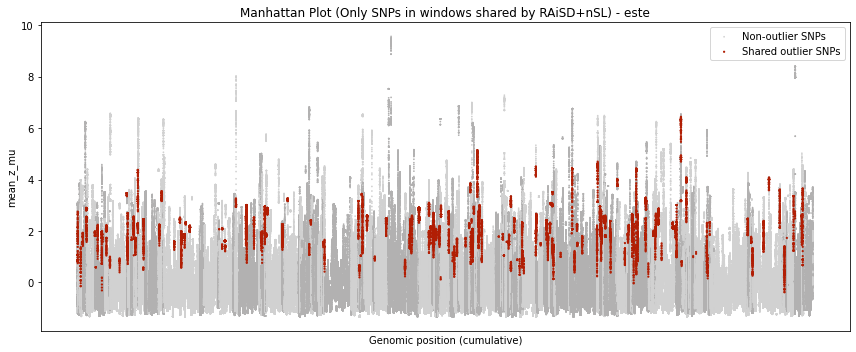

In [116]:
# Alternar colores por scaffold, etc.
colors = ['#d1d1d1', '#b2b1b1']  # Gris oscuro y gris claro
df_snps_in_shared_all_genes_mu['color_scaffold'] = df_snps_in_shared_all_genes_mu['chr_order'].cat.codes % 2

def assign_color(row):
    if row['is_outlier_shared']:
        return '#b11e04'  # Rojo si outlier en ambos
    else:
        return colors[row['color_scaffold']]

df_snps_in_shared_all_genes_mu['color'] = df_snps_in_shared_all_genes_mu.apply(assign_color, axis=1)

# Posición acumulada
df_snps_in_shared_all_genes_mu['cum_len'] = df_snps_in_shared_all_genes_mu.groupby('chr')['pos'].transform('max')
df_snps_in_shared_all_genes_mu['offset'] = (
    df_snps_in_shared_all_genes_mu.groupby('chr')['cum_len'].transform('first').cumsum()
    - df_snps_in_shared_all_genes_mu['cum_len']
)
df_snps_in_shared_all_genes_mu['cum_pos'] = (
    df_snps_in_shared_all_genes_mu['pos'] + df_snps_in_shared_all_genes_mu['offset']
)

# Plot
plt.figure(figsize=(12,5))

# Puntos no-outlier
plt.scatter(
    df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['cum_pos'],
    df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['mean_z_mu'],
    c=df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['color'],
    s=3, edgecolor='none', label='Non-outlier SNPs',
    zorder=1
)

# Puntos outlier (compartidos)
plt.scatter(
    df_snps_in_shared_all_genes_mu[df_snps_in_shared_all_genes_mu['is_outlier_shared']]['cum_pos'],
    df_snps_in_shared_all_genes_mu[df_snps_in_shared_all_genes_mu['is_outlier_shared']]['mean_z_mu'],
    c='#b11e04',  # rojo
    s=5, edgecolor='none', label='Shared outlier SNPs',
    zorder=2
)

plt.xticks([], [])
plt.xlabel("Genomic position (cumulative)")
plt.ylabel("mean_z_mu")
plt.title(f"Manhattan Plot (Only SNPs in windows shared by RAiSD+nSL) - {species_name}")

plt.tight_layout()
plt.legend()

# Guardar como PDF y PNG
output_pdf = f"{species_name}_manhattan_plot.pdf"
output_png = f"{species_name}_manhattan_plot.png"

plt.savefig(output_pdf, dpi=600, bbox_inches='tight')
plt.savefig(output_png, dpi=600, bbox_inches='tight')

plt.show()

## SOUTHEASTERN GENTOO PENGUIN

##### 1. LOAD DATA

In [118]:
species_name = "sudeste"

# Archivos de entrada
raisd_file = f"raisd_{species_name}_polarizado_reports.txt"
nsl_file   = f"{species_name}_nsl_10kb.norm"
vcf_file   = f"{species_name}_all_snps.bed"
gtf_file   = "GCA_010090195.1_genomic.gtf"

In [119]:
# Cargar RAiSD y nSL
raisd = pd.read_csv(raisd_file, sep='\t', low_memory=False)
raisd.columns = ['chr', 'pos', 'win_start', 'win_end', 'var', 'sfs', 'ld', 'mu']

In [120]:
nsl = pd.read_csv(nsl_file, sep='\t', low_memory=False)
nsl.columns = ['chr','pos','allfreq1','SL1','SL0','raw_nSL','norm_nSL','nsl_over_critval']
nsl['win_end'] = nsl['pos'] + 10000  # ventanas 10kb

In [121]:
# Add .1 to scaffold name
raisd['chr'] = raisd['chr'].astype(str) + '.1'
nsl['chr']   = nsl['chr'].astype(str) + '.1'

In [122]:
# BED of SNPs
vcf_bed = pd.read_csv(vcf_file, sep='\t', names=["chr","pos","end"])

In [123]:
vcf_bed

chr   pos   end
0         VUKY01000001.1    60    60
1         VUKY01000001.1   190   190
2         VUKY01000001.1   342   342
3         VUKY01000001.1   467   467
4         VUKY01000001.1   646   646
...                  ...   ...   ...
12028399  VUKY01018750.1  2361  2361
12028400  VUKY01018750.1  2362  2362
12028401  VUKY01018750.1  2383  2383
12028402  VUKY01018750.1  2390  2390
12028403  VUKY01018750.1  2465  2465

[12028404 rows x 3 columns]

In [124]:
# import GTF
gtf_data = pd.read_csv(
    gtf_file, sep='\t',
    comment='#', header=None,
    names=['Chromosome','Source','Feature','Start','End','Score','Strand','Frame','Attribute']
)

##### 2. Define threshold and RAiSD and nSL outlier

In [125]:
# Normalizar mu en RAiSD => z_mu
mean_mu = raisd['mu'].mean()
std_mu  = raisd['mu'].std()
raisd['z_mu'] = (raisd['mu'] - mean_mu) / std_mu

In [126]:
# Threshold (top 1%)
threshold_raisd      = raisd['z_mu'].quantile(0.99)
threshold_nsl_high   = nsl['norm_nSL'].quantile(0.99)
threshold_nsl_low    = nsl['norm_nSL'].quantile(0.01)

In [127]:
# Filtrar ventanas outlier
raisd_out = raisd[ raisd['z_mu'] >= threshold_raisd ]
nsl_out   = nsl[ (nsl['norm_nSL'] >= threshold_nsl_high) | (nsl['norm_nSL'] <= threshold_nsl_low) ]

##### 3. Intersect RAiSD and nSL dataframe

In [128]:
raisd_all = raisd.copy()
nsl_all   = nsl.copy()

In [129]:
# Convert to PyRanges
raisd_all_pr = pr.PyRanges(
    raisd_all.rename(columns={'chr': 'Chromosome', 'win_start': 'Start', 'win_end': 'End'})
)

In [130]:
nsl_all_pr = pr.PyRanges(
    nsl_all.rename(columns={'chr': 'Chromosome', 'pos': 'Start', 'win_end': 'End'})
)

In [131]:
# Intersect all windows and remove not shared genomic regions
shared_all_pr = raisd_all_pr.intersect(nsl_all_pr)
print(len(shared_all_pr.df)) 

59765025


In [132]:
# Merge windows
merged_shared_all_pr = shared_all_pr.merge()
df_shared_all = merged_shared_all_pr.df
print(len(df_shared_all)) 

19096


In [133]:
df_shared_all_pr = pr.PyRanges(df_shared_all)
df_shared_all_pr

+----------------+-----------+-----------+
| Chromosome     | Start     | End       |
| (category)     | (int64)   | (int64)   |
|----------------+-----------+-----------|
| VUKY01000002.1 | 27768     | 44362     |
| VUKY01000002.1 | 49449     | 150880    |
| VUKY01000002.1 | 154087    | 273634    |
| VUKY01000002.1 | 276896    | 303268    |
| ...            | ...       | ...       |
| VUKY01018721.1 | 6322531   | 6450949   |
| VUKY01018721.1 | 6294200   | 6310563   |
| VUKY01018721.1 | 6231184   | 6292762   |
| VUKY01018721.1 | 6213846   | 6230917   |
| VUKY01018732.1 | 3510      | 72415     |
| VUKY01018737.1 | 10125     | 10848     |
| VUKY01018747.1 | 14971     | 50969     |
+----------------+-----------+-----------+
Unstranded PyRanges object has 19,096 rows and 3 columns from 1626 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

##### 4. FIlter only SNPs within shared windows

In [134]:
# snps_pr with all SNPs
df_vcf = vcf_bed.rename(columns={"chr":"Chromosome"})
df_vcf["Start"] = df_vcf["pos"]
df_vcf["End"]   = df_vcf["pos"]
snps_pr = pr.PyRanges(df_vcf)

In [135]:
df_snps_in_shared_all_list = []

for scaf in snps_pr.chromosomes:
    print(f"Processing {scaf}")

    # 1) Subset of snps_pr for this scaffold
    snps_sub = snps_pr[scaf]
    # 2) Subset of df_shared_all_pr for this scaffold
    shared_sub = df_shared_all_pr[scaf]

    # 3) Intersect
    if snps_sub and shared_sub:
        intersection_sub = snps_sub.intersect(shared_sub)
        df_sub = intersection_sub.df
        df_snps_in_shared_all_list.append(df_sub)
    else:
        print(f"No data for scaffold {scaf}")

# Combine
if len(df_snps_in_shared_all_list) > 0:
    df_snps_in_shared_all = pd.concat(df_snps_in_shared_all_list, ignore_index=True)
else:
    df_snps_in_shared_all = pd.DataFrame()


Processing VUKY01000001.1
No data for scaffold VUKY01000001.1
Processing VUKY01000002.1
Processing VUKY01000004.1
No data for scaffold VUKY01000004.1
Processing VUKY01000005.1
No data for scaffold VUKY01000005.1
Processing VUKY01000006.1
No data for scaffold VUKY01000006.1
Processing VUKY01000007.1
No data for scaffold VUKY01000007.1
Processing VUKY01000008.1
No data for scaffold VUKY01000008.1
Processing VUKY01000009.1
No data for scaffold VUKY01000009.1
Processing VUKY01000010.1
No data for scaffold VUKY01000010.1
Processing VUKY01000013.1
No data for scaffold VUKY01000013.1
Processing VUKY01000015.1
No data for scaffold VUKY01000015.1
Processing VUKY01000018.1
No data for scaffold VUKY01000018.1
Processing VUKY01000019.1
No data for scaffold VUKY01000019.1
Processing VUKY01000020.1
No data for scaffold VUKY01000020.1
Processing VUKY01000021.1
No data for scaffold VUKY01000021.1
Processing VUKY01000022.1
No data for scaffold VUKY01000022.1
Processing VUKY01000024.1
No data for scaffo

No data for scaffold VUKY01000218.1
Processing VUKY01000220.1
No data for scaffold VUKY01000220.1
Processing VUKY01000221.1
No data for scaffold VUKY01000221.1
Processing VUKY01000222.1
No data for scaffold VUKY01000222.1
Processing VUKY01000223.1
No data for scaffold VUKY01000223.1
Processing VUKY01000224.1
No data for scaffold VUKY01000224.1
Processing VUKY01000227.1
No data for scaffold VUKY01000227.1
Processing VUKY01000228.1
No data for scaffold VUKY01000228.1
Processing VUKY01000229.1
No data for scaffold VUKY01000229.1
Processing VUKY01000230.1
No data for scaffold VUKY01000230.1
Processing VUKY01000232.1
Processing VUKY01000233.1
Processing VUKY01000234.1
No data for scaffold VUKY01000234.1
Processing VUKY01000235.1
Processing VUKY01000236.1
No data for scaffold VUKY01000236.1
Processing VUKY01000237.1
No data for scaffold VUKY01000237.1
Processing VUKY01000239.1
No data for scaffold VUKY01000239.1
Processing VUKY01000241.1
No data for scaffold VUKY01000241.1
Processing VUKY010

No data for scaffold VUKY01000430.1
Processing VUKY01000433.1
Processing VUKY01000434.1
No data for scaffold VUKY01000434.1
Processing VUKY01000436.1
No data for scaffold VUKY01000436.1
Processing VUKY01000437.1
No data for scaffold VUKY01000437.1
Processing VUKY01000438.1
No data for scaffold VUKY01000438.1
Processing VUKY01000439.1
No data for scaffold VUKY01000439.1
Processing VUKY01000441.1
No data for scaffold VUKY01000441.1
Processing VUKY01000442.1
No data for scaffold VUKY01000442.1
Processing VUKY01000443.1
No data for scaffold VUKY01000443.1
Processing VUKY01000444.1
No data for scaffold VUKY01000444.1
Processing VUKY01000445.1
Processing VUKY01000446.1
No data for scaffold VUKY01000446.1
Processing VUKY01000449.1
No data for scaffold VUKY01000449.1
Processing VUKY01000451.1
Processing VUKY01000453.1
No data for scaffold VUKY01000453.1
Processing VUKY01000457.1
No data for scaffold VUKY01000457.1
Processing VUKY01000458.1
No data for scaffold VUKY01000458.1
Processing VUKY010

No data for scaffold VUKY01000639.1
Processing VUKY01000640.1
No data for scaffold VUKY01000640.1
Processing VUKY01000642.1
No data for scaffold VUKY01000642.1
Processing VUKY01000644.1
Processing VUKY01000645.1
No data for scaffold VUKY01000645.1
Processing VUKY01000646.1
No data for scaffold VUKY01000646.1
Processing VUKY01000647.1
No data for scaffold VUKY01000647.1
Processing VUKY01000648.1
No data for scaffold VUKY01000648.1
Processing VUKY01000649.1
No data for scaffold VUKY01000649.1
Processing VUKY01000650.1
No data for scaffold VUKY01000650.1
Processing VUKY01000652.1
No data for scaffold VUKY01000652.1
Processing VUKY01000653.1
No data for scaffold VUKY01000653.1
Processing VUKY01000654.1
Processing VUKY01000655.1
No data for scaffold VUKY01000655.1
Processing VUKY01000656.1
No data for scaffold VUKY01000656.1
Processing VUKY01000657.1
No data for scaffold VUKY01000657.1
Processing VUKY01000658.1
No data for scaffold VUKY01000658.1
Processing VUKY01000661.1
No data for scaffo

No data for scaffold VUKY01000851.1
Processing VUKY01000852.1
No data for scaffold VUKY01000852.1
Processing VUKY01000853.1
No data for scaffold VUKY01000853.1
Processing VUKY01000855.1
No data for scaffold VUKY01000855.1
Processing VUKY01000856.1
No data for scaffold VUKY01000856.1
Processing VUKY01000857.1
No data for scaffold VUKY01000857.1
Processing VUKY01000858.1
No data for scaffold VUKY01000858.1
Processing VUKY01000859.1
No data for scaffold VUKY01000859.1
Processing VUKY01000860.1
Processing VUKY01000862.1
No data for scaffold VUKY01000862.1
Processing VUKY01000863.1
No data for scaffold VUKY01000863.1
Processing VUKY01000864.1
No data for scaffold VUKY01000864.1
Processing VUKY01000865.1
No data for scaffold VUKY01000865.1
Processing VUKY01000866.1
No data for scaffold VUKY01000866.1
Processing VUKY01000870.1
No data for scaffold VUKY01000870.1
Processing VUKY01000871.1
No data for scaffold VUKY01000871.1
Processing VUKY01000872.1
No data for scaffold VUKY01000872.1
Processi

No data for scaffold VUKY01001062.1
Processing VUKY01001063.1
No data for scaffold VUKY01001063.1
Processing VUKY01001064.1
Processing VUKY01001065.1
Processing VUKY01001066.1
No data for scaffold VUKY01001066.1
Processing VUKY01001068.1
No data for scaffold VUKY01001068.1
Processing VUKY01001073.1
No data for scaffold VUKY01001073.1
Processing VUKY01001075.1
No data for scaffold VUKY01001075.1
Processing VUKY01001077.1
No data for scaffold VUKY01001077.1
Processing VUKY01001078.1
No data for scaffold VUKY01001078.1
Processing VUKY01001079.1
No data for scaffold VUKY01001079.1
Processing VUKY01001081.1
No data for scaffold VUKY01001081.1
Processing VUKY01001082.1
Processing VUKY01001083.1
No data for scaffold VUKY01001083.1
Processing VUKY01001084.1
No data for scaffold VUKY01001084.1
Processing VUKY01001085.1
No data for scaffold VUKY01001085.1
Processing VUKY01001086.1
No data for scaffold VUKY01001086.1
Processing VUKY01001087.1
No data for scaffold VUKY01001087.1
Processing VUKY010

No data for scaffold VUKY01001267.1
Processing VUKY01001270.1
No data for scaffold VUKY01001270.1
Processing VUKY01001275.1
No data for scaffold VUKY01001275.1
Processing VUKY01001277.1
No data for scaffold VUKY01001277.1
Processing VUKY01001279.1
No data for scaffold VUKY01001279.1
Processing VUKY01001280.1
No data for scaffold VUKY01001280.1
Processing VUKY01001282.1
No data for scaffold VUKY01001282.1
Processing VUKY01001283.1
Processing VUKY01001284.1
No data for scaffold VUKY01001284.1
Processing VUKY01001285.1
No data for scaffold VUKY01001285.1
Processing VUKY01001286.1
No data for scaffold VUKY01001286.1
Processing VUKY01001287.1
No data for scaffold VUKY01001287.1
Processing VUKY01001288.1
No data for scaffold VUKY01001288.1
Processing VUKY01001289.1
No data for scaffold VUKY01001289.1
Processing VUKY01001293.1
No data for scaffold VUKY01001293.1
Processing VUKY01001296.1
No data for scaffold VUKY01001296.1
Processing VUKY01001297.1
No data for scaffold VUKY01001297.1
Processi

No data for scaffold VUKY01001512.1
Processing VUKY01001513.1
No data for scaffold VUKY01001513.1
Processing VUKY01001514.1
No data for scaffold VUKY01001514.1
Processing VUKY01001515.1
No data for scaffold VUKY01001515.1
Processing VUKY01001518.1
Processing VUKY01001520.1
No data for scaffold VUKY01001520.1
Processing VUKY01001521.1
No data for scaffold VUKY01001521.1
Processing VUKY01001522.1
No data for scaffold VUKY01001522.1
Processing VUKY01001523.1
Processing VUKY01001524.1
No data for scaffold VUKY01001524.1
Processing VUKY01001526.1
No data for scaffold VUKY01001526.1
Processing VUKY01001527.1
No data for scaffold VUKY01001527.1
Processing VUKY01001528.1
No data for scaffold VUKY01001528.1
Processing VUKY01001529.1
No data for scaffold VUKY01001529.1
Processing VUKY01001530.1
No data for scaffold VUKY01001530.1
Processing VUKY01001534.1
No data for scaffold VUKY01001534.1
Processing VUKY01001536.1
No data for scaffold VUKY01001536.1
Processing VUKY01001537.1
No data for scaffo

No data for scaffold VUKY01001735.1
Processing VUKY01001739.1
No data for scaffold VUKY01001739.1
Processing VUKY01001740.1
No data for scaffold VUKY01001740.1
Processing VUKY01001742.1
No data for scaffold VUKY01001742.1
Processing VUKY01001743.1
No data for scaffold VUKY01001743.1
Processing VUKY01001744.1
No data for scaffold VUKY01001744.1
Processing VUKY01001745.1
No data for scaffold VUKY01001745.1
Processing VUKY01001747.1
No data for scaffold VUKY01001747.1
Processing VUKY01001748.1
No data for scaffold VUKY01001748.1
Processing VUKY01001749.1
Processing VUKY01001750.1
No data for scaffold VUKY01001750.1
Processing VUKY01001751.1
Processing VUKY01001752.1
No data for scaffold VUKY01001752.1
Processing VUKY01001754.1
No data for scaffold VUKY01001754.1
Processing VUKY01001758.1
No data for scaffold VUKY01001758.1
Processing VUKY01001760.1
No data for scaffold VUKY01001760.1
Processing VUKY01001762.1
No data for scaffold VUKY01001762.1
Processing VUKY01001764.1
No data for scaffo

No data for scaffold VUKY01001958.1
Processing VUKY01001961.1
No data for scaffold VUKY01001961.1
Processing VUKY01001962.1
No data for scaffold VUKY01001962.1
Processing VUKY01001963.1
No data for scaffold VUKY01001963.1
Processing VUKY01001965.1
No data for scaffold VUKY01001965.1
Processing VUKY01001968.1
No data for scaffold VUKY01001968.1
Processing VUKY01001970.1
No data for scaffold VUKY01001970.1
Processing VUKY01001971.1
No data for scaffold VUKY01001971.1
Processing VUKY01001972.1
No data for scaffold VUKY01001972.1
Processing VUKY01001973.1
No data for scaffold VUKY01001973.1
Processing VUKY01001974.1
No data for scaffold VUKY01001974.1
Processing VUKY01001975.1
Processing VUKY01001977.1
No data for scaffold VUKY01001977.1
Processing VUKY01001979.1
No data for scaffold VUKY01001979.1
Processing VUKY01001980.1
No data for scaffold VUKY01001980.1
Processing VUKY01001981.1
No data for scaffold VUKY01001981.1
Processing VUKY01001982.1
No data for scaffold VUKY01001982.1
Processi

Processing VUKY01002166.1
No data for scaffold VUKY01002166.1
Processing VUKY01002168.1
No data for scaffold VUKY01002168.1
Processing VUKY01002170.1
No data for scaffold VUKY01002170.1
Processing VUKY01002171.1
No data for scaffold VUKY01002171.1
Processing VUKY01002173.1
No data for scaffold VUKY01002173.1
Processing VUKY01002176.1
No data for scaffold VUKY01002176.1
Processing VUKY01002177.1
Processing VUKY01002178.1
Processing VUKY01002179.1
No data for scaffold VUKY01002179.1
Processing VUKY01002180.1
No data for scaffold VUKY01002180.1
Processing VUKY01002181.1
No data for scaffold VUKY01002181.1
Processing VUKY01002182.1
No data for scaffold VUKY01002182.1
Processing VUKY01002183.1
No data for scaffold VUKY01002183.1
Processing VUKY01002185.1
No data for scaffold VUKY01002185.1
Processing VUKY01002186.1
No data for scaffold VUKY01002186.1
Processing VUKY01002187.1
No data for scaffold VUKY01002187.1
Processing VUKY01002189.1
No data for scaffold VUKY01002189.1
Processing VUKY010

No data for scaffold VUKY01002380.1
Processing VUKY01002381.1
No data for scaffold VUKY01002381.1
Processing VUKY01002383.1
No data for scaffold VUKY01002383.1
Processing VUKY01002384.1
No data for scaffold VUKY01002384.1
Processing VUKY01002385.1
No data for scaffold VUKY01002385.1
Processing VUKY01002387.1
No data for scaffold VUKY01002387.1
Processing VUKY01002389.1
No data for scaffold VUKY01002389.1
Processing VUKY01002390.1
No data for scaffold VUKY01002390.1
Processing VUKY01002392.1
No data for scaffold VUKY01002392.1
Processing VUKY01002393.1
No data for scaffold VUKY01002393.1
Processing VUKY01002395.1
No data for scaffold VUKY01002395.1
Processing VUKY01002396.1
No data for scaffold VUKY01002396.1
Processing VUKY01002397.1
No data for scaffold VUKY01002397.1
Processing VUKY01002398.1
No data for scaffold VUKY01002398.1
Processing VUKY01002399.1
No data for scaffold VUKY01002399.1
Processing VUKY01002402.1
No data for scaffold VUKY01002402.1
Processing VUKY01002403.1
Processi

No data for scaffold VUKY01002599.1
Processing VUKY01002600.1
Processing VUKY01002601.1
No data for scaffold VUKY01002601.1
Processing VUKY01002602.1
No data for scaffold VUKY01002602.1
Processing VUKY01002603.1
No data for scaffold VUKY01002603.1
Processing VUKY01002604.1
No data for scaffold VUKY01002604.1
Processing VUKY01002605.1
No data for scaffold VUKY01002605.1
Processing VUKY01002606.1
No data for scaffold VUKY01002606.1
Processing VUKY01002607.1
No data for scaffold VUKY01002607.1
Processing VUKY01002609.1
No data for scaffold VUKY01002609.1
Processing VUKY01002611.1
No data for scaffold VUKY01002611.1
Processing VUKY01002613.1
No data for scaffold VUKY01002613.1
Processing VUKY01002614.1
No data for scaffold VUKY01002614.1
Processing VUKY01002616.1
No data for scaffold VUKY01002616.1
Processing VUKY01002618.1
No data for scaffold VUKY01002618.1
Processing VUKY01002619.1
No data for scaffold VUKY01002619.1
Processing VUKY01002621.1
No data for scaffold VUKY01002621.1
Processi

No data for scaffold VUKY01002805.1
Processing VUKY01002806.1
No data for scaffold VUKY01002806.1
Processing VUKY01002807.1
No data for scaffold VUKY01002807.1
Processing VUKY01002808.1
No data for scaffold VUKY01002808.1
Processing VUKY01002809.1
No data for scaffold VUKY01002809.1
Processing VUKY01002811.1
No data for scaffold VUKY01002811.1
Processing VUKY01002812.1
No data for scaffold VUKY01002812.1
Processing VUKY01002814.1
No data for scaffold VUKY01002814.1
Processing VUKY01002816.1
Processing VUKY01002819.1
No data for scaffold VUKY01002819.1
Processing VUKY01002820.1
No data for scaffold VUKY01002820.1
Processing VUKY01002821.1
Processing VUKY01002822.1
No data for scaffold VUKY01002822.1
Processing VUKY01002823.1
No data for scaffold VUKY01002823.1
Processing VUKY01002825.1
No data for scaffold VUKY01002825.1
Processing VUKY01002826.1
No data for scaffold VUKY01002826.1
Processing VUKY01002827.1
No data for scaffold VUKY01002827.1
Processing VUKY01002832.1
No data for scaffo

No data for scaffold VUKY01003002.1
Processing VUKY01003003.1
No data for scaffold VUKY01003003.1
Processing VUKY01003006.1
No data for scaffold VUKY01003006.1
Processing VUKY01003007.1
No data for scaffold VUKY01003007.1
Processing VUKY01003008.1
Processing VUKY01003010.1
No data for scaffold VUKY01003010.1
Processing VUKY01003011.1
No data for scaffold VUKY01003011.1
Processing VUKY01003012.1
Processing VUKY01003013.1
No data for scaffold VUKY01003013.1
Processing VUKY01003015.1
No data for scaffold VUKY01003015.1
Processing VUKY01003016.1
Processing VUKY01003017.1
No data for scaffold VUKY01003017.1
Processing VUKY01003018.1
No data for scaffold VUKY01003018.1
Processing VUKY01003019.1
No data for scaffold VUKY01003019.1
Processing VUKY01003024.1
No data for scaffold VUKY01003024.1
Processing VUKY01003025.1
No data for scaffold VUKY01003025.1
Processing VUKY01003026.1
No data for scaffold VUKY01003026.1
Processing VUKY01003027.1
No data for scaffold VUKY01003027.1
Processing VUKY010

No data for scaffold VUKY01003234.1
Processing VUKY01003237.1
No data for scaffold VUKY01003237.1
Processing VUKY01003239.1
No data for scaffold VUKY01003239.1
Processing VUKY01003242.1
No data for scaffold VUKY01003242.1
Processing VUKY01003243.1
Processing VUKY01003246.1
No data for scaffold VUKY01003246.1
Processing VUKY01003247.1
No data for scaffold VUKY01003247.1
Processing VUKY01003248.1
No data for scaffold VUKY01003248.1
Processing VUKY01003250.1
No data for scaffold VUKY01003250.1
Processing VUKY01003252.1
No data for scaffold VUKY01003252.1
Processing VUKY01003253.1
No data for scaffold VUKY01003253.1
Processing VUKY01003254.1
No data for scaffold VUKY01003254.1
Processing VUKY01003255.1
No data for scaffold VUKY01003255.1
Processing VUKY01003256.1
No data for scaffold VUKY01003256.1
Processing VUKY01003257.1
No data for scaffold VUKY01003257.1
Processing VUKY01003258.1
Processing VUKY01003259.1
No data for scaffold VUKY01003259.1
Processing VUKY01003260.1
No data for scaffo

No data for scaffold VUKY01003455.1
Processing VUKY01003456.1
No data for scaffold VUKY01003456.1
Processing VUKY01003458.1
No data for scaffold VUKY01003458.1
Processing VUKY01003459.1
No data for scaffold VUKY01003459.1
Processing VUKY01003460.1
Processing VUKY01003462.1
No data for scaffold VUKY01003462.1
Processing VUKY01003464.1
No data for scaffold VUKY01003464.1
Processing VUKY01003465.1
No data for scaffold VUKY01003465.1
Processing VUKY01003468.1
No data for scaffold VUKY01003468.1
Processing VUKY01003469.1
No data for scaffold VUKY01003469.1
Processing VUKY01003470.1
Processing VUKY01003471.1
No data for scaffold VUKY01003471.1
Processing VUKY01003473.1
No data for scaffold VUKY01003473.1
Processing VUKY01003474.1
No data for scaffold VUKY01003474.1
Processing VUKY01003475.1
No data for scaffold VUKY01003475.1
Processing VUKY01003476.1
No data for scaffold VUKY01003476.1
Processing VUKY01003477.1
No data for scaffold VUKY01003477.1
Processing VUKY01003479.1
No data for scaffo

No data for scaffold VUKY01003663.1
Processing VUKY01003666.1
No data for scaffold VUKY01003666.1
Processing VUKY01003670.1
No data for scaffold VUKY01003670.1
Processing VUKY01003671.1
No data for scaffold VUKY01003671.1
Processing VUKY01003672.1
No data for scaffold VUKY01003672.1
Processing VUKY01003673.1
No data for scaffold VUKY01003673.1
Processing VUKY01003674.1
No data for scaffold VUKY01003674.1
Processing VUKY01003677.1
No data for scaffold VUKY01003677.1
Processing VUKY01003679.1
No data for scaffold VUKY01003679.1
Processing VUKY01003680.1
No data for scaffold VUKY01003680.1
Processing VUKY01003681.1
No data for scaffold VUKY01003681.1
Processing VUKY01003682.1
Processing VUKY01003683.1
No data for scaffold VUKY01003683.1
Processing VUKY01003684.1
No data for scaffold VUKY01003684.1
Processing VUKY01003685.1
No data for scaffold VUKY01003685.1
Processing VUKY01003687.1
No data for scaffold VUKY01003687.1
Processing VUKY01003689.1
No data for scaffold VUKY01003689.1
Processi

Processing VUKY01003905.1
No data for scaffold VUKY01003905.1
Processing VUKY01003906.1
No data for scaffold VUKY01003906.1
Processing VUKY01003910.1
No data for scaffold VUKY01003910.1
Processing VUKY01003912.1
No data for scaffold VUKY01003912.1
Processing VUKY01003915.1
No data for scaffold VUKY01003915.1
Processing VUKY01003916.1
No data for scaffold VUKY01003916.1
Processing VUKY01003917.1
Processing VUKY01003918.1
No data for scaffold VUKY01003918.1
Processing VUKY01003919.1
No data for scaffold VUKY01003919.1
Processing VUKY01003920.1
No data for scaffold VUKY01003920.1
Processing VUKY01003921.1
No data for scaffold VUKY01003921.1
Processing VUKY01003924.1
No data for scaffold VUKY01003924.1
Processing VUKY01003925.1
No data for scaffold VUKY01003925.1
Processing VUKY01003926.1
No data for scaffold VUKY01003926.1
Processing VUKY01003928.1
No data for scaffold VUKY01003928.1
Processing VUKY01003930.1
No data for scaffold VUKY01003930.1
Processing VUKY01003931.1
No data for scaffo

No data for scaffold VUKY01004108.1
Processing VUKY01004113.1
Processing VUKY01004115.1
No data for scaffold VUKY01004115.1
Processing VUKY01004116.1
No data for scaffold VUKY01004116.1
Processing VUKY01004117.1
No data for scaffold VUKY01004117.1
Processing VUKY01004118.1
No data for scaffold VUKY01004118.1
Processing VUKY01004120.1
No data for scaffold VUKY01004120.1
Processing VUKY01004121.1
No data for scaffold VUKY01004121.1
Processing VUKY01004122.1
Processing VUKY01004125.1
No data for scaffold VUKY01004125.1
Processing VUKY01004126.1
No data for scaffold VUKY01004126.1
Processing VUKY01004127.1
No data for scaffold VUKY01004127.1
Processing VUKY01004129.1
No data for scaffold VUKY01004129.1
Processing VUKY01004131.1
No data for scaffold VUKY01004131.1
Processing VUKY01004132.1
No data for scaffold VUKY01004132.1
Processing VUKY01004133.1
No data for scaffold VUKY01004133.1
Processing VUKY01004135.1
Processing VUKY01004137.1
No data for scaffold VUKY01004137.1
Processing VUKY010

No data for scaffold VUKY01004331.1
Processing VUKY01004332.1
No data for scaffold VUKY01004332.1
Processing VUKY01004333.1
No data for scaffold VUKY01004333.1
Processing VUKY01004334.1
Processing VUKY01004335.1
No data for scaffold VUKY01004335.1
Processing VUKY01004337.1
No data for scaffold VUKY01004337.1
Processing VUKY01004338.1
No data for scaffold VUKY01004338.1
Processing VUKY01004339.1
No data for scaffold VUKY01004339.1
Processing VUKY01004342.1
No data for scaffold VUKY01004342.1
Processing VUKY01004345.1
No data for scaffold VUKY01004345.1
Processing VUKY01004347.1
No data for scaffold VUKY01004347.1
Processing VUKY01004348.1
No data for scaffold VUKY01004348.1
Processing VUKY01004353.1
No data for scaffold VUKY01004353.1
Processing VUKY01004354.1
Processing VUKY01004355.1
No data for scaffold VUKY01004355.1
Processing VUKY01004356.1
No data for scaffold VUKY01004356.1
Processing VUKY01004358.1
No data for scaffold VUKY01004358.1
Processing VUKY01004359.1
No data for scaffo

Processing VUKY01004547.1
No data for scaffold VUKY01004547.1
Processing VUKY01004549.1
No data for scaffold VUKY01004549.1
Processing VUKY01004550.1
Processing VUKY01004552.1
Processing VUKY01004553.1
No data for scaffold VUKY01004553.1
Processing VUKY01004554.1
No data for scaffold VUKY01004554.1
Processing VUKY01004555.1
No data for scaffold VUKY01004555.1
Processing VUKY01004556.1
Processing VUKY01004558.1
No data for scaffold VUKY01004558.1
Processing VUKY01004561.1
No data for scaffold VUKY01004561.1
Processing VUKY01004562.1
Processing VUKY01004563.1
No data for scaffold VUKY01004563.1
Processing VUKY01004564.1
Processing VUKY01004569.1
No data for scaffold VUKY01004569.1
Processing VUKY01004570.1
No data for scaffold VUKY01004570.1
Processing VUKY01004571.1
No data for scaffold VUKY01004571.1
Processing VUKY01004573.1
Processing VUKY01004577.1
No data for scaffold VUKY01004577.1
Processing VUKY01004579.1
No data for scaffold VUKY01004579.1
Processing VUKY01004581.1
No data for 

No data for scaffold VUKY01004773.1
Processing VUKY01004776.1
No data for scaffold VUKY01004776.1
Processing VUKY01004777.1
No data for scaffold VUKY01004777.1
Processing VUKY01004778.1
Processing VUKY01004779.1
No data for scaffold VUKY01004779.1
Processing VUKY01004780.1
No data for scaffold VUKY01004780.1
Processing VUKY01004781.1
No data for scaffold VUKY01004781.1
Processing VUKY01004782.1
No data for scaffold VUKY01004782.1
Processing VUKY01004783.1
No data for scaffold VUKY01004783.1
Processing VUKY01004784.1
No data for scaffold VUKY01004784.1
Processing VUKY01004785.1
No data for scaffold VUKY01004785.1
Processing VUKY01004788.1
No data for scaffold VUKY01004788.1
Processing VUKY01004793.1
No data for scaffold VUKY01004793.1
Processing VUKY01004794.1
No data for scaffold VUKY01004794.1
Processing VUKY01004795.1
No data for scaffold VUKY01004795.1
Processing VUKY01004797.1
No data for scaffold VUKY01004797.1
Processing VUKY01004798.1
No data for scaffold VUKY01004798.1
Processi

No data for scaffold VUKY01004993.1
Processing VUKY01004994.1
No data for scaffold VUKY01004994.1
Processing VUKY01004995.1
No data for scaffold VUKY01004995.1
Processing VUKY01004996.1
No data for scaffold VUKY01004996.1
Processing VUKY01004998.1
No data for scaffold VUKY01004998.1
Processing VUKY01005000.1
No data for scaffold VUKY01005000.1
Processing VUKY01005002.1
No data for scaffold VUKY01005002.1
Processing VUKY01005003.1
No data for scaffold VUKY01005003.1
Processing VUKY01005004.1
No data for scaffold VUKY01005004.1
Processing VUKY01005005.1
No data for scaffold VUKY01005005.1
Processing VUKY01005006.1
No data for scaffold VUKY01005006.1
Processing VUKY01005007.1
No data for scaffold VUKY01005007.1
Processing VUKY01005008.1
No data for scaffold VUKY01005008.1
Processing VUKY01005011.1
No data for scaffold VUKY01005011.1
Processing VUKY01005013.1
No data for scaffold VUKY01005013.1
Processing VUKY01005015.1
No data for scaffold VUKY01005015.1
Processing VUKY01005016.1
Processi

No data for scaffold VUKY01005220.1
Processing VUKY01005222.1
No data for scaffold VUKY01005222.1
Processing VUKY01005223.1
No data for scaffold VUKY01005223.1
Processing VUKY01005225.1
Processing VUKY01005227.1
No data for scaffold VUKY01005227.1
Processing VUKY01005230.1
No data for scaffold VUKY01005230.1
Processing VUKY01005232.1
No data for scaffold VUKY01005232.1
Processing VUKY01005233.1
No data for scaffold VUKY01005233.1
Processing VUKY01005234.1
No data for scaffold VUKY01005234.1
Processing VUKY01005235.1
No data for scaffold VUKY01005235.1
Processing VUKY01005238.1
No data for scaffold VUKY01005238.1
Processing VUKY01005240.1
Processing VUKY01005241.1
No data for scaffold VUKY01005241.1
Processing VUKY01005244.1
No data for scaffold VUKY01005244.1
Processing VUKY01005245.1
No data for scaffold VUKY01005245.1
Processing VUKY01005248.1
No data for scaffold VUKY01005248.1
Processing VUKY01005249.1
No data for scaffold VUKY01005249.1
Processing VUKY01005251.1
No data for scaffo

No data for scaffold VUKY01005417.1
Processing VUKY01005418.1
No data for scaffold VUKY01005418.1
Processing VUKY01005419.1
No data for scaffold VUKY01005419.1
Processing VUKY01005420.1
No data for scaffold VUKY01005420.1
Processing VUKY01005421.1
No data for scaffold VUKY01005421.1
Processing VUKY01005422.1
No data for scaffold VUKY01005422.1
Processing VUKY01005423.1
No data for scaffold VUKY01005423.1
Processing VUKY01005424.1
No data for scaffold VUKY01005424.1
Processing VUKY01005425.1
No data for scaffold VUKY01005425.1
Processing VUKY01005426.1
No data for scaffold VUKY01005426.1
Processing VUKY01005427.1
Processing VUKY01005428.1
No data for scaffold VUKY01005428.1
Processing VUKY01005430.1
No data for scaffold VUKY01005430.1
Processing VUKY01005431.1
No data for scaffold VUKY01005431.1
Processing VUKY01005432.1
No data for scaffold VUKY01005432.1
Processing VUKY01005433.1
No data for scaffold VUKY01005433.1
Processing VUKY01005435.1
No data for scaffold VUKY01005435.1
Processi

No data for scaffold VUKY01005611.1
Processing VUKY01005612.1
No data for scaffold VUKY01005612.1
Processing VUKY01005613.1
No data for scaffold VUKY01005613.1
Processing VUKY01005614.1
No data for scaffold VUKY01005614.1
Processing VUKY01005615.1
No data for scaffold VUKY01005615.1
Processing VUKY01005617.1
No data for scaffold VUKY01005617.1
Processing VUKY01005618.1
No data for scaffold VUKY01005618.1
Processing VUKY01005619.1
Processing VUKY01005620.1
No data for scaffold VUKY01005620.1
Processing VUKY01005621.1
No data for scaffold VUKY01005621.1
Processing VUKY01005622.1
No data for scaffold VUKY01005622.1
Processing VUKY01005623.1
No data for scaffold VUKY01005623.1
Processing VUKY01005624.1
No data for scaffold VUKY01005624.1
Processing VUKY01005625.1
No data for scaffold VUKY01005625.1
Processing VUKY01005626.1
No data for scaffold VUKY01005626.1
Processing VUKY01005628.1
No data for scaffold VUKY01005628.1
Processing VUKY01005629.1
No data for scaffold VUKY01005629.1
Processi

No data for scaffold VUKY01005824.1
Processing VUKY01005825.1
Processing VUKY01005826.1
No data for scaffold VUKY01005826.1
Processing VUKY01005829.1
Processing VUKY01005830.1
Processing VUKY01005831.1
No data for scaffold VUKY01005831.1
Processing VUKY01005833.1
No data for scaffold VUKY01005833.1
Processing VUKY01005834.1
No data for scaffold VUKY01005834.1
Processing VUKY01005835.1
No data for scaffold VUKY01005835.1
Processing VUKY01005836.1
No data for scaffold VUKY01005836.1
Processing VUKY01005837.1
No data for scaffold VUKY01005837.1
Processing VUKY01005838.1
No data for scaffold VUKY01005838.1
Processing VUKY01005839.1
Processing VUKY01005840.1
No data for scaffold VUKY01005840.1
Processing VUKY01005845.1
Processing VUKY01005846.1
No data for scaffold VUKY01005846.1
Processing VUKY01005848.1
No data for scaffold VUKY01005848.1
Processing VUKY01005849.1
No data for scaffold VUKY01005849.1
Processing VUKY01005850.1
No data for scaffold VUKY01005850.1
Processing VUKY01005851.1
No

No data for scaffold VUKY01006028.1
Processing VUKY01006029.1
No data for scaffold VUKY01006029.1
Processing VUKY01006030.1
No data for scaffold VUKY01006030.1
Processing VUKY01006031.1
No data for scaffold VUKY01006031.1
Processing VUKY01006033.1
No data for scaffold VUKY01006033.1
Processing VUKY01006034.1
No data for scaffold VUKY01006034.1
Processing VUKY01006035.1
Processing VUKY01006036.1
No data for scaffold VUKY01006036.1
Processing VUKY01006038.1
No data for scaffold VUKY01006038.1
Processing VUKY01006039.1
No data for scaffold VUKY01006039.1
Processing VUKY01006040.1
No data for scaffold VUKY01006040.1
Processing VUKY01006041.1
No data for scaffold VUKY01006041.1
Processing VUKY01006042.1
No data for scaffold VUKY01006042.1
Processing VUKY01006043.1
No data for scaffold VUKY01006043.1
Processing VUKY01006046.1
No data for scaffold VUKY01006046.1
Processing VUKY01006048.1
No data for scaffold VUKY01006048.1
Processing VUKY01006050.1
No data for scaffold VUKY01006050.1
Processi

No data for scaffold VUKY01006226.1
Processing VUKY01006228.1
No data for scaffold VUKY01006228.1
Processing VUKY01006229.1
No data for scaffold VUKY01006229.1
Processing VUKY01006231.1
No data for scaffold VUKY01006231.1
Processing VUKY01006232.1
No data for scaffold VUKY01006232.1
Processing VUKY01006233.1
Processing VUKY01006235.1
No data for scaffold VUKY01006235.1
Processing VUKY01006236.1
No data for scaffold VUKY01006236.1
Processing VUKY01006238.1
No data for scaffold VUKY01006238.1
Processing VUKY01006239.1
No data for scaffold VUKY01006239.1
Processing VUKY01006240.1
No data for scaffold VUKY01006240.1
Processing VUKY01006241.1
No data for scaffold VUKY01006241.1
Processing VUKY01006242.1
No data for scaffold VUKY01006242.1
Processing VUKY01006243.1
No data for scaffold VUKY01006243.1
Processing VUKY01006245.1
Processing VUKY01006247.1
No data for scaffold VUKY01006247.1
Processing VUKY01006248.1
No data for scaffold VUKY01006248.1
Processing VUKY01006249.1
Processing VUKY010

No data for scaffold VUKY01006436.1
Processing VUKY01006437.1
No data for scaffold VUKY01006437.1
Processing VUKY01006439.1
No data for scaffold VUKY01006439.1
Processing VUKY01006440.1
No data for scaffold VUKY01006440.1
Processing VUKY01006441.1
No data for scaffold VUKY01006441.1
Processing VUKY01006442.1
No data for scaffold VUKY01006442.1
Processing VUKY01006444.1
No data for scaffold VUKY01006444.1
Processing VUKY01006445.1
No data for scaffold VUKY01006445.1
Processing VUKY01006449.1
No data for scaffold VUKY01006449.1
Processing VUKY01006450.1
Processing VUKY01006451.1
No data for scaffold VUKY01006451.1
Processing VUKY01006452.1
No data for scaffold VUKY01006452.1
Processing VUKY01006453.1
No data for scaffold VUKY01006453.1
Processing VUKY01006454.1
Processing VUKY01006455.1
No data for scaffold VUKY01006455.1
Processing VUKY01006456.1
No data for scaffold VUKY01006456.1
Processing VUKY01006457.1
No data for scaffold VUKY01006457.1
Processing VUKY01006458.1
Processing VUKY010

No data for scaffold VUKY01006640.1
Processing VUKY01006641.1
No data for scaffold VUKY01006641.1
Processing VUKY01006643.1
No data for scaffold VUKY01006643.1
Processing VUKY01006644.1
Processing VUKY01006647.1
Processing VUKY01006648.1
No data for scaffold VUKY01006648.1
Processing VUKY01006651.1
No data for scaffold VUKY01006651.1
Processing VUKY01006652.1
No data for scaffold VUKY01006652.1
Processing VUKY01006653.1
No data for scaffold VUKY01006653.1
Processing VUKY01006654.1
No data for scaffold VUKY01006654.1
Processing VUKY01006655.1
No data for scaffold VUKY01006655.1
Processing VUKY01006656.1
Processing VUKY01006657.1
No data for scaffold VUKY01006657.1
Processing VUKY01006658.1
No data for scaffold VUKY01006658.1
Processing VUKY01006659.1
No data for scaffold VUKY01006659.1
Processing VUKY01006663.1
Processing VUKY01006664.1
No data for scaffold VUKY01006664.1
Processing VUKY01006665.1
No data for scaffold VUKY01006665.1
Processing VUKY01006666.1
Processing VUKY01006667.1
No

No data for scaffold VUKY01006857.1
Processing VUKY01006858.1
Processing VUKY01006859.1
No data for scaffold VUKY01006859.1
Processing VUKY01006864.1
No data for scaffold VUKY01006864.1
Processing VUKY01006865.1
No data for scaffold VUKY01006865.1
Processing VUKY01006866.1
No data for scaffold VUKY01006866.1
Processing VUKY01006868.1
Processing VUKY01006872.1
No data for scaffold VUKY01006872.1
Processing VUKY01006873.1
No data for scaffold VUKY01006873.1
Processing VUKY01006874.1
Processing VUKY01006877.1
No data for scaffold VUKY01006877.1
Processing VUKY01006878.1
Processing VUKY01006879.1
No data for scaffold VUKY01006879.1
Processing VUKY01006880.1
No data for scaffold VUKY01006880.1
Processing VUKY01006881.1
No data for scaffold VUKY01006881.1
Processing VUKY01006883.1
No data for scaffold VUKY01006883.1
Processing VUKY01006884.1
No data for scaffold VUKY01006884.1
Processing VUKY01006885.1
No data for scaffold VUKY01006885.1
Processing VUKY01006888.1
No data for scaffold VUKY010

No data for scaffold VUKY01007087.1
Processing VUKY01007088.1
No data for scaffold VUKY01007088.1
Processing VUKY01007089.1
No data for scaffold VUKY01007089.1
Processing VUKY01007091.1
No data for scaffold VUKY01007091.1
Processing VUKY01007092.1
No data for scaffold VUKY01007092.1
Processing VUKY01007093.1
No data for scaffold VUKY01007093.1
Processing VUKY01007094.1
No data for scaffold VUKY01007094.1
Processing VUKY01007095.1
No data for scaffold VUKY01007095.1
Processing VUKY01007097.1
No data for scaffold VUKY01007097.1
Processing VUKY01007098.1
No data for scaffold VUKY01007098.1
Processing VUKY01007099.1
No data for scaffold VUKY01007099.1
Processing VUKY01007100.1
No data for scaffold VUKY01007100.1
Processing VUKY01007102.1
No data for scaffold VUKY01007102.1
Processing VUKY01007103.1
No data for scaffold VUKY01007103.1
Processing VUKY01007104.1
No data for scaffold VUKY01007104.1
Processing VUKY01007106.1
No data for scaffold VUKY01007106.1
Processing VUKY01007107.1
No data 

No data for scaffold VUKY01007301.1
Processing VUKY01007302.1
No data for scaffold VUKY01007302.1
Processing VUKY01007306.1
No data for scaffold VUKY01007306.1
Processing VUKY01007307.1
No data for scaffold VUKY01007307.1
Processing VUKY01007309.1
No data for scaffold VUKY01007309.1
Processing VUKY01007311.1
No data for scaffold VUKY01007311.1
Processing VUKY01007313.1
No data for scaffold VUKY01007313.1
Processing VUKY01007314.1
No data for scaffold VUKY01007314.1
Processing VUKY01007316.1
No data for scaffold VUKY01007316.1
Processing VUKY01007318.1
Processing VUKY01007320.1
No data for scaffold VUKY01007320.1
Processing VUKY01007321.1
No data for scaffold VUKY01007321.1
Processing VUKY01007323.1
No data for scaffold VUKY01007323.1
Processing VUKY01007326.1
Processing VUKY01007328.1
No data for scaffold VUKY01007328.1
Processing VUKY01007329.1
No data for scaffold VUKY01007329.1
Processing VUKY01007330.1
No data for scaffold VUKY01007330.1
Processing VUKY01007331.1
No data for scaffo

No data for scaffold VUKY01007505.1
Processing VUKY01007506.1
No data for scaffold VUKY01007506.1
Processing VUKY01007507.1
Processing VUKY01007509.1
No data for scaffold VUKY01007509.1
Processing VUKY01007510.1
No data for scaffold VUKY01007510.1
Processing VUKY01007511.1
Processing VUKY01007513.1
No data for scaffold VUKY01007513.1
Processing VUKY01007515.1
No data for scaffold VUKY01007515.1
Processing VUKY01007516.1
No data for scaffold VUKY01007516.1
Processing VUKY01007517.1
No data for scaffold VUKY01007517.1
Processing VUKY01007518.1
No data for scaffold VUKY01007518.1
Processing VUKY01007519.1
No data for scaffold VUKY01007519.1
Processing VUKY01007520.1
No data for scaffold VUKY01007520.1
Processing VUKY01007522.1
No data for scaffold VUKY01007522.1
Processing VUKY01007523.1
Processing VUKY01007524.1
No data for scaffold VUKY01007524.1
Processing VUKY01007525.1
Processing VUKY01007526.1
No data for scaffold VUKY01007526.1
Processing VUKY01007527.1
No data for scaffold VUKY010

No data for scaffold VUKY01007722.1
Processing VUKY01007724.1
No data for scaffold VUKY01007724.1
Processing VUKY01007730.1
No data for scaffold VUKY01007730.1
Processing VUKY01007732.1
No data for scaffold VUKY01007732.1
Processing VUKY01007733.1
Processing VUKY01007734.1
No data for scaffold VUKY01007734.1
Processing VUKY01007735.1
No data for scaffold VUKY01007735.1
Processing VUKY01007736.1
No data for scaffold VUKY01007736.1
Processing VUKY01007739.1
No data for scaffold VUKY01007739.1
Processing VUKY01007740.1
No data for scaffold VUKY01007740.1
Processing VUKY01007742.1
No data for scaffold VUKY01007742.1
Processing VUKY01007743.1
No data for scaffold VUKY01007743.1
Processing VUKY01007744.1
No data for scaffold VUKY01007744.1
Processing VUKY01007745.1
Processing VUKY01007746.1
No data for scaffold VUKY01007746.1
Processing VUKY01007747.1
No data for scaffold VUKY01007747.1
Processing VUKY01007749.1
No data for scaffold VUKY01007749.1
Processing VUKY01007750.1
No data for scaffo

Processing VUKY01007954.1
No data for scaffold VUKY01007954.1
Processing VUKY01007957.1
No data for scaffold VUKY01007957.1
Processing VUKY01007958.1
No data for scaffold VUKY01007958.1
Processing VUKY01007959.1
Processing VUKY01007960.1
No data for scaffold VUKY01007960.1
Processing VUKY01007964.1
No data for scaffold VUKY01007964.1
Processing VUKY01007967.1
No data for scaffold VUKY01007967.1
Processing VUKY01007968.1
No data for scaffold VUKY01007968.1
Processing VUKY01007969.1
Processing VUKY01007970.1
No data for scaffold VUKY01007970.1
Processing VUKY01007972.1
No data for scaffold VUKY01007972.1
Processing VUKY01007973.1
No data for scaffold VUKY01007973.1
Processing VUKY01007974.1
No data for scaffold VUKY01007974.1
Processing VUKY01007975.1
No data for scaffold VUKY01007975.1
Processing VUKY01007978.1
No data for scaffold VUKY01007978.1
Processing VUKY01007980.1
No data for scaffold VUKY01007980.1
Processing VUKY01007981.1
No data for scaffold VUKY01007981.1
Processing VUKY010

No data for scaffold VUKY01008170.1
Processing VUKY01008171.1
No data for scaffold VUKY01008171.1
Processing VUKY01008173.1
No data for scaffold VUKY01008173.1
Processing VUKY01008174.1
No data for scaffold VUKY01008174.1
Processing VUKY01008175.1
No data for scaffold VUKY01008175.1
Processing VUKY01008176.1
No data for scaffold VUKY01008176.1
Processing VUKY01008177.1
Processing VUKY01008179.1
No data for scaffold VUKY01008179.1
Processing VUKY01008180.1
Processing VUKY01008181.1
Processing VUKY01008183.1
Processing VUKY01008185.1
No data for scaffold VUKY01008185.1
Processing VUKY01008186.1
Processing VUKY01008187.1
No data for scaffold VUKY01008187.1
Processing VUKY01008190.1
No data for scaffold VUKY01008190.1
Processing VUKY01008192.1
No data for scaffold VUKY01008192.1
Processing VUKY01008194.1
No data for scaffold VUKY01008194.1
Processing VUKY01008195.1
No data for scaffold VUKY01008195.1
Processing VUKY01008196.1
No data for scaffold VUKY01008196.1
Processing VUKY01008197.1
No

No data for scaffold VUKY01008378.1
Processing VUKY01008380.1
No data for scaffold VUKY01008380.1
Processing VUKY01008382.1
No data for scaffold VUKY01008382.1
Processing VUKY01008383.1
No data for scaffold VUKY01008383.1
Processing VUKY01008385.1
No data for scaffold VUKY01008385.1
Processing VUKY01008388.1
No data for scaffold VUKY01008388.1
Processing VUKY01008389.1
No data for scaffold VUKY01008389.1
Processing VUKY01008392.1
No data for scaffold VUKY01008392.1
Processing VUKY01008393.1
No data for scaffold VUKY01008393.1
Processing VUKY01008394.1
No data for scaffold VUKY01008394.1
Processing VUKY01008395.1
No data for scaffold VUKY01008395.1
Processing VUKY01008396.1
No data for scaffold VUKY01008396.1
Processing VUKY01008398.1
No data for scaffold VUKY01008398.1
Processing VUKY01008399.1
No data for scaffold VUKY01008399.1
Processing VUKY01008400.1
Processing VUKY01008401.1
No data for scaffold VUKY01008401.1
Processing VUKY01008403.1
No data for scaffold VUKY01008403.1
Processi

No data for scaffold VUKY01008567.1
Processing VUKY01008570.1
No data for scaffold VUKY01008570.1
Processing VUKY01008572.1
Processing VUKY01008574.1
No data for scaffold VUKY01008574.1
Processing VUKY01008577.1
Processing VUKY01008578.1
No data for scaffold VUKY01008578.1
Processing VUKY01008579.1
No data for scaffold VUKY01008579.1
Processing VUKY01008583.1
No data for scaffold VUKY01008583.1
Processing VUKY01008584.1
No data for scaffold VUKY01008584.1
Processing VUKY01008586.1
No data for scaffold VUKY01008586.1
Processing VUKY01008587.1
No data for scaffold VUKY01008587.1
Processing VUKY01008589.1
No data for scaffold VUKY01008589.1
Processing VUKY01008591.1
No data for scaffold VUKY01008591.1
Processing VUKY01008592.1
Processing VUKY01008593.1
No data for scaffold VUKY01008593.1
Processing VUKY01008595.1
No data for scaffold VUKY01008595.1
Processing VUKY01008596.1
No data for scaffold VUKY01008596.1
Processing VUKY01008597.1
No data for scaffold VUKY01008597.1
Processing VUKY010

No data for scaffold VUKY01008796.1
Processing VUKY01008797.1
No data for scaffold VUKY01008797.1
Processing VUKY01008798.1
No data for scaffold VUKY01008798.1
Processing VUKY01008799.1
No data for scaffold VUKY01008799.1
Processing VUKY01008800.1
No data for scaffold VUKY01008800.1
Processing VUKY01008801.1
No data for scaffold VUKY01008801.1
Processing VUKY01008803.1
No data for scaffold VUKY01008803.1
Processing VUKY01008804.1
Processing VUKY01008806.1
No data for scaffold VUKY01008806.1
Processing VUKY01008807.1
No data for scaffold VUKY01008807.1
Processing VUKY01008808.1
Processing VUKY01008809.1
No data for scaffold VUKY01008809.1
Processing VUKY01008810.1
No data for scaffold VUKY01008810.1
Processing VUKY01008813.1
No data for scaffold VUKY01008813.1
Processing VUKY01008814.1
No data for scaffold VUKY01008814.1
Processing VUKY01008815.1
Processing VUKY01008816.1
No data for scaffold VUKY01008816.1
Processing VUKY01008818.1
No data for scaffold VUKY01008818.1
Processing VUKY010

No data for scaffold VUKY01008996.1
Processing VUKY01008997.1
No data for scaffold VUKY01008997.1
Processing VUKY01008998.1
No data for scaffold VUKY01008998.1
Processing VUKY01008999.1
Processing VUKY01009001.1
No data for scaffold VUKY01009001.1
Processing VUKY01009003.1
Processing VUKY01009004.1
No data for scaffold VUKY01009004.1
Processing VUKY01009005.1
No data for scaffold VUKY01009005.1
Processing VUKY01009008.1
No data for scaffold VUKY01009008.1
Processing VUKY01009010.1
No data for scaffold VUKY01009010.1
Processing VUKY01009013.1
Processing VUKY01009014.1
Processing VUKY01009015.1
No data for scaffold VUKY01009015.1
Processing VUKY01009016.1
No data for scaffold VUKY01009016.1
Processing VUKY01009017.1
No data for scaffold VUKY01009017.1
Processing VUKY01009020.1
No data for scaffold VUKY01009020.1
Processing VUKY01009021.1
No data for scaffold VUKY01009021.1
Processing VUKY01009022.1
No data for scaffold VUKY01009022.1
Processing VUKY01009023.1
No data for scaffold VUKY010

No data for scaffold VUKY01009222.1
Processing VUKY01009223.1
No data for scaffold VUKY01009223.1
Processing VUKY01009226.1
No data for scaffold VUKY01009226.1
Processing VUKY01009227.1
No data for scaffold VUKY01009227.1
Processing VUKY01009228.1
No data for scaffold VUKY01009228.1
Processing VUKY01009229.1
No data for scaffold VUKY01009229.1
Processing VUKY01009230.1
No data for scaffold VUKY01009230.1
Processing VUKY01009231.1
No data for scaffold VUKY01009231.1
Processing VUKY01009233.1
No data for scaffold VUKY01009233.1
Processing VUKY01009234.1
No data for scaffold VUKY01009234.1
Processing VUKY01009236.1
No data for scaffold VUKY01009236.1
Processing VUKY01009237.1
No data for scaffold VUKY01009237.1
Processing VUKY01009238.1
No data for scaffold VUKY01009238.1
Processing VUKY01009239.1
No data for scaffold VUKY01009239.1
Processing VUKY01009241.1
No data for scaffold VUKY01009241.1
Processing VUKY01009242.1
No data for scaffold VUKY01009242.1
Processing VUKY01009243.1
No data 

No data for scaffold VUKY01009445.1
Processing VUKY01009448.1
No data for scaffold VUKY01009448.1
Processing VUKY01009449.1
No data for scaffold VUKY01009449.1
Processing VUKY01009450.1
No data for scaffold VUKY01009450.1
Processing VUKY01009451.1
No data for scaffold VUKY01009451.1
Processing VUKY01009454.1
No data for scaffold VUKY01009454.1
Processing VUKY01009456.1
No data for scaffold VUKY01009456.1
Processing VUKY01009458.1
No data for scaffold VUKY01009458.1
Processing VUKY01009460.1
No data for scaffold VUKY01009460.1
Processing VUKY01009462.1
No data for scaffold VUKY01009462.1
Processing VUKY01009466.1
Processing VUKY01009467.1
No data for scaffold VUKY01009467.1
Processing VUKY01009469.1
No data for scaffold VUKY01009469.1
Processing VUKY01009470.1
No data for scaffold VUKY01009470.1
Processing VUKY01009471.1
No data for scaffold VUKY01009471.1
Processing VUKY01009475.1
Processing VUKY01009476.1
No data for scaffold VUKY01009476.1
Processing VUKY01009477.1
No data for scaffo

No data for scaffold VUKY01009656.1
Processing VUKY01009657.1
No data for scaffold VUKY01009657.1
Processing VUKY01009658.1
No data for scaffold VUKY01009658.1
Processing VUKY01009660.1
No data for scaffold VUKY01009660.1
Processing VUKY01009663.1
No data for scaffold VUKY01009663.1
Processing VUKY01009665.1
Processing VUKY01009668.1
No data for scaffold VUKY01009668.1
Processing VUKY01009669.1
No data for scaffold VUKY01009669.1
Processing VUKY01009670.1
No data for scaffold VUKY01009670.1
Processing VUKY01009672.1
No data for scaffold VUKY01009672.1
Processing VUKY01009673.1
No data for scaffold VUKY01009673.1
Processing VUKY01009674.1
No data for scaffold VUKY01009674.1
Processing VUKY01009675.1
No data for scaffold VUKY01009675.1
Processing VUKY01009676.1
No data for scaffold VUKY01009676.1
Processing VUKY01009677.1
No data for scaffold VUKY01009677.1
Processing VUKY01009679.1
No data for scaffold VUKY01009679.1
Processing VUKY01009680.1
No data for scaffold VUKY01009680.1
Processi

No data for scaffold VUKY01009869.1
Processing VUKY01009871.1
No data for scaffold VUKY01009871.1
Processing VUKY01009872.1
No data for scaffold VUKY01009872.1
Processing VUKY01009874.1
Processing VUKY01009876.1
No data for scaffold VUKY01009876.1
Processing VUKY01009877.1
No data for scaffold VUKY01009877.1
Processing VUKY01009878.1
No data for scaffold VUKY01009878.1
Processing VUKY01009880.1
No data for scaffold VUKY01009880.1
Processing VUKY01009881.1
No data for scaffold VUKY01009881.1
Processing VUKY01009882.1
No data for scaffold VUKY01009882.1
Processing VUKY01009884.1
No data for scaffold VUKY01009884.1
Processing VUKY01009885.1
No data for scaffold VUKY01009885.1
Processing VUKY01009886.1
Processing VUKY01009887.1
No data for scaffold VUKY01009887.1
Processing VUKY01009888.1
No data for scaffold VUKY01009888.1
Processing VUKY01009890.1
No data for scaffold VUKY01009890.1
Processing VUKY01009891.1
No data for scaffold VUKY01009891.1
Processing VUKY01009892.1
No data for scaffo

No data for scaffold VUKY01010068.1
Processing VUKY01010070.1
No data for scaffold VUKY01010070.1
Processing VUKY01010071.1
No data for scaffold VUKY01010071.1
Processing VUKY01010073.1
No data for scaffold VUKY01010073.1
Processing VUKY01010074.1
Processing VUKY01010075.1
Processing VUKY01010076.1
No data for scaffold VUKY01010076.1
Processing VUKY01010080.1
No data for scaffold VUKY01010080.1
Processing VUKY01010081.1
No data for scaffold VUKY01010081.1
Processing VUKY01010082.1
No data for scaffold VUKY01010082.1
Processing VUKY01010084.1
No data for scaffold VUKY01010084.1
Processing VUKY01010085.1
Processing VUKY01010086.1
No data for scaffold VUKY01010086.1
Processing VUKY01010087.1
No data for scaffold VUKY01010087.1
Processing VUKY01010088.1
No data for scaffold VUKY01010088.1
Processing VUKY01010089.1
No data for scaffold VUKY01010089.1
Processing VUKY01010091.1
No data for scaffold VUKY01010091.1
Processing VUKY01010092.1
No data for scaffold VUKY01010092.1
Processing VUKY010

No data for scaffold VUKY01010278.1
Processing VUKY01010279.1
Processing VUKY01010280.1
No data for scaffold VUKY01010280.1
Processing VUKY01010282.1
No data for scaffold VUKY01010282.1
Processing VUKY01010283.1
Processing VUKY01010284.1
No data for scaffold VUKY01010284.1
Processing VUKY01010286.1
No data for scaffold VUKY01010286.1
Processing VUKY01010288.1
No data for scaffold VUKY01010288.1
Processing VUKY01010289.1
No data for scaffold VUKY01010289.1
Processing VUKY01010290.1
No data for scaffold VUKY01010290.1
Processing VUKY01010291.1
Processing VUKY01010292.1
No data for scaffold VUKY01010292.1
Processing VUKY01010294.1
No data for scaffold VUKY01010294.1
Processing VUKY01010295.1
No data for scaffold VUKY01010295.1
Processing VUKY01010297.1
No data for scaffold VUKY01010297.1
Processing VUKY01010298.1
No data for scaffold VUKY01010298.1
Processing VUKY01010299.1
No data for scaffold VUKY01010299.1
Processing VUKY01010300.1
No data for scaffold VUKY01010300.1
Processing VUKY010

Processing VUKY01010483.1
No data for scaffold VUKY01010483.1
Processing VUKY01010488.1
No data for scaffold VUKY01010488.1
Processing VUKY01010489.1
No data for scaffold VUKY01010489.1
Processing VUKY01010491.1
No data for scaffold VUKY01010491.1
Processing VUKY01010492.1
No data for scaffold VUKY01010492.1
Processing VUKY01010495.1
No data for scaffold VUKY01010495.1
Processing VUKY01010496.1
No data for scaffold VUKY01010496.1
Processing VUKY01010497.1
No data for scaffold VUKY01010497.1
Processing VUKY01010498.1
No data for scaffold VUKY01010498.1
Processing VUKY01010499.1
No data for scaffold VUKY01010499.1
Processing VUKY01010500.1
No data for scaffold VUKY01010500.1
Processing VUKY01010501.1
No data for scaffold VUKY01010501.1
Processing VUKY01010505.1
Processing VUKY01010509.1
No data for scaffold VUKY01010509.1
Processing VUKY01010510.1
No data for scaffold VUKY01010510.1
Processing VUKY01010511.1
No data for scaffold VUKY01010511.1
Processing VUKY01010512.1
No data for scaffo

Processing VUKY01010700.1
Processing VUKY01010701.1
No data for scaffold VUKY01010701.1
Processing VUKY01010703.1
No data for scaffold VUKY01010703.1
Processing VUKY01010704.1
No data for scaffold VUKY01010704.1
Processing VUKY01010705.1
No data for scaffold VUKY01010705.1
Processing VUKY01010706.1
No data for scaffold VUKY01010706.1
Processing VUKY01010707.1
No data for scaffold VUKY01010707.1
Processing VUKY01010709.1
Processing VUKY01010710.1
Processing VUKY01010711.1
No data for scaffold VUKY01010711.1
Processing VUKY01010712.1
No data for scaffold VUKY01010712.1
Processing VUKY01010713.1
No data for scaffold VUKY01010713.1
Processing VUKY01010715.1
No data for scaffold VUKY01010715.1
Processing VUKY01010716.1
No data for scaffold VUKY01010716.1
Processing VUKY01010717.1
No data for scaffold VUKY01010717.1
Processing VUKY01010719.1
No data for scaffold VUKY01010719.1
Processing VUKY01010720.1
Processing VUKY01010722.1
No data for scaffold VUKY01010722.1
Processing VUKY01010723.1
No

No data for scaffold VUKY01010914.1
Processing VUKY01010916.1
No data for scaffold VUKY01010916.1
Processing VUKY01010918.1
No data for scaffold VUKY01010918.1
Processing VUKY01010919.1
No data for scaffold VUKY01010919.1
Processing VUKY01010920.1
No data for scaffold VUKY01010920.1
Processing VUKY01010921.1
No data for scaffold VUKY01010921.1
Processing VUKY01010922.1
No data for scaffold VUKY01010922.1
Processing VUKY01010925.1
Processing VUKY01010926.1
No data for scaffold VUKY01010926.1
Processing VUKY01010927.1
No data for scaffold VUKY01010927.1
Processing VUKY01010928.1
No data for scaffold VUKY01010928.1
Processing VUKY01010929.1
No data for scaffold VUKY01010929.1
Processing VUKY01010930.1
No data for scaffold VUKY01010930.1
Processing VUKY01010931.1
No data for scaffold VUKY01010931.1
Processing VUKY01010934.1
Processing VUKY01010937.1
No data for scaffold VUKY01010937.1
Processing VUKY01010938.1
No data for scaffold VUKY01010938.1
Processing VUKY01010940.1
No data for scaffo

Processing VUKY01011127.1
No data for scaffold VUKY01011127.1
Processing VUKY01011128.1
No data for scaffold VUKY01011128.1
Processing VUKY01011129.1
No data for scaffold VUKY01011129.1
Processing VUKY01011130.1
No data for scaffold VUKY01011130.1
Processing VUKY01011131.1
No data for scaffold VUKY01011131.1
Processing VUKY01011134.1
No data for scaffold VUKY01011134.1
Processing VUKY01011135.1
No data for scaffold VUKY01011135.1
Processing VUKY01011136.1
No data for scaffold VUKY01011136.1
Processing VUKY01011138.1
No data for scaffold VUKY01011138.1
Processing VUKY01011139.1
No data for scaffold VUKY01011139.1
Processing VUKY01011143.1
No data for scaffold VUKY01011143.1
Processing VUKY01011144.1
Processing VUKY01011146.1
No data for scaffold VUKY01011146.1
Processing VUKY01011147.1
No data for scaffold VUKY01011147.1
Processing VUKY01011150.1
No data for scaffold VUKY01011150.1
Processing VUKY01011152.1
Processing VUKY01011153.1
No data for scaffold VUKY01011153.1
Processing VUKY010

No data for scaffold VUKY01011331.1
Processing VUKY01011332.1
No data for scaffold VUKY01011332.1
Processing VUKY01011334.1
Processing VUKY01011335.1
No data for scaffold VUKY01011335.1
Processing VUKY01011337.1
No data for scaffold VUKY01011337.1
Processing VUKY01011338.1
No data for scaffold VUKY01011338.1
Processing VUKY01011339.1
No data for scaffold VUKY01011339.1
Processing VUKY01011341.1
No data for scaffold VUKY01011341.1
Processing VUKY01011342.1
No data for scaffold VUKY01011342.1
Processing VUKY01011343.1
No data for scaffold VUKY01011343.1
Processing VUKY01011344.1
Processing VUKY01011347.1
No data for scaffold VUKY01011347.1
Processing VUKY01011348.1
Processing VUKY01011349.1
Processing VUKY01011350.1
No data for scaffold VUKY01011350.1
Processing VUKY01011353.1
No data for scaffold VUKY01011353.1
Processing VUKY01011354.1
No data for scaffold VUKY01011354.1
Processing VUKY01011356.1
No data for scaffold VUKY01011356.1
Processing VUKY01011358.1
No data for scaffold VUKY010

No data for scaffold VUKY01011556.1
Processing VUKY01011558.1
No data for scaffold VUKY01011558.1
Processing VUKY01011559.1
No data for scaffold VUKY01011559.1
Processing VUKY01011560.1
No data for scaffold VUKY01011560.1
Processing VUKY01011561.1
No data for scaffold VUKY01011561.1
Processing VUKY01011564.1
No data for scaffold VUKY01011564.1
Processing VUKY01011565.1
No data for scaffold VUKY01011565.1
Processing VUKY01011566.1
No data for scaffold VUKY01011566.1
Processing VUKY01011567.1
No data for scaffold VUKY01011567.1
Processing VUKY01011568.1
No data for scaffold VUKY01011568.1
Processing VUKY01011570.1
No data for scaffold VUKY01011570.1
Processing VUKY01011571.1
No data for scaffold VUKY01011571.1
Processing VUKY01011572.1
No data for scaffold VUKY01011572.1
Processing VUKY01011573.1
No data for scaffold VUKY01011573.1
Processing VUKY01011574.1
No data for scaffold VUKY01011574.1
Processing VUKY01011576.1
No data for scaffold VUKY01011576.1
Processing VUKY01011578.1
No data 

No data for scaffold VUKY01011766.1
Processing VUKY01011768.1
Processing VUKY01011770.1
No data for scaffold VUKY01011770.1
Processing VUKY01011772.1
No data for scaffold VUKY01011772.1
Processing VUKY01011773.1
No data for scaffold VUKY01011773.1
Processing VUKY01011776.1
No data for scaffold VUKY01011776.1
Processing VUKY01011777.1
No data for scaffold VUKY01011777.1
Processing VUKY01011779.1
No data for scaffold VUKY01011779.1
Processing VUKY01011780.1
Processing VUKY01011781.1
No data for scaffold VUKY01011781.1
Processing VUKY01011782.1
No data for scaffold VUKY01011782.1
Processing VUKY01011783.1
No data for scaffold VUKY01011783.1
Processing VUKY01011784.1
No data for scaffold VUKY01011784.1
Processing VUKY01011785.1
No data for scaffold VUKY01011785.1
Processing VUKY01011786.1
No data for scaffold VUKY01011786.1
Processing VUKY01011790.1
No data for scaffold VUKY01011790.1
Processing VUKY01011791.1
No data for scaffold VUKY01011791.1
Processing VUKY01011797.1
No data for scaffo

No data for scaffold VUKY01011977.1
Processing VUKY01011978.1
No data for scaffold VUKY01011978.1
Processing VUKY01011980.1
No data for scaffold VUKY01011980.1
Processing VUKY01011981.1
No data for scaffold VUKY01011981.1
Processing VUKY01011982.1
No data for scaffold VUKY01011982.1
Processing VUKY01011984.1
No data for scaffold VUKY01011984.1
Processing VUKY01011987.1
No data for scaffold VUKY01011987.1
Processing VUKY01011988.1
No data for scaffold VUKY01011988.1
Processing VUKY01011989.1
No data for scaffold VUKY01011989.1
Processing VUKY01011990.1
No data for scaffold VUKY01011990.1
Processing VUKY01011991.1
No data for scaffold VUKY01011991.1
Processing VUKY01011993.1
No data for scaffold VUKY01011993.1
Processing VUKY01011995.1
No data for scaffold VUKY01011995.1
Processing VUKY01011997.1
No data for scaffold VUKY01011997.1
Processing VUKY01011998.1
No data for scaffold VUKY01011998.1
Processing VUKY01011999.1
Processing VUKY01012000.1
No data for scaffold VUKY01012000.1
Processi

No data for scaffold VUKY01012193.1
Processing VUKY01012195.1
No data for scaffold VUKY01012195.1
Processing VUKY01012196.1
No data for scaffold VUKY01012196.1
Processing VUKY01012197.1
No data for scaffold VUKY01012197.1
Processing VUKY01012198.1
No data for scaffold VUKY01012198.1
Processing VUKY01012201.1
No data for scaffold VUKY01012201.1
Processing VUKY01012202.1
No data for scaffold VUKY01012202.1
Processing VUKY01012204.1
No data for scaffold VUKY01012204.1
Processing VUKY01012206.1
No data for scaffold VUKY01012206.1
Processing VUKY01012207.1
No data for scaffold VUKY01012207.1
Processing VUKY01012208.1
No data for scaffold VUKY01012208.1
Processing VUKY01012209.1
No data for scaffold VUKY01012209.1
Processing VUKY01012211.1
No data for scaffold VUKY01012211.1
Processing VUKY01012212.1
No data for scaffold VUKY01012212.1
Processing VUKY01012215.1
No data for scaffold VUKY01012215.1
Processing VUKY01012216.1
No data for scaffold VUKY01012216.1
Processing VUKY01012217.1
No data 

No data for scaffold VUKY01012411.1
Processing VUKY01012412.1
No data for scaffold VUKY01012412.1
Processing VUKY01012413.1
No data for scaffold VUKY01012413.1
Processing VUKY01012414.1
No data for scaffold VUKY01012414.1
Processing VUKY01012416.1
Processing VUKY01012417.1
No data for scaffold VUKY01012417.1
Processing VUKY01012418.1
No data for scaffold VUKY01012418.1
Processing VUKY01012419.1
No data for scaffold VUKY01012419.1
Processing VUKY01012420.1
No data for scaffold VUKY01012420.1
Processing VUKY01012421.1
No data for scaffold VUKY01012421.1
Processing VUKY01012422.1
No data for scaffold VUKY01012422.1
Processing VUKY01012423.1
Processing VUKY01012424.1
No data for scaffold VUKY01012424.1
Processing VUKY01012425.1
No data for scaffold VUKY01012425.1
Processing VUKY01012426.1
No data for scaffold VUKY01012426.1
Processing VUKY01012427.1
No data for scaffold VUKY01012427.1
Processing VUKY01012430.1
No data for scaffold VUKY01012430.1
Processing VUKY01012431.1
No data for scaffo

No data for scaffold VUKY01012617.1
Processing VUKY01012618.1
No data for scaffold VUKY01012618.1
Processing VUKY01012622.1
No data for scaffold VUKY01012622.1
Processing VUKY01012624.1
No data for scaffold VUKY01012624.1
Processing VUKY01012625.1
No data for scaffold VUKY01012625.1
Processing VUKY01012626.1
No data for scaffold VUKY01012626.1
Processing VUKY01012628.1
No data for scaffold VUKY01012628.1
Processing VUKY01012630.1
Processing VUKY01012635.1
No data for scaffold VUKY01012635.1
Processing VUKY01012636.1
Processing VUKY01012637.1
No data for scaffold VUKY01012637.1
Processing VUKY01012639.1
Processing VUKY01012640.1
No data for scaffold VUKY01012640.1
Processing VUKY01012643.1
No data for scaffold VUKY01012643.1
Processing VUKY01012644.1
No data for scaffold VUKY01012644.1
Processing VUKY01012645.1
No data for scaffold VUKY01012645.1
Processing VUKY01012647.1
No data for scaffold VUKY01012647.1
Processing VUKY01012648.1
No data for scaffold VUKY01012648.1
Processing VUKY010

No data for scaffold VUKY01012830.1
Processing VUKY01012831.1
No data for scaffold VUKY01012831.1
Processing VUKY01012832.1
No data for scaffold VUKY01012832.1
Processing VUKY01012834.1
No data for scaffold VUKY01012834.1
Processing VUKY01012836.1
No data for scaffold VUKY01012836.1
Processing VUKY01012837.1
No data for scaffold VUKY01012837.1
Processing VUKY01012838.1
No data for scaffold VUKY01012838.1
Processing VUKY01012839.1
No data for scaffold VUKY01012839.1
Processing VUKY01012840.1
No data for scaffold VUKY01012840.1
Processing VUKY01012841.1
No data for scaffold VUKY01012841.1
Processing VUKY01012842.1
No data for scaffold VUKY01012842.1
Processing VUKY01012843.1
No data for scaffold VUKY01012843.1
Processing VUKY01012844.1
No data for scaffold VUKY01012844.1
Processing VUKY01012845.1
No data for scaffold VUKY01012845.1
Processing VUKY01012846.1
No data for scaffold VUKY01012846.1
Processing VUKY01012847.1
No data for scaffold VUKY01012847.1
Processing VUKY01012848.1
No data 

No data for scaffold VUKY01013012.1
Processing VUKY01013015.1
No data for scaffold VUKY01013015.1
Processing VUKY01013016.1
No data for scaffold VUKY01013016.1
Processing VUKY01013018.1
No data for scaffold VUKY01013018.1
Processing VUKY01013019.1
No data for scaffold VUKY01013019.1
Processing VUKY01013021.1
No data for scaffold VUKY01013021.1
Processing VUKY01013022.1
No data for scaffold VUKY01013022.1
Processing VUKY01013023.1
No data for scaffold VUKY01013023.1
Processing VUKY01013024.1
No data for scaffold VUKY01013024.1
Processing VUKY01013025.1
No data for scaffold VUKY01013025.1
Processing VUKY01013030.1
No data for scaffold VUKY01013030.1
Processing VUKY01013031.1
No data for scaffold VUKY01013031.1
Processing VUKY01013032.1
No data for scaffold VUKY01013032.1
Processing VUKY01013033.1
No data for scaffold VUKY01013033.1
Processing VUKY01013034.1
No data for scaffold VUKY01013034.1
Processing VUKY01013035.1
No data for scaffold VUKY01013035.1
Processing VUKY01013036.1
No data 

No data for scaffold VUKY01013219.1
Processing VUKY01013220.1
No data for scaffold VUKY01013220.1
Processing VUKY01013222.1
No data for scaffold VUKY01013222.1
Processing VUKY01013223.1
No data for scaffold VUKY01013223.1
Processing VUKY01013224.1
No data for scaffold VUKY01013224.1
Processing VUKY01013225.1
Processing VUKY01013226.1
No data for scaffold VUKY01013226.1
Processing VUKY01013228.1
No data for scaffold VUKY01013228.1
Processing VUKY01013230.1
No data for scaffold VUKY01013230.1
Processing VUKY01013231.1
No data for scaffold VUKY01013231.1
Processing VUKY01013233.1
No data for scaffold VUKY01013233.1
Processing VUKY01013235.1
No data for scaffold VUKY01013235.1
Processing VUKY01013236.1
No data for scaffold VUKY01013236.1
Processing VUKY01013238.1
No data for scaffold VUKY01013238.1
Processing VUKY01013240.1
No data for scaffold VUKY01013240.1
Processing VUKY01013241.1
No data for scaffold VUKY01013241.1
Processing VUKY01013242.1
No data for scaffold VUKY01013242.1
Processi

No data for scaffold VUKY01013439.1
Processing VUKY01013440.1
No data for scaffold VUKY01013440.1
Processing VUKY01013441.1
No data for scaffold VUKY01013441.1
Processing VUKY01013444.1
No data for scaffold VUKY01013444.1
Processing VUKY01013447.1
No data for scaffold VUKY01013447.1
Processing VUKY01013449.1
No data for scaffold VUKY01013449.1
Processing VUKY01013452.1
Processing VUKY01013453.1
No data for scaffold VUKY01013453.1
Processing VUKY01013454.1
No data for scaffold VUKY01013454.1
Processing VUKY01013456.1
No data for scaffold VUKY01013456.1
Processing VUKY01013458.1
No data for scaffold VUKY01013458.1
Processing VUKY01013460.1
No data for scaffold VUKY01013460.1
Processing VUKY01013461.1
No data for scaffold VUKY01013461.1
Processing VUKY01013462.1
No data for scaffold VUKY01013462.1
Processing VUKY01013463.1
No data for scaffold VUKY01013463.1
Processing VUKY01013464.1
No data for scaffold VUKY01013464.1
Processing VUKY01013465.1
No data for scaffold VUKY01013465.1
Processi

No data for scaffold VUKY01013663.1
Processing VUKY01013666.1
No data for scaffold VUKY01013666.1
Processing VUKY01013668.1
No data for scaffold VUKY01013668.1
Processing VUKY01013669.1
Processing VUKY01013670.1
Processing VUKY01013671.1
No data for scaffold VUKY01013671.1
Processing VUKY01013672.1
No data for scaffold VUKY01013672.1
Processing VUKY01013673.1
No data for scaffold VUKY01013673.1
Processing VUKY01013674.1
No data for scaffold VUKY01013674.1
Processing VUKY01013675.1
No data for scaffold VUKY01013675.1
Processing VUKY01013677.1
No data for scaffold VUKY01013677.1
Processing VUKY01013679.1
No data for scaffold VUKY01013679.1
Processing VUKY01013680.1
No data for scaffold VUKY01013680.1
Processing VUKY01013681.1
No data for scaffold VUKY01013681.1
Processing VUKY01013682.1
Processing VUKY01013683.1
No data for scaffold VUKY01013683.1
Processing VUKY01013684.1
No data for scaffold VUKY01013684.1
Processing VUKY01013685.1
No data for scaffold VUKY01013685.1
Processing VUKY010

No data for scaffold VUKY01013873.1
Processing VUKY01013878.1
Processing VUKY01013879.1
No data for scaffold VUKY01013879.1
Processing VUKY01013882.1
No data for scaffold VUKY01013882.1
Processing VUKY01013884.1
Processing VUKY01013885.1
No data for scaffold VUKY01013885.1
Processing VUKY01013886.1
No data for scaffold VUKY01013886.1
Processing VUKY01013891.1
No data for scaffold VUKY01013891.1
Processing VUKY01013892.1
No data for scaffold VUKY01013892.1
Processing VUKY01013893.1
No data for scaffold VUKY01013893.1
Processing VUKY01013896.1
No data for scaffold VUKY01013896.1
Processing VUKY01013897.1
No data for scaffold VUKY01013897.1
Processing VUKY01013898.1
No data for scaffold VUKY01013898.1
Processing VUKY01013899.1
No data for scaffold VUKY01013899.1
Processing VUKY01013901.1
No data for scaffold VUKY01013901.1
Processing VUKY01013903.1
No data for scaffold VUKY01013903.1
Processing VUKY01013904.1
No data for scaffold VUKY01013904.1
Processing VUKY01013905.1
No data for scaffo

No data for scaffold VUKY01014108.1
Processing VUKY01014109.1
No data for scaffold VUKY01014109.1
Processing VUKY01014110.1
No data for scaffold VUKY01014110.1
Processing VUKY01014111.1
No data for scaffold VUKY01014111.1
Processing VUKY01014112.1
No data for scaffold VUKY01014112.1
Processing VUKY01014113.1
No data for scaffold VUKY01014113.1
Processing VUKY01014114.1
No data for scaffold VUKY01014114.1
Processing VUKY01014116.1
No data for scaffold VUKY01014116.1
Processing VUKY01014117.1
No data for scaffold VUKY01014117.1
Processing VUKY01014118.1
No data for scaffold VUKY01014118.1
Processing VUKY01014119.1
No data for scaffold VUKY01014119.1
Processing VUKY01014120.1
No data for scaffold VUKY01014120.1
Processing VUKY01014121.1
No data for scaffold VUKY01014121.1
Processing VUKY01014122.1
No data for scaffold VUKY01014122.1
Processing VUKY01014124.1
Processing VUKY01014125.1
No data for scaffold VUKY01014125.1
Processing VUKY01014126.1
No data for scaffold VUKY01014126.1
Processi

No data for scaffold VUKY01014320.1
Processing VUKY01014322.1
Processing VUKY01014323.1
No data for scaffold VUKY01014323.1
Processing VUKY01014324.1
No data for scaffold VUKY01014324.1
Processing VUKY01014325.1
No data for scaffold VUKY01014325.1
Processing VUKY01014326.1
No data for scaffold VUKY01014326.1
Processing VUKY01014327.1
Processing VUKY01014328.1
No data for scaffold VUKY01014328.1
Processing VUKY01014329.1
No data for scaffold VUKY01014329.1
Processing VUKY01014331.1
No data for scaffold VUKY01014331.1
Processing VUKY01014332.1
No data for scaffold VUKY01014332.1
Processing VUKY01014333.1
No data for scaffold VUKY01014333.1
Processing VUKY01014334.1
Processing VUKY01014338.1
No data for scaffold VUKY01014338.1
Processing VUKY01014339.1
Processing VUKY01014341.1
No data for scaffold VUKY01014341.1
Processing VUKY01014345.1
No data for scaffold VUKY01014345.1
Processing VUKY01014346.1
No data for scaffold VUKY01014346.1
Processing VUKY01014348.1
No data for scaffold VUKY010

No data for scaffold VUKY01014535.1
Processing VUKY01014536.1
Processing VUKY01014537.1
Processing VUKY01014543.1
No data for scaffold VUKY01014543.1
Processing VUKY01014544.1
No data for scaffold VUKY01014544.1
Processing VUKY01014546.1
No data for scaffold VUKY01014546.1
Processing VUKY01014547.1
No data for scaffold VUKY01014547.1
Processing VUKY01014552.1
No data for scaffold VUKY01014552.1
Processing VUKY01014554.1
No data for scaffold VUKY01014554.1
Processing VUKY01014557.1
No data for scaffold VUKY01014557.1
Processing VUKY01014558.1
Processing VUKY01014560.1
No data for scaffold VUKY01014560.1
Processing VUKY01014561.1
No data for scaffold VUKY01014561.1
Processing VUKY01014562.1
No data for scaffold VUKY01014562.1
Processing VUKY01014563.1
No data for scaffold VUKY01014563.1
Processing VUKY01014564.1
No data for scaffold VUKY01014564.1
Processing VUKY01014565.1
No data for scaffold VUKY01014565.1
Processing VUKY01014566.1
No data for scaffold VUKY01014566.1
Processing VUKY010

No data for scaffold VUKY01014746.1
Processing VUKY01014748.1
No data for scaffold VUKY01014748.1
Processing VUKY01014749.1
No data for scaffold VUKY01014749.1
Processing VUKY01014750.1
No data for scaffold VUKY01014750.1
Processing VUKY01014754.1
No data for scaffold VUKY01014754.1
Processing VUKY01014755.1
Processing VUKY01014757.1
No data for scaffold VUKY01014757.1
Processing VUKY01014758.1
No data for scaffold VUKY01014758.1
Processing VUKY01014759.1
No data for scaffold VUKY01014759.1
Processing VUKY01014762.1
No data for scaffold VUKY01014762.1
Processing VUKY01014764.1
No data for scaffold VUKY01014764.1
Processing VUKY01014767.1
No data for scaffold VUKY01014767.1
Processing VUKY01014768.1
No data for scaffold VUKY01014768.1
Processing VUKY01014770.1
No data for scaffold VUKY01014770.1
Processing VUKY01014772.1
No data for scaffold VUKY01014772.1
Processing VUKY01014773.1
No data for scaffold VUKY01014773.1
Processing VUKY01014775.1
No data for scaffold VUKY01014775.1
Processi

No data for scaffold VUKY01014987.1
Processing VUKY01014988.1
No data for scaffold VUKY01014988.1
Processing VUKY01014992.1
Processing VUKY01014994.1
No data for scaffold VUKY01014994.1
Processing VUKY01014995.1
No data for scaffold VUKY01014995.1
Processing VUKY01014996.1
No data for scaffold VUKY01014996.1
Processing VUKY01014997.1
No data for scaffold VUKY01014997.1
Processing VUKY01014998.1
No data for scaffold VUKY01014998.1
Processing VUKY01015001.1
No data for scaffold VUKY01015001.1
Processing VUKY01015002.1
No data for scaffold VUKY01015002.1
Processing VUKY01015005.1
No data for scaffold VUKY01015005.1
Processing VUKY01015006.1
No data for scaffold VUKY01015006.1
Processing VUKY01015007.1
Processing VUKY01015008.1
No data for scaffold VUKY01015008.1
Processing VUKY01015010.1
No data for scaffold VUKY01015010.1
Processing VUKY01015011.1
No data for scaffold VUKY01015011.1
Processing VUKY01015012.1
No data for scaffold VUKY01015012.1
Processing VUKY01015015.1
No data for scaffo

No data for scaffold VUKY01015206.1
Processing VUKY01015207.1
No data for scaffold VUKY01015207.1
Processing VUKY01015208.1
No data for scaffold VUKY01015208.1
Processing VUKY01015209.1
No data for scaffold VUKY01015209.1
Processing VUKY01015210.1
No data for scaffold VUKY01015210.1
Processing VUKY01015212.1
No data for scaffold VUKY01015212.1
Processing VUKY01015213.1
No data for scaffold VUKY01015213.1
Processing VUKY01015214.1
No data for scaffold VUKY01015214.1
Processing VUKY01015215.1
No data for scaffold VUKY01015215.1
Processing VUKY01015216.1
No data for scaffold VUKY01015216.1
Processing VUKY01015217.1
No data for scaffold VUKY01015217.1
Processing VUKY01015219.1
No data for scaffold VUKY01015219.1
Processing VUKY01015220.1
No data for scaffold VUKY01015220.1
Processing VUKY01015222.1
No data for scaffold VUKY01015222.1
Processing VUKY01015224.1
No data for scaffold VUKY01015224.1
Processing VUKY01015225.1
No data for scaffold VUKY01015225.1
Processing VUKY01015226.1
No data 

No data for scaffold VUKY01015404.1
Processing VUKY01015405.1
No data for scaffold VUKY01015405.1
Processing VUKY01015407.1
No data for scaffold VUKY01015407.1
Processing VUKY01015408.1
No data for scaffold VUKY01015408.1
Processing VUKY01015409.1
No data for scaffold VUKY01015409.1
Processing VUKY01015410.1
No data for scaffold VUKY01015410.1
Processing VUKY01015411.1
No data for scaffold VUKY01015411.1
Processing VUKY01015412.1
No data for scaffold VUKY01015412.1
Processing VUKY01015414.1
No data for scaffold VUKY01015414.1
Processing VUKY01015415.1
No data for scaffold VUKY01015415.1
Processing VUKY01015416.1
No data for scaffold VUKY01015416.1
Processing VUKY01015417.1
Processing VUKY01015418.1
No data for scaffold VUKY01015418.1
Processing VUKY01015419.1
No data for scaffold VUKY01015419.1
Processing VUKY01015420.1
No data for scaffold VUKY01015420.1
Processing VUKY01015422.1
Processing VUKY01015424.1
No data for scaffold VUKY01015424.1
Processing VUKY01015425.1
No data for scaffo

Processing VUKY01015615.1
No data for scaffold VUKY01015615.1
Processing VUKY01015616.1
No data for scaffold VUKY01015616.1
Processing VUKY01015617.1
Processing VUKY01015619.1
No data for scaffold VUKY01015619.1
Processing VUKY01015623.1
No data for scaffold VUKY01015623.1
Processing VUKY01015625.1
No data for scaffold VUKY01015625.1
Processing VUKY01015626.1
No data for scaffold VUKY01015626.1
Processing VUKY01015627.1
No data for scaffold VUKY01015627.1
Processing VUKY01015628.1
No data for scaffold VUKY01015628.1
Processing VUKY01015629.1
No data for scaffold VUKY01015629.1
Processing VUKY01015630.1
No data for scaffold VUKY01015630.1
Processing VUKY01015631.1
No data for scaffold VUKY01015631.1
Processing VUKY01015632.1
No data for scaffold VUKY01015632.1
Processing VUKY01015633.1
No data for scaffold VUKY01015633.1
Processing VUKY01015637.1
No data for scaffold VUKY01015637.1
Processing VUKY01015638.1
No data for scaffold VUKY01015638.1
Processing VUKY01015640.1
No data for scaffo

No data for scaffold VUKY01015821.1
Processing VUKY01015822.1
No data for scaffold VUKY01015822.1
Processing VUKY01015824.1
No data for scaffold VUKY01015824.1
Processing VUKY01015825.1
No data for scaffold VUKY01015825.1
Processing VUKY01015826.1
Processing VUKY01015830.1
Processing VUKY01015831.1
No data for scaffold VUKY01015831.1
Processing VUKY01015834.1
No data for scaffold VUKY01015834.1
Processing VUKY01015835.1
No data for scaffold VUKY01015835.1
Processing VUKY01015837.1
No data for scaffold VUKY01015837.1
Processing VUKY01015838.1
No data for scaffold VUKY01015838.1
Processing VUKY01015839.1
No data for scaffold VUKY01015839.1
Processing VUKY01015842.1
No data for scaffold VUKY01015842.1
Processing VUKY01015843.1
Processing VUKY01015844.1
No data for scaffold VUKY01015844.1
Processing VUKY01015845.1
No data for scaffold VUKY01015845.1
Processing VUKY01015847.1
No data for scaffold VUKY01015847.1
Processing VUKY01015848.1
No data for scaffold VUKY01015848.1
Processing VUKY010

No data for scaffold VUKY01016049.1
Processing VUKY01016050.1
No data for scaffold VUKY01016050.1
Processing VUKY01016051.1
Processing VUKY01016052.1
No data for scaffold VUKY01016052.1
Processing VUKY01016053.1
No data for scaffold VUKY01016053.1
Processing VUKY01016054.1
Processing VUKY01016055.1
Processing VUKY01016058.1
No data for scaffold VUKY01016058.1
Processing VUKY01016059.1
No data for scaffold VUKY01016059.1
Processing VUKY01016060.1
Processing VUKY01016062.1
Processing VUKY01016063.1
No data for scaffold VUKY01016063.1
Processing VUKY01016064.1
No data for scaffold VUKY01016064.1
Processing VUKY01016065.1
No data for scaffold VUKY01016065.1
Processing VUKY01016066.1
No data for scaffold VUKY01016066.1
Processing VUKY01016068.1
Processing VUKY01016070.1
No data for scaffold VUKY01016070.1
Processing VUKY01016072.1
Processing VUKY01016073.1
Processing VUKY01016075.1
No data for scaffold VUKY01016075.1
Processing VUKY01016078.1
No data for scaffold VUKY01016078.1
Processing V

No data for scaffold VUKY01016269.1
Processing VUKY01016272.1
No data for scaffold VUKY01016272.1
Processing VUKY01016273.1
No data for scaffold VUKY01016273.1
Processing VUKY01016274.1
Processing VUKY01016275.1
No data for scaffold VUKY01016275.1
Processing VUKY01016276.1
Processing VUKY01016277.1
No data for scaffold VUKY01016277.1
Processing VUKY01016279.1
No data for scaffold VUKY01016279.1
Processing VUKY01016281.1
No data for scaffold VUKY01016281.1
Processing VUKY01016282.1
No data for scaffold VUKY01016282.1
Processing VUKY01016284.1
No data for scaffold VUKY01016284.1
Processing VUKY01016285.1
No data for scaffold VUKY01016285.1
Processing VUKY01016286.1
No data for scaffold VUKY01016286.1
Processing VUKY01016287.1
No data for scaffold VUKY01016287.1
Processing VUKY01016288.1
No data for scaffold VUKY01016288.1
Processing VUKY01016290.1
Processing VUKY01016291.1
No data for scaffold VUKY01016291.1
Processing VUKY01016293.1
No data for scaffold VUKY01016293.1
Processing VUKY010

No data for scaffold VUKY01016486.1
Processing VUKY01016487.1
Processing VUKY01016489.1
Processing VUKY01016490.1
No data for scaffold VUKY01016490.1
Processing VUKY01016491.1
No data for scaffold VUKY01016491.1
Processing VUKY01016492.1
No data for scaffold VUKY01016492.1
Processing VUKY01016494.1
No data for scaffold VUKY01016494.1
Processing VUKY01016495.1
No data for scaffold VUKY01016495.1
Processing VUKY01016496.1
No data for scaffold VUKY01016496.1
Processing VUKY01016498.1
No data for scaffold VUKY01016498.1
Processing VUKY01016499.1
No data for scaffold VUKY01016499.1
Processing VUKY01016501.1
No data for scaffold VUKY01016501.1
Processing VUKY01016502.1
No data for scaffold VUKY01016502.1
Processing VUKY01016503.1
No data for scaffold VUKY01016503.1
Processing VUKY01016504.1
No data for scaffold VUKY01016504.1
Processing VUKY01016506.1
No data for scaffold VUKY01016506.1
Processing VUKY01016508.1
No data for scaffold VUKY01016508.1
Processing VUKY01016509.1
No data for scaffo

No data for scaffold VUKY01016687.1
Processing VUKY01016688.1
No data for scaffold VUKY01016688.1
Processing VUKY01016691.1
No data for scaffold VUKY01016691.1
Processing VUKY01016693.1
No data for scaffold VUKY01016693.1
Processing VUKY01016695.1
No data for scaffold VUKY01016695.1
Processing VUKY01016697.1
No data for scaffold VUKY01016697.1
Processing VUKY01016698.1
No data for scaffold VUKY01016698.1
Processing VUKY01016699.1
No data for scaffold VUKY01016699.1
Processing VUKY01016700.1
No data for scaffold VUKY01016700.1
Processing VUKY01016705.1
No data for scaffold VUKY01016705.1
Processing VUKY01016707.1
Processing VUKY01016708.1
No data for scaffold VUKY01016708.1
Processing VUKY01016709.1
No data for scaffold VUKY01016709.1
Processing VUKY01016710.1
No data for scaffold VUKY01016710.1
Processing VUKY01016712.1
No data for scaffold VUKY01016712.1
Processing VUKY01016713.1
Processing VUKY01016714.1
No data for scaffold VUKY01016714.1
Processing VUKY01016715.1
No data for scaffo

No data for scaffold VUKY01016902.1
Processing VUKY01016903.1
No data for scaffold VUKY01016903.1
Processing VUKY01016905.1
Processing VUKY01016906.1
No data for scaffold VUKY01016906.1
Processing VUKY01016908.1
No data for scaffold VUKY01016908.1
Processing VUKY01016909.1
No data for scaffold VUKY01016909.1
Processing VUKY01016910.1
No data for scaffold VUKY01016910.1
Processing VUKY01016911.1
No data for scaffold VUKY01016911.1
Processing VUKY01016914.1
No data for scaffold VUKY01016914.1
Processing VUKY01016915.1
No data for scaffold VUKY01016915.1
Processing VUKY01016916.1
No data for scaffold VUKY01016916.1
Processing VUKY01016919.1
No data for scaffold VUKY01016919.1
Processing VUKY01016920.1
No data for scaffold VUKY01016920.1
Processing VUKY01016921.1
No data for scaffold VUKY01016921.1
Processing VUKY01016923.1
Processing VUKY01016924.1
No data for scaffold VUKY01016924.1
Processing VUKY01016926.1
No data for scaffold VUKY01016926.1
Processing VUKY01016927.1
No data for scaffo

Processing VUKY01017101.1
No data for scaffold VUKY01017101.1
Processing VUKY01017104.1
No data for scaffold VUKY01017104.1
Processing VUKY01017105.1
No data for scaffold VUKY01017105.1
Processing VUKY01017108.1
No data for scaffold VUKY01017108.1
Processing VUKY01017109.1
No data for scaffold VUKY01017109.1
Processing VUKY01017112.1
No data for scaffold VUKY01017112.1
Processing VUKY01017113.1
No data for scaffold VUKY01017113.1
Processing VUKY01017114.1
No data for scaffold VUKY01017114.1
Processing VUKY01017115.1
Processing VUKY01017116.1
No data for scaffold VUKY01017116.1
Processing VUKY01017117.1
No data for scaffold VUKY01017117.1
Processing VUKY01017120.1
No data for scaffold VUKY01017120.1
Processing VUKY01017121.1
Processing VUKY01017122.1
No data for scaffold VUKY01017122.1
Processing VUKY01017123.1
No data for scaffold VUKY01017123.1
Processing VUKY01017125.1
No data for scaffold VUKY01017125.1
Processing VUKY01017128.1
No data for scaffold VUKY01017128.1
Processing VUKY010

No data for scaffold VUKY01017320.1
Processing VUKY01017324.1
No data for scaffold VUKY01017324.1
Processing VUKY01017325.1
No data for scaffold VUKY01017325.1
Processing VUKY01017328.1
No data for scaffold VUKY01017328.1
Processing VUKY01017329.1
No data for scaffold VUKY01017329.1
Processing VUKY01017331.1
No data for scaffold VUKY01017331.1
Processing VUKY01017333.1
No data for scaffold VUKY01017333.1
Processing VUKY01017334.1
No data for scaffold VUKY01017334.1
Processing VUKY01017335.1
No data for scaffold VUKY01017335.1
Processing VUKY01017336.1
No data for scaffold VUKY01017336.1
Processing VUKY01017337.1
No data for scaffold VUKY01017337.1
Processing VUKY01017339.1
No data for scaffold VUKY01017339.1
Processing VUKY01017340.1
No data for scaffold VUKY01017340.1
Processing VUKY01017341.1
Processing VUKY01017345.1
No data for scaffold VUKY01017345.1
Processing VUKY01017347.1
No data for scaffold VUKY01017347.1
Processing VUKY01017348.1
No data for scaffold VUKY01017348.1
Processi

No data for scaffold VUKY01017531.1
Processing VUKY01017532.1
No data for scaffold VUKY01017532.1
Processing VUKY01017533.1
No data for scaffold VUKY01017533.1
Processing VUKY01017535.1
No data for scaffold VUKY01017535.1
Processing VUKY01017538.1
Processing VUKY01017539.1
No data for scaffold VUKY01017539.1
Processing VUKY01017540.1
No data for scaffold VUKY01017540.1
Processing VUKY01017541.1
No data for scaffold VUKY01017541.1
Processing VUKY01017542.1
No data for scaffold VUKY01017542.1
Processing VUKY01017543.1
No data for scaffold VUKY01017543.1
Processing VUKY01017544.1
Processing VUKY01017545.1
No data for scaffold VUKY01017545.1
Processing VUKY01017546.1
No data for scaffold VUKY01017546.1
Processing VUKY01017550.1
No data for scaffold VUKY01017550.1
Processing VUKY01017551.1
No data for scaffold VUKY01017551.1
Processing VUKY01017552.1
No data for scaffold VUKY01017552.1
Processing VUKY01017553.1
No data for scaffold VUKY01017553.1
Processing VUKY01017554.1
No data for scaffo

No data for scaffold VUKY01017778.1
Processing VUKY01017779.1
No data for scaffold VUKY01017779.1
Processing VUKY01017780.1
Processing VUKY01017781.1
No data for scaffold VUKY01017781.1
Processing VUKY01017783.1
No data for scaffold VUKY01017783.1
Processing VUKY01017784.1
No data for scaffold VUKY01017784.1
Processing VUKY01017785.1
Processing VUKY01017786.1
No data for scaffold VUKY01017786.1
Processing VUKY01017787.1
No data for scaffold VUKY01017787.1
Processing VUKY01017788.1
No data for scaffold VUKY01017788.1
Processing VUKY01017789.1
No data for scaffold VUKY01017789.1
Processing VUKY01017790.1
No data for scaffold VUKY01017790.1
Processing VUKY01017791.1
No data for scaffold VUKY01017791.1
Processing VUKY01017792.1
No data for scaffold VUKY01017792.1
Processing VUKY01017793.1
No data for scaffold VUKY01017793.1
Processing VUKY01017795.1
No data for scaffold VUKY01017795.1
Processing VUKY01017796.1
No data for scaffold VUKY01017796.1
Processing VUKY01017797.1
No data for scaffo

Processing VUKY01017996.1
No data for scaffold VUKY01017996.1
Processing VUKY01017997.1
Processing VUKY01017998.1
No data for scaffold VUKY01017998.1
Processing VUKY01018000.1
No data for scaffold VUKY01018000.1
Processing VUKY01018002.1
No data for scaffold VUKY01018002.1
Processing VUKY01018004.1
No data for scaffold VUKY01018004.1
Processing VUKY01018005.1
No data for scaffold VUKY01018005.1
Processing VUKY01018006.1
No data for scaffold VUKY01018006.1
Processing VUKY01018008.1
No data for scaffold VUKY01018008.1
Processing VUKY01018009.1
No data for scaffold VUKY01018009.1
Processing VUKY01018011.1
No data for scaffold VUKY01018011.1
Processing VUKY01018012.1
No data for scaffold VUKY01018012.1
Processing VUKY01018013.1
No data for scaffold VUKY01018013.1
Processing VUKY01018014.1
No data for scaffold VUKY01018014.1
Processing VUKY01018017.1
No data for scaffold VUKY01018017.1
Processing VUKY01018019.1
No data for scaffold VUKY01018019.1
Processing VUKY01018020.1
No data for scaffo

No data for scaffold VUKY01018203.1
Processing VUKY01018204.1
No data for scaffold VUKY01018204.1
Processing VUKY01018205.1
No data for scaffold VUKY01018205.1
Processing VUKY01018206.1
Processing VUKY01018207.1
No data for scaffold VUKY01018207.1
Processing VUKY01018208.1
No data for scaffold VUKY01018208.1
Processing VUKY01018209.1
No data for scaffold VUKY01018209.1
Processing VUKY01018210.1
No data for scaffold VUKY01018210.1
Processing VUKY01018211.1
No data for scaffold VUKY01018211.1
Processing VUKY01018212.1
No data for scaffold VUKY01018212.1
Processing VUKY01018213.1
No data for scaffold VUKY01018213.1
Processing VUKY01018214.1
No data for scaffold VUKY01018214.1
Processing VUKY01018215.1
No data for scaffold VUKY01018215.1
Processing VUKY01018216.1
Processing VUKY01018218.1
No data for scaffold VUKY01018218.1
Processing VUKY01018219.1
No data for scaffold VUKY01018219.1
Processing VUKY01018221.1
No data for scaffold VUKY01018221.1
Processing VUKY01018222.1
No data for scaffo

No data for scaffold VUKY01018407.1
Processing VUKY01018410.1
No data for scaffold VUKY01018410.1
Processing VUKY01018412.1
No data for scaffold VUKY01018412.1
Processing VUKY01018413.1
Processing VUKY01018415.1
No data for scaffold VUKY01018415.1
Processing VUKY01018417.1
No data for scaffold VUKY01018417.1
Processing VUKY01018419.1
No data for scaffold VUKY01018419.1
Processing VUKY01018420.1
No data for scaffold VUKY01018420.1
Processing VUKY01018422.1
No data for scaffold VUKY01018422.1
Processing VUKY01018423.1
No data for scaffold VUKY01018423.1
Processing VUKY01018424.1
No data for scaffold VUKY01018424.1
Processing VUKY01018425.1
Processing VUKY01018427.1
No data for scaffold VUKY01018427.1
Processing VUKY01018428.1
No data for scaffold VUKY01018428.1
Processing VUKY01018429.1
No data for scaffold VUKY01018429.1
Processing VUKY01018430.1
No data for scaffold VUKY01018430.1
Processing VUKY01018432.1
No data for scaffold VUKY01018432.1
Processing VUKY01018433.1
No data for scaffo

No data for scaffold VUKY01018615.1
Processing VUKY01018616.1
No data for scaffold VUKY01018616.1
Processing VUKY01018617.1
Processing VUKY01018619.1
No data for scaffold VUKY01018619.1
Processing VUKY01018622.1
No data for scaffold VUKY01018622.1
Processing VUKY01018623.1
No data for scaffold VUKY01018623.1
Processing VUKY01018624.1
No data for scaffold VUKY01018624.1
Processing VUKY01018625.1
No data for scaffold VUKY01018625.1
Processing VUKY01018626.1
No data for scaffold VUKY01018626.1
Processing VUKY01018627.1
No data for scaffold VUKY01018627.1
Processing VUKY01018628.1
No data for scaffold VUKY01018628.1
Processing VUKY01018629.1
No data for scaffold VUKY01018629.1
Processing VUKY01018630.1
No data for scaffold VUKY01018630.1
Processing VUKY01018632.1
No data for scaffold VUKY01018632.1
Processing VUKY01018633.1
No data for scaffold VUKY01018633.1
Processing VUKY01018634.1
No data for scaffold VUKY01018634.1
Processing VUKY01018635.1
No data for scaffold VUKY01018635.1
Processi

In [136]:
df_snps_in_shared_all

Chromosome    pos    end  Start    End
0         VUKY01000002.1  27926  27926  27926  27926
1         VUKY01000002.1  27952  27952  27952  27952
2         VUKY01000002.1  27962  27962  27962  27962
3         VUKY01000002.1  27974  27974  27974  27974
4         VUKY01000002.1  28001  28001  28001  28001
...                  ...    ...    ...    ...    ...
10262922  VUKY01018747.1  50755  50755  50755  50755
10262923  VUKY01018747.1  50782  50782  50782  50782
10262924  VUKY01018747.1  50803  50803  50803  50803
10262925  VUKY01018747.1  50834  50834  50834  50834
10262926  VUKY01018747.1  50881  50881  50881  50881

[10262927 rows x 5 columns]

##### 5. FIltering only SNPs within genes

In [137]:
df_genes = gtf_data[ gtf_data["Feature"] == "gene" ].copy()
df_genes["gene_name"] = df_genes["Attribute"].str.extract(r'gene "([^"]+)"')
genes_pr = pr.PyRanges(
    df_genes.rename(columns={'Chromosome':'Chromosome','Start':'Start','End':'End'})
)

In [138]:
# Intersect SNPs *within* genes
snps_in_shared_all_genes_pr = pr.PyRanges(df_snps_in_shared_all.rename(columns={'Chromosome':'Chromosome'}))
snps_in_shared_all_genes_pr = snps_in_shared_all_genes_pr.intersect(genes_pr)

In [139]:
df_snps_in_shared_all_genes = snps_in_shared_all_genes_pr.df.rename(columns={'Chromosome':'chr'})
df_snps_in_shared_all_genes['pos'] = df_snps_in_shared_all_genes['Start']

In [140]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End
0        VUKY01000002.1  258674  258674  258674  258674
1        VUKY01000002.1  290029  290029  290029  290029
2        VUKY01000002.1  290111  290111  290111  290111
3        VUKY01000002.1  290256  290256  290256  290256
4        VUKY01000002.1  290342  290342  290342  290342
...                 ...     ...     ...     ...     ...
2480899  VUKY01018732.1   65569   65569   65569   65569
2480900  VUKY01018732.1   65623   65623   65623   65623
2480901  VUKY01018732.1   65807   65807   65807   65807
2480902  VUKY01018732.1   65860   65860   65860   65860
2480903  VUKY01018732.1   65937   65937   65937   65937

[2480904 rows x 5 columns]

##### 6. Calculate mean_z_mu for each SNP (only for visuallization)

In [141]:
import pandas as pd
import pyranges as pr

results = []

# Iterarte per scaffold in RAiSD
for scaf in raisd['chr'].unique():
    print(f"Procesando scaffold {scaf}...")

    # 1) Subset de RAiSD for this scaffold
    sub_raisd = raisd[raisd['chr'] == scaf].copy()
    # 2) Subset de VCF for this scaffold
    sub_vcf = vcf_bed[vcf_bed['chr'] == scaf].copy()

    # Validate that both dataframes are not empty
    if sub_raisd.empty or sub_vcf.empty:
        print(f"Jumping scaffold {scaf} (empty datos).") # 
        continue

    # Check columns in RAiSD
    # (chr, win_start, win_end, z_mu)
    required_cols_raisd = {'chr', 'win_start', 'win_end', 'z_mu'}
    if not required_cols_raisd.issubset(sub_raisd.columns):
        print(f"Jumping scaffold {scaf} (missing columns in sub_raisd).") # 
        continue

    # Check columns in VCF (chr, pos)
    required_cols_vcf = {'chr', 'pos'}
    if not required_cols_vcf.issubset(sub_vcf.columns):
        print(f"Jumping scaffold {scaf} (missing columns in sub_vcf).") # 
        continue

    # Renomame columns for PyRanges in RAiSD
    sub_raisd = sub_raisd.rename(columns={
        'chr': 'Chromosome',
        'win_start': 'Start',
        'win_end': 'End'
    })
    # Renombrar columns for PyRanges in VCF
    sub_vcf = sub_vcf.rename(columns={'chr': 'Chromosome', 'pos': 'Start'})
    sub_vcf['End'] = sub_vcf['Start']  # SNP = intervalo de longitud 0

    # Create PyRanges
    try:
        raisd_pr = pr.PyRanges(sub_raisd)
        vcf_pr = pr.PyRanges(sub_vcf)
    except AssertionError as e:
        print(f"Error creating PyRanges for scaffold {scaf}: {e}") #
        continue

    # Join => each SNP with RAiSD covered windows
    joined = vcf_pr.join(raisd_pr, how="left").df
    # check if 'z_mu' is after join
    if 'z_mu' not in joined.columns:
        print(f"Jumping scaffold {scaf} (z_mu not found after join).")
        continue

    # Group and calculate the mean of z_mu per SNP
    mean_scaf = (
        joined.groupby(['Chromosome', 'Start'])['z_mu']
        .mean()
        .reset_index()
        .rename(columns={'Chromosome':'chr','Start':'pos','z_mu':'mean_z_mu'})
    )
    results.append(mean_scaf)

# Combine results of all scaffolds
if results:
    df_mean_z = pd.concat(results, ignore_index=True)
    print(f"Total SNPs processed: {len(df_mean_z)}")# 
else:
    print("No SNPs were processed in any scaffold.") 
    df_mean_z = pd.DataFrame(columns=['chr', 'pos', 'mean_z_mu'])

Procesando scaffold VUKY01000002.1...
Procesando scaffold VUKY01000018.1...
Procesando scaffold VUKY01000025.1...
Procesando scaffold VUKY01000026.1...
Procesando scaffold VUKY01000028.1...
Procesando scaffold VUKY01000039.1...
Procesando scaffold VUKY01000054.1...
Procesando scaffold VUKY01000064.1...
Procesando scaffold VUKY01000090.1...
Procesando scaffold VUKY01000095.1...
Procesando scaffold VUKY01000113.1...
Procesando scaffold VUKY01000131.1...
Procesando scaffold VUKY01000136.1...
Procesando scaffold VUKY01000164.1...
Procesando scaffold VUKY01000168.1...
Procesando scaffold VUKY01000173.1...
Procesando scaffold VUKY01000175.1...
Saltando scaffold VUKY01000175.1 (datos vacíos).
Procesando scaffold VUKY01000183.1...
Procesando scaffold VUKY01000186.1...
Procesando scaffold VUKY01000189.1...
Procesando scaffold VUKY01000200.1...
Procesando scaffold VUKY01000206.1...
Procesando scaffold VUKY01000232.1...
Procesando scaffold VUKY01000233.1...
Procesando scaffold VUKY01000235.1...
P

Procesando scaffold VUKY01001881.1...
Procesando scaffold VUKY01001885.1...
Procesando scaffold VUKY01001886.1...
Procesando scaffold VUKY01001887.1...
Procesando scaffold VUKY01001892.1...
Procesando scaffold VUKY01001895.1...
Procesando scaffold VUKY01001897.1...
Procesando scaffold VUKY01001901.1...
Procesando scaffold VUKY01001903.1...
Procesando scaffold VUKY01001915.1...
Procesando scaffold VUKY01001916.1...
Procesando scaffold VUKY01001930.1...
Saltando scaffold VUKY01001930.1 (datos vacíos).
Procesando scaffold VUKY01001935.1...
Procesando scaffold VUKY01001956.1...
Procesando scaffold VUKY01001975.1...
Procesando scaffold VUKY01001983.1...
Procesando scaffold VUKY01001997.1...
Procesando scaffold VUKY01002002.1...
Procesando scaffold VUKY01002008.1...
Procesando scaffold VUKY01002019.1...
Procesando scaffold VUKY01002037.1...
Procesando scaffold VUKY01002042.1...
Procesando scaffold VUKY01002046.1...
Procesando scaffold VUKY01002048.1...
Procesando scaffold VUKY01002063.1...
P

Procesando scaffold VUKY01003768.1...
Procesando scaffold VUKY01003770.1...
Procesando scaffold VUKY01003778.1...
Procesando scaffold VUKY01003786.1...
Procesando scaffold VUKY01003802.1...
Procesando scaffold VUKY01003808.1...
Procesando scaffold VUKY01003824.1...
Procesando scaffold VUKY01003829.1...
Procesando scaffold VUKY01003843.1...
Procesando scaffold VUKY01003845.1...
Procesando scaffold VUKY01003860.1...
Procesando scaffold VUKY01003891.1...
Procesando scaffold VUKY01003901.1...
Procesando scaffold VUKY01003917.1...
Procesando scaffold VUKY01003932.1...
Procesando scaffold VUKY01003949.1...
Procesando scaffold VUKY01003952.1...
Procesando scaffold VUKY01003966.1...
Procesando scaffold VUKY01003970.1...
Procesando scaffold VUKY01003971.1...
Procesando scaffold VUKY01003978.1...
Procesando scaffold VUKY01003979.1...
Procesando scaffold VUKY01003980.1...
Procesando scaffold VUKY01003983.1...
Procesando scaffold VUKY01004012.1...
Procesando scaffold VUKY01004027.1...
Procesando s

Procesando scaffold VUKY01005689.1...
Procesando scaffold VUKY01005690.1...
Procesando scaffold VUKY01005693.1...
Procesando scaffold VUKY01005719.1...
Procesando scaffold VUKY01005745.1...
Procesando scaffold VUKY01005767.1...
Procesando scaffold VUKY01005769.1...
Procesando scaffold VUKY01005774.1...
Procesando scaffold VUKY01005789.1...
Procesando scaffold VUKY01005820.1...
Procesando scaffold VUKY01005825.1...
Procesando scaffold VUKY01005829.1...
Procesando scaffold VUKY01005830.1...
Procesando scaffold VUKY01005832.1...
Saltando scaffold VUKY01005832.1 (datos vacíos).
Procesando scaffold VUKY01005839.1...
Procesando scaffold VUKY01005845.1...
Procesando scaffold VUKY01005857.1...
Procesando scaffold VUKY01005858.1...
Procesando scaffold VUKY01005868.1...
Procesando scaffold VUKY01005880.1...
Procesando scaffold VUKY01005908.1...
Procesando scaffold VUKY01005926.1...
Procesando scaffold VUKY01005927.1...
Procesando scaffold VUKY01005928.1...
Procesando scaffold VUKY01005968.1...
P

Saltando scaffold VUKY01007787.1 (datos vacíos).
Procesando scaffold VUKY01007806.1...
Procesando scaffold VUKY01007809.1...
Procesando scaffold VUKY01007810.1...
Procesando scaffold VUKY01007813.1...
Procesando scaffold VUKY01007831.1...
Procesando scaffold VUKY01007835.1...
Procesando scaffold VUKY01007836.1...
Procesando scaffold VUKY01007840.1...
Procesando scaffold VUKY01007873.1...
Procesando scaffold VUKY01007880.1...
Procesando scaffold VUKY01007884.1...
Procesando scaffold VUKY01007892.1...
Procesando scaffold VUKY01007900.1...
Procesando scaffold VUKY01007922.1...
Procesando scaffold VUKY01007925.1...
Procesando scaffold VUKY01007937.1...
Procesando scaffold VUKY01007946.1...
Procesando scaffold VUKY01007953.1...
Procesando scaffold VUKY01007959.1...
Procesando scaffold VUKY01007969.1...
Procesando scaffold VUKY01007981.1...
Procesando scaffold VUKY01007990.1...
Procesando scaffold VUKY01008002.1...
Procesando scaffold VUKY01008006.1...
Procesando scaffold VUKY01008010.1...
P

Procesando scaffold VUKY01009712.1...
Procesando scaffold VUKY01009736.1...
Procesando scaffold VUKY01009752.1...
Procesando scaffold VUKY01009755.1...
Procesando scaffold VUKY01009763.1...
Procesando scaffold VUKY01009764.1...
Procesando scaffold VUKY01009773.1...
Procesando scaffold VUKY01009784.1...
Procesando scaffold VUKY01009795.1...
Procesando scaffold VUKY01009796.1...
Procesando scaffold VUKY01009808.1...
Procesando scaffold VUKY01009820.1...
Procesando scaffold VUKY01009825.1...
Procesando scaffold VUKY01009827.1...
Procesando scaffold VUKY01009834.1...
Saltando scaffold VUKY01009834.1 (datos vacíos).
Procesando scaffold VUKY01009844.1...
Procesando scaffold VUKY01009864.1...
Procesando scaffold VUKY01009867.1...
Procesando scaffold VUKY01009869.1...
Procesando scaffold VUKY01009874.1...
Procesando scaffold VUKY01009886.1...
Procesando scaffold VUKY01009903.1...
Procesando scaffold VUKY01009913.1...
Procesando scaffold VUKY01009924.1...
Saltando scaffold VUKY01009924.1 (datos

Procesando scaffold VUKY01011484.1...
Procesando scaffold VUKY01011503.1...
Procesando scaffold VUKY01011528.1...
Saltando scaffold VUKY01011528.1 (datos vacíos).
Procesando scaffold VUKY01011531.1...
Procesando scaffold VUKY01011538.1...
Procesando scaffold VUKY01011552.1...
Procesando scaffold VUKY01011584.1...
Procesando scaffold VUKY01011589.1...
Procesando scaffold VUKY01011597.1...
Procesando scaffold VUKY01011607.1...
Procesando scaffold VUKY01011616.1...
Procesando scaffold VUKY01011620.1...
Procesando scaffold VUKY01011631.1...
Procesando scaffold VUKY01011641.1...
Procesando scaffold VUKY01011650.1...
Procesando scaffold VUKY01011652.1...
Procesando scaffold VUKY01011660.1...
Procesando scaffold VUKY01011661.1...
Procesando scaffold VUKY01011668.1...
Procesando scaffold VUKY01011702.1...
Procesando scaffold VUKY01011728.1...
Procesando scaffold VUKY01011729.1...
Procesando scaffold VUKY01011733.1...
Procesando scaffold VUKY01011755.1...
Procesando scaffold VUKY01011757.1...
P

Procesando scaffold VUKY01013498.1...
Procesando scaffold VUKY01013504.1...
Procesando scaffold VUKY01013510.1...
Procesando scaffold VUKY01013513.1...
Procesando scaffold VUKY01013519.1...
Procesando scaffold VUKY01013523.1...
Procesando scaffold VUKY01013526.1...
Procesando scaffold VUKY01013528.1...
Procesando scaffold VUKY01013536.1...
Procesando scaffold VUKY01013537.1...
Procesando scaffold VUKY01013539.1...
Procesando scaffold VUKY01013545.1...
Procesando scaffold VUKY01013547.1...
Procesando scaffold VUKY01013567.1...
Procesando scaffold VUKY01013571.1...
Procesando scaffold VUKY01013572.1...
Procesando scaffold VUKY01013578.1...
Procesando scaffold VUKY01013587.1...
Procesando scaffold VUKY01013594.1...
Procesando scaffold VUKY01013599.1...
Procesando scaffold VUKY01013615.1...
Procesando scaffold VUKY01013622.1...
Procesando scaffold VUKY01013628.1...
Procesando scaffold VUKY01013644.1...
Saltando scaffold VUKY01013644.1 (datos vacíos).
Procesando scaffold VUKY01013649.1...
P

Procesando scaffold VUKY01015593.1...
Saltando scaffold VUKY01015593.1 (datos vacíos).
Procesando scaffold VUKY01015599.1...
Procesando scaffold VUKY01015600.1...
Procesando scaffold VUKY01015613.1...
Procesando scaffold VUKY01015617.1...
Procesando scaffold VUKY01015653.1...
Procesando scaffold VUKY01015664.1...
Procesando scaffold VUKY01015669.1...
Procesando scaffold VUKY01015671.1...
Procesando scaffold VUKY01015672.1...
Procesando scaffold VUKY01015673.1...
Procesando scaffold VUKY01015681.1...
Procesando scaffold VUKY01015690.1...
Procesando scaffold VUKY01015695.1...
Procesando scaffold VUKY01015698.1...
Procesando scaffold VUKY01015700.1...
Procesando scaffold VUKY01015701.1...
Procesando scaffold VUKY01015702.1...
Procesando scaffold VUKY01015734.1...
Procesando scaffold VUKY01015745.1...
Procesando scaffold VUKY01015772.1...
Procesando scaffold VUKY01015775.1...
Procesando scaffold VUKY01015798.1...
Procesando scaffold VUKY01015801.1...
Procesando scaffold VUKY01015810.1...
P

Saltando scaffold VUKY01017391.1 (datos vacíos).
Procesando scaffold VUKY01017412.1...
Procesando scaffold VUKY01017423.1...
Procesando scaffold VUKY01017434.1...
Procesando scaffold VUKY01017442.1...
Procesando scaffold VUKY01017451.1...
Procesando scaffold VUKY01017453.1...
Procesando scaffold VUKY01017471.1...
Procesando scaffold VUKY01017483.1...
Procesando scaffold VUKY01017501.1...
Procesando scaffold VUKY01017502.1...
Procesando scaffold VUKY01017506.1...
Procesando scaffold VUKY01017507.1...
Saltando scaffold VUKY01017507.1 (datos vacíos).
Procesando scaffold VUKY01017538.1...
Procesando scaffold VUKY01017540.1...
Procesando scaffold VUKY01017544.1...
Procesando scaffold VUKY01017562.1...
Procesando scaffold VUKY01017564.1...
Procesando scaffold VUKY01017585.1...
Procesando scaffold VUKY01017602.1...
Procesando scaffold VUKY01017604.1...
Procesando scaffold VUKY01017607.1...
Procesando scaffold VUKY01017613.1...
Procesando scaffold VUKY01017635.1...
Procesando scaffold VUKY0101

In [142]:
df_mean_z

chr    pos  mean_z_mu
0         VUKY01000002.1     86       -1.0
1         VUKY01000002.1    398       -1.0
2         VUKY01000002.1    519       -1.0
3         VUKY01000002.1    560       -1.0
4         VUKY01000002.1    633       -1.0
...                  ...    ...        ...
11489388  VUKY01018747.1  51110       -1.0
11489389  VUKY01018747.1  51151       -1.0
11489390  VUKY01018747.1  51155       -1.0
11489391  VUKY01018747.1  51179       -1.0
11489392  VUKY01018747.1  51344       -1.0

[11489393 rows x 3 columns]

##### 7. Define shared outlier vs not outlier SNPs

In [143]:
# a) Generar la intersección de *outlier windows* raisd_out y nsl_out
raisd_out_pr = pr.PyRanges(
    raisd_out.rename(columns={
        'chr':'Chromosome',
        'win_start':'Start',
        'win_end':'End'}))
nsl_out_pr = pr.PyRanges(
    nsl_out.rename(columns={
        'chr':'Chromosome',
        'pos':'Start',
        'win_end':'End'}))
shared_out_pr = raisd_out_pr.intersect(nsl_out_pr)

In [144]:
# Intersection to find overlapping windows
shared_out_pr = raisd_out_pr.intersect(nsl_out_pr)
shared_out_pr

+----------------+-----------+-----------+-----------+-------------+-------+
| Chromosome     | pos       | Start     | End       | var         | +4    |
| (category)     | (int64)   | (int64)   | (int64)   | (float64)   | ...   |
|----------------+-----------+-----------+-----------+-------------+-------|
| VUKY01000025.1 | 659383    | 652832    | 653894    | 0.8504      | ...   |
| VUKY01000028.1 | 6802      | 5926      | 7677      | 0.7633      | ...   |
| VUKY01000028.1 | 6826      | 5931      | 7721      | 0.7803      | ...   |
| VUKY01000028.1 | 6892      | 5933      | 7851      | 0.8361      | ...   |
| ...            | ...       | ...       | ...       | ...         | ...   |
| VUKY01000025.1 | 659383    | 652832    | 653894    | 0.8504      | ...   |
| VUKY01018721.1 | 4206824   | 4212206   | 4218320   | 1.331       | ...   |
| VUKY01018721.1 | 4207399   | 4212206   | 4219396   | 1.389       | ...   |
| VUKY01018721.1 | 4208504   | 4212206   | 4219774   | 1.305       | ...   |
| VUKY01018721.1 | 4208703   | 4212206   | 4220118   | 1.321       | ...   |
+----------------+-----------+-----------+-----------+-------------+-------+
Unstranded PyRanges object has 9,723 rows and 9 columns from 310 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
4 hidden columns: sfs, ld, mu, z_mu

In [145]:
#windows
df_shared_out = shared_out_pr.df
df_shared_out

Chromosome      pos    Start      End     var    sfs     ld     mu  \
0     VUKY01000025.1   659383   652832   653894  0.8504  1.908  2.967  4.815   
1     VUKY01000028.1     6802     5926     7677  0.7633  1.208  5.082  4.688   
2     VUKY01000028.1     6826     5931     7721  0.7803  1.272  4.988  4.951   
3     VUKY01000028.1     6892     5933     7851  0.8361  1.336  4.333  4.839   
4     VUKY01000028.1     7971     6527     9415  1.2590  1.463  2.438  4.489   
...              ...      ...      ...      ...     ...    ...    ...    ...   
9718  VUKY01018721.1  4206744  4212206  4218319  1.3400  1.590  2.332  4.968   
9719  VUKY01018721.1  4206824  4212206  4218320  1.3310  1.590  2.332  4.934   
9720  VUKY01018721.1  4207399  4212206  4219396  1.3890  1.590  2.254  4.978   
9721  VUKY01018721.1  4208504  4212206  4219774  1.3050  1.590  2.414  5.007   
9722  VUKY01018721.1  4208703  4212206  4220118  1.3210  1.590  2.329  4.894   

          z_mu  
0     3.706138  
1     3.565922  
2     3.856291  
3     3.732636  
4     3.346213  
...        ...  
9718  3.875060  
9719  3.837522  
9720  3.886101  
9721  3.918119  
9722  3.793359  

[9723 rows x 9 columns]

In [146]:
# b) Obtener SNPs que están en esas ventanas "outlier en ambos"
snps_in_shared_out_pr = snps_pr.intersect(shared_out_pr)
df_snps_in_shared_out = snps_in_shared_out_pr.df.rename(columns={'Chromosome':'chr'})
df_snps_in_shared_out['pos'] = df_snps_in_shared_out['Start']

In [147]:
df_snps_in_shared_out

chr      pos      end    Start      End
0       VUKY01000025.1   652882   652882   652882   652882
1       VUKY01000025.1   652927   652927   652927   652927
2       VUKY01000025.1   652967   652967   652967   652967
3       VUKY01000025.1   653001   653001   653001   653001
4       VUKY01000025.1   653030   653030   653030   653030
...                ...      ...      ...      ...      ...
419174  VUKY01018721.1  4219576  4219576  4219576  4219576
419175  VUKY01018721.1  4219664  4219664  4219664  4219664
419176  VUKY01018721.1  4219664  4219664  4219664  4219664
419177  VUKY01018721.1  4219774  4219774  4219774  4219774
419178  VUKY01018721.1  4219981  4219981  4219981  4219981

[419179 rows x 5 columns]

In [148]:
#### Identify genes within outlier windows

In [149]:
# Filter rows with 'gene' feature
df_genes = gtf_data[gtf_data['Feature'] == 'gene'].copy()

In [150]:
# Extraer gene_id del campo 'Attribute' con una regexp
df_genes['gene_name'] = df_genes['Attribute'].str.extract(r'gene "([^"]+)"')

In [151]:
df_genes_pr = df_genes.rename(columns={
    'Chromosome':'Chromosome',
    'Start':'Start',
    'End':'End'
})
genes_pr = pr.PyRanges(df_genes_pr)
#genes_pr

In [152]:
genes_in_out_pr

+----------------+------------+------------+-----------+-----------+-------+
| Chromosome     | Source     | Feature    | Start     | End       | +5    |
| (category)     | (object)   | (object)   | (int64)   | (int64)   | ...   |
|----------------+------------+------------+-----------+-----------+-------|
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384234    | ...   |
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384234    | ...   |
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384234    | ...   |
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384166    | ...   |
| ...            | ...        | ...        | ...       | ...       | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 644763    | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 643230    | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 641308    | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 641307    | ...   |
+----------------+------------+------------+-----------+-----------+-------+
Stranded PyRanges object has 3,822 rows and 10 columns from 146 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
5 hidden columns: Score, Strand, Frame, Attribute, gene_name

In [153]:
# Intersect genes with outliers shared windows
genes_in_out_pr = genes_pr.intersect(shared_out_pr)
df_genes_in_out = genes_in_out_pr.df
df_genes_in_out.rename(columns={'Chromosome':'chr'}, inplace=True)

print(f"Genes within intersection of outliers RAiSD+nSL windows: {len(df_genes_in_out)}")
#df_genes_in_out.head()

Genes within intersection of outliers RAiSD+nSL windows: 3211


In [154]:
#### Remove isoforms
df_genes_in_out['gene_id_clean'] = df_genes_in_out['gene_name'].str.split('_', n=1).str[0]

In [155]:
#### Unique gene list
unique_genes = df_genes_in_out['gene_id_clean'].unique()
print(f"Number of unique genes: {len(unique_genes)}")
unique_genes

Number of unique genes: 195


array(['TRAK1', nan, 'Ptpn21', 'Slitrk4', 'BMP4', 'TRIM36', 'Kcnn2',
       'YTHDC2', 'CAMSAP1', 'CBLN2', 'ZADH2', 'LTBP2', 'ADAMTS6',
       'Trim23', 'SH3KBP1', 'BEND2', 'WDTC1', 'DSG2', 'XKR4', 'TMEM68',
       'PSD3', 'ECPAS', 'KEL', 'RELL1', 'Coq8a', 'Auh', 'EIF2A', 'Tiparp',
       'AFG3L2', 'ACER2', 'DENND4C', 'ADAMTSL1', 'KIF26B', 'MTR', 'ACTN2',
       'PLSCR2', 'PPP1R9A', 'ZGRF1', 'MFSD8', 'CDC14A', 'DPYD', 'Abcd3',
       'CHD6', 'USP28', 'L3MBTL3', 'JMY', 'OPRM1', 'MTHFD1L', 'CRYZ',
       'CHD1', 'PATZ1', 'Ap3s1', 'CDC40', 'CACNB2', 'CMTM3', 'ORC6',
       'BRD7', 'FKBP15', 'Ddr2', 'GOLM1', 'NAA35', 'FRMD7', 'STK26',
       'Maml1', 'NEK7', 'RAB5A', 'GADL1', 'OSBPL10', 'A2ML1', 'KSR2',
       'EPB41L4A', 'SATB2', 'CAVIN2', 'Ap3d1', 'celf4', 'RRM2B', 'FBXO43',
       'VPS13B', 'Cradd', 'CNOT4', 'DCN', 'CNTNAP4', 'IPO11', 'ZSWIM4',
       'ACTR8', 'CACNA2D3', 'TMEM64', 'TBL3', 'TALPID3', 'KHDRBS2',
       'COL21A1', 'Prim2', 'TRIO', 'CTNND2', 'Ctnnd2', 'MEF2C', 'GPR98',
    

In [156]:
# Save shared windows
df_genes_in_out.to_csv(f"{species_name}_shared_windows.txt", sep='\t', index=False)

# Guardar lista de genes únicos
with open(f"{species_name}_unique_genes.txt", "w") as f:
    for g in unique_genes:
        f.write(str(g) + "\n")

In [157]:
# c) Crear un set con (chr, pos) de SNPs que son outlier en ambos métodos
shared_outlier_snp_set = set(zip(df_snps_in_shared_out['chr'], df_snps_in_shared_out['pos']))

In [158]:
shared_outlier_snp_set

{('VUKY01000131.1', 846018),
 ('VUKY01006647.1', 2542879),
 ('VUKY01006858.1', 7744466),
 ('VUKY01011419.1', 162175),
 ('VUKY01013768.1', 20942),
 ('VUKY01016899.1', 4748187),
 ('VUKY01009466.1', 586592),
 ('VUKY01018029.1', 3205279),
 ('VUKY01005619.1', 3739377),
 ('VUKY01012862.1', 7182),
 ('VUKY01015671.1', 3418877),
 ('VUKY01010407.1', 925418),
 ('VUKY01012656.1', 153757),
 ('VUKY01012656.1', 195636),
 ('VUKY01018029.1', 1230816),
 ('VUKY01009265.1', 1530496),
 ('VUKY01018029.1', 3441604),
 ('VUKY01000316.1', 83282),
 ('VUKY01017341.1', 12205706),
 ('VUKY01006172.1', 84720),
 ('VUKY01004450.1', 3089388),
 ('VUKY01009466.1', 561867),
 ('VUKY01003978.1', 4500979),
 ('VUKY01016812.1', 13831),
 ('VUKY01017016.1', 680016),
 ('VUKY01001368.1', 1021935),
 ('VUKY01014062.1', 1170138),
 ('VUKY01000842.1', 1828475),
 ('VUKY01003752.1', 278491),
 ('VUKY01004287.1', 1183201),
 ('VUKY01016899.1', 10908601),
 ('VUKY01015671.1', 3024269),
 ('VUKY01007596.1', 5685402),
 ('VUKY01009558.1', 353752),

In [159]:
# d) En df_snps_in_shared_all_genes, definimos si un SNP es "compartido outlier" o no
df_snps_in_shared_all_genes['is_outlier_shared'] = df_snps_in_shared_all_genes.apply(
    lambda row: (row['chr'], row['pos']) in shared_outlier_snp_set,
    axis=1
)

In [160]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End  is_outlier_shared
0        VUKY01000002.1  258674  258674  258674  258674              False
1        VUKY01000002.1  290029  290029  290029  290029              False
2        VUKY01000002.1  290111  290111  290111  290111              False
3        VUKY01000002.1  290256  290256  290256  290256              False
4        VUKY01000002.1  290342  290342  290342  290342              False
...                 ...     ...     ...     ...     ...                ...
2480899  VUKY01018732.1   65569   65569   65569   65569              False
2480900  VUKY01018732.1   65623   65623   65623   65623              False
2480901  VUKY01018732.1   65807   65807   65807   65807              False
2480902  VUKY01018732.1   65860   65860   65860   65860              False
2480903  VUKY01018732.1   65937   65937   65937   65937              False

[2480904 rows x 6 columns]

##### 8. Venn diagram

##### Unique and shared SNPs between RAiSD and nSL

In [161]:
# Comparar las ventanas utilizadas en cada caso
print(f"Ventanas en shared_out_pr: {len(shared_out_pr.df)}")
print(f"Ventanas en raisd_out_pr: {len(raisd_out_pr.df)}")
print(f"Ventanas en nsl_out_pr: {len(nsl_out_pr.df)}")


Ventanas en shared_out_pr: 9723
Ventanas en raisd_out_pr: 35121
Ventanas en nsl_out_pr: 14503


##### 9. Manhattan plot

In [162]:
# Ordenar cromosomas
df_snps_in_shared_all_genes['chr_order'] = df_snps_in_shared_all_genes['chr'].astype('category')
df_snps_in_shared_all_genes['chr_order'].cat.set_categories(
    sorted(df_snps_in_shared_all_genes['chr'].unique()), inplace=True
)
df_snps_in_shared_all_genes.sort_values(['chr_order','pos'], inplace=True)

/Users/dalynoll/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [163]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End  is_outlier_shared  \
0        VUKY01000002.1  258674  258674  258674  258674              False   
1        VUKY01000002.1  290029  290029  290029  290029              False   
2        VUKY01000002.1  290111  290111  290111  290111              False   
3        VUKY01000002.1  290256  290256  290256  290256              False   
4        VUKY01000002.1  290342  290342  290342  290342              False   
...                 ...     ...     ...     ...     ...                ...   
2480899  VUKY01018732.1   65569   65569   65569   65569              False   
2480900  VUKY01018732.1   65623   65623   65623   65623              False   
2480901  VUKY01018732.1   65807   65807   65807   65807              False   
2480902  VUKY01018732.1   65860   65860   65860   65860              False   
2480903  VUKY01018732.1   65937   65937   65937   65937              False   

              chr_order  
0        VUKY01000002.1  
1        VUKY01000002.1  
2        VUKY01000002.1  
3        VUKY01000002.1  
4        VUKY01000002.1  
...                 ...  
2480899  VUKY01018732.1  
2480900  VUKY01018732.1  
2480901  VUKY01018732.1  
2480902  VUKY01018732.1  
2480903  VUKY01018732.1  

[2480904 rows x 7 columns]

In [164]:
# Combinar df_mean_z con df_snps_in_shared_all_genes
df_snps_in_shared_all_genes_mu = df_snps_in_shared_all_genes.merge(
    df_mean_z,
    on=['chr', 'pos'],  # Combinar por las columnas comunes
    how='left'  # Usar 'left' para mantener todos los SNPs en shared_all_genes
)

In [165]:
# Verificar que la columna 'mean_z_mu' está presente
if 'mean_z_mu' in df_snps_in_shared_all_genes_mu.columns:
    print("La columna 'mean_z_mu' se ha agregado correctamente.")
else:
    print("Error: La columna 'mean_z_mu' no se agregó correctamente.")

La columna 'mean_z_mu' se ha agregado correctamente.


In [166]:
print(df_snps_in_shared_all_genes_mu.head())  # Muestra las primeras filas
print(df_snps_in_shared_all_genes_mu.columns)  # Verifica las columnas

              chr     pos     end   Start     End  is_outlier_shared  \
0  VUKY01000002.1  258674  258674  258674  258674              False   
1  VUKY01000002.1  290029  290029  290029  290029              False   
2  VUKY01000002.1  290111  290111  290111  290111              False   
3  VUKY01000002.1  290256  290256  290256  290256              False   
4  VUKY01000002.1  290342  290342  290342  290342              False   

        chr_order  mean_z_mu  
0  VUKY01000002.1   1.656678  
1  VUKY01000002.1   0.636859  
2  VUKY01000002.1   0.636859  
3  VUKY01000002.1   0.636859  
4  VUKY01000002.1   0.636859  
Index(['chr', 'pos', 'end', 'Start', 'End', 'is_outlier_shared', 'chr_order',
       'mean_z_mu'],
      dtype='object')


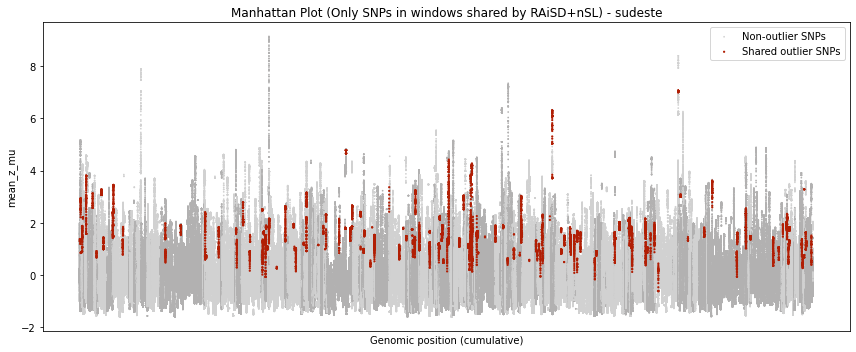

In [168]:
# Alternar colores por scaffold, etc.
colors = ['#d1d1d1', '#b2b1b1']  # Gris oscuro y gris claro
df_snps_in_shared_all_genes_mu['color_scaffold'] = df_snps_in_shared_all_genes_mu['chr_order'].cat.codes % 2

def assign_color(row):
    if row['is_outlier_shared']:
        return '#b11e04'  # Rojo si outlier en ambos
    else:
        return colors[row['color_scaffold']]

df_snps_in_shared_all_genes_mu['color'] = df_snps_in_shared_all_genes_mu.apply(assign_color, axis=1)

# Posición acumulada
df_snps_in_shared_all_genes_mu['cum_len'] = df_snps_in_shared_all_genes_mu.groupby('chr')['pos'].transform('max')
df_snps_in_shared_all_genes_mu['offset'] = (
    df_snps_in_shared_all_genes_mu.groupby('chr')['cum_len'].transform('first').cumsum()
    - df_snps_in_shared_all_genes_mu['cum_len']
)
df_snps_in_shared_all_genes_mu['cum_pos'] = (
    df_snps_in_shared_all_genes_mu['pos'] + df_snps_in_shared_all_genes_mu['offset']
)

# Plot
plt.figure(figsize=(12,5))

# Puntos no-outlier
plt.scatter(
    df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['cum_pos'],
    df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['mean_z_mu'],
    c=df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['color'],
    s=3, edgecolor='none', label='Non-outlier SNPs',
    zorder=1
)

# Puntos outlier (compartidos)
plt.scatter(
    df_snps_in_shared_all_genes_mu[df_snps_in_shared_all_genes_mu['is_outlier_shared']]['cum_pos'],
    df_snps_in_shared_all_genes_mu[df_snps_in_shared_all_genes_mu['is_outlier_shared']]['mean_z_mu'],
    c='#b11e04',  # rojo
    s=5, edgecolor='none', label='Shared outlier SNPs',
    zorder=2
)

plt.xticks([], [])
plt.xlabel("Genomic position (cumulative)")
plt.ylabel("mean_z_mu")
plt.title(f"Manhattan Plot (Only SNPs in windows shared by RAiSD+nSL) - {species_name}")

plt.tight_layout()
plt.legend()

# Guardar como PDF y PNG
output_pdf = f"{species_name}_manhattan_plot.pdf"
output_png = f"{species_name}_manhattan_plot.png"

plt.savefig(output_pdf, dpi=600, bbox_inches='tight')
plt.savefig(output_png, dpi=600, bbox_inches='tight')

plt.show()

## NORTHERN GENTOO PENGUIN

##### 1. LOAD DATA

In [169]:
species_name = "norte"

# Archivos de entrada
raisd_file = f"raisd_{species_name}_polarizado_reports.txt"
nsl_file   = f"{species_name}_nsl_10kb.norm"
vcf_file   = f"{species_name}_all_snps.bed"
gtf_file   = "GCA_010090195.1_genomic.gtf"

In [170]:
# Cargar RAiSD y nSL
raisd = pd.read_csv(raisd_file, sep='\t', low_memory=False)
raisd.columns = ['chr', 'pos', 'win_start', 'win_end', 'var', 'sfs', 'ld', 'mu']

In [171]:
nsl = pd.read_csv(nsl_file, sep='\t', low_memory=False)
nsl.columns = ['chr','pos','allfreq1','SL1','SL0','raw_nSL','norm_nSL','nsl_over_critval']
nsl['win_end'] = nsl['pos'] + 10000  # ventanas 10kb

In [172]:
# Add .1 to scaffold name
raisd['chr'] = raisd['chr'].astype(str) + '.1'
nsl['chr']   = nsl['chr'].astype(str) + '.1'

In [173]:
# BED of SNPs
vcf_bed = pd.read_csv(vcf_file, sep='\t', names=["chr","pos","end"])

In [174]:
vcf_bed

chr   pos   end
0         VUKY01000001.1    60    60
1         VUKY01000001.1   190   190
2         VUKY01000001.1   342   342
3         VUKY01000001.1   426   426
4         VUKY01000001.1   467   467
...                  ...   ...   ...
11032740  VUKY01018750.1  2361  2361
11032741  VUKY01018750.1  2362  2362
11032742  VUKY01018750.1  2383  2383
11032743  VUKY01018750.1  2390  2390
11032744  VUKY01018750.1  2465  2465

[11032745 rows x 3 columns]

In [175]:
# import GTF
gtf_data = pd.read_csv(
    gtf_file, sep='\t',
    comment='#', header=None,
    names=['Chromosome','Source','Feature','Start','End','Score','Strand','Frame','Attribute']
)

##### 2. Define threshold and RAiSD and nSL outlier

In [176]:
# Normalizar mu en RAiSD => z_mu
mean_mu = raisd['mu'].mean()
std_mu  = raisd['mu'].std()
raisd['z_mu'] = (raisd['mu'] - mean_mu) / std_mu

In [177]:
# Threshold (top 1%)
threshold_raisd      = raisd['z_mu'].quantile(0.99)
threshold_nsl_high   = nsl['norm_nSL'].quantile(0.99)
threshold_nsl_low    = nsl['norm_nSL'].quantile(0.01)

In [178]:
# Filtrar ventanas outlier
raisd_out = raisd[ raisd['z_mu'] >= threshold_raisd ]
nsl_out   = nsl[ (nsl['norm_nSL'] >= threshold_nsl_high) | (nsl['norm_nSL'] <= threshold_nsl_low) ]

##### 3. Intersect RAiSD and nSL dataframe

In [179]:
raisd_all = raisd.copy()
nsl_all   = nsl.copy()

In [180]:
# Convert to PyRanges
raisd_all_pr = pr.PyRanges(
    raisd_all.rename(columns={'chr': 'Chromosome', 'win_start': 'Start', 'win_end': 'End'})
)

In [181]:
nsl_all_pr = pr.PyRanges(
    nsl_all.rename(columns={'chr': 'Chromosome', 'pos': 'Start', 'win_end': 'End'})
)

In [182]:
# Intersect all windows and remove not shared genomic regions
shared_all_pr = raisd_all_pr.intersect(nsl_all_pr)
print(len(shared_all_pr.df))  

68756066


In [183]:
# Merge windows
merged_shared_all_pr = shared_all_pr.merge()
df_shared_all = merged_shared_all_pr.df
print(len(df_shared_all))  

14007


In [184]:
df_shared_all_pr = pr.PyRanges(df_shared_all)
df_shared_all_pr

+----------------+-----------+-----------+
| Chromosome     | Start     | End       |
| (category)     | (int64)   | (int64)   |
|----------------+-----------+-----------|
| VUKY01000002.1 | 27892     | 79854     |
| VUKY01000002.1 | 80476     | 212208    |
| VUKY01000002.1 | 215489    | 265326    |
| VUKY01000002.1 | 265676    | 275676    |
| ...            | ...       | ...       |
| VUKY01018721.1 | 6338126   | 6449016   |
| VUKY01018721.1 | 6304989   | 6329643   |
| VUKY01018721.1 | 6186007   | 6287965   |
| VUKY01018721.1 | 5795654   | 6178259   |
| VUKY01018732.1 | 26171     | 71939     |
| VUKY01018737.1 | 667       | 10848     |
+----------------+-----------+-----------+
Unstranded PyRanges object has 14,007 rows and 3 columns from 1396 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

##### 4. FIlter only SNPs within shared windows

In [185]:
# snps_pr with all SNPs
df_vcf = vcf_bed.rename(columns={"chr":"Chromosome"})
df_vcf["Start"] = df_vcf["pos"]
df_vcf["End"]   = df_vcf["pos"]
snps_pr = pr.PyRanges(df_vcf)

In [186]:
df_snps_in_shared_all_list = []

for scaf in snps_pr.chromosomes:
    print(f"Processing {scaf}")

    # 1) Subset of snps_pr for this scaffold
    snps_sub = snps_pr[scaf]
    # 2) Subset of df_shared_all_pr for this scaffold
    shared_sub = df_shared_all_pr[scaf]

    # 3) Intersect
    if snps_sub and shared_sub:
        intersection_sub = snps_sub.intersect(shared_sub)
        df_sub = intersection_sub.df
        df_snps_in_shared_all_list.append(df_sub)
    else:
        print(f"No data for scaffold {scaf}")

# Combine
if len(df_snps_in_shared_all_list) > 0:
    df_snps_in_shared_all = pd.concat(df_snps_in_shared_all_list, ignore_index=True)
else:
    df_snps_in_shared_all = pd.DataFrame()


Processing VUKY01000001.1
No data for scaffold VUKY01000001.1
Processing VUKY01000002.1
Processing VUKY01000004.1
No data for scaffold VUKY01000004.1
Processing VUKY01000005.1
No data for scaffold VUKY01000005.1
Processing VUKY01000006.1
No data for scaffold VUKY01000006.1
Processing VUKY01000007.1
No data for scaffold VUKY01000007.1
Processing VUKY01000008.1
No data for scaffold VUKY01000008.1
Processing VUKY01000009.1
No data for scaffold VUKY01000009.1
Processing VUKY01000010.1
No data for scaffold VUKY01000010.1
Processing VUKY01000013.1
No data for scaffold VUKY01000013.1
Processing VUKY01000015.1
No data for scaffold VUKY01000015.1
Processing VUKY01000018.1
No data for scaffold VUKY01000018.1
Processing VUKY01000019.1
No data for scaffold VUKY01000019.1
Processing VUKY01000020.1
No data for scaffold VUKY01000020.1
Processing VUKY01000021.1
No data for scaffold VUKY01000021.1
Processing VUKY01000022.1
No data for scaffold VUKY01000022.1
Processing VUKY01000024.1
No data for scaffo

No data for scaffold VUKY01000209.1
Processing VUKY01000210.1
No data for scaffold VUKY01000210.1
Processing VUKY01000213.1
No data for scaffold VUKY01000213.1
Processing VUKY01000216.1
No data for scaffold VUKY01000216.1
Processing VUKY01000218.1
No data for scaffold VUKY01000218.1
Processing VUKY01000220.1
No data for scaffold VUKY01000220.1
Processing VUKY01000221.1
No data for scaffold VUKY01000221.1
Processing VUKY01000222.1
No data for scaffold VUKY01000222.1
Processing VUKY01000223.1
No data for scaffold VUKY01000223.1
Processing VUKY01000224.1
No data for scaffold VUKY01000224.1
Processing VUKY01000227.1
No data for scaffold VUKY01000227.1
Processing VUKY01000228.1
No data for scaffold VUKY01000228.1
Processing VUKY01000229.1
No data for scaffold VUKY01000229.1
Processing VUKY01000230.1
No data for scaffold VUKY01000230.1
Processing VUKY01000232.1
No data for scaffold VUKY01000232.1
Processing VUKY01000233.1
Processing VUKY01000234.1
No data for scaffold VUKY01000234.1
Processi

No data for scaffold VUKY01000422.1
Processing VUKY01000423.1
No data for scaffold VUKY01000423.1
Processing VUKY01000425.1
No data for scaffold VUKY01000425.1
Processing VUKY01000426.1
No data for scaffold VUKY01000426.1
Processing VUKY01000428.1
No data for scaffold VUKY01000428.1
Processing VUKY01000429.1
No data for scaffold VUKY01000429.1
Processing VUKY01000430.1
No data for scaffold VUKY01000430.1
Processing VUKY01000433.1
No data for scaffold VUKY01000433.1
Processing VUKY01000434.1
No data for scaffold VUKY01000434.1
Processing VUKY01000436.1
No data for scaffold VUKY01000436.1
Processing VUKY01000437.1
No data for scaffold VUKY01000437.1
Processing VUKY01000438.1
No data for scaffold VUKY01000438.1
Processing VUKY01000439.1
No data for scaffold VUKY01000439.1
Processing VUKY01000441.1
No data for scaffold VUKY01000441.1
Processing VUKY01000442.1
No data for scaffold VUKY01000442.1
Processing VUKY01000443.1
No data for scaffold VUKY01000443.1
Processing VUKY01000444.1
No data 

No data for scaffold VUKY01000631.1
Processing VUKY01000632.1
No data for scaffold VUKY01000632.1
Processing VUKY01000634.1
No data for scaffold VUKY01000634.1
Processing VUKY01000635.1
No data for scaffold VUKY01000635.1
Processing VUKY01000636.1
No data for scaffold VUKY01000636.1
Processing VUKY01000638.1
No data for scaffold VUKY01000638.1
Processing VUKY01000639.1
No data for scaffold VUKY01000639.1
Processing VUKY01000640.1
No data for scaffold VUKY01000640.1
Processing VUKY01000642.1
No data for scaffold VUKY01000642.1
Processing VUKY01000644.1
Processing VUKY01000645.1
No data for scaffold VUKY01000645.1
Processing VUKY01000646.1
No data for scaffold VUKY01000646.1
Processing VUKY01000647.1
No data for scaffold VUKY01000647.1
Processing VUKY01000648.1
No data for scaffold VUKY01000648.1
Processing VUKY01000649.1
No data for scaffold VUKY01000649.1
Processing VUKY01000650.1
No data for scaffold VUKY01000650.1
Processing VUKY01000652.1
No data for scaffold VUKY01000652.1
Processi

No data for scaffold VUKY01000845.1
Processing VUKY01000846.1
No data for scaffold VUKY01000846.1
Processing VUKY01000847.1
No data for scaffold VUKY01000847.1
Processing VUKY01000848.1
Processing VUKY01000849.1
No data for scaffold VUKY01000849.1
Processing VUKY01000850.1
No data for scaffold VUKY01000850.1
Processing VUKY01000851.1
No data for scaffold VUKY01000851.1
Processing VUKY01000852.1
No data for scaffold VUKY01000852.1
Processing VUKY01000853.1
No data for scaffold VUKY01000853.1
Processing VUKY01000855.1
No data for scaffold VUKY01000855.1
Processing VUKY01000856.1
No data for scaffold VUKY01000856.1
Processing VUKY01000857.1
No data for scaffold VUKY01000857.1
Processing VUKY01000858.1
No data for scaffold VUKY01000858.1
Processing VUKY01000859.1
No data for scaffold VUKY01000859.1
Processing VUKY01000860.1
Processing VUKY01000862.1
No data for scaffold VUKY01000862.1
Processing VUKY01000863.1
No data for scaffold VUKY01000863.1
Processing VUKY01000864.1
No data for scaffo

No data for scaffold VUKY01001055.1
Processing VUKY01001056.1
No data for scaffold VUKY01001056.1
Processing VUKY01001057.1
No data for scaffold VUKY01001057.1
Processing VUKY01001059.1
No data for scaffold VUKY01001059.1
Processing VUKY01001060.1
No data for scaffold VUKY01001060.1
Processing VUKY01001061.1
No data for scaffold VUKY01001061.1
Processing VUKY01001062.1
No data for scaffold VUKY01001062.1
Processing VUKY01001063.1
No data for scaffold VUKY01001063.1
Processing VUKY01001064.1
Processing VUKY01001065.1
Processing VUKY01001066.1
No data for scaffold VUKY01001066.1
Processing VUKY01001068.1
No data for scaffold VUKY01001068.1
Processing VUKY01001073.1
No data for scaffold VUKY01001073.1
Processing VUKY01001075.1
No data for scaffold VUKY01001075.1
Processing VUKY01001077.1
No data for scaffold VUKY01001077.1
Processing VUKY01001078.1
No data for scaffold VUKY01001078.1
Processing VUKY01001079.1
No data for scaffold VUKY01001079.1
Processing VUKY01001081.1
No data for scaffo

No data for scaffold VUKY01001259.1
Processing VUKY01001260.1
No data for scaffold VUKY01001260.1
Processing VUKY01001262.1
No data for scaffold VUKY01001262.1
Processing VUKY01001263.1
Processing VUKY01001264.1
No data for scaffold VUKY01001264.1
Processing VUKY01001265.1
No data for scaffold VUKY01001265.1
Processing VUKY01001266.1
No data for scaffold VUKY01001266.1
Processing VUKY01001267.1
No data for scaffold VUKY01001267.1
Processing VUKY01001270.1
No data for scaffold VUKY01001270.1
Processing VUKY01001275.1
No data for scaffold VUKY01001275.1
Processing VUKY01001277.1
No data for scaffold VUKY01001277.1
Processing VUKY01001279.1
No data for scaffold VUKY01001279.1
Processing VUKY01001280.1
No data for scaffold VUKY01001280.1
Processing VUKY01001281.1
No data for scaffold VUKY01001281.1
Processing VUKY01001282.1
No data for scaffold VUKY01001282.1
Processing VUKY01001283.1
No data for scaffold VUKY01001283.1
Processing VUKY01001284.1
No data for scaffold VUKY01001284.1
Processi

No data for scaffold VUKY01001502.1
Processing VUKY01001503.1
No data for scaffold VUKY01001503.1
Processing VUKY01001504.1
No data for scaffold VUKY01001504.1
Processing VUKY01001505.1
Processing VUKY01001507.1
No data for scaffold VUKY01001507.1
Processing VUKY01001508.1
Processing VUKY01001509.1
No data for scaffold VUKY01001509.1
Processing VUKY01001510.1
No data for scaffold VUKY01001510.1
Processing VUKY01001511.1
No data for scaffold VUKY01001511.1
Processing VUKY01001512.1
No data for scaffold VUKY01001512.1
Processing VUKY01001513.1
No data for scaffold VUKY01001513.1
Processing VUKY01001514.1
No data for scaffold VUKY01001514.1
Processing VUKY01001515.1
No data for scaffold VUKY01001515.1
Processing VUKY01001518.1
No data for scaffold VUKY01001518.1
Processing VUKY01001520.1
No data for scaffold VUKY01001520.1
Processing VUKY01001521.1
No data for scaffold VUKY01001521.1
Processing VUKY01001522.1
No data for scaffold VUKY01001522.1
Processing VUKY01001523.1
Processing VUKY010

No data for scaffold VUKY01001723.1
Processing VUKY01001724.1
No data for scaffold VUKY01001724.1
Processing VUKY01001725.1
No data for scaffold VUKY01001725.1
Processing VUKY01001727.1
Processing VUKY01001728.1
No data for scaffold VUKY01001728.1
Processing VUKY01001729.1
No data for scaffold VUKY01001729.1
Processing VUKY01001730.1
No data for scaffold VUKY01001730.1
Processing VUKY01001733.1
No data for scaffold VUKY01001733.1
Processing VUKY01001735.1
No data for scaffold VUKY01001735.1
Processing VUKY01001739.1
No data for scaffold VUKY01001739.1
Processing VUKY01001740.1
No data for scaffold VUKY01001740.1
Processing VUKY01001742.1
No data for scaffold VUKY01001742.1
Processing VUKY01001743.1
No data for scaffold VUKY01001743.1
Processing VUKY01001744.1
No data for scaffold VUKY01001744.1
Processing VUKY01001745.1
No data for scaffold VUKY01001745.1
Processing VUKY01001747.1
No data for scaffold VUKY01001747.1
Processing VUKY01001748.1
No data for scaffold VUKY01001748.1
Processi

No data for scaffold VUKY01001947.1
Processing VUKY01001948.1
No data for scaffold VUKY01001948.1
Processing VUKY01001949.1
No data for scaffold VUKY01001949.1
Processing VUKY01001951.1
No data for scaffold VUKY01001951.1
Processing VUKY01001952.1
No data for scaffold VUKY01001952.1
Processing VUKY01001954.1
No data for scaffold VUKY01001954.1
Processing VUKY01001956.1
No data for scaffold VUKY01001956.1
Processing VUKY01001957.1
No data for scaffold VUKY01001957.1
Processing VUKY01001958.1
No data for scaffold VUKY01001958.1
Processing VUKY01001961.1
No data for scaffold VUKY01001961.1
Processing VUKY01001962.1
No data for scaffold VUKY01001962.1
Processing VUKY01001963.1
No data for scaffold VUKY01001963.1
Processing VUKY01001965.1
No data for scaffold VUKY01001965.1
Processing VUKY01001968.1
No data for scaffold VUKY01001968.1
Processing VUKY01001970.1
No data for scaffold VUKY01001970.1
Processing VUKY01001971.1
No data for scaffold VUKY01001971.1
Processing VUKY01001972.1
No data 

No data for scaffold VUKY01002149.1
Processing VUKY01002152.1
No data for scaffold VUKY01002152.1
Processing VUKY01002153.1
Processing VUKY01002154.1
No data for scaffold VUKY01002154.1
Processing VUKY01002155.1
No data for scaffold VUKY01002155.1
Processing VUKY01002156.1
No data for scaffold VUKY01002156.1
Processing VUKY01002158.1
No data for scaffold VUKY01002158.1
Processing VUKY01002161.1
No data for scaffold VUKY01002161.1
Processing VUKY01002162.1
No data for scaffold VUKY01002162.1
Processing VUKY01002164.1
No data for scaffold VUKY01002164.1
Processing VUKY01002165.1
No data for scaffold VUKY01002165.1
Processing VUKY01002166.1
No data for scaffold VUKY01002166.1
Processing VUKY01002168.1
No data for scaffold VUKY01002168.1
Processing VUKY01002170.1
No data for scaffold VUKY01002170.1
Processing VUKY01002171.1
No data for scaffold VUKY01002171.1
Processing VUKY01002173.1
No data for scaffold VUKY01002173.1
Processing VUKY01002176.1
No data for scaffold VUKY01002176.1
Processi

No data for scaffold VUKY01002365.1
Processing VUKY01002367.1
No data for scaffold VUKY01002367.1
Processing VUKY01002369.1
No data for scaffold VUKY01002369.1
Processing VUKY01002370.1
No data for scaffold VUKY01002370.1
Processing VUKY01002372.1
No data for scaffold VUKY01002372.1
Processing VUKY01002373.1
No data for scaffold VUKY01002373.1
Processing VUKY01002374.1
No data for scaffold VUKY01002374.1
Processing VUKY01002375.1
No data for scaffold VUKY01002375.1
Processing VUKY01002376.1
No data for scaffold VUKY01002376.1
Processing VUKY01002377.1
No data for scaffold VUKY01002377.1
Processing VUKY01002378.1
No data for scaffold VUKY01002378.1
Processing VUKY01002379.1
No data for scaffold VUKY01002379.1
Processing VUKY01002380.1
No data for scaffold VUKY01002380.1
Processing VUKY01002381.1
No data for scaffold VUKY01002381.1
Processing VUKY01002383.1
No data for scaffold VUKY01002383.1
Processing VUKY01002384.1
No data for scaffold VUKY01002384.1
Processing VUKY01002385.1
No data 

No data for scaffold VUKY01002568.1
Processing VUKY01002572.1
No data for scaffold VUKY01002572.1
Processing VUKY01002573.1
No data for scaffold VUKY01002573.1
Processing VUKY01002576.1
Processing VUKY01002577.1
No data for scaffold VUKY01002577.1
Processing VUKY01002580.1
No data for scaffold VUKY01002580.1
Processing VUKY01002584.1
No data for scaffold VUKY01002584.1
Processing VUKY01002585.1
No data for scaffold VUKY01002585.1
Processing VUKY01002586.1
No data for scaffold VUKY01002586.1
Processing VUKY01002589.1
No data for scaffold VUKY01002589.1
Processing VUKY01002590.1
No data for scaffold VUKY01002590.1
Processing VUKY01002591.1
No data for scaffold VUKY01002591.1
Processing VUKY01002593.1
No data for scaffold VUKY01002593.1
Processing VUKY01002596.1
No data for scaffold VUKY01002596.1
Processing VUKY01002597.1
No data for scaffold VUKY01002597.1
Processing VUKY01002598.1
No data for scaffold VUKY01002598.1
Processing VUKY01002599.1
No data for scaffold VUKY01002599.1
Processi

No data for scaffold VUKY01002772.1
Processing VUKY01002774.1
No data for scaffold VUKY01002774.1
Processing VUKY01002776.1
No data for scaffold VUKY01002776.1
Processing VUKY01002778.1
No data for scaffold VUKY01002778.1
Processing VUKY01002779.1
No data for scaffold VUKY01002779.1
Processing VUKY01002782.1
Processing VUKY01002783.1
No data for scaffold VUKY01002783.1
Processing VUKY01002786.1
No data for scaffold VUKY01002786.1
Processing VUKY01002787.1
No data for scaffold VUKY01002787.1
Processing VUKY01002789.1
No data for scaffold VUKY01002789.1
Processing VUKY01002791.1
No data for scaffold VUKY01002791.1
Processing VUKY01002792.1
No data for scaffold VUKY01002792.1
Processing VUKY01002794.1
Processing VUKY01002795.1
No data for scaffold VUKY01002795.1
Processing VUKY01002796.1
No data for scaffold VUKY01002796.1
Processing VUKY01002797.1
No data for scaffold VUKY01002797.1
Processing VUKY01002798.1
Processing VUKY01002799.1
No data for scaffold VUKY01002799.1
Processing VUKY010

No data for scaffold VUKY01002973.1
Processing VUKY01002974.1
No data for scaffold VUKY01002974.1
Processing VUKY01002975.1
No data for scaffold VUKY01002975.1
Processing VUKY01002976.1
No data for scaffold VUKY01002976.1
Processing VUKY01002977.1
No data for scaffold VUKY01002977.1
Processing VUKY01002978.1
No data for scaffold VUKY01002978.1
Processing VUKY01002979.1
No data for scaffold VUKY01002979.1
Processing VUKY01002980.1
No data for scaffold VUKY01002980.1
Processing VUKY01002981.1
No data for scaffold VUKY01002981.1
Processing VUKY01002984.1
No data for scaffold VUKY01002984.1
Processing VUKY01002985.1
Processing VUKY01002988.1
No data for scaffold VUKY01002988.1
Processing VUKY01002989.1
No data for scaffold VUKY01002989.1
Processing VUKY01002991.1
No data for scaffold VUKY01002991.1
Processing VUKY01002992.1
No data for scaffold VUKY01002992.1
Processing VUKY01002993.1
No data for scaffold VUKY01002993.1
Processing VUKY01002994.1
No data for scaffold VUKY01002994.1
Processi

No data for scaffold VUKY01003198.1
Processing VUKY01003202.1
No data for scaffold VUKY01003202.1
Processing VUKY01003203.1
Processing VUKY01003204.1
No data for scaffold VUKY01003204.1
Processing VUKY01003205.1
No data for scaffold VUKY01003205.1
Processing VUKY01003209.1
No data for scaffold VUKY01003209.1
Processing VUKY01003210.1
No data for scaffold VUKY01003210.1
Processing VUKY01003211.1
Processing VUKY01003212.1
No data for scaffold VUKY01003212.1
Processing VUKY01003214.1
No data for scaffold VUKY01003214.1
Processing VUKY01003215.1
No data for scaffold VUKY01003215.1
Processing VUKY01003217.1
No data for scaffold VUKY01003217.1
Processing VUKY01003218.1
No data for scaffold VUKY01003218.1
Processing VUKY01003221.1
No data for scaffold VUKY01003221.1
Processing VUKY01003222.1
No data for scaffold VUKY01003222.1
Processing VUKY01003223.1
No data for scaffold VUKY01003223.1
Processing VUKY01003224.1
No data for scaffold VUKY01003224.1
Processing VUKY01003225.1
No data for scaffo

No data for scaffold VUKY01003423.1
Processing VUKY01003425.1
No data for scaffold VUKY01003425.1
Processing VUKY01003427.1
No data for scaffold VUKY01003427.1
Processing VUKY01003429.1
No data for scaffold VUKY01003429.1
Processing VUKY01003430.1
No data for scaffold VUKY01003430.1
Processing VUKY01003431.1
No data for scaffold VUKY01003431.1
Processing VUKY01003432.1
No data for scaffold VUKY01003432.1
Processing VUKY01003434.1
No data for scaffold VUKY01003434.1
Processing VUKY01003435.1
No data for scaffold VUKY01003435.1
Processing VUKY01003436.1
No data for scaffold VUKY01003436.1
Processing VUKY01003437.1
No data for scaffold VUKY01003437.1
Processing VUKY01003439.1
No data for scaffold VUKY01003439.1
Processing VUKY01003441.1
No data for scaffold VUKY01003441.1
Processing VUKY01003442.1
No data for scaffold VUKY01003442.1
Processing VUKY01003443.1
No data for scaffold VUKY01003443.1
Processing VUKY01003445.1
No data for scaffold VUKY01003445.1
Processing VUKY01003448.1
No data 

No data for scaffold VUKY01003623.1
Processing VUKY01003625.1
Processing VUKY01003626.1
No data for scaffold VUKY01003626.1
Processing VUKY01003627.1
No data for scaffold VUKY01003627.1
Processing VUKY01003628.1
No data for scaffold VUKY01003628.1
Processing VUKY01003629.1
Processing VUKY01003631.1
No data for scaffold VUKY01003631.1
Processing VUKY01003632.1
Processing VUKY01003634.1
No data for scaffold VUKY01003634.1
Processing VUKY01003637.1
No data for scaffold VUKY01003637.1
Processing VUKY01003639.1
No data for scaffold VUKY01003639.1
Processing VUKY01003640.1
No data for scaffold VUKY01003640.1
Processing VUKY01003642.1
No data for scaffold VUKY01003642.1
Processing VUKY01003643.1
No data for scaffold VUKY01003643.1
Processing VUKY01003646.1
No data for scaffold VUKY01003646.1
Processing VUKY01003651.1
No data for scaffold VUKY01003651.1
Processing VUKY01003652.1
No data for scaffold VUKY01003652.1
Processing VUKY01003654.1
No data for scaffold VUKY01003654.1
Processing VUKY010

No data for scaffold VUKY01003851.1
Processing VUKY01003852.1
No data for scaffold VUKY01003852.1
Processing VUKY01003855.1
No data for scaffold VUKY01003855.1
Processing VUKY01003857.1
No data for scaffold VUKY01003857.1
Processing VUKY01003859.1
No data for scaffold VUKY01003859.1
Processing VUKY01003860.1
Processing VUKY01003862.1
No data for scaffold VUKY01003862.1
Processing VUKY01003867.1
No data for scaffold VUKY01003867.1
Processing VUKY01003870.1
No data for scaffold VUKY01003870.1
Processing VUKY01003871.1
No data for scaffold VUKY01003871.1
Processing VUKY01003875.1
No data for scaffold VUKY01003875.1
Processing VUKY01003876.1
No data for scaffold VUKY01003876.1
Processing VUKY01003877.1
No data for scaffold VUKY01003877.1
Processing VUKY01003878.1
No data for scaffold VUKY01003878.1
Processing VUKY01003881.1
No data for scaffold VUKY01003881.1
Processing VUKY01003882.1
No data for scaffold VUKY01003882.1
Processing VUKY01003883.1
No data for scaffold VUKY01003883.1
Processi

No data for scaffold VUKY01004070.1
Processing VUKY01004071.1
No data for scaffold VUKY01004071.1
Processing VUKY01004072.1
No data for scaffold VUKY01004072.1
Processing VUKY01004074.1
No data for scaffold VUKY01004074.1
Processing VUKY01004075.1
No data for scaffold VUKY01004075.1
Processing VUKY01004076.1
No data for scaffold VUKY01004076.1
Processing VUKY01004077.1
No data for scaffold VUKY01004077.1
Processing VUKY01004078.1
No data for scaffold VUKY01004078.1
Processing VUKY01004079.1
No data for scaffold VUKY01004079.1
Processing VUKY01004080.1
No data for scaffold VUKY01004080.1
Processing VUKY01004081.1
No data for scaffold VUKY01004081.1
Processing VUKY01004082.1
No data for scaffold VUKY01004082.1
Processing VUKY01004083.1
No data for scaffold VUKY01004083.1
Processing VUKY01004084.1
No data for scaffold VUKY01004084.1
Processing VUKY01004085.1
No data for scaffold VUKY01004085.1
Processing VUKY01004086.1
No data for scaffold VUKY01004086.1
Processing VUKY01004087.1
No data 

No data for scaffold VUKY01004280.1
Processing VUKY01004282.1
No data for scaffold VUKY01004282.1
Processing VUKY01004283.1
No data for scaffold VUKY01004283.1
Processing VUKY01004284.1
No data for scaffold VUKY01004284.1
Processing VUKY01004285.1
No data for scaffold VUKY01004285.1
Processing VUKY01004286.1
No data for scaffold VUKY01004286.1
Processing VUKY01004287.1
Processing VUKY01004288.1
Processing VUKY01004291.1
No data for scaffold VUKY01004291.1
Processing VUKY01004292.1
No data for scaffold VUKY01004292.1
Processing VUKY01004294.1
No data for scaffold VUKY01004294.1
Processing VUKY01004297.1
No data for scaffold VUKY01004297.1
Processing VUKY01004298.1
No data for scaffold VUKY01004298.1
Processing VUKY01004299.1
No data for scaffold VUKY01004299.1
Processing VUKY01004300.1
No data for scaffold VUKY01004300.1
Processing VUKY01004302.1
No data for scaffold VUKY01004302.1
Processing VUKY01004304.1
No data for scaffold VUKY01004304.1
Processing VUKY01004307.1
No data for scaffo

No data for scaffold VUKY01004495.1
Processing VUKY01004497.1
No data for scaffold VUKY01004497.1
Processing VUKY01004498.1
No data for scaffold VUKY01004498.1
Processing VUKY01004500.1
No data for scaffold VUKY01004500.1
Processing VUKY01004501.1
No data for scaffold VUKY01004501.1
Processing VUKY01004503.1
No data for scaffold VUKY01004503.1
Processing VUKY01004504.1
No data for scaffold VUKY01004504.1
Processing VUKY01004509.1
No data for scaffold VUKY01004509.1
Processing VUKY01004510.1
Processing VUKY01004511.1
No data for scaffold VUKY01004511.1
Processing VUKY01004512.1
No data for scaffold VUKY01004512.1
Processing VUKY01004515.1
No data for scaffold VUKY01004515.1
Processing VUKY01004516.1
No data for scaffold VUKY01004516.1
Processing VUKY01004517.1
No data for scaffold VUKY01004517.1
Processing VUKY01004518.1
No data for scaffold VUKY01004518.1
Processing VUKY01004519.1
No data for scaffold VUKY01004519.1
Processing VUKY01004520.1
No data for scaffold VUKY01004520.1
Processi

No data for scaffold VUKY01004714.1
Processing VUKY01004717.1
Processing VUKY01004718.1
No data for scaffold VUKY01004718.1
Processing VUKY01004719.1
No data for scaffold VUKY01004719.1
Processing VUKY01004721.1
No data for scaffold VUKY01004721.1
Processing VUKY01004723.1
Processing VUKY01004724.1
No data for scaffold VUKY01004724.1
Processing VUKY01004725.1
No data for scaffold VUKY01004725.1
Processing VUKY01004726.1
No data for scaffold VUKY01004726.1
Processing VUKY01004728.1
No data for scaffold VUKY01004728.1
Processing VUKY01004729.1
No data for scaffold VUKY01004729.1
Processing VUKY01004730.1
Processing VUKY01004731.1
No data for scaffold VUKY01004731.1
Processing VUKY01004732.1
No data for scaffold VUKY01004732.1
Processing VUKY01004734.1
No data for scaffold VUKY01004734.1
Processing VUKY01004735.1
No data for scaffold VUKY01004735.1
Processing VUKY01004736.1
No data for scaffold VUKY01004736.1
Processing VUKY01004738.1
Processing VUKY01004739.1
No data for scaffold VUKY010

No data for scaffold VUKY01004938.1
Processing VUKY01004939.1
No data for scaffold VUKY01004939.1
Processing VUKY01004940.1
No data for scaffold VUKY01004940.1
Processing VUKY01004941.1
No data for scaffold VUKY01004941.1
Processing VUKY01004942.1
No data for scaffold VUKY01004942.1
Processing VUKY01004943.1
No data for scaffold VUKY01004943.1
Processing VUKY01004944.1
No data for scaffold VUKY01004944.1
Processing VUKY01004947.1
No data for scaffold VUKY01004947.1
Processing VUKY01004948.1
No data for scaffold VUKY01004948.1
Processing VUKY01004950.1
No data for scaffold VUKY01004950.1
Processing VUKY01004951.1
Processing VUKY01004952.1
No data for scaffold VUKY01004952.1
Processing VUKY01004954.1
No data for scaffold VUKY01004954.1
Processing VUKY01004955.1
No data for scaffold VUKY01004955.1
Processing VUKY01004957.1
No data for scaffold VUKY01004957.1
Processing VUKY01004959.1
No data for scaffold VUKY01004959.1
Processing VUKY01004960.1
No data for scaffold VUKY01004960.1
Processi

No data for scaffold VUKY01005152.1
Processing VUKY01005153.1
No data for scaffold VUKY01005153.1
Processing VUKY01005154.1
No data for scaffold VUKY01005154.1
Processing VUKY01005156.1
No data for scaffold VUKY01005156.1
Processing VUKY01005157.1
No data for scaffold VUKY01005157.1
Processing VUKY01005158.1
No data for scaffold VUKY01005158.1
Processing VUKY01005159.1
No data for scaffold VUKY01005159.1
Processing VUKY01005163.1
No data for scaffold VUKY01005163.1
Processing VUKY01005165.1
No data for scaffold VUKY01005165.1
Processing VUKY01005166.1
No data for scaffold VUKY01005166.1
Processing VUKY01005168.1
No data for scaffold VUKY01005168.1
Processing VUKY01005172.1
No data for scaffold VUKY01005172.1
Processing VUKY01005174.1
No data for scaffold VUKY01005174.1
Processing VUKY01005176.1
No data for scaffold VUKY01005176.1
Processing VUKY01005178.1
No data for scaffold VUKY01005178.1
Processing VUKY01005182.1
No data for scaffold VUKY01005182.1
Processing VUKY01005186.1
Processi

Processing VUKY01005365.1
No data for scaffold VUKY01005365.1
Processing VUKY01005366.1
No data for scaffold VUKY01005366.1
Processing VUKY01005367.1
No data for scaffold VUKY01005367.1
Processing VUKY01005369.1
Processing VUKY01005370.1
No data for scaffold VUKY01005370.1
Processing VUKY01005371.1
No data for scaffold VUKY01005371.1
Processing VUKY01005372.1
No data for scaffold VUKY01005372.1
Processing VUKY01005373.1
No data for scaffold VUKY01005373.1
Processing VUKY01005374.1
No data for scaffold VUKY01005374.1
Processing VUKY01005377.1
No data for scaffold VUKY01005377.1
Processing VUKY01005382.1
No data for scaffold VUKY01005382.1
Processing VUKY01005383.1
No data for scaffold VUKY01005383.1
Processing VUKY01005384.1
No data for scaffold VUKY01005384.1
Processing VUKY01005386.1
Processing VUKY01005387.1
No data for scaffold VUKY01005387.1
Processing VUKY01005388.1
No data for scaffold VUKY01005388.1
Processing VUKY01005390.1
No data for scaffold VUKY01005390.1
Processing VUKY010

No data for scaffold VUKY01005555.1
Processing VUKY01005556.1
No data for scaffold VUKY01005556.1
Processing VUKY01005558.1
No data for scaffold VUKY01005558.1
Processing VUKY01005560.1
No data for scaffold VUKY01005560.1
Processing VUKY01005562.1
No data for scaffold VUKY01005562.1
Processing VUKY01005564.1
Processing VUKY01005565.1
No data for scaffold VUKY01005565.1
Processing VUKY01005566.1
No data for scaffold VUKY01005566.1
Processing VUKY01005567.1
No data for scaffold VUKY01005567.1
Processing VUKY01005569.1
No data for scaffold VUKY01005569.1
Processing VUKY01005570.1
No data for scaffold VUKY01005570.1
Processing VUKY01005571.1
No data for scaffold VUKY01005571.1
Processing VUKY01005572.1
No data for scaffold VUKY01005572.1
Processing VUKY01005573.1
No data for scaffold VUKY01005573.1
Processing VUKY01005574.1
No data for scaffold VUKY01005574.1
Processing VUKY01005575.1
No data for scaffold VUKY01005575.1
Processing VUKY01005577.1
No data for scaffold VUKY01005577.1
Processi

No data for scaffold VUKY01005764.1
Processing VUKY01005765.1
No data for scaffold VUKY01005765.1
Processing VUKY01005767.1
Processing VUKY01005768.1
No data for scaffold VUKY01005768.1
Processing VUKY01005769.1
Processing VUKY01005771.1
No data for scaffold VUKY01005771.1
Processing VUKY01005772.1
No data for scaffold VUKY01005772.1
Processing VUKY01005773.1
No data for scaffold VUKY01005773.1
Processing VUKY01005774.1
Processing VUKY01005775.1
No data for scaffold VUKY01005775.1
Processing VUKY01005779.1
No data for scaffold VUKY01005779.1
Processing VUKY01005780.1
No data for scaffold VUKY01005780.1
Processing VUKY01005781.1
No data for scaffold VUKY01005781.1
Processing VUKY01005783.1
No data for scaffold VUKY01005783.1
Processing VUKY01005784.1
No data for scaffold VUKY01005784.1
Processing VUKY01005786.1
No data for scaffold VUKY01005786.1
Processing VUKY01005787.1
No data for scaffold VUKY01005787.1
Processing VUKY01005789.1
No data for scaffold VUKY01005789.1
Processing VUKY010

No data for scaffold VUKY01005967.1
Processing VUKY01005968.1
Processing VUKY01005970.1
No data for scaffold VUKY01005970.1
Processing VUKY01005971.1
No data for scaffold VUKY01005971.1
Processing VUKY01005974.1
No data for scaffold VUKY01005974.1
Processing VUKY01005975.1
No data for scaffold VUKY01005975.1
Processing VUKY01005977.1
Processing VUKY01005978.1
No data for scaffold VUKY01005978.1
Processing VUKY01005979.1
No data for scaffold VUKY01005979.1
Processing VUKY01005980.1
No data for scaffold VUKY01005980.1
Processing VUKY01005981.1
No data for scaffold VUKY01005981.1
Processing VUKY01005983.1
No data for scaffold VUKY01005983.1
Processing VUKY01005984.1
No data for scaffold VUKY01005984.1
Processing VUKY01005985.1
No data for scaffold VUKY01005985.1
Processing VUKY01005986.1
No data for scaffold VUKY01005986.1
Processing VUKY01005987.1
No data for scaffold VUKY01005987.1
Processing VUKY01005989.1
No data for scaffold VUKY01005989.1
Processing VUKY01005990.1
No data for scaffo

No data for scaffold VUKY01006164.1
Processing VUKY01006165.1
No data for scaffold VUKY01006165.1
Processing VUKY01006166.1
No data for scaffold VUKY01006166.1
Processing VUKY01006167.1
Processing VUKY01006168.1
No data for scaffold VUKY01006168.1
Processing VUKY01006169.1
No data for scaffold VUKY01006169.1
Processing VUKY01006171.1
No data for scaffold VUKY01006171.1
Processing VUKY01006172.1
Processing VUKY01006173.1
No data for scaffold VUKY01006173.1
Processing VUKY01006174.1
No data for scaffold VUKY01006174.1
Processing VUKY01006175.1
No data for scaffold VUKY01006175.1
Processing VUKY01006176.1
No data for scaffold VUKY01006176.1
Processing VUKY01006177.1
No data for scaffold VUKY01006177.1
Processing VUKY01006180.1
No data for scaffold VUKY01006180.1
Processing VUKY01006181.1
No data for scaffold VUKY01006181.1
Processing VUKY01006182.1
No data for scaffold VUKY01006182.1
Processing VUKY01006184.1
No data for scaffold VUKY01006184.1
Processing VUKY01006186.1
Processing VUKY010

No data for scaffold VUKY01006355.1
Processing VUKY01006360.1
No data for scaffold VUKY01006360.1
Processing VUKY01006363.1
No data for scaffold VUKY01006363.1
Processing VUKY01006365.1
No data for scaffold VUKY01006365.1
Processing VUKY01006366.1
No data for scaffold VUKY01006366.1
Processing VUKY01006368.1
No data for scaffold VUKY01006368.1
Processing VUKY01006369.1
No data for scaffold VUKY01006369.1
Processing VUKY01006370.1
No data for scaffold VUKY01006370.1
Processing VUKY01006371.1
No data for scaffold VUKY01006371.1
Processing VUKY01006372.1
No data for scaffold VUKY01006372.1
Processing VUKY01006373.1
No data for scaffold VUKY01006373.1
Processing VUKY01006374.1
No data for scaffold VUKY01006374.1
Processing VUKY01006376.1
No data for scaffold VUKY01006376.1
Processing VUKY01006379.1
No data for scaffold VUKY01006379.1
Processing VUKY01006381.1
Processing VUKY01006382.1
Processing VUKY01006383.1
No data for scaffold VUKY01006383.1
Processing VUKY01006388.1
No data for scaffo

Processing VUKY01006572.1
No data for scaffold VUKY01006572.1
Processing VUKY01006573.1
No data for scaffold VUKY01006573.1
Processing VUKY01006574.1
No data for scaffold VUKY01006574.1
Processing VUKY01006576.1
No data for scaffold VUKY01006576.1
Processing VUKY01006577.1
No data for scaffold VUKY01006577.1
Processing VUKY01006578.1
No data for scaffold VUKY01006578.1
Processing VUKY01006579.1
No data for scaffold VUKY01006579.1
Processing VUKY01006580.1
No data for scaffold VUKY01006580.1
Processing VUKY01006581.1
No data for scaffold VUKY01006581.1
Processing VUKY01006582.1
No data for scaffold VUKY01006582.1
Processing VUKY01006584.1
No data for scaffold VUKY01006584.1
Processing VUKY01006585.1
Processing VUKY01006586.1
Processing VUKY01006587.1
No data for scaffold VUKY01006587.1
Processing VUKY01006588.1
No data for scaffold VUKY01006588.1
Processing VUKY01006589.1
No data for scaffold VUKY01006589.1
Processing VUKY01006590.1
No data for scaffold VUKY01006590.1
Processing VUKY010

Processing VUKY01006778.1
No data for scaffold VUKY01006778.1
Processing VUKY01006779.1
No data for scaffold VUKY01006779.1
Processing VUKY01006780.1
No data for scaffold VUKY01006780.1
Processing VUKY01006782.1
No data for scaffold VUKY01006782.1
Processing VUKY01006783.1
No data for scaffold VUKY01006783.1
Processing VUKY01006784.1
No data for scaffold VUKY01006784.1
Processing VUKY01006785.1
Processing VUKY01006786.1
Processing VUKY01006787.1
No data for scaffold VUKY01006787.1
Processing VUKY01006788.1
No data for scaffold VUKY01006788.1
Processing VUKY01006790.1
No data for scaffold VUKY01006790.1
Processing VUKY01006792.1
No data for scaffold VUKY01006792.1
Processing VUKY01006793.1
No data for scaffold VUKY01006793.1
Processing VUKY01006795.1
No data for scaffold VUKY01006795.1
Processing VUKY01006796.1
No data for scaffold VUKY01006796.1
Processing VUKY01006797.1
No data for scaffold VUKY01006797.1
Processing VUKY01006798.1
No data for scaffold VUKY01006798.1
Processing VUKY010

No data for scaffold VUKY01007001.1
Processing VUKY01007003.1
No data for scaffold VUKY01007003.1
Processing VUKY01007007.1
No data for scaffold VUKY01007007.1
Processing VUKY01007008.1
No data for scaffold VUKY01007008.1
Processing VUKY01007009.1
No data for scaffold VUKY01007009.1
Processing VUKY01007013.1
No data for scaffold VUKY01007013.1
Processing VUKY01007015.1
No data for scaffold VUKY01007015.1
Processing VUKY01007017.1
No data for scaffold VUKY01007017.1
Processing VUKY01007018.1
No data for scaffold VUKY01007018.1
Processing VUKY01007019.1
Processing VUKY01007021.1
No data for scaffold VUKY01007021.1
Processing VUKY01007024.1
No data for scaffold VUKY01007024.1
Processing VUKY01007026.1
No data for scaffold VUKY01007026.1
Processing VUKY01007029.1
No data for scaffold VUKY01007029.1
Processing VUKY01007030.1
No data for scaffold VUKY01007030.1
Processing VUKY01007032.1
No data for scaffold VUKY01007032.1
Processing VUKY01007033.1
No data for scaffold VUKY01007033.1
Processi

No data for scaffold VUKY01007222.1
Processing VUKY01007225.1
No data for scaffold VUKY01007225.1
Processing VUKY01007228.1
No data for scaffold VUKY01007228.1
Processing VUKY01007231.1
No data for scaffold VUKY01007231.1
Processing VUKY01007232.1
No data for scaffold VUKY01007232.1
Processing VUKY01007236.1
No data for scaffold VUKY01007236.1
Processing VUKY01007237.1
No data for scaffold VUKY01007237.1
Processing VUKY01007238.1
No data for scaffold VUKY01007238.1
Processing VUKY01007243.1
No data for scaffold VUKY01007243.1
Processing VUKY01007244.1
No data for scaffold VUKY01007244.1
Processing VUKY01007245.1
Processing VUKY01007247.1
No data for scaffold VUKY01007247.1
Processing VUKY01007248.1
Processing VUKY01007249.1
No data for scaffold VUKY01007249.1
Processing VUKY01007250.1
No data for scaffold VUKY01007250.1
Processing VUKY01007252.1
No data for scaffold VUKY01007252.1
Processing VUKY01007253.1
No data for scaffold VUKY01007253.1
Processing VUKY01007255.1
No data for scaffo

No data for scaffold VUKY01007434.1
Processing VUKY01007435.1
No data for scaffold VUKY01007435.1
Processing VUKY01007436.1
No data for scaffold VUKY01007436.1
Processing VUKY01007437.1
No data for scaffold VUKY01007437.1
Processing VUKY01007438.1
No data for scaffold VUKY01007438.1
Processing VUKY01007439.1
No data for scaffold VUKY01007439.1
Processing VUKY01007440.1
Processing VUKY01007441.1
Processing VUKY01007444.1
No data for scaffold VUKY01007444.1
Processing VUKY01007445.1
No data for scaffold VUKY01007445.1
Processing VUKY01007448.1
No data for scaffold VUKY01007448.1
Processing VUKY01007449.1
No data for scaffold VUKY01007449.1
Processing VUKY01007451.1
No data for scaffold VUKY01007451.1
Processing VUKY01007453.1
No data for scaffold VUKY01007453.1
Processing VUKY01007454.1
No data for scaffold VUKY01007454.1
Processing VUKY01007455.1
No data for scaffold VUKY01007455.1
Processing VUKY01007457.1
No data for scaffold VUKY01007457.1
Processing VUKY01007458.1
No data for scaffo

Processing VUKY01007646.1
Processing VUKY01007647.1
No data for scaffold VUKY01007647.1
Processing VUKY01007648.1
No data for scaffold VUKY01007648.1
Processing VUKY01007650.1
No data for scaffold VUKY01007650.1
Processing VUKY01007651.1
Processing VUKY01007652.1
No data for scaffold VUKY01007652.1
Processing VUKY01007653.1
No data for scaffold VUKY01007653.1
Processing VUKY01007655.1
No data for scaffold VUKY01007655.1
Processing VUKY01007656.1
No data for scaffold VUKY01007656.1
Processing VUKY01007658.1
No data for scaffold VUKY01007658.1
Processing VUKY01007659.1
No data for scaffold VUKY01007659.1
Processing VUKY01007660.1
No data for scaffold VUKY01007660.1
Processing VUKY01007661.1
No data for scaffold VUKY01007661.1
Processing VUKY01007662.1
No data for scaffold VUKY01007662.1
Processing VUKY01007663.1
No data for scaffold VUKY01007663.1
Processing VUKY01007665.1
No data for scaffold VUKY01007665.1
Processing VUKY01007666.1
No data for scaffold VUKY01007666.1
Processing VUKY010

No data for scaffold VUKY01007866.1
Processing VUKY01007869.1
No data for scaffold VUKY01007869.1
Processing VUKY01007871.1
No data for scaffold VUKY01007871.1
Processing VUKY01007873.1
Processing VUKY01007874.1
No data for scaffold VUKY01007874.1
Processing VUKY01007875.1
No data for scaffold VUKY01007875.1
Processing VUKY01007878.1
No data for scaffold VUKY01007878.1
Processing VUKY01007880.1
No data for scaffold VUKY01007880.1
Processing VUKY01007881.1
No data for scaffold VUKY01007881.1
Processing VUKY01007883.1
No data for scaffold VUKY01007883.1
Processing VUKY01007884.1
Processing VUKY01007885.1
No data for scaffold VUKY01007885.1
Processing VUKY01007887.1
No data for scaffold VUKY01007887.1
Processing VUKY01007888.1
No data for scaffold VUKY01007888.1
Processing VUKY01007889.1
No data for scaffold VUKY01007889.1
Processing VUKY01007892.1
Processing VUKY01007893.1
No data for scaffold VUKY01007893.1
Processing VUKY01007896.1
No data for scaffold VUKY01007896.1
Processing VUKY010

No data for scaffold VUKY01008093.1
Processing VUKY01008094.1
No data for scaffold VUKY01008094.1
Processing VUKY01008095.1
No data for scaffold VUKY01008095.1
Processing VUKY01008096.1
No data for scaffold VUKY01008096.1
Processing VUKY01008097.1
No data for scaffold VUKY01008097.1
Processing VUKY01008099.1
No data for scaffold VUKY01008099.1
Processing VUKY01008100.1
No data for scaffold VUKY01008100.1
Processing VUKY01008101.1
No data for scaffold VUKY01008101.1
Processing VUKY01008102.1
No data for scaffold VUKY01008102.1
Processing VUKY01008103.1
No data for scaffold VUKY01008103.1
Processing VUKY01008105.1
No data for scaffold VUKY01008105.1
Processing VUKY01008106.1
No data for scaffold VUKY01008106.1
Processing VUKY01008109.1
No data for scaffold VUKY01008109.1
Processing VUKY01008110.1
No data for scaffold VUKY01008110.1
Processing VUKY01008112.1
No data for scaffold VUKY01008112.1
Processing VUKY01008113.1
No data for scaffold VUKY01008113.1
Processing VUKY01008114.1
No data 

No data for scaffold VUKY01008301.1
Processing VUKY01008302.1
No data for scaffold VUKY01008302.1
Processing VUKY01008303.1
No data for scaffold VUKY01008303.1
Processing VUKY01008304.1
No data for scaffold VUKY01008304.1
Processing VUKY01008305.1
No data for scaffold VUKY01008305.1
Processing VUKY01008306.1
No data for scaffold VUKY01008306.1
Processing VUKY01008307.1
No data for scaffold VUKY01008307.1
Processing VUKY01008308.1
No data for scaffold VUKY01008308.1
Processing VUKY01008312.1
No data for scaffold VUKY01008312.1
Processing VUKY01008314.1
No data for scaffold VUKY01008314.1
Processing VUKY01008317.1
No data for scaffold VUKY01008317.1
Processing VUKY01008318.1
No data for scaffold VUKY01008318.1
Processing VUKY01008319.1
No data for scaffold VUKY01008319.1
Processing VUKY01008320.1
Processing VUKY01008322.1
No data for scaffold VUKY01008322.1
Processing VUKY01008324.1
No data for scaffold VUKY01008324.1
Processing VUKY01008326.1
No data for scaffold VUKY01008326.1
Processi

No data for scaffold VUKY01008500.1
Processing VUKY01008501.1
No data for scaffold VUKY01008501.1
Processing VUKY01008503.1
No data for scaffold VUKY01008503.1
Processing VUKY01008506.1
No data for scaffold VUKY01008506.1
Processing VUKY01008508.1
No data for scaffold VUKY01008508.1
Processing VUKY01008509.1
No data for scaffold VUKY01008509.1
Processing VUKY01008510.1
No data for scaffold VUKY01008510.1
Processing VUKY01008512.1
No data for scaffold VUKY01008512.1
Processing VUKY01008513.1
No data for scaffold VUKY01008513.1
Processing VUKY01008514.1
No data for scaffold VUKY01008514.1
Processing VUKY01008515.1
No data for scaffold VUKY01008515.1
Processing VUKY01008516.1
No data for scaffold VUKY01008516.1
Processing VUKY01008517.1
No data for scaffold VUKY01008517.1
Processing VUKY01008518.1
No data for scaffold VUKY01008518.1
Processing VUKY01008519.1
No data for scaffold VUKY01008519.1
Processing VUKY01008522.1
No data for scaffold VUKY01008522.1
Processing VUKY01008524.1
No data 

No data for scaffold VUKY01008731.1
Processing VUKY01008734.1
No data for scaffold VUKY01008734.1
Processing VUKY01008735.1
No data for scaffold VUKY01008735.1
Processing VUKY01008736.1
No data for scaffold VUKY01008736.1
Processing VUKY01008737.1
No data for scaffold VUKY01008737.1
Processing VUKY01008739.1
No data for scaffold VUKY01008739.1
Processing VUKY01008740.1
No data for scaffold VUKY01008740.1
Processing VUKY01008741.1
No data for scaffold VUKY01008741.1
Processing VUKY01008742.1
No data for scaffold VUKY01008742.1
Processing VUKY01008743.1
No data for scaffold VUKY01008743.1
Processing VUKY01008745.1
No data for scaffold VUKY01008745.1
Processing VUKY01008750.1
No data for scaffold VUKY01008750.1
Processing VUKY01008753.1
No data for scaffold VUKY01008753.1
Processing VUKY01008754.1
No data for scaffold VUKY01008754.1
Processing VUKY01008755.1
No data for scaffold VUKY01008755.1
Processing VUKY01008756.1
No data for scaffold VUKY01008756.1
Processing VUKY01008757.1
No data 

No data for scaffold VUKY01008930.1
Processing VUKY01008932.1
No data for scaffold VUKY01008932.1
Processing VUKY01008934.1
No data for scaffold VUKY01008934.1
Processing VUKY01008935.1
No data for scaffold VUKY01008935.1
Processing VUKY01008936.1
No data for scaffold VUKY01008936.1
Processing VUKY01008937.1
No data for scaffold VUKY01008937.1
Processing VUKY01008938.1
No data for scaffold VUKY01008938.1
Processing VUKY01008940.1
No data for scaffold VUKY01008940.1
Processing VUKY01008941.1
No data for scaffold VUKY01008941.1
Processing VUKY01008942.1
No data for scaffold VUKY01008942.1
Processing VUKY01008943.1
No data for scaffold VUKY01008943.1
Processing VUKY01008944.1
No data for scaffold VUKY01008944.1
Processing VUKY01008946.1
No data for scaffold VUKY01008946.1
Processing VUKY01008947.1
No data for scaffold VUKY01008947.1
Processing VUKY01008948.1
No data for scaffold VUKY01008948.1
Processing VUKY01008950.1
No data for scaffold VUKY01008950.1
Processing VUKY01008951.1
No data 

No data for scaffold VUKY01009134.1
Processing VUKY01009135.1
No data for scaffold VUKY01009135.1
Processing VUKY01009137.1
Processing VUKY01009138.1
No data for scaffold VUKY01009138.1
Processing VUKY01009140.1
No data for scaffold VUKY01009140.1
Processing VUKY01009142.1
No data for scaffold VUKY01009142.1
Processing VUKY01009143.1
Processing VUKY01009144.1
No data for scaffold VUKY01009144.1
Processing VUKY01009146.1
Processing VUKY01009147.1
Processing VUKY01009148.1
No data for scaffold VUKY01009148.1
Processing VUKY01009149.1
No data for scaffold VUKY01009149.1
Processing VUKY01009150.1
No data for scaffold VUKY01009150.1
Processing VUKY01009153.1
No data for scaffold VUKY01009153.1
Processing VUKY01009154.1
No data for scaffold VUKY01009154.1
Processing VUKY01009156.1
No data for scaffold VUKY01009156.1
Processing VUKY01009157.1
No data for scaffold VUKY01009157.1
Processing VUKY01009159.1
No data for scaffold VUKY01009159.1
Processing VUKY01009161.1
Processing VUKY01009164.1
No

No data for scaffold VUKY01009358.1
Processing VUKY01009361.1
No data for scaffold VUKY01009361.1
Processing VUKY01009364.1
No data for scaffold VUKY01009364.1
Processing VUKY01009365.1
No data for scaffold VUKY01009365.1
Processing VUKY01009366.1
No data for scaffold VUKY01009366.1
Processing VUKY01009368.1
Processing VUKY01009369.1
No data for scaffold VUKY01009369.1
Processing VUKY01009375.1
No data for scaffold VUKY01009375.1
Processing VUKY01009376.1
No data for scaffold VUKY01009376.1
Processing VUKY01009377.1
No data for scaffold VUKY01009377.1
Processing VUKY01009378.1
Processing VUKY01009383.1
No data for scaffold VUKY01009383.1
Processing VUKY01009386.1
No data for scaffold VUKY01009386.1
Processing VUKY01009388.1
No data for scaffold VUKY01009388.1
Processing VUKY01009389.1
No data for scaffold VUKY01009389.1
Processing VUKY01009390.1
No data for scaffold VUKY01009390.1
Processing VUKY01009391.1
No data for scaffold VUKY01009391.1
Processing VUKY01009392.1
No data for scaffo

No data for scaffold VUKY01009573.1
Processing VUKY01009574.1
No data for scaffold VUKY01009574.1
Processing VUKY01009576.1
No data for scaffold VUKY01009576.1
Processing VUKY01009577.1
No data for scaffold VUKY01009577.1
Processing VUKY01009578.1
No data for scaffold VUKY01009578.1
Processing VUKY01009579.1
No data for scaffold VUKY01009579.1
Processing VUKY01009580.1
No data for scaffold VUKY01009580.1
Processing VUKY01009582.1
Processing VUKY01009583.1
No data for scaffold VUKY01009583.1
Processing VUKY01009584.1
Processing VUKY01009586.1
No data for scaffold VUKY01009586.1
Processing VUKY01009587.1
No data for scaffold VUKY01009587.1
Processing VUKY01009590.1
No data for scaffold VUKY01009590.1
Processing VUKY01009591.1
No data for scaffold VUKY01009591.1
Processing VUKY01009593.1
No data for scaffold VUKY01009593.1
Processing VUKY01009594.1
No data for scaffold VUKY01009594.1
Processing VUKY01009597.1
Processing VUKY01009598.1
Processing VUKY01009599.1
No data for scaffold VUKY010

No data for scaffold VUKY01009773.1
Processing VUKY01009776.1
No data for scaffold VUKY01009776.1
Processing VUKY01009777.1
No data for scaffold VUKY01009777.1
Processing VUKY01009778.1
No data for scaffold VUKY01009778.1
Processing VUKY01009779.1
No data for scaffold VUKY01009779.1
Processing VUKY01009780.1
No data for scaffold VUKY01009780.1
Processing VUKY01009781.1
No data for scaffold VUKY01009781.1
Processing VUKY01009783.1
No data for scaffold VUKY01009783.1
Processing VUKY01009784.1
No data for scaffold VUKY01009784.1
Processing VUKY01009786.1
No data for scaffold VUKY01009786.1
Processing VUKY01009788.1
No data for scaffold VUKY01009788.1
Processing VUKY01009791.1
No data for scaffold VUKY01009791.1
Processing VUKY01009795.1
Processing VUKY01009796.1
Processing VUKY01009797.1
No data for scaffold VUKY01009797.1
Processing VUKY01009799.1
No data for scaffold VUKY01009799.1
Processing VUKY01009801.1
No data for scaffold VUKY01009801.1
Processing VUKY01009803.1
No data for scaffo

No data for scaffold VUKY01009986.1
Processing VUKY01009988.1
Processing VUKY01009989.1
No data for scaffold VUKY01009989.1
Processing VUKY01009992.1
No data for scaffold VUKY01009992.1
Processing VUKY01009994.1
No data for scaffold VUKY01009994.1
Processing VUKY01009995.1
No data for scaffold VUKY01009995.1
Processing VUKY01009996.1
No data for scaffold VUKY01009996.1
Processing VUKY01009999.1
No data for scaffold VUKY01009999.1
Processing VUKY01010001.1
No data for scaffold VUKY01010001.1
Processing VUKY01010002.1
No data for scaffold VUKY01010002.1
Processing VUKY01010003.1
No data for scaffold VUKY01010003.1
Processing VUKY01010004.1
No data for scaffold VUKY01010004.1
Processing VUKY01010005.1
No data for scaffold VUKY01010005.1
Processing VUKY01010007.1
No data for scaffold VUKY01010007.1
Processing VUKY01010008.1
No data for scaffold VUKY01010008.1
Processing VUKY01010009.1
No data for scaffold VUKY01010009.1
Processing VUKY01010010.1
Processing VUKY01010012.1
No data for scaffo

No data for scaffold VUKY01010190.1
Processing VUKY01010192.1
Processing VUKY01010193.1
No data for scaffold VUKY01010193.1
Processing VUKY01010195.1
No data for scaffold VUKY01010195.1
Processing VUKY01010196.1
No data for scaffold VUKY01010196.1
Processing VUKY01010197.1
No data for scaffold VUKY01010197.1
Processing VUKY01010198.1
No data for scaffold VUKY01010198.1
Processing VUKY01010200.1
No data for scaffold VUKY01010200.1
Processing VUKY01010201.1
No data for scaffold VUKY01010201.1
Processing VUKY01010202.1
No data for scaffold VUKY01010202.1
Processing VUKY01010203.1
No data for scaffold VUKY01010203.1
Processing VUKY01010205.1
No data for scaffold VUKY01010205.1
Processing VUKY01010207.1
Processing VUKY01010208.1
No data for scaffold VUKY01010208.1
Processing VUKY01010209.1
No data for scaffold VUKY01010209.1
Processing VUKY01010210.1
No data for scaffold VUKY01010210.1
Processing VUKY01010211.1
No data for scaffold VUKY01010211.1
Processing VUKY01010212.1
No data for scaffo

No data for scaffold VUKY01010396.1
Processing VUKY01010400.1
No data for scaffold VUKY01010400.1
Processing VUKY01010401.1
No data for scaffold VUKY01010401.1
Processing VUKY01010402.1
No data for scaffold VUKY01010402.1
Processing VUKY01010404.1
No data for scaffold VUKY01010404.1
Processing VUKY01010406.1
No data for scaffold VUKY01010406.1
Processing VUKY01010407.1
Processing VUKY01010408.1
No data for scaffold VUKY01010408.1
Processing VUKY01010409.1
No data for scaffold VUKY01010409.1
Processing VUKY01010410.1
No data for scaffold VUKY01010410.1
Processing VUKY01010412.1
No data for scaffold VUKY01010412.1
Processing VUKY01010413.1
No data for scaffold VUKY01010413.1
Processing VUKY01010414.1
No data for scaffold VUKY01010414.1
Processing VUKY01010415.1
No data for scaffold VUKY01010415.1
Processing VUKY01010416.1
No data for scaffold VUKY01010416.1
Processing VUKY01010417.1
No data for scaffold VUKY01010417.1
Processing VUKY01010418.1
No data for scaffold VUKY01010418.1
Processi

No data for scaffold VUKY01010603.1
Processing VUKY01010604.1
No data for scaffold VUKY01010604.1
Processing VUKY01010605.1
No data for scaffold VUKY01010605.1
Processing VUKY01010606.1
No data for scaffold VUKY01010606.1
Processing VUKY01010607.1
No data for scaffold VUKY01010607.1
Processing VUKY01010608.1
No data for scaffold VUKY01010608.1
Processing VUKY01010609.1
No data for scaffold VUKY01010609.1
Processing VUKY01010610.1
No data for scaffold VUKY01010610.1
Processing VUKY01010611.1
Processing VUKY01010612.1
No data for scaffold VUKY01010612.1
Processing VUKY01010613.1
No data for scaffold VUKY01010613.1
Processing VUKY01010615.1
No data for scaffold VUKY01010615.1
Processing VUKY01010617.1
No data for scaffold VUKY01010617.1
Processing VUKY01010618.1
No data for scaffold VUKY01010618.1
Processing VUKY01010619.1
No data for scaffold VUKY01010619.1
Processing VUKY01010620.1
No data for scaffold VUKY01010620.1
Processing VUKY01010621.1
No data for scaffold VUKY01010621.1
Processi

No data for scaffold VUKY01010814.1
Processing VUKY01010817.1
No data for scaffold VUKY01010817.1
Processing VUKY01010818.1
No data for scaffold VUKY01010818.1
Processing VUKY01010820.1
No data for scaffold VUKY01010820.1
Processing VUKY01010823.1
No data for scaffold VUKY01010823.1
Processing VUKY01010824.1
No data for scaffold VUKY01010824.1
Processing VUKY01010825.1
No data for scaffold VUKY01010825.1
Processing VUKY01010826.1
No data for scaffold VUKY01010826.1
Processing VUKY01010827.1
No data for scaffold VUKY01010827.1
Processing VUKY01010828.1
No data for scaffold VUKY01010828.1
Processing VUKY01010829.1
No data for scaffold VUKY01010829.1
Processing VUKY01010830.1
No data for scaffold VUKY01010830.1
Processing VUKY01010831.1
Processing VUKY01010832.1
No data for scaffold VUKY01010832.1
Processing VUKY01010833.1
No data for scaffold VUKY01010833.1
Processing VUKY01010835.1
No data for scaffold VUKY01010835.1
Processing VUKY01010837.1
No data for scaffold VUKY01010837.1
Processi

No data for scaffold VUKY01011032.1
Processing VUKY01011034.1
No data for scaffold VUKY01011034.1
Processing VUKY01011035.1
No data for scaffold VUKY01011035.1
Processing VUKY01011036.1
No data for scaffold VUKY01011036.1
Processing VUKY01011037.1
No data for scaffold VUKY01011037.1
Processing VUKY01011038.1
No data for scaffold VUKY01011038.1
Processing VUKY01011039.1
No data for scaffold VUKY01011039.1
Processing VUKY01011040.1
No data for scaffold VUKY01011040.1
Processing VUKY01011041.1
No data for scaffold VUKY01011041.1
Processing VUKY01011042.1
No data for scaffold VUKY01011042.1
Processing VUKY01011043.1
No data for scaffold VUKY01011043.1
Processing VUKY01011045.1
No data for scaffold VUKY01011045.1
Processing VUKY01011046.1
No data for scaffold VUKY01011046.1
Processing VUKY01011048.1
No data for scaffold VUKY01011048.1
Processing VUKY01011049.1
No data for scaffold VUKY01011049.1
Processing VUKY01011050.1
No data for scaffold VUKY01011050.1
Processing VUKY01011051.1
Processi

No data for scaffold VUKY01011243.1
Processing VUKY01011244.1
No data for scaffold VUKY01011244.1
Processing VUKY01011246.1
No data for scaffold VUKY01011246.1
Processing VUKY01011247.1
No data for scaffold VUKY01011247.1
Processing VUKY01011248.1
No data for scaffold VUKY01011248.1
Processing VUKY01011249.1
No data for scaffold VUKY01011249.1
Processing VUKY01011250.1
No data for scaffold VUKY01011250.1
Processing VUKY01011251.1
No data for scaffold VUKY01011251.1
Processing VUKY01011252.1
No data for scaffold VUKY01011252.1
Processing VUKY01011253.1
No data for scaffold VUKY01011253.1
Processing VUKY01011254.1
No data for scaffold VUKY01011254.1
Processing VUKY01011255.1
Processing VUKY01011256.1
No data for scaffold VUKY01011256.1
Processing VUKY01011257.1
No data for scaffold VUKY01011257.1
Processing VUKY01011258.1
No data for scaffold VUKY01011258.1
Processing VUKY01011259.1
No data for scaffold VUKY01011259.1
Processing VUKY01011260.1
Processing VUKY01011261.1
No data for scaffo

No data for scaffold VUKY01011441.1
Processing VUKY01011442.1
No data for scaffold VUKY01011442.1
Processing VUKY01011444.1
No data for scaffold VUKY01011444.1
Processing VUKY01011445.1
No data for scaffold VUKY01011445.1
Processing VUKY01011448.1
No data for scaffold VUKY01011448.1
Processing VUKY01011449.1
No data for scaffold VUKY01011449.1
Processing VUKY01011450.1
No data for scaffold VUKY01011450.1
Processing VUKY01011452.1
No data for scaffold VUKY01011452.1
Processing VUKY01011453.1
No data for scaffold VUKY01011453.1
Processing VUKY01011454.1
No data for scaffold VUKY01011454.1
Processing VUKY01011455.1
No data for scaffold VUKY01011455.1
Processing VUKY01011457.1
No data for scaffold VUKY01011457.1
Processing VUKY01011458.1
No data for scaffold VUKY01011458.1
Processing VUKY01011459.1
No data for scaffold VUKY01011459.1
Processing VUKY01011460.1
No data for scaffold VUKY01011460.1
Processing VUKY01011462.1
No data for scaffold VUKY01011462.1
Processing VUKY01011464.1
No data 

No data for scaffold VUKY01011668.1
Processing VUKY01011669.1
No data for scaffold VUKY01011669.1
Processing VUKY01011671.1
No data for scaffold VUKY01011671.1
Processing VUKY01011672.1
No data for scaffold VUKY01011672.1
Processing VUKY01011674.1
No data for scaffold VUKY01011674.1
Processing VUKY01011676.1
No data for scaffold VUKY01011676.1
Processing VUKY01011677.1
No data for scaffold VUKY01011677.1
Processing VUKY01011678.1
No data for scaffold VUKY01011678.1
Processing VUKY01011679.1
No data for scaffold VUKY01011679.1
Processing VUKY01011682.1
No data for scaffold VUKY01011682.1
Processing VUKY01011683.1
No data for scaffold VUKY01011683.1
Processing VUKY01011684.1
No data for scaffold VUKY01011684.1
Processing VUKY01011685.1
No data for scaffold VUKY01011685.1
Processing VUKY01011687.1
No data for scaffold VUKY01011687.1
Processing VUKY01011688.1
No data for scaffold VUKY01011688.1
Processing VUKY01011689.1
No data for scaffold VUKY01011689.1
Processing VUKY01011690.1
No data 

Processing VUKY01011878.1
No data for scaffold VUKY01011878.1
Processing VUKY01011879.1
No data for scaffold VUKY01011879.1
Processing VUKY01011880.1
No data for scaffold VUKY01011880.1
Processing VUKY01011881.1
No data for scaffold VUKY01011881.1
Processing VUKY01011883.1
No data for scaffold VUKY01011883.1
Processing VUKY01011884.1
No data for scaffold VUKY01011884.1
Processing VUKY01011885.1
No data for scaffold VUKY01011885.1
Processing VUKY01011886.1
No data for scaffold VUKY01011886.1
Processing VUKY01011887.1
No data for scaffold VUKY01011887.1
Processing VUKY01011888.1
No data for scaffold VUKY01011888.1
Processing VUKY01011889.1
No data for scaffold VUKY01011889.1
Processing VUKY01011890.1
No data for scaffold VUKY01011890.1
Processing VUKY01011892.1
No data for scaffold VUKY01011892.1
Processing VUKY01011894.1
No data for scaffold VUKY01011894.1
Processing VUKY01011895.1
No data for scaffold VUKY01011895.1
Processing VUKY01011896.1
No data for scaffold VUKY01011896.1
Processi

No data for scaffold VUKY01012080.1
Processing VUKY01012081.1
No data for scaffold VUKY01012081.1
Processing VUKY01012082.1
No data for scaffold VUKY01012082.1
Processing VUKY01012083.1
No data for scaffold VUKY01012083.1
Processing VUKY01012084.1
No data for scaffold VUKY01012084.1
Processing VUKY01012085.1
No data for scaffold VUKY01012085.1
Processing VUKY01012087.1
No data for scaffold VUKY01012087.1
Processing VUKY01012089.1
No data for scaffold VUKY01012089.1
Processing VUKY01012090.1
No data for scaffold VUKY01012090.1
Processing VUKY01012091.1
No data for scaffold VUKY01012091.1
Processing VUKY01012092.1
No data for scaffold VUKY01012092.1
Processing VUKY01012093.1
Processing VUKY01012094.1
No data for scaffold VUKY01012094.1
Processing VUKY01012095.1
No data for scaffold VUKY01012095.1
Processing VUKY01012100.1
No data for scaffold VUKY01012100.1
Processing VUKY01012102.1
No data for scaffold VUKY01012102.1
Processing VUKY01012104.1
No data for scaffold VUKY01012104.1
Processi

Processing VUKY01012285.1
No data for scaffold VUKY01012285.1
Processing VUKY01012286.1
No data for scaffold VUKY01012286.1
Processing VUKY01012287.1
No data for scaffold VUKY01012287.1
Processing VUKY01012288.1
No data for scaffold VUKY01012288.1
Processing VUKY01012289.1
No data for scaffold VUKY01012289.1
Processing VUKY01012290.1
Processing VUKY01012291.1
No data for scaffold VUKY01012291.1
Processing VUKY01012292.1
No data for scaffold VUKY01012292.1
Processing VUKY01012293.1
No data for scaffold VUKY01012293.1
Processing VUKY01012294.1
No data for scaffold VUKY01012294.1
Processing VUKY01012296.1
No data for scaffold VUKY01012296.1
Processing VUKY01012298.1
No data for scaffold VUKY01012298.1
Processing VUKY01012299.1
No data for scaffold VUKY01012299.1
Processing VUKY01012300.1
No data for scaffold VUKY01012300.1
Processing VUKY01012301.1
No data for scaffold VUKY01012301.1
Processing VUKY01012302.1
No data for scaffold VUKY01012302.1
Processing VUKY01012304.1
No data for scaffo

No data for scaffold VUKY01012490.1
Processing VUKY01012491.1
No data for scaffold VUKY01012491.1
Processing VUKY01012494.1
No data for scaffold VUKY01012494.1
Processing VUKY01012495.1
No data for scaffold VUKY01012495.1
Processing VUKY01012496.1
No data for scaffold VUKY01012496.1
Processing VUKY01012497.1
No data for scaffold VUKY01012497.1
Processing VUKY01012498.1
No data for scaffold VUKY01012498.1
Processing VUKY01012499.1
No data for scaffold VUKY01012499.1
Processing VUKY01012500.1
No data for scaffold VUKY01012500.1
Processing VUKY01012501.1
No data for scaffold VUKY01012501.1
Processing VUKY01012502.1
No data for scaffold VUKY01012502.1
Processing VUKY01012503.1
No data for scaffold VUKY01012503.1
Processing VUKY01012504.1
No data for scaffold VUKY01012504.1
Processing VUKY01012509.1
No data for scaffold VUKY01012509.1
Processing VUKY01012512.1
No data for scaffold VUKY01012512.1
Processing VUKY01012513.1
No data for scaffold VUKY01012513.1
Processing VUKY01012514.1
No data 

No data for scaffold VUKY01012700.1
Processing VUKY01012701.1
No data for scaffold VUKY01012701.1
Processing VUKY01012703.1
No data for scaffold VUKY01012703.1
Processing VUKY01012704.1
No data for scaffold VUKY01012704.1
Processing VUKY01012705.1
No data for scaffold VUKY01012705.1
Processing VUKY01012707.1
No data for scaffold VUKY01012707.1
Processing VUKY01012708.1
No data for scaffold VUKY01012708.1
Processing VUKY01012709.1
No data for scaffold VUKY01012709.1
Processing VUKY01012710.1
No data for scaffold VUKY01012710.1
Processing VUKY01012711.1
No data for scaffold VUKY01012711.1
Processing VUKY01012712.1
No data for scaffold VUKY01012712.1
Processing VUKY01012713.1
No data for scaffold VUKY01012713.1
Processing VUKY01012714.1
No data for scaffold VUKY01012714.1
Processing VUKY01012715.1
No data for scaffold VUKY01012715.1
Processing VUKY01012717.1
Processing VUKY01012718.1
No data for scaffold VUKY01012718.1
Processing VUKY01012719.1
No data for scaffold VUKY01012719.1
Processi

Processing VUKY01012900.1
Processing VUKY01012902.1
No data for scaffold VUKY01012902.1
Processing VUKY01012903.1
No data for scaffold VUKY01012903.1
Processing VUKY01012905.1
No data for scaffold VUKY01012905.1
Processing VUKY01012906.1
No data for scaffold VUKY01012906.1
Processing VUKY01012907.1
No data for scaffold VUKY01012907.1
Processing VUKY01012908.1
No data for scaffold VUKY01012908.1
Processing VUKY01012909.1
No data for scaffold VUKY01012909.1
Processing VUKY01012910.1
No data for scaffold VUKY01012910.1
Processing VUKY01012911.1
No data for scaffold VUKY01012911.1
Processing VUKY01012912.1
No data for scaffold VUKY01012912.1
Processing VUKY01012914.1
No data for scaffold VUKY01012914.1
Processing VUKY01012917.1
Processing VUKY01012918.1
No data for scaffold VUKY01012918.1
Processing VUKY01012920.1
No data for scaffold VUKY01012920.1
Processing VUKY01012921.1
No data for scaffold VUKY01012921.1
Processing VUKY01012922.1
No data for scaffold VUKY01012922.1
Processing VUKY010

No data for scaffold VUKY01013104.1
Processing VUKY01013105.1
Processing VUKY01013106.1
No data for scaffold VUKY01013106.1
Processing VUKY01013107.1
No data for scaffold VUKY01013107.1
Processing VUKY01013109.1
No data for scaffold VUKY01013109.1
Processing VUKY01013110.1
No data for scaffold VUKY01013110.1
Processing VUKY01013111.1
No data for scaffold VUKY01013111.1
Processing VUKY01013112.1
No data for scaffold VUKY01013112.1
Processing VUKY01013113.1
No data for scaffold VUKY01013113.1
Processing VUKY01013117.1
No data for scaffold VUKY01013117.1
Processing VUKY01013118.1
No data for scaffold VUKY01013118.1
Processing VUKY01013119.1
No data for scaffold VUKY01013119.1
Processing VUKY01013122.1
No data for scaffold VUKY01013122.1
Processing VUKY01013123.1
No data for scaffold VUKY01013123.1
Processing VUKY01013124.1
No data for scaffold VUKY01013124.1
Processing VUKY01013125.1
No data for scaffold VUKY01013125.1
Processing VUKY01013126.1
No data for scaffold VUKY01013126.1
Processi

No data for scaffold VUKY01013309.1
Processing VUKY01013310.1
No data for scaffold VUKY01013310.1
Processing VUKY01013311.1
No data for scaffold VUKY01013311.1
Processing VUKY01013312.1
No data for scaffold VUKY01013312.1
Processing VUKY01013313.1
No data for scaffold VUKY01013313.1
Processing VUKY01013314.1
No data for scaffold VUKY01013314.1
Processing VUKY01013315.1
No data for scaffold VUKY01013315.1
Processing VUKY01013316.1
Processing VUKY01013321.1
No data for scaffold VUKY01013321.1
Processing VUKY01013322.1
Processing VUKY01013323.1
No data for scaffold VUKY01013323.1
Processing VUKY01013325.1
Processing VUKY01013328.1
Processing VUKY01013329.1
No data for scaffold VUKY01013329.1
Processing VUKY01013330.1
No data for scaffold VUKY01013330.1
Processing VUKY01013331.1
Processing VUKY01013332.1
No data for scaffold VUKY01013332.1
Processing VUKY01013333.1
No data for scaffold VUKY01013333.1
Processing VUKY01013334.1
No data for scaffold VUKY01013334.1
Processing VUKY01013335.1
No

No data for scaffold VUKY01013525.1
Processing VUKY01013526.1
Processing VUKY01013527.1
No data for scaffold VUKY01013527.1
Processing VUKY01013528.1
Processing VUKY01013530.1
No data for scaffold VUKY01013530.1
Processing VUKY01013532.1
No data for scaffold VUKY01013532.1
Processing VUKY01013536.1
Processing VUKY01013537.1
Processing VUKY01013538.1
No data for scaffold VUKY01013538.1
Processing VUKY01013539.1
No data for scaffold VUKY01013539.1
Processing VUKY01013540.1
No data for scaffold VUKY01013540.1
Processing VUKY01013541.1
No data for scaffold VUKY01013541.1
Processing VUKY01013542.1
No data for scaffold VUKY01013542.1
Processing VUKY01013544.1
No data for scaffold VUKY01013544.1
Processing VUKY01013545.1
No data for scaffold VUKY01013545.1
Processing VUKY01013546.1
No data for scaffold VUKY01013546.1
Processing VUKY01013547.1
Processing VUKY01013550.1
No data for scaffold VUKY01013550.1
Processing VUKY01013554.1
No data for scaffold VUKY01013554.1
Processing VUKY01013556.1
No

No data for scaffold VUKY01013739.1
Processing VUKY01013742.1
No data for scaffold VUKY01013742.1
Processing VUKY01013743.1
No data for scaffold VUKY01013743.1
Processing VUKY01013747.1
No data for scaffold VUKY01013747.1
Processing VUKY01013748.1
No data for scaffold VUKY01013748.1
Processing VUKY01013749.1
No data for scaffold VUKY01013749.1
Processing VUKY01013750.1
No data for scaffold VUKY01013750.1
Processing VUKY01013752.1
No data for scaffold VUKY01013752.1
Processing VUKY01013754.1
Processing VUKY01013755.1
No data for scaffold VUKY01013755.1
Processing VUKY01013757.1
No data for scaffold VUKY01013757.1
Processing VUKY01013758.1
No data for scaffold VUKY01013758.1
Processing VUKY01013759.1
No data for scaffold VUKY01013759.1
Processing VUKY01013762.1
No data for scaffold VUKY01013762.1
Processing VUKY01013763.1
No data for scaffold VUKY01013763.1
Processing VUKY01013764.1
No data for scaffold VUKY01013764.1
Processing VUKY01013766.1
No data for scaffold VUKY01013766.1
Processi

No data for scaffold VUKY01013962.1
Processing VUKY01013963.1
No data for scaffold VUKY01013963.1
Processing VUKY01013964.1
No data for scaffold VUKY01013964.1
Processing VUKY01013965.1
No data for scaffold VUKY01013965.1
Processing VUKY01013966.1
No data for scaffold VUKY01013966.1
Processing VUKY01013969.1
No data for scaffold VUKY01013969.1
Processing VUKY01013970.1
No data for scaffold VUKY01013970.1
Processing VUKY01013971.1
No data for scaffold VUKY01013971.1
Processing VUKY01013972.1
Processing VUKY01013975.1
No data for scaffold VUKY01013975.1
Processing VUKY01013976.1
No data for scaffold VUKY01013976.1
Processing VUKY01013977.1
No data for scaffold VUKY01013977.1
Processing VUKY01013978.1
No data for scaffold VUKY01013978.1
Processing VUKY01013979.1
No data for scaffold VUKY01013979.1
Processing VUKY01013980.1
No data for scaffold VUKY01013980.1
Processing VUKY01013981.1
No data for scaffold VUKY01013981.1
Processing VUKY01013983.1
No data for scaffold VUKY01013983.1
Processi

No data for scaffold VUKY01014178.1
Processing VUKY01014179.1
No data for scaffold VUKY01014179.1
Processing VUKY01014180.1
No data for scaffold VUKY01014180.1
Processing VUKY01014181.1
No data for scaffold VUKY01014181.1
Processing VUKY01014183.1
No data for scaffold VUKY01014183.1
Processing VUKY01014184.1
No data for scaffold VUKY01014184.1
Processing VUKY01014187.1
No data for scaffold VUKY01014187.1
Processing VUKY01014190.1
No data for scaffold VUKY01014190.1
Processing VUKY01014191.1
No data for scaffold VUKY01014191.1
Processing VUKY01014192.1
Processing VUKY01014193.1
No data for scaffold VUKY01014193.1
Processing VUKY01014194.1
No data for scaffold VUKY01014194.1
Processing VUKY01014195.1
No data for scaffold VUKY01014195.1
Processing VUKY01014196.1
No data for scaffold VUKY01014196.1
Processing VUKY01014197.1
No data for scaffold VUKY01014197.1
Processing VUKY01014198.1
No data for scaffold VUKY01014198.1
Processing VUKY01014200.1
No data for scaffold VUKY01014200.1
Processi

No data for scaffold VUKY01014405.1
Processing VUKY01014406.1
No data for scaffold VUKY01014406.1
Processing VUKY01014407.1
No data for scaffold VUKY01014407.1
Processing VUKY01014408.1
No data for scaffold VUKY01014408.1
Processing VUKY01014409.1
No data for scaffold VUKY01014409.1
Processing VUKY01014410.1
No data for scaffold VUKY01014410.1
Processing VUKY01014411.1
No data for scaffold VUKY01014411.1
Processing VUKY01014413.1
No data for scaffold VUKY01014413.1
Processing VUKY01014415.1
No data for scaffold VUKY01014415.1
Processing VUKY01014416.1
No data for scaffold VUKY01014416.1
Processing VUKY01014417.1
Processing VUKY01014418.1
No data for scaffold VUKY01014418.1
Processing VUKY01014419.1
No data for scaffold VUKY01014419.1
Processing VUKY01014421.1
No data for scaffold VUKY01014421.1
Processing VUKY01014423.1
No data for scaffold VUKY01014423.1
Processing VUKY01014425.1
No data for scaffold VUKY01014425.1
Processing VUKY01014426.1
Processing VUKY01014427.1
Processing VUKY010

No data for scaffold VUKY01014599.1
Processing VUKY01014601.1
No data for scaffold VUKY01014601.1
Processing VUKY01014602.1
No data for scaffold VUKY01014602.1
Processing VUKY01014604.1
No data for scaffold VUKY01014604.1
Processing VUKY01014606.1
No data for scaffold VUKY01014606.1
Processing VUKY01014608.1
No data for scaffold VUKY01014608.1
Processing VUKY01014611.1
No data for scaffold VUKY01014611.1
Processing VUKY01014612.1
No data for scaffold VUKY01014612.1
Processing VUKY01014613.1
Processing VUKY01014614.1
Processing VUKY01014615.1
No data for scaffold VUKY01014615.1
Processing VUKY01014616.1
No data for scaffold VUKY01014616.1
Processing VUKY01014618.1
No data for scaffold VUKY01014618.1
Processing VUKY01014619.1
No data for scaffold VUKY01014619.1
Processing VUKY01014620.1
No data for scaffold VUKY01014620.1
Processing VUKY01014622.1
No data for scaffold VUKY01014622.1
Processing VUKY01014624.1
No data for scaffold VUKY01014624.1
Processing VUKY01014625.1
No data for scaffo

No data for scaffold VUKY01014826.1
Processing VUKY01014827.1
No data for scaffold VUKY01014827.1
Processing VUKY01014829.1
No data for scaffold VUKY01014829.1
Processing VUKY01014831.1
No data for scaffold VUKY01014831.1
Processing VUKY01014832.1
No data for scaffold VUKY01014832.1
Processing VUKY01014834.1
No data for scaffold VUKY01014834.1
Processing VUKY01014835.1
No data for scaffold VUKY01014835.1
Processing VUKY01014836.1
No data for scaffold VUKY01014836.1
Processing VUKY01014838.1
No data for scaffold VUKY01014838.1
Processing VUKY01014841.1
No data for scaffold VUKY01014841.1
Processing VUKY01014842.1
No data for scaffold VUKY01014842.1
Processing VUKY01014843.1
No data for scaffold VUKY01014843.1
Processing VUKY01014846.1
No data for scaffold VUKY01014846.1
Processing VUKY01014847.1
No data for scaffold VUKY01014847.1
Processing VUKY01014848.1
No data for scaffold VUKY01014848.1
Processing VUKY01014851.1
No data for scaffold VUKY01014851.1
Processing VUKY01014852.1
No data 

No data for scaffold VUKY01015055.1
Processing VUKY01015056.1
No data for scaffold VUKY01015056.1
Processing VUKY01015059.1
No data for scaffold VUKY01015059.1
Processing VUKY01015060.1
No data for scaffold VUKY01015060.1
Processing VUKY01015061.1
No data for scaffold VUKY01015061.1
Processing VUKY01015062.1
No data for scaffold VUKY01015062.1
Processing VUKY01015064.1
Processing VUKY01015065.1
No data for scaffold VUKY01015065.1
Processing VUKY01015068.1
No data for scaffold VUKY01015068.1
Processing VUKY01015069.1
No data for scaffold VUKY01015069.1
Processing VUKY01015071.1
No data for scaffold VUKY01015071.1
Processing VUKY01015072.1
No data for scaffold VUKY01015072.1
Processing VUKY01015073.1
No data for scaffold VUKY01015073.1
Processing VUKY01015074.1
Processing VUKY01015075.1
No data for scaffold VUKY01015075.1
Processing VUKY01015076.1
No data for scaffold VUKY01015076.1
Processing VUKY01015077.1
No data for scaffold VUKY01015077.1
Processing VUKY01015078.1
No data for scaffo

No data for scaffold VUKY01015254.1
Processing VUKY01015256.1
No data for scaffold VUKY01015256.1
Processing VUKY01015257.1
No data for scaffold VUKY01015257.1
Processing VUKY01015260.1
No data for scaffold VUKY01015260.1
Processing VUKY01015261.1
No data for scaffold VUKY01015261.1
Processing VUKY01015262.1
No data for scaffold VUKY01015262.1
Processing VUKY01015263.1
No data for scaffold VUKY01015263.1
Processing VUKY01015264.1
No data for scaffold VUKY01015264.1
Processing VUKY01015265.1
No data for scaffold VUKY01015265.1
Processing VUKY01015266.1
No data for scaffold VUKY01015266.1
Processing VUKY01015268.1
No data for scaffold VUKY01015268.1
Processing VUKY01015269.1
No data for scaffold VUKY01015269.1
Processing VUKY01015270.1
No data for scaffold VUKY01015270.1
Processing VUKY01015271.1
No data for scaffold VUKY01015271.1
Processing VUKY01015272.1
No data for scaffold VUKY01015272.1
Processing VUKY01015273.1
No data for scaffold VUKY01015273.1
Processing VUKY01015275.1
No data 

No data for scaffold VUKY01015454.1
Processing VUKY01015455.1
No data for scaffold VUKY01015455.1
Processing VUKY01015458.1
No data for scaffold VUKY01015458.1
Processing VUKY01015459.1
No data for scaffold VUKY01015459.1
Processing VUKY01015460.1
No data for scaffold VUKY01015460.1
Processing VUKY01015461.1
No data for scaffold VUKY01015461.1
Processing VUKY01015462.1
No data for scaffold VUKY01015462.1
Processing VUKY01015464.1
No data for scaffold VUKY01015464.1
Processing VUKY01015465.1
No data for scaffold VUKY01015465.1
Processing VUKY01015468.1
No data for scaffold VUKY01015468.1
Processing VUKY01015470.1
No data for scaffold VUKY01015470.1
Processing VUKY01015471.1
No data for scaffold VUKY01015471.1
Processing VUKY01015472.1
No data for scaffold VUKY01015472.1
Processing VUKY01015473.1
No data for scaffold VUKY01015473.1
Processing VUKY01015474.1
No data for scaffold VUKY01015474.1
Processing VUKY01015476.1
No data for scaffold VUKY01015476.1
Processing VUKY01015478.1
No data 

Processing VUKY01015666.1
No data for scaffold VUKY01015666.1
Processing VUKY01015668.1
No data for scaffold VUKY01015668.1
Processing VUKY01015669.1
No data for scaffold VUKY01015669.1
Processing VUKY01015671.1
Processing VUKY01015672.1
Processing VUKY01015673.1
No data for scaffold VUKY01015673.1
Processing VUKY01015674.1
No data for scaffold VUKY01015674.1
Processing VUKY01015675.1
No data for scaffold VUKY01015675.1
Processing VUKY01015676.1
No data for scaffold VUKY01015676.1
Processing VUKY01015677.1
No data for scaffold VUKY01015677.1
Processing VUKY01015678.1
No data for scaffold VUKY01015678.1
Processing VUKY01015681.1
Processing VUKY01015687.1
No data for scaffold VUKY01015687.1
Processing VUKY01015688.1
No data for scaffold VUKY01015688.1
Processing VUKY01015689.1
No data for scaffold VUKY01015689.1
Processing VUKY01015690.1
No data for scaffold VUKY01015690.1
Processing VUKY01015692.1
No data for scaffold VUKY01015692.1
Processing VUKY01015693.1
No data for scaffold VUKY010

No data for scaffold VUKY01015878.1
Processing VUKY01015881.1
No data for scaffold VUKY01015881.1
Processing VUKY01015882.1
No data for scaffold VUKY01015882.1
Processing VUKY01015883.1
No data for scaffold VUKY01015883.1
Processing VUKY01015884.1
No data for scaffold VUKY01015884.1
Processing VUKY01015886.1
No data for scaffold VUKY01015886.1
Processing VUKY01015887.1
No data for scaffold VUKY01015887.1
Processing VUKY01015888.1
No data for scaffold VUKY01015888.1
Processing VUKY01015891.1
No data for scaffold VUKY01015891.1
Processing VUKY01015894.1
No data for scaffold VUKY01015894.1
Processing VUKY01015895.1
Processing VUKY01015897.1
No data for scaffold VUKY01015897.1
Processing VUKY01015904.1
No data for scaffold VUKY01015904.1
Processing VUKY01015905.1
Processing VUKY01015906.1
No data for scaffold VUKY01015906.1
Processing VUKY01015909.1
No data for scaffold VUKY01015909.1
Processing VUKY01015911.1
Processing VUKY01015913.1
No data for scaffold VUKY01015913.1
Processing VUKY010

No data for scaffold VUKY01016110.1
Processing VUKY01016111.1
No data for scaffold VUKY01016111.1
Processing VUKY01016112.1
No data for scaffold VUKY01016112.1
Processing VUKY01016115.1
No data for scaffold VUKY01016115.1
Processing VUKY01016116.1
No data for scaffold VUKY01016116.1
Processing VUKY01016117.1
No data for scaffold VUKY01016117.1
Processing VUKY01016120.1
Processing VUKY01016121.1
No data for scaffold VUKY01016121.1
Processing VUKY01016124.1
No data for scaffold VUKY01016124.1
Processing VUKY01016125.1
No data for scaffold VUKY01016125.1
Processing VUKY01016126.1
No data for scaffold VUKY01016126.1
Processing VUKY01016128.1
No data for scaffold VUKY01016128.1
Processing VUKY01016129.1
Processing VUKY01016130.1
No data for scaffold VUKY01016130.1
Processing VUKY01016131.1
No data for scaffold VUKY01016131.1
Processing VUKY01016132.1
No data for scaffold VUKY01016132.1
Processing VUKY01016133.1
Processing VUKY01016134.1
No data for scaffold VUKY01016134.1
Processing VUKY010

No data for scaffold VUKY01016315.1
Processing VUKY01016316.1
Processing VUKY01016318.1
No data for scaffold VUKY01016318.1
Processing VUKY01016319.1
No data for scaffold VUKY01016319.1
Processing VUKY01016320.1
No data for scaffold VUKY01016320.1
Processing VUKY01016322.1
No data for scaffold VUKY01016322.1
Processing VUKY01016324.1
No data for scaffold VUKY01016324.1
Processing VUKY01016325.1
No data for scaffold VUKY01016325.1
Processing VUKY01016326.1
No data for scaffold VUKY01016326.1
Processing VUKY01016329.1
No data for scaffold VUKY01016329.1
Processing VUKY01016330.1
No data for scaffold VUKY01016330.1
Processing VUKY01016331.1
No data for scaffold VUKY01016331.1
Processing VUKY01016332.1
No data for scaffold VUKY01016332.1
Processing VUKY01016334.1
No data for scaffold VUKY01016334.1
Processing VUKY01016338.1
No data for scaffold VUKY01016338.1
Processing VUKY01016341.1
No data for scaffold VUKY01016341.1
Processing VUKY01016342.1
No data for scaffold VUKY01016342.1
Processi

No data for scaffold VUKY01016526.1
Processing VUKY01016527.1
No data for scaffold VUKY01016527.1
Processing VUKY01016528.1
No data for scaffold VUKY01016528.1
Processing VUKY01016531.1
No data for scaffold VUKY01016531.1
Processing VUKY01016532.1
No data for scaffold VUKY01016532.1
Processing VUKY01016533.1
No data for scaffold VUKY01016533.1
Processing VUKY01016534.1
No data for scaffold VUKY01016534.1
Processing VUKY01016535.1
No data for scaffold VUKY01016535.1
Processing VUKY01016537.1
No data for scaffold VUKY01016537.1
Processing VUKY01016542.1
No data for scaffold VUKY01016542.1
Processing VUKY01016544.1
No data for scaffold VUKY01016544.1
Processing VUKY01016545.1
No data for scaffold VUKY01016545.1
Processing VUKY01016546.1
No data for scaffold VUKY01016546.1
Processing VUKY01016547.1
No data for scaffold VUKY01016547.1
Processing VUKY01016548.1
Processing VUKY01016549.1
No data for scaffold VUKY01016549.1
Processing VUKY01016551.1
No data for scaffold VUKY01016551.1
Processi

No data for scaffold VUKY01016736.1
Processing VUKY01016737.1
No data for scaffold VUKY01016737.1
Processing VUKY01016739.1
Processing VUKY01016740.1
No data for scaffold VUKY01016740.1
Processing VUKY01016741.1
No data for scaffold VUKY01016741.1
Processing VUKY01016742.1
No data for scaffold VUKY01016742.1
Processing VUKY01016744.1
Processing VUKY01016745.1
No data for scaffold VUKY01016745.1
Processing VUKY01016746.1
No data for scaffold VUKY01016746.1
Processing VUKY01016747.1
No data for scaffold VUKY01016747.1
Processing VUKY01016748.1
No data for scaffold VUKY01016748.1
Processing VUKY01016749.1
No data for scaffold VUKY01016749.1
Processing VUKY01016750.1
Processing VUKY01016751.1
No data for scaffold VUKY01016751.1
Processing VUKY01016755.1
No data for scaffold VUKY01016755.1
Processing VUKY01016756.1
No data for scaffold VUKY01016756.1
Processing VUKY01016757.1
No data for scaffold VUKY01016757.1
Processing VUKY01016758.1
No data for scaffold VUKY01016758.1
Processing VUKY010

No data for scaffold VUKY01016941.1
Processing VUKY01016942.1
No data for scaffold VUKY01016942.1
Processing VUKY01016945.1
No data for scaffold VUKY01016945.1
Processing VUKY01016947.1
No data for scaffold VUKY01016947.1
Processing VUKY01016948.1
No data for scaffold VUKY01016948.1
Processing VUKY01016950.1
Processing VUKY01016951.1
No data for scaffold VUKY01016951.1
Processing VUKY01016952.1
No data for scaffold VUKY01016952.1
Processing VUKY01016955.1
Processing VUKY01016957.1
No data for scaffold VUKY01016957.1
Processing VUKY01016958.1
No data for scaffold VUKY01016958.1
Processing VUKY01016959.1
No data for scaffold VUKY01016959.1
Processing VUKY01016960.1
No data for scaffold VUKY01016960.1
Processing VUKY01016961.1
No data for scaffold VUKY01016961.1
Processing VUKY01016962.1
No data for scaffold VUKY01016962.1
Processing VUKY01016965.1
Processing VUKY01016967.1
No data for scaffold VUKY01016967.1
Processing VUKY01016968.1
No data for scaffold VUKY01016968.1
Processing VUKY010

No data for scaffold VUKY01017146.1
Processing VUKY01017149.1
No data for scaffold VUKY01017149.1
Processing VUKY01017150.1
No data for scaffold VUKY01017150.1
Processing VUKY01017151.1
No data for scaffold VUKY01017151.1
Processing VUKY01017153.1
No data for scaffold VUKY01017153.1
Processing VUKY01017154.1
No data for scaffold VUKY01017154.1
Processing VUKY01017155.1
No data for scaffold VUKY01017155.1
Processing VUKY01017157.1
No data for scaffold VUKY01017157.1
Processing VUKY01017159.1
No data for scaffold VUKY01017159.1
Processing VUKY01017162.1
No data for scaffold VUKY01017162.1
Processing VUKY01017164.1
No data for scaffold VUKY01017164.1
Processing VUKY01017165.1
No data for scaffold VUKY01017165.1
Processing VUKY01017166.1
No data for scaffold VUKY01017166.1
Processing VUKY01017167.1
No data for scaffold VUKY01017167.1
Processing VUKY01017171.1
Processing VUKY01017172.1
No data for scaffold VUKY01017172.1
Processing VUKY01017173.1
No data for scaffold VUKY01017173.1
Processi

No data for scaffold VUKY01017362.1
Processing VUKY01017363.1
No data for scaffold VUKY01017363.1
Processing VUKY01017364.1
No data for scaffold VUKY01017364.1
Processing VUKY01017365.1
No data for scaffold VUKY01017365.1
Processing VUKY01017366.1
No data for scaffold VUKY01017366.1
Processing VUKY01017367.1
Processing VUKY01017368.1
No data for scaffold VUKY01017368.1
Processing VUKY01017369.1
No data for scaffold VUKY01017369.1
Processing VUKY01017370.1
No data for scaffold VUKY01017370.1
Processing VUKY01017371.1
No data for scaffold VUKY01017371.1
Processing VUKY01017373.1
No data for scaffold VUKY01017373.1
Processing VUKY01017374.1
No data for scaffold VUKY01017374.1
Processing VUKY01017375.1
No data for scaffold VUKY01017375.1
Processing VUKY01017376.1
No data for scaffold VUKY01017376.1
Processing VUKY01017378.1
No data for scaffold VUKY01017378.1
Processing VUKY01017380.1
No data for scaffold VUKY01017380.1
Processing VUKY01017381.1
Processing VUKY01017382.1
No data for scaffo

No data for scaffold VUKY01017572.1
Processing VUKY01017573.1
No data for scaffold VUKY01017573.1
Processing VUKY01017574.1
No data for scaffold VUKY01017574.1
Processing VUKY01017578.1
No data for scaffold VUKY01017578.1
Processing VUKY01017579.1
No data for scaffold VUKY01017579.1
Processing VUKY01017580.1
No data for scaffold VUKY01017580.1
Processing VUKY01017582.1
No data for scaffold VUKY01017582.1
Processing VUKY01017585.1
No data for scaffold VUKY01017585.1
Processing VUKY01017586.1
No data for scaffold VUKY01017586.1
Processing VUKY01017588.1
No data for scaffold VUKY01017588.1
Processing VUKY01017589.1
No data for scaffold VUKY01017589.1
Processing VUKY01017590.1
No data for scaffold VUKY01017590.1
Processing VUKY01017593.1
No data for scaffold VUKY01017593.1
Processing VUKY01017594.1
No data for scaffold VUKY01017594.1
Processing VUKY01017596.1
No data for scaffold VUKY01017596.1
Processing VUKY01017598.1
No data for scaffold VUKY01017598.1
Processing VUKY01017599.1
No data 

No data for scaffold VUKY01017811.1
Processing VUKY01017812.1
No data for scaffold VUKY01017812.1
Processing VUKY01017816.1
No data for scaffold VUKY01017816.1
Processing VUKY01017817.1
No data for scaffold VUKY01017817.1
Processing VUKY01017819.1
No data for scaffold VUKY01017819.1
Processing VUKY01017821.1
No data for scaffold VUKY01017821.1
Processing VUKY01017822.1
No data for scaffold VUKY01017822.1
Processing VUKY01017823.1
No data for scaffold VUKY01017823.1
Processing VUKY01017824.1
No data for scaffold VUKY01017824.1
Processing VUKY01017825.1
Processing VUKY01017827.1
Processing VUKY01017828.1
No data for scaffold VUKY01017828.1
Processing VUKY01017831.1
No data for scaffold VUKY01017831.1
Processing VUKY01017832.1
Processing VUKY01017835.1
No data for scaffold VUKY01017835.1
Processing VUKY01017836.1
No data for scaffold VUKY01017836.1
Processing VUKY01017837.1
No data for scaffold VUKY01017837.1
Processing VUKY01017838.1
No data for scaffold VUKY01017838.1
Processing VUKY010

No data for scaffold VUKY01018031.1
Processing VUKY01018032.1
Processing VUKY01018033.1
Processing VUKY01018035.1
No data for scaffold VUKY01018035.1
Processing VUKY01018037.1
No data for scaffold VUKY01018037.1
Processing VUKY01018038.1
No data for scaffold VUKY01018038.1
Processing VUKY01018039.1
No data for scaffold VUKY01018039.1
Processing VUKY01018040.1
No data for scaffold VUKY01018040.1
Processing VUKY01018042.1
No data for scaffold VUKY01018042.1
Processing VUKY01018043.1
No data for scaffold VUKY01018043.1
Processing VUKY01018045.1
No data for scaffold VUKY01018045.1
Processing VUKY01018046.1
No data for scaffold VUKY01018046.1
Processing VUKY01018048.1
No data for scaffold VUKY01018048.1
Processing VUKY01018049.1
No data for scaffold VUKY01018049.1
Processing VUKY01018050.1
Processing VUKY01018052.1
No data for scaffold VUKY01018052.1
Processing VUKY01018053.1
No data for scaffold VUKY01018053.1
Processing VUKY01018054.1
Processing VUKY01018055.1
No data for scaffold VUKY010

No data for scaffold VUKY01018235.1
Processing VUKY01018236.1
Processing VUKY01018237.1
No data for scaffold VUKY01018237.1
Processing VUKY01018238.1
No data for scaffold VUKY01018238.1
Processing VUKY01018239.1
No data for scaffold VUKY01018239.1
Processing VUKY01018240.1
No data for scaffold VUKY01018240.1
Processing VUKY01018244.1
No data for scaffold VUKY01018244.1
Processing VUKY01018246.1
No data for scaffold VUKY01018246.1
Processing VUKY01018247.1
No data for scaffold VUKY01018247.1
Processing VUKY01018252.1
No data for scaffold VUKY01018252.1
Processing VUKY01018253.1
No data for scaffold VUKY01018253.1
Processing VUKY01018254.1
No data for scaffold VUKY01018254.1
Processing VUKY01018255.1
No data for scaffold VUKY01018255.1
Processing VUKY01018256.1
No data for scaffold VUKY01018256.1
Processing VUKY01018257.1
No data for scaffold VUKY01018257.1
Processing VUKY01018258.1
No data for scaffold VUKY01018258.1
Processing VUKY01018259.1
No data for scaffold VUKY01018259.1
Processi

No data for scaffold VUKY01018444.1
Processing VUKY01018445.1
No data for scaffold VUKY01018445.1
Processing VUKY01018446.1
No data for scaffold VUKY01018446.1
Processing VUKY01018448.1
No data for scaffold VUKY01018448.1
Processing VUKY01018450.1
No data for scaffold VUKY01018450.1
Processing VUKY01018452.1
No data for scaffold VUKY01018452.1
Processing VUKY01018454.1
No data for scaffold VUKY01018454.1
Processing VUKY01018455.1
No data for scaffold VUKY01018455.1
Processing VUKY01018456.1
No data for scaffold VUKY01018456.1
Processing VUKY01018457.1
No data for scaffold VUKY01018457.1
Processing VUKY01018458.1
No data for scaffold VUKY01018458.1
Processing VUKY01018459.1
No data for scaffold VUKY01018459.1
Processing VUKY01018460.1
No data for scaffold VUKY01018460.1
Processing VUKY01018461.1
No data for scaffold VUKY01018461.1
Processing VUKY01018462.1
No data for scaffold VUKY01018462.1
Processing VUKY01018463.1
No data for scaffold VUKY01018463.1
Processing VUKY01018464.1
No data 

No data for scaffold VUKY01018642.1
Processing VUKY01018643.1
No data for scaffold VUKY01018643.1
Processing VUKY01018644.1
No data for scaffold VUKY01018644.1
Processing VUKY01018645.1
No data for scaffold VUKY01018645.1
Processing VUKY01018646.1
Processing VUKY01018647.1
No data for scaffold VUKY01018647.1
Processing VUKY01018649.1
Processing VUKY01018650.1
No data for scaffold VUKY01018650.1
Processing VUKY01018651.1
No data for scaffold VUKY01018651.1
Processing VUKY01018653.1
No data for scaffold VUKY01018653.1
Processing VUKY01018654.1
No data for scaffold VUKY01018654.1
Processing VUKY01018656.1
No data for scaffold VUKY01018656.1
Processing VUKY01018657.1
No data for scaffold VUKY01018657.1
Processing VUKY01018658.1
No data for scaffold VUKY01018658.1
Processing VUKY01018660.1
No data for scaffold VUKY01018660.1
Processing VUKY01018661.1
No data for scaffold VUKY01018661.1
Processing VUKY01018662.1
No data for scaffold VUKY01018662.1
Processing VUKY01018664.1
No data for scaffo

In [187]:
df_snps_in_shared_all

Chromosome    pos    end  Start    End
0        VUKY01000002.1  27926  27926  27926  27926
1        VUKY01000002.1  27962  27962  27962  27962
2        VUKY01000002.1  27974  27974  27974  27974
3        VUKY01000002.1  28001  28001  28001  28001
4        VUKY01000002.1  28002  28002  28002  28002
...                 ...    ...    ...    ...    ...
9600638  VUKY01018737.1  10635  10635  10635  10635
9600639  VUKY01018737.1  10732  10732  10732  10732
9600640  VUKY01018737.1  10750  10750  10750  10750
9600641  VUKY01018737.1  10785  10785  10785  10785
9600642  VUKY01018737.1  10823  10823  10823  10823

[9600643 rows x 5 columns]

##### 5. FIltering only SNPs within genes

In [188]:
df_genes = gtf_data[ gtf_data["Feature"] == "gene" ].copy()
df_genes["gene_name"] = df_genes["Attribute"].str.extract(r'gene "([^"]+)"')
genes_pr = pr.PyRanges(
    df_genes.rename(columns={'Chromosome':'Chromosome','Start':'Start','End':'End'})
)

In [189]:
# Intersect SNPs *within* genes
snps_in_shared_all_genes_pr = pr.PyRanges(df_snps_in_shared_all.rename(columns={'Chromosome':'Chromosome'}))
snps_in_shared_all_genes_pr = snps_in_shared_all_genes_pr.intersect(genes_pr)

In [190]:
df_snps_in_shared_all_genes = snps_in_shared_all_genes_pr.df.rename(columns={'Chromosome':'chr'})
df_snps_in_shared_all_genes['pos'] = df_snps_in_shared_all_genes['Start']

In [191]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End
0        VUKY01000002.1  258674  258674  258674  258674
1        VUKY01000002.1  290029  290029  290029  290029
2        VUKY01000002.1  290111  290111  290111  290111
3        VUKY01000002.1  290256  290256  290256  290256
4        VUKY01000002.1  290342  290342  290342  290342
...                 ...     ...     ...     ...     ...
2341113  VUKY01018732.1   59325   59325   59325   59325
2341114  VUKY01018732.1   59524   59524   59524   59524
2341115  VUKY01018732.1   65237   65237   65237   65237
2341116  VUKY01018732.1   65860   65860   65860   65860
2341117  VUKY01018732.1   65887   65887   65887   65887

[2341118 rows x 5 columns]

##### 6. Calculate mean_z_mu for each SNP (only for visuallization)

In [192]:
import pandas as pd
import pyranges as pr

results = []

# Iterarte per scaffold in RAiSD
for scaf in raisd['chr'].unique():
    print(f"Procesando scaffold {scaf}...")

    # 1) Subset de RAiSD for this scaffold
    sub_raisd = raisd[raisd['chr'] == scaf].copy()
    # 2) Subset de VCF for this scaffold
    sub_vcf = vcf_bed[vcf_bed['chr'] == scaf].copy()

    # Validate that both dataframes are not empty
    if sub_raisd.empty or sub_vcf.empty:
        print(f"Jumping scaffold {scaf} (empty data).") # 
        continue

    # Check columns in RAiSD
    # (chr, win_start, win_end, z_mu)
    required_cols_raisd = {'chr', 'win_start', 'win_end', 'z_mu'}
    if not required_cols_raisd.issubset(sub_raisd.columns):
        print(f"Jumping scaffold {scaf} (missing columns in sub_raisd).") # 
        continue

    # Check columns in VCF (chr, pos)
    required_cols_vcf = {'chr', 'pos'}
    if not required_cols_vcf.issubset(sub_vcf.columns):
        print(f"Saltando scaffold {scaf} (missing columns in sub_vcf).") # Jumping scaffold
        continue

    # Renomame columns for PyRanges in RAiSD
    sub_raisd = sub_raisd.rename(columns={
        'chr': 'Chromosome',
        'win_start': 'Start',
        'win_end': 'End'
    })
    # Renombrar columns for PyRanges in VCF
    sub_vcf = sub_vcf.rename(columns={'chr': 'Chromosome', 'pos': 'Start'})
    sub_vcf['End'] = sub_vcf['Start']  # SNP = intervalo de longitud 0

    # Create PyRanges
    try:
        raisd_pr = pr.PyRanges(sub_raisd)
        vcf_pr = pr.PyRanges(sub_vcf)
    except AssertionError as e:
        print(f"Error al crear PyRanges para scaffold {scaf}: {e}") #Error creating PyRanges for scaffold
        continue

    # Join => each SNP with RAiSD covered windows
    joined = vcf_pr.join(raisd_pr, how="left").df
    # check if 'z_mu' is after join
    if 'z_mu' not in joined.columns:
        print(f"Jumping scaffold {scaf} (z_mu not found after join).") 
        continue

    # Group and calculate the mean of z_mu per SNP
    mean_scaf = (
        joined.groupby(['Chromosome', 'Start'])['z_mu']
        .mean()
        .reset_index()
        .rename(columns={'Chromosome':'chr','Start':'pos','z_mu':'mean_z_mu'})
    )
    results.append(mean_scaf)

# Combine results of all scaffolds
if results:
    df_mean_z = pd.concat(results, ignore_index=True)
    print(f"Total SNPs procesados: {len(df_mean_z)}")# Total SNPs processed
else:
    print("No se procesaron SNPs en ningún scaffold.") #No SNPs were processed in any scaffold
    df_mean_z = pd.DataFrame(columns=['chr', 'pos', 'mean_z_mu'])

Procesando scaffold VUKY01000002.1...
Procesando scaffold VUKY01000025.1...
Procesando scaffold VUKY01000026.1...
Procesando scaffold VUKY01000028.1...
Procesando scaffold VUKY01000039.1...
Procesando scaffold VUKY01000064.1...
Procesando scaffold VUKY01000090.1...
Procesando scaffold VUKY01000095.1...
Procesando scaffold VUKY01000113.1...
Procesando scaffold VUKY01000131.1...
Procesando scaffold VUKY01000136.1...
Procesando scaffold VUKY01000164.1...
Procesando scaffold VUKY01000168.1...
Procesando scaffold VUKY01000175.1...
Saltando scaffold VUKY01000175.1 (datos vacíos).
Procesando scaffold VUKY01000186.1...
Procesando scaffold VUKY01000189.1...
Procesando scaffold VUKY01000200.1...
Procesando scaffold VUKY01000206.1...
Procesando scaffold VUKY01000233.1...
Procesando scaffold VUKY01000235.1...
Procesando scaffold VUKY01000263.1...
Procesando scaffold VUKY01000275.1...
Procesando scaffold VUKY01000276.1...
Procesando scaffold VUKY01000307.1...
Procesando scaffold VUKY01000313.1...
P

Procesando scaffold VUKY01002073.1...
Procesando scaffold VUKY01002081.1...
Saltando scaffold VUKY01002081.1 (datos vacíos).
Procesando scaffold VUKY01002120.1...
Procesando scaffold VUKY01002123.1...
Procesando scaffold VUKY01002147.1...
Procesando scaffold VUKY01002153.1...
Procesando scaffold VUKY01002177.1...
Procesando scaffold VUKY01002178.1...
Procesando scaffold VUKY01002179.1...
Procesando scaffold VUKY01002205.1...
Procesando scaffold VUKY01002238.1...
Procesando scaffold VUKY01002249.1...
Procesando scaffold VUKY01002253.1...
Procesando scaffold VUKY01002260.1...
Saltando scaffold VUKY01002260.1 (datos vacíos).
Procesando scaffold VUKY01002274.1...
Procesando scaffold VUKY01002281.1...
Saltando scaffold VUKY01002281.1 (datos vacíos).
Procesando scaffold VUKY01002316.1...
Procesando scaffold VUKY01002337.1...
Procesando scaffold VUKY01002344.1...
Procesando scaffold VUKY01002403.1...
Procesando scaffold VUKY01002424.1...
Saltando scaffold VUKY01002424.1 (datos vacíos).
Proces

Procesando scaffold VUKY01004287.1...
Procesando scaffold VUKY01004288.1...
Procesando scaffold VUKY01004315.1...
Procesando scaffold VUKY01004316.1...
Procesando scaffold VUKY01004334.1...
Procesando scaffold VUKY01004336.1...
Saltando scaffold VUKY01004336.1 (datos vacíos).
Procesando scaffold VUKY01004367.1...
Procesando scaffold VUKY01004372.1...
Procesando scaffold VUKY01004379.1...
Procesando scaffold VUKY01004404.1...
Procesando scaffold VUKY01004412.1...
Saltando scaffold VUKY01004412.1 (datos vacíos).
Procesando scaffold VUKY01004415.1...
Procesando scaffold VUKY01004440.1...
Procesando scaffold VUKY01004445.1...
Procesando scaffold VUKY01004448.1...
Procesando scaffold VUKY01004449.1...
Procesando scaffold VUKY01004450.1...
Procesando scaffold VUKY01004457.1...
Procesando scaffold VUKY01004463.1...
Procesando scaffold VUKY01004489.1...
Saltando scaffold VUKY01004489.1 (datos vacíos).
Procesando scaffold VUKY01004510.1...
Procesando scaffold VUKY01004543.1...
Procesando scaffo

Saltando scaffold VUKY01006749.1 (datos vacíos).
Procesando scaffold VUKY01006750.1...
Procesando scaffold VUKY01006766.1...
Procesando scaffold VUKY01006777.1...
Procesando scaffold VUKY01006785.1...
Procesando scaffold VUKY01006786.1...
Procesando scaffold VUKY01006800.1...
Procesando scaffold VUKY01006802.1...
Procesando scaffold VUKY01006812.1...
Procesando scaffold VUKY01006817.1...
Procesando scaffold VUKY01006826.1...
Procesando scaffold VUKY01006858.1...
Procesando scaffold VUKY01006868.1...
Procesando scaffold VUKY01006874.1...
Procesando scaffold VUKY01006878.1...
Procesando scaffold VUKY01006883.1...
Procesando scaffold VUKY01006891.1...
Procesando scaffold VUKY01006894.1...
Procesando scaffold VUKY01006900.1...
Procesando scaffold VUKY01006920.1...
Procesando scaffold VUKY01006924.1...
Procesando scaffold VUKY01006943.1...
Procesando scaffold VUKY01006965.1...
Procesando scaffold VUKY01006970.1...
Procesando scaffold VUKY01006971.1...
Procesando scaffold VUKY01006981.1...
P

Procesando scaffold VUKY01008882.1...
Procesando scaffold VUKY01008883.1...
Procesando scaffold VUKY01008885.1...
Procesando scaffold VUKY01008888.1...
Procesando scaffold VUKY01008894.1...
Procesando scaffold VUKY01008904.1...
Procesando scaffold VUKY01008925.1...
Procesando scaffold VUKY01008928.1...
Procesando scaffold VUKY01008957.1...
Procesando scaffold VUKY01008968.1...
Procesando scaffold VUKY01008981.1...
Procesando scaffold VUKY01008990.1...
Procesando scaffold VUKY01008997.1...
Procesando scaffold VUKY01008999.1...
Procesando scaffold VUKY01009003.1...
Procesando scaffold VUKY01009013.1...
Procesando scaffold VUKY01009014.1...
Procesando scaffold VUKY01009032.1...
Procesando scaffold VUKY01009038.1...
Procesando scaffold VUKY01009050.1...
Procesando scaffold VUKY01009063.1...
Procesando scaffold VUKY01009064.1...
Procesando scaffold VUKY01009078.1...
Procesando scaffold VUKY01009083.1...
Procesando scaffold VUKY01009102.1...
Procesando scaffold VUKY01009111.1...
Procesando s

Procesando scaffold VUKY01010881.1...
Procesando scaffold VUKY01010889.1...
Procesando scaffold VUKY01010894.1...
Procesando scaffold VUKY01010916.1...
Procesando scaffold VUKY01010925.1...
Procesando scaffold VUKY01010928.1...
Procesando scaffold VUKY01010955.1...
Procesando scaffold VUKY01010959.1...
Procesando scaffold VUKY01010969.1...
Procesando scaffold VUKY01010978.1...
Procesando scaffold VUKY01010980.1...
Procesando scaffold VUKY01010992.1...
Procesando scaffold VUKY01010993.1...
Procesando scaffold VUKY01010995.1...
Saltando scaffold VUKY01010995.1 (datos vacíos).
Procesando scaffold VUKY01011007.1...
Procesando scaffold VUKY01011012.1...
Saltando scaffold VUKY01011012.1 (datos vacíos).
Procesando scaffold VUKY01011051.1...
Procesando scaffold VUKY01011061.1...
Procesando scaffold VUKY01011065.1...
Procesando scaffold VUKY01011067.1...
Procesando scaffold VUKY01011070.1...
Procesando scaffold VUKY01011085.1...
Procesando scaffold VUKY01011105.1...
Procesando scaffold VUKY0101

Procesando scaffold VUKY01013196.1...
Procesando scaffold VUKY01013206.1...
Procesando scaffold VUKY01013225.1...
Procesando scaffold VUKY01013250.1...
Procesando scaffold VUKY01013251.1...
Procesando scaffold VUKY01013270.1...
Procesando scaffold VUKY01013272.1...
Procesando scaffold VUKY01013279.1...
Procesando scaffold VUKY01013286.1...
Procesando scaffold VUKY01013289.1...
Procesando scaffold VUKY01013316.1...
Procesando scaffold VUKY01013322.1...
Procesando scaffold VUKY01013325.1...
Procesando scaffold VUKY01013328.1...
Procesando scaffold VUKY01013331.1...
Procesando scaffold VUKY01013339.1...
Procesando scaffold VUKY01013349.1...
Procesando scaffold VUKY01013351.1...
Procesando scaffold VUKY01013358.1...
Procesando scaffold VUKY01013377.1...
Procesando scaffold VUKY01013391.1...
Procesando scaffold VUKY01013392.1...
Procesando scaffold VUKY01013398.1...
Procesando scaffold VUKY01013417.1...
Procesando scaffold VUKY01013441.1...
Procesando scaffold VUKY01013450.1...
Saltando sca

Procesando scaffold VUKY01015600.1...
Procesando scaffold VUKY01015617.1...
Procesando scaffold VUKY01015629.1...
Procesando scaffold VUKY01015653.1...
Procesando scaffold VUKY01015664.1...
Procesando scaffold VUKY01015671.1...
Procesando scaffold VUKY01015672.1...
Procesando scaffold VUKY01015673.1...
Procesando scaffold VUKY01015681.1...
Procesando scaffold VUKY01015690.1...
Procesando scaffold VUKY01015695.1...
Procesando scaffold VUKY01015698.1...
Procesando scaffold VUKY01015700.1...
Procesando scaffold VUKY01015701.1...
Procesando scaffold VUKY01015702.1...
Procesando scaffold VUKY01015734.1...
Procesando scaffold VUKY01015745.1...
Procesando scaffold VUKY01015775.1...
Procesando scaffold VUKY01015798.1...
Procesando scaffold VUKY01015801.1...
Procesando scaffold VUKY01015810.1...
Procesando scaffold VUKY01015813.1...
Procesando scaffold VUKY01015826.1...
Procesando scaffold VUKY01015843.1...
Procesando scaffold VUKY01015849.1...
Procesando scaffold VUKY01015859.1...
Procesando s

Procesando scaffold VUKY01017666.1...
Procesando scaffold VUKY01017672.1...
Procesando scaffold VUKY01017692.1...
Procesando scaffold VUKY01017749.1...
Procesando scaffold VUKY01017761.1...
Procesando scaffold VUKY01017764.1...
Procesando scaffold VUKY01017769.1...
Procesando scaffold VUKY01017780.1...
Procesando scaffold VUKY01017785.1...
Procesando scaffold VUKY01017810.1...
Saltando scaffold VUKY01017810.1 (datos vacíos).
Procesando scaffold VUKY01017813.1...
Saltando scaffold VUKY01017813.1 (datos vacíos).
Procesando scaffold VUKY01017814.1...
Saltando scaffold VUKY01017814.1 (datos vacíos).
Procesando scaffold VUKY01017825.1...
Procesando scaffold VUKY01017827.1...
Procesando scaffold VUKY01017832.1...
Procesando scaffold VUKY01017847.1...
Procesando scaffold VUKY01017873.1...
Procesando scaffold VUKY01017879.1...
Saltando scaffold VUKY01017879.1 (datos vacíos).
Procesando scaffold VUKY01017898.1...
Procesando scaffold VUKY01017903.1...
Procesando scaffold VUKY01017910.1...
Proces

In [193]:
df_mean_z

chr    pos  mean_z_mu
0         VUKY01000002.1     86  -1.000000
1         VUKY01000002.1    398  -1.000000
2         VUKY01000002.1    519  -1.000000
3         VUKY01000002.1    560  -1.000000
4         VUKY01000002.1    633  -1.000000
...                  ...    ...        ...
10486268  VUKY01018737.1  10732  -1.078173
10486269  VUKY01018737.1  10750  -1.081922
10486270  VUKY01018737.1  10785  -1.082818
10486271  VUKY01018737.1  10823  -1.085822
10486272  VUKY01018737.1  10848  -1.000000

[10486273 rows x 3 columns]

##### 7. Define shared outlier vs not outlier SNPs

In [194]:
# a) Generar la intersección de *outlier windows* raisd_out y nsl_out
raisd_out_pr = pr.PyRanges(
    raisd_out.rename(columns={
        'chr':'Chromosome',
        'win_start':'Start',
        'win_end':'End'}))
nsl_out_pr = pr.PyRanges(
    nsl_out.rename(columns={
        'chr':'Chromosome',
        'pos':'Start',
        'win_end':'End'}))
shared_out_pr = raisd_out_pr.intersect(nsl_out_pr)

In [195]:
# Intersection to find overlapping windows
shared_out_pr = raisd_out_pr.intersect(nsl_out_pr)
shared_out_pr

+----------------+-----------+-----------+-----------+-------------+-------+
| Chromosome     | pos       | Start     | End       | var         | +4    |
| (category)     | (int64)   | (int64)   | (int64)   | (float64)   | ...   |
|----------------+-----------+-----------+-----------+-------------+-------|
| VUKY01000025.1 | 1717782   | 1732632   | 1736131   | 1.555       | ...   |
| VUKY01000131.1 | 808104    | 822463    | 824190    | 1.433       | ...   |
| VUKY01000131.1 | 808949    | 822463    | 824554    | 1.39        | ...   |
| VUKY01000131.1 | 809866    | 822463    | 824701    | 1.322       | ...   |
| ...            | ...       | ...       | ...       | ...         | ...   |
| VUKY01000025.1 | 1717782   | 1732632   | 1736131   | 1.555       | ...   |
| VUKY01018721.1 | 4821570   | 4790895   | 4796412   | 2.452       | ...   |
| VUKY01018721.1 | 4822260   | 4791586   | 4796412   | 2.452       | ...   |
| VUKY01018721.1 | 4824249   | 4795063   | 4796412   | 2.333       | ...   |
| VUKY01018721.1 | 4825156   | 4796166   | 4796412   | 2.318       | ...   |
+----------------+-----------+-----------+-----------+-------------+-------+
Unstranded PyRanges object has 8,924 rows and 9 columns from 189 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
4 hidden columns: sfs, ld, mu, z_mu

In [196]:
#windows
df_shared_out = shared_out_pr.df
df_shared_out

Chromosome      pos    Start      End    var    sfs     ld     mu  \
0     VUKY01000025.1  1717782  1732632  1736131  1.555  1.568  2.692  6.564   
1     VUKY01000131.1   808104   822463   824190  1.433  2.614  1.889  7.076   
2     VUKY01000131.1   808949   822463   824554  1.390  2.614  2.472  8.984   
3     VUKY01000131.1   809866   822463   824701  1.322  2.614  2.472  8.541   
4     VUKY01000131.1   810074   822463   824765  1.309  2.614  2.586  8.846   
...              ...      ...      ...      ...    ...    ...    ...    ...   
8919  VUKY01018721.1  4820760  4790475  4796412  2.421  1.643  1.843  7.332   
8920  VUKY01018721.1  4821570  4790895  4796412  2.452  1.643  1.806  7.275   
8921  VUKY01018721.1  4822260  4791586  4796412  2.452  1.718  1.836  7.735   
8922  VUKY01018721.1  4824249  4795063  4796412  2.333  1.792  1.809  7.565   
8923  VUKY01018721.1  4825156  4796166  4796412  2.318  1.718  1.809  7.201   

          z_mu  
0     3.998737  
1     4.403547  
2     5.912098  
3     5.561842  
4     5.802989  
...        ...  
8919  4.605952  
8920  4.560885  
8921  4.924582  
8922  4.790172  
8923  4.502378  

[8924 rows x 9 columns]

In [197]:
# b) Obtener SNPs que están en esas ventanas "outlier en ambos"
snps_in_shared_out_pr = snps_pr.intersect(shared_out_pr)
df_snps_in_shared_out = snps_in_shared_out_pr.df.rename(columns={'Chromosome':'chr'})
df_snps_in_shared_out['pos'] = df_snps_in_shared_out['Start']

In [198]:
df_snps_in_shared_out

chr      pos      end    Start      End
0       VUKY01000025.1  1732778  1732778  1732778  1732778
1       VUKY01000025.1  1732868  1732868  1732868  1732868
2       VUKY01000025.1  1732945  1732945  1732945  1732945
3       VUKY01000025.1  1733194  1733194  1733194  1733194
4       VUKY01000025.1  1733201  1733201  1733201  1733201
...                ...      ...      ...      ...      ...
556165  VUKY01018721.1  4796400  4796400  4796400  4796400
556166  VUKY01018721.1  4796400  4796400  4796400  4796400
556167  VUKY01018721.1  4796400  4796400  4796400  4796400
556168  VUKY01018721.1  4796400  4796400  4796400  4796400
556169  VUKY01018721.1  4796400  4796400  4796400  4796400

[556170 rows x 5 columns]

In [199]:
#### Identify genes within outlier windows

In [200]:
# Filter rows with 'gene' feature
df_genes = gtf_data[gtf_data['Feature'] == 'gene'].copy()

In [201]:
# Extraer gene_id del campo 'Attribute' con una regexp
df_genes['gene_name'] = df_genes['Attribute'].str.extract(r'gene "([^"]+)"')

In [202]:
df_genes_pr = df_genes.rename(columns={
    'Chromosome':'Chromosome',
    'Start':'Start',
    'End':'End'
})
genes_pr = pr.PyRanges(df_genes_pr)
#genes_pr

In [203]:
genes_in_out_pr

+----------------+------------+------------+-----------+-----------+-------+
| Chromosome     | Source     | Feature    | Start     | End       | +5    |
| (category)     | (object)   | (object)   | (int64)   | (int64)   | ...   |
|----------------+------------+------------+-----------+-----------+-------|
| VUKY01000025.1 | Genbank    | gene       | 652832    | 653894    | ...   |
| VUKY01000131.1 | Genbank    | gene       | 845548    | 847082    | ...   |
| VUKY01000131.1 | Genbank    | gene       | 845548    | 847082    | ...   |
| VUKY01000131.1 | Genbank    | gene       | 845548    | 847082    | ...   |
| ...            | ...        | ...        | ...       | ...       | ...   |
| VUKY01018721.1 | Genbank    | gene       | 4214773   | 4215996   | ...   |
| VUKY01018721.1 | Genbank    | gene       | 4214773   | 4215715   | ...   |
| VUKY01018721.1 | Genbank    | gene       | 4214773   | 4215710   | ...   |
| VUKY01018721.1 | Genbank    | gene       | 4214773   | 4215522   | ...   |
+----------------+------------+------------+-----------+-----------+-------+
Stranded PyRanges object has 3,211 rows and 10 columns from 152 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
5 hidden columns: Score, Strand, Frame, Attribute, gene_name

In [204]:
# Intersect genes with outliers shared windows
genes_in_out_pr = genes_pr.intersect(shared_out_pr)
df_genes_in_out = genes_in_out_pr.df
df_genes_in_out.rename(columns={'Chromosome':'chr'}, inplace=True)

print(f"Genes within intersection of outliers RAiSD+nSL windows: {len(df_genes_in_out)}")
#df_genes_in_out.head()

Genes within intersection of outliers RAiSD+nSL windows: 2036


In [205]:
#### Remove isoforms
df_genes_in_out['gene_id_clean'] = df_genes_in_out['gene_name'].str.split('_', n=1).str[0]

In [206]:
#### Unique gene list
unique_genes = df_genes_in_out['gene_id_clean'].unique()
print(f"Number of unique genes: {len(unique_genes)}")
unique_genes

Number of unique genes: 105


array(['KCNQ1', 'POLA1', 'CNKSR2', nan, 'cygb1', 'TCF20', 'Ankfy1',
       'Ube2g1', 'Etnk1', 'EPS8', 'AKR1B10', 'SOX5', 'AEBP2', 'STRAP',
       'IGF1', 'PMCH', 'PTPRT', 'crhr2', 'ACVR2B', 'coe3', 'ARAP2',
       'EHD3', 'RGS12', 'CDH18', 'Tiparp', 'PTPRM', 'PIEZO2', 'CDH19',
       'SCFD2', 'DLL1', 'THBS2', 'Ptprk', 'Rit2', 'SETBP1', 'CACNA2D1',
       'FER', 'FBXL17', 'NBEA', 'TOP1', 'GLRA3', 'cep44', 'LUM', 'IQSEC1',
       'DGKH', 'GTF2F2', 'PPP2R2B', 'ctbp2', 'DST', 'HCRTR2', 'TINAG',
       'SMAP1', 'B3GAT2', 'PITPNC1', 'THSD4', 'Apba2', 'WSCD1', 'KCNH5',
       'Slc4a10', 'SCN2A', 'TLK1', 'CFAP61', 'nol6', 'ANTXR1', 'Ifitm10',
       'ABTB2', 'ETFDH', 'RAPGEF2', 'tma16', 'ANXA10', 'MARCH1', 'Bckdhb',
       'ERC1', 'Cacna1c', 'CTCFL', 'Bmp7', 'NUAK1', 'CHST11', 'PPM1L',
       'smc4', 'RXFP1', 'Stard13', 'PLCB4', 'AKR1D1', 'Ptn', 'SLC13A4',
       'DENND2A', 'ERCC4', 'ADSL', 'HECTD2', 'EMC2', 'Sybu', 'FBXO22',
       'UBE2Q2', 'TTLL12', 'AK5', 'ST3GAL3', 'ZZZ3', 'GRAMD1C', 'F13

In [207]:
# Save shared windows
df_genes_in_out.to_csv(f"{species_name}_shared_windows.txt", sep='\t', index=False)

# Guardar lista de genes únicos
with open(f"{species_name}_unique_genes.txt", "w") as f:
    for g in unique_genes:
        f.write(str(g) + "\n")

In [208]:
# c) Crear un set con (chr, pos) de SNPs que son outlier en ambos métodos
shared_outlier_snp_set = set(zip(df_snps_in_shared_out['chr'], df_snps_in_shared_out['pos']))

In [209]:
shared_outlier_snp_set

{('VUKY01015133.1', 1505286),
 ('VUKY01001213.1', 780539),
 ('VUKY01010537.1', 825282),
 ('VUKY01004067.1', 1849562),
 ('VUKY01003632.1', 6071574),
 ('VUKY01004287.1', 1951075),
 ('VUKY01015745.1', 189025),
 ('VUKY01003632.1', 6074957),
 ('VUKY01008664.1', 1716707),
 ('VUKY01001557.1', 2322379),
 ('VUKY01003632.1', 10135510),
 ('VUKY01014062.1', 1715808),
 ('VUKY01003632.1', 6200005),
 ('VUKY01004334.1', 725496),
 ('VUKY01014327.1', 837310),
 ('VUKY01001557.1', 2319346),
 ('VUKY01003713.1', 656133),
 ('VUKY01013571.1', 571327),
 ('VUKY01016062.1', 3191474),
 ('VUKY01009695.1', 1289890),
 ('VUKY01002920.1', 64393),
 ('VUKY01016276.1', 2416641),
 ('VUKY01003759.1', 684545),
 ('VUKY01016055.1', 142251),
 ('VUKY01010145.1', 1299821),
 ('VUKY01016965.1', 528552),
 ('VUKY01004288.1', 670917),
 ('VUKY01016463.1', 2835241),
 ('VUKY01003584.1', 1433163),
 ('VUKY01001721.1', 261001),
 ('VUKY01001213.1', 582255),
 ('VUKY01008045.1', 329530),
 ('VUKY01004334.1', 739617),
 ('VUKY01004287.1', 284319

In [210]:
# d) En df_snps_in_shared_all_genes, definimos si un SNP es "compartido outlier" o no
df_snps_in_shared_all_genes['is_outlier_shared'] = df_snps_in_shared_all_genes.apply(
    lambda row: (row['chr'], row['pos']) in shared_outlier_snp_set,
    axis=1
)

In [211]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End  is_outlier_shared
0        VUKY01000002.1  258674  258674  258674  258674              False
1        VUKY01000002.1  290029  290029  290029  290029              False
2        VUKY01000002.1  290111  290111  290111  290111              False
3        VUKY01000002.1  290256  290256  290256  290256              False
4        VUKY01000002.1  290342  290342  290342  290342              False
...                 ...     ...     ...     ...     ...                ...
2341113  VUKY01018732.1   59325   59325   59325   59325              False
2341114  VUKY01018732.1   59524   59524   59524   59524              False
2341115  VUKY01018732.1   65237   65237   65237   65237              False
2341116  VUKY01018732.1   65860   65860   65860   65860              False
2341117  VUKY01018732.1   65887   65887   65887   65887              False

[2341118 rows x 6 columns]

##### 8. Venn diagram

##### Unique and shared SNPs between RAiSD and nSL

In [212]:
# Comparar las ventanas utilizadas en cada caso
print(f"Ventanas en shared_out_pr: {len(shared_out_pr.df)}")
print(f"Ventanas en raisd_out_pr: {len(raisd_out_pr.df)}")
print(f"Ventanas en nsl_out_pr: {len(nsl_out_pr.df)}")


Ventanas en shared_out_pr: 8924
Ventanas en raisd_out_pr: 23638
Ventanas en nsl_out_pr: 18698


##### 9. Manhattan plot

In [213]:
# Ordenar cromosomas
df_snps_in_shared_all_genes['chr_order'] = df_snps_in_shared_all_genes['chr'].astype('category')
df_snps_in_shared_all_genes['chr_order'].cat.set_categories(
    sorted(df_snps_in_shared_all_genes['chr'].unique()), inplace=True
)
df_snps_in_shared_all_genes.sort_values(['chr_order','pos'], inplace=True)

/Users/dalynoll/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [214]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End  is_outlier_shared  \
0        VUKY01000002.1  258674  258674  258674  258674              False   
1        VUKY01000002.1  290029  290029  290029  290029              False   
2        VUKY01000002.1  290111  290111  290111  290111              False   
3        VUKY01000002.1  290256  290256  290256  290256              False   
4        VUKY01000002.1  290342  290342  290342  290342              False   
...                 ...     ...     ...     ...     ...                ...   
2341113  VUKY01018732.1   59325   59325   59325   59325              False   
2341114  VUKY01018732.1   59524   59524   59524   59524              False   
2341115  VUKY01018732.1   65237   65237   65237   65237              False   
2341116  VUKY01018732.1   65860   65860   65860   65860              False   
2341117  VUKY01018732.1   65887   65887   65887   65887              False   

              chr_order  
0        VUKY01000002.1  
1        VUKY01000002.1  
2        VUKY01000002.1  
3        VUKY01000002.1  
4        VUKY01000002.1  
...                 ...  
2341113  VUKY01018732.1  
2341114  VUKY01018732.1  
2341115  VUKY01018732.1  
2341116  VUKY01018732.1  
2341117  VUKY01018732.1  

[2341118 rows x 7 columns]

In [215]:
# Combinar df_mean_z con df_snps_in_shared_all_genes
df_snps_in_shared_all_genes_mu = df_snps_in_shared_all_genes.merge(
    df_mean_z,
    on=['chr', 'pos'],  # Combinar por las columnas comunes
    how='left'  # Usar 'left' para mantener todos los SNPs en shared_all_genes
)

In [216]:
# Verificar que la columna 'mean_z_mu' está presente
if 'mean_z_mu' in df_snps_in_shared_all_genes_mu.columns:
    print("La columna 'mean_z_mu' se ha agregado correctamente.")
else:
    print("Error: La columna 'mean_z_mu' no se agregó correctamente.")

La columna 'mean_z_mu' se ha agregado correctamente.


In [217]:
print(df_snps_in_shared_all_genes_mu.head())  # Muestra las primeras filas
print(df_snps_in_shared_all_genes_mu.columns)  # Verifica las columnas

              chr     pos     end   Start     End  is_outlier_shared  \
0  VUKY01000002.1  258674  258674  258674  258674              False   
1  VUKY01000002.1  290029  290029  290029  290029              False   
2  VUKY01000002.1  290111  290111  290111  290111              False   
3  VUKY01000002.1  290256  290256  290256  290256              False   
4  VUKY01000002.1  290342  290342  290342  290342              False   

        chr_order  mean_z_mu  
0  VUKY01000002.1   0.385231  
1  VUKY01000002.1  -0.597856  
2  VUKY01000002.1  -0.597856  
3  VUKY01000002.1  -0.597856  
4  VUKY01000002.1  -0.597856  
Index(['chr', 'pos', 'end', 'Start', 'End', 'is_outlier_shared', 'chr_order',
       'mean_z_mu'],
      dtype='object')


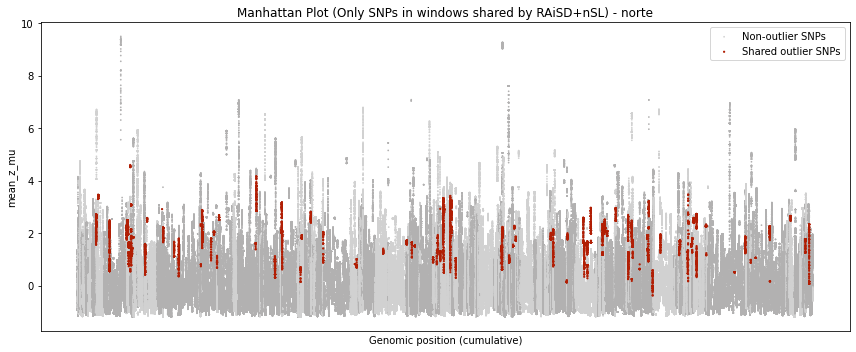

In [218]:
# Alternar colores por scaffold, etc.
colors = ['#d1d1d1', '#b2b1b1']  # Gris oscuro y gris claro
df_snps_in_shared_all_genes_mu['color_scaffold'] = df_snps_in_shared_all_genes_mu['chr_order'].cat.codes % 2

def assign_color(row):
    if row['is_outlier_shared']:
        return '#b11e04'  # Rojo si outlier en ambos
    else:
        return colors[row['color_scaffold']]

df_snps_in_shared_all_genes_mu['color'] = df_snps_in_shared_all_genes_mu.apply(assign_color, axis=1)

# Posición acumulada
df_snps_in_shared_all_genes_mu['cum_len'] = df_snps_in_shared_all_genes_mu.groupby('chr')['pos'].transform('max')
df_snps_in_shared_all_genes_mu['offset'] = (
    df_snps_in_shared_all_genes_mu.groupby('chr')['cum_len'].transform('first').cumsum()
    - df_snps_in_shared_all_genes_mu['cum_len']
)
df_snps_in_shared_all_genes_mu['cum_pos'] = (
    df_snps_in_shared_all_genes_mu['pos'] + df_snps_in_shared_all_genes_mu['offset']
)

# Plot
plt.figure(figsize=(12,5))

# Puntos no-outlier
plt.scatter(
    df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['cum_pos'],
    df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['mean_z_mu'],
    c=df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['color'],
    s=3, edgecolor='none', label='Non-outlier SNPs',
    zorder=1
)

# Puntos outlier (compartidos)
plt.scatter(
    df_snps_in_shared_all_genes_mu[df_snps_in_shared_all_genes_mu['is_outlier_shared']]['cum_pos'],
    df_snps_in_shared_all_genes_mu[df_snps_in_shared_all_genes_mu['is_outlier_shared']]['mean_z_mu'],
    c='#b11e04',  # rojo
    s=5, edgecolor='none', label='Shared outlier SNPs',
    zorder=2
)

plt.xticks([], [])
plt.xlabel("Genomic position (cumulative)")
plt.ylabel("mean_z_mu")
plt.title(f"Manhattan Plot (Only SNPs in windows shared by RAiSD+nSL) - {species_name}")

plt.tight_layout()
plt.legend()

# Guardar como PDF y PNG
output_pdf = f"{species_name}_manhattan_plot.pdf"
output_png = f"{species_name}_manhattan_plot.png"

plt.savefig(output_pdf, dpi=600, bbox_inches='tight')
plt.savefig(output_png, dpi=600, bbox_inches='tight')

plt.show()

## SOUTHERN GENTOO PENGUIN

##### 1. LOAD DATA

In [269]:
species_name = "sur"

# Archivos de entrada
raisd_file = f"raisd_{species_name}_polarizado_reports.txt"
nsl_file   = f"{species_name}_nsl_10kb.norm"
vcf_file   = f"{species_name}_all_snps.bed"
gtf_file   = "GCA_010090195.1_genomic.gtf"

In [270]:
# Cargar RAiSD y nSL
raisd = pd.read_csv(raisd_file, sep='\t', low_memory=False)
raisd.columns = ['chr', 'pos', 'win_start', 'win_end', 'var', 'sfs', 'ld', 'mu']

In [271]:
nsl = pd.read_csv(nsl_file, sep='\t', low_memory=False)
nsl.columns = ['chr','pos','allfreq1','SL1','SL0','raw_nSL','norm_nSL','nsl_over_critval']
nsl['win_end'] = nsl['pos'] + 10000  # ventanas 10kb

In [272]:
# Add .1 to scaffold name
raisd['chr'] = raisd['chr'].astype(str) + '.1'
nsl['chr']   = nsl['chr'].astype(str) + '.1'

In [273]:
# BED of SNPs
vcf_bed = pd.read_csv(vcf_file, sep='\t', names=["chr","pos","end"])

In [274]:
vcf_bed

chr   pos   end
0         VUKY01000001.1    60    60
1         VUKY01000001.1   190   190
2         VUKY01000001.1   342   342
3         VUKY01000001.1   467   467
4         VUKY01000001.1   646   646
...                  ...   ...   ...
11721085  VUKY01018750.1  2361  2361
11721086  VUKY01018750.1  2362  2362
11721087  VUKY01018750.1  2383  2383
11721088  VUKY01018750.1  2390  2390
11721089  VUKY01018750.1  2465  2465

[11721090 rows x 3 columns]

In [275]:
# import GTF
gtf_data = pd.read_csv(
    gtf_file, sep='\t',
    comment='#', header=None,
    names=['Chromosome','Source','Feature','Start','End','Score','Strand','Frame','Attribute']
)

##### 2. Define threshold and RAiSD and nSL outlier

In [276]:
# Normalizar mu en RAiSD => z_mu
mean_mu = raisd['mu'].mean()
std_mu  = raisd['mu'].std()
raisd['z_mu'] = (raisd['mu'] - mean_mu) / std_mu

In [277]:
# Threshold (top 1%)
threshold_raisd      = raisd['z_mu'].quantile(0.99)
threshold_nsl_high   = nsl['norm_nSL'].quantile(0.99)
threshold_nsl_low    = nsl['norm_nSL'].quantile(0.01)

In [278]:
# Filtrar ventanas outlier
raisd_out = raisd[ raisd['z_mu'] >= threshold_raisd ]
nsl_out   = nsl[ (nsl['norm_nSL'] >= threshold_nsl_high) | (nsl['norm_nSL'] <= threshold_nsl_low) ]

##### 3. Intersect RAiSD and nSL dataframe

In [279]:
raisd_all = raisd.copy()
nsl_all   = nsl.copy()

In [280]:
# Convert to PyRanges
raisd_all_pr = pr.PyRanges(
    raisd_all.rename(columns={'chr': 'Chromosome', 'win_start': 'Start', 'win_end': 'End'})
)

In [281]:
nsl_all_pr = pr.PyRanges(
    nsl_all.rename(columns={'chr': 'Chromosome', 'pos': 'Start', 'win_end': 'End'})
)

In [282]:
# Intersect all windows and remove not shared genomic regions
shared_all_pr = raisd_all_pr.intersect(nsl_all_pr)
print(len(shared_all_pr.df))  # Posiblemente millones

97757430


In [283]:
# Merge windows
merged_shared_all_pr = shared_all_pr.merge()
df_shared_all = merged_shared_all_pr.df
print(len(df_shared_all))  # Mucho menor tras fusionar

7794


In [284]:
df_shared_all_pr = pr.PyRanges(df_shared_all)

+----------------+-----------+-----------+
| Chromosome     | Start     | End       |
| (category)     | (int64)   | (int64)   |
|----------------+-----------+-----------|
| VUKY01000002.1 | 30224     | 166941    |
| VUKY01000002.1 | 167895    | 391196    |
| VUKY01000002.1 | 393367    | 790822    |
| VUKY01000025.1 | 21850     | 226599    |
| ...            | ...       | ...       |
| VUKY01000025.1 | 308875    | 394703    |
| VUKY01000025.1 | 395855    | 409374    |
| VUKY01000002.1 | 30224     | 166941    |
| VUKY01018721.1 | 6166641   | 6423010   |
| VUKY01018721.1 | 5987715   | 6166576   |
| VUKY01018721.1 | 5722899   | 5987350   |
| VUKY01018721.1 | 5607817   | 5720442   |
| VUKY01018732.1 | 4799      | 72531     |
| VUKY01018737.1 | 9414      | 10848     |
+----------------+-----------+-----------+
Unstranded PyRanges object has 7,794 rows and 3 columns from 1380 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

##### 4. FIlter only SNPs within shared windows

In [285]:
# snps_pr with all SNPs
df_vcf = vcf_bed.rename(columns={"chr":"Chromosome"})
df_vcf["Start"] = df_vcf["pos"]
df_vcf["End"]   = df_vcf["pos"]
snps_pr = pr.PyRanges(df_vcf)

In [286]:
df_snps_in_shared_all_list = []

for scaf in snps_pr.chromosomes:
    print(f"Processing {scaf}")

    # 1) Subset of snps_pr for this scaffold
    snps_sub = snps_pr[scaf]
    # 2) Subset of df_shared_all_pr for this scaffold
    shared_sub = df_shared_all_pr[scaf]

    # 3) Intersect
    if snps_sub and shared_sub:
        intersection_sub = snps_sub.intersect(shared_sub)
        df_sub = intersection_sub.df
        df_snps_in_shared_all_list.append(df_sub)
    else:
        print(f"No data for scaffold {scaf}")

# Combine
if len(df_snps_in_shared_all_list) > 0:
    df_snps_in_shared_all = pd.concat(df_snps_in_shared_all_list, ignore_index=True)
else:
    df_snps_in_shared_all = pd.DataFrame()


Processing VUKY01000001.1
No data for scaffold VUKY01000001.1
Processing VUKY01000002.1
Processing VUKY01000004.1
No data for scaffold VUKY01000004.1
Processing VUKY01000005.1
No data for scaffold VUKY01000005.1
Processing VUKY01000006.1
No data for scaffold VUKY01000006.1
Processing VUKY01000007.1
No data for scaffold VUKY01000007.1
Processing VUKY01000008.1
No data for scaffold VUKY01000008.1
Processing VUKY01000009.1
No data for scaffold VUKY01000009.1
Processing VUKY01000010.1
No data for scaffold VUKY01000010.1
Processing VUKY01000013.1
No data for scaffold VUKY01000013.1
Processing VUKY01000015.1
No data for scaffold VUKY01000015.1
Processing VUKY01000018.1
No data for scaffold VUKY01000018.1
Processing VUKY01000019.1
No data for scaffold VUKY01000019.1
Processing VUKY01000020.1
No data for scaffold VUKY01000020.1
Processing VUKY01000021.1
No data for scaffold VUKY01000021.1
Processing VUKY01000022.1
No data for scaffold VUKY01000022.1
Processing VUKY01000024.1
No data for scaffo

No data for scaffold VUKY01000210.1
Processing VUKY01000213.1
No data for scaffold VUKY01000213.1
Processing VUKY01000216.1
No data for scaffold VUKY01000216.1
Processing VUKY01000218.1
No data for scaffold VUKY01000218.1
Processing VUKY01000220.1
No data for scaffold VUKY01000220.1
Processing VUKY01000221.1
No data for scaffold VUKY01000221.1
Processing VUKY01000222.1
No data for scaffold VUKY01000222.1
Processing VUKY01000223.1
No data for scaffold VUKY01000223.1
Processing VUKY01000224.1
No data for scaffold VUKY01000224.1
Processing VUKY01000227.1
No data for scaffold VUKY01000227.1
Processing VUKY01000228.1
No data for scaffold VUKY01000228.1
Processing VUKY01000229.1
No data for scaffold VUKY01000229.1
Processing VUKY01000230.1
No data for scaffold VUKY01000230.1
Processing VUKY01000232.1
Processing VUKY01000233.1
Processing VUKY01000234.1
No data for scaffold VUKY01000234.1
Processing VUKY01000235.1
Processing VUKY01000236.1
No data for scaffold VUKY01000236.1
Processing VUKY010

No data for scaffold VUKY01000422.1
Processing VUKY01000423.1
No data for scaffold VUKY01000423.1
Processing VUKY01000425.1
No data for scaffold VUKY01000425.1
Processing VUKY01000426.1
No data for scaffold VUKY01000426.1
Processing VUKY01000428.1
No data for scaffold VUKY01000428.1
Processing VUKY01000429.1
No data for scaffold VUKY01000429.1
Processing VUKY01000430.1
No data for scaffold VUKY01000430.1
Processing VUKY01000433.1
No data for scaffold VUKY01000433.1
Processing VUKY01000434.1
No data for scaffold VUKY01000434.1
Processing VUKY01000436.1
No data for scaffold VUKY01000436.1
Processing VUKY01000437.1
No data for scaffold VUKY01000437.1
Processing VUKY01000438.1
No data for scaffold VUKY01000438.1
Processing VUKY01000439.1
No data for scaffold VUKY01000439.1
Processing VUKY01000441.1
No data for scaffold VUKY01000441.1
Processing VUKY01000442.1
No data for scaffold VUKY01000442.1
Processing VUKY01000443.1
No data for scaffold VUKY01000443.1
Processing VUKY01000444.1
No data 

No data for scaffold VUKY01000627.1
Processing VUKY01000628.1
No data for scaffold VUKY01000628.1
Processing VUKY01000629.1
No data for scaffold VUKY01000629.1
Processing VUKY01000631.1
No data for scaffold VUKY01000631.1
Processing VUKY01000632.1
No data for scaffold VUKY01000632.1
Processing VUKY01000634.1
No data for scaffold VUKY01000634.1
Processing VUKY01000635.1
No data for scaffold VUKY01000635.1
Processing VUKY01000636.1
No data for scaffold VUKY01000636.1
Processing VUKY01000638.1
No data for scaffold VUKY01000638.1
Processing VUKY01000639.1
No data for scaffold VUKY01000639.1
Processing VUKY01000640.1
No data for scaffold VUKY01000640.1
Processing VUKY01000642.1
No data for scaffold VUKY01000642.1
Processing VUKY01000644.1
Processing VUKY01000645.1
No data for scaffold VUKY01000645.1
Processing VUKY01000646.1
No data for scaffold VUKY01000646.1
Processing VUKY01000647.1
No data for scaffold VUKY01000647.1
Processing VUKY01000648.1
No data for scaffold VUKY01000648.1
Processi

No data for scaffold VUKY01000838.1
Processing VUKY01000839.1
No data for scaffold VUKY01000839.1
Processing VUKY01000840.1
No data for scaffold VUKY01000840.1
Processing VUKY01000842.1
Processing VUKY01000844.1
Processing VUKY01000845.1
No data for scaffold VUKY01000845.1
Processing VUKY01000846.1
No data for scaffold VUKY01000846.1
Processing VUKY01000847.1
No data for scaffold VUKY01000847.1
Processing VUKY01000848.1
No data for scaffold VUKY01000848.1
Processing VUKY01000849.1
No data for scaffold VUKY01000849.1
Processing VUKY01000850.1
No data for scaffold VUKY01000850.1
Processing VUKY01000851.1
No data for scaffold VUKY01000851.1
Processing VUKY01000852.1
No data for scaffold VUKY01000852.1
Processing VUKY01000853.1
No data for scaffold VUKY01000853.1
Processing VUKY01000855.1
No data for scaffold VUKY01000855.1
Processing VUKY01000856.1
No data for scaffold VUKY01000856.1
Processing VUKY01000857.1
No data for scaffold VUKY01000857.1
Processing VUKY01000858.1
No data for scaffo

No data for scaffold VUKY01001048.1
Processing VUKY01001050.1
No data for scaffold VUKY01001050.1
Processing VUKY01001051.1
No data for scaffold VUKY01001051.1
Processing VUKY01001054.1
No data for scaffold VUKY01001054.1
Processing VUKY01001055.1
No data for scaffold VUKY01001055.1
Processing VUKY01001056.1
No data for scaffold VUKY01001056.1
Processing VUKY01001057.1
No data for scaffold VUKY01001057.1
Processing VUKY01001059.1
No data for scaffold VUKY01001059.1
Processing VUKY01001060.1
No data for scaffold VUKY01001060.1
Processing VUKY01001061.1
No data for scaffold VUKY01001061.1
Processing VUKY01001062.1
No data for scaffold VUKY01001062.1
Processing VUKY01001063.1
No data for scaffold VUKY01001063.1
Processing VUKY01001064.1
Processing VUKY01001065.1
Processing VUKY01001066.1
No data for scaffold VUKY01001066.1
Processing VUKY01001068.1
No data for scaffold VUKY01001068.1
Processing VUKY01001073.1
No data for scaffold VUKY01001073.1
Processing VUKY01001075.1
No data for scaffo

No data for scaffold VUKY01001253.1
Processing VUKY01001254.1
No data for scaffold VUKY01001254.1
Processing VUKY01001255.1
No data for scaffold VUKY01001255.1
Processing VUKY01001256.1
No data for scaffold VUKY01001256.1
Processing VUKY01001259.1
No data for scaffold VUKY01001259.1
Processing VUKY01001260.1
No data for scaffold VUKY01001260.1
Processing VUKY01001262.1
No data for scaffold VUKY01001262.1
Processing VUKY01001263.1
Processing VUKY01001264.1
No data for scaffold VUKY01001264.1
Processing VUKY01001265.1
No data for scaffold VUKY01001265.1
Processing VUKY01001266.1
No data for scaffold VUKY01001266.1
Processing VUKY01001267.1
No data for scaffold VUKY01001267.1
Processing VUKY01001270.1
No data for scaffold VUKY01001270.1
Processing VUKY01001275.1
No data for scaffold VUKY01001275.1
Processing VUKY01001277.1
No data for scaffold VUKY01001277.1
Processing VUKY01001279.1
No data for scaffold VUKY01001279.1
Processing VUKY01001280.1
No data for scaffold VUKY01001280.1
Processi

No data for scaffold VUKY01001492.1
Processing VUKY01001493.1
No data for scaffold VUKY01001493.1
Processing VUKY01001495.1
No data for scaffold VUKY01001495.1
Processing VUKY01001497.1
No data for scaffold VUKY01001497.1
Processing VUKY01001499.1
No data for scaffold VUKY01001499.1
Processing VUKY01001500.1
No data for scaffold VUKY01001500.1
Processing VUKY01001502.1
No data for scaffold VUKY01001502.1
Processing VUKY01001503.1
No data for scaffold VUKY01001503.1
Processing VUKY01001504.1
No data for scaffold VUKY01001504.1
Processing VUKY01001505.1
Processing VUKY01001507.1
No data for scaffold VUKY01001507.1
Processing VUKY01001508.1
Processing VUKY01001509.1
No data for scaffold VUKY01001509.1
Processing VUKY01001510.1
No data for scaffold VUKY01001510.1
Processing VUKY01001511.1
No data for scaffold VUKY01001511.1
Processing VUKY01001512.1
No data for scaffold VUKY01001512.1
Processing VUKY01001513.1
No data for scaffold VUKY01001513.1
Processing VUKY01001514.1
No data for scaffo

No data for scaffold VUKY01001714.1
Processing VUKY01001715.1
No data for scaffold VUKY01001715.1
Processing VUKY01001717.1
No data for scaffold VUKY01001717.1
Processing VUKY01001718.1
No data for scaffold VUKY01001718.1
Processing VUKY01001720.1
No data for scaffold VUKY01001720.1
Processing VUKY01001721.1
Processing VUKY01001722.1
No data for scaffold VUKY01001722.1
Processing VUKY01001723.1
No data for scaffold VUKY01001723.1
Processing VUKY01001724.1
No data for scaffold VUKY01001724.1
Processing VUKY01001725.1
No data for scaffold VUKY01001725.1
Processing VUKY01001727.1
Processing VUKY01001728.1
No data for scaffold VUKY01001728.1
Processing VUKY01001729.1
No data for scaffold VUKY01001729.1
Processing VUKY01001730.1
No data for scaffold VUKY01001730.1
Processing VUKY01001733.1
No data for scaffold VUKY01001733.1
Processing VUKY01001735.1
No data for scaffold VUKY01001735.1
Processing VUKY01001739.1
No data for scaffold VUKY01001739.1
Processing VUKY01001740.1
No data for scaffo

No data for scaffold VUKY01001938.1
Processing VUKY01001939.1
No data for scaffold VUKY01001939.1
Processing VUKY01001940.1
No data for scaffold VUKY01001940.1
Processing VUKY01001942.1
No data for scaffold VUKY01001942.1
Processing VUKY01001943.1
No data for scaffold VUKY01001943.1
Processing VUKY01001944.1
No data for scaffold VUKY01001944.1
Processing VUKY01001945.1
No data for scaffold VUKY01001945.1
Processing VUKY01001947.1
No data for scaffold VUKY01001947.1
Processing VUKY01001948.1
No data for scaffold VUKY01001948.1
Processing VUKY01001949.1
No data for scaffold VUKY01001949.1
Processing VUKY01001951.1
No data for scaffold VUKY01001951.1
Processing VUKY01001952.1
No data for scaffold VUKY01001952.1
Processing VUKY01001954.1
No data for scaffold VUKY01001954.1
Processing VUKY01001956.1
No data for scaffold VUKY01001956.1
Processing VUKY01001957.1
No data for scaffold VUKY01001957.1
Processing VUKY01001958.1
No data for scaffold VUKY01001958.1
Processing VUKY01001961.1
No data 

No data for scaffold VUKY01002141.1
Processing VUKY01002142.1
No data for scaffold VUKY01002142.1
Processing VUKY01002143.1
No data for scaffold VUKY01002143.1
Processing VUKY01002145.1
No data for scaffold VUKY01002145.1
Processing VUKY01002146.1
No data for scaffold VUKY01002146.1
Processing VUKY01002147.1
No data for scaffold VUKY01002147.1
Processing VUKY01002148.1
No data for scaffold VUKY01002148.1
Processing VUKY01002149.1
No data for scaffold VUKY01002149.1
Processing VUKY01002152.1
No data for scaffold VUKY01002152.1
Processing VUKY01002153.1
No data for scaffold VUKY01002153.1
Processing VUKY01002154.1
No data for scaffold VUKY01002154.1
Processing VUKY01002155.1
No data for scaffold VUKY01002155.1
Processing VUKY01002156.1
No data for scaffold VUKY01002156.1
Processing VUKY01002158.1
No data for scaffold VUKY01002158.1
Processing VUKY01002161.1
No data for scaffold VUKY01002161.1
Processing VUKY01002162.1
No data for scaffold VUKY01002162.1
Processing VUKY01002164.1
No data 

No data for scaffold VUKY01002352.1
Processing VUKY01002355.1
No data for scaffold VUKY01002355.1
Processing VUKY01002356.1
No data for scaffold VUKY01002356.1
Processing VUKY01002357.1
No data for scaffold VUKY01002357.1
Processing VUKY01002359.1
No data for scaffold VUKY01002359.1
Processing VUKY01002361.1
No data for scaffold VUKY01002361.1
Processing VUKY01002364.1
No data for scaffold VUKY01002364.1
Processing VUKY01002365.1
No data for scaffold VUKY01002365.1
Processing VUKY01002367.1
No data for scaffold VUKY01002367.1
Processing VUKY01002369.1
No data for scaffold VUKY01002369.1
Processing VUKY01002370.1
No data for scaffold VUKY01002370.1
Processing VUKY01002372.1
No data for scaffold VUKY01002372.1
Processing VUKY01002373.1
No data for scaffold VUKY01002373.1
Processing VUKY01002374.1
No data for scaffold VUKY01002374.1
Processing VUKY01002375.1
No data for scaffold VUKY01002375.1
Processing VUKY01002376.1
No data for scaffold VUKY01002376.1
Processing VUKY01002377.1
No data 

No data for scaffold VUKY01002553.1
Processing VUKY01002554.1
No data for scaffold VUKY01002554.1
Processing VUKY01002555.1
No data for scaffold VUKY01002555.1
Processing VUKY01002557.1
No data for scaffold VUKY01002557.1
Processing VUKY01002560.1
No data for scaffold VUKY01002560.1
Processing VUKY01002561.1
No data for scaffold VUKY01002561.1
Processing VUKY01002562.1
No data for scaffold VUKY01002562.1
Processing VUKY01002565.1
No data for scaffold VUKY01002565.1
Processing VUKY01002567.1
No data for scaffold VUKY01002567.1
Processing VUKY01002568.1
No data for scaffold VUKY01002568.1
Processing VUKY01002572.1
No data for scaffold VUKY01002572.1
Processing VUKY01002573.1
No data for scaffold VUKY01002573.1
Processing VUKY01002576.1
Processing VUKY01002577.1
No data for scaffold VUKY01002577.1
Processing VUKY01002580.1
No data for scaffold VUKY01002580.1
Processing VUKY01002584.1
No data for scaffold VUKY01002584.1
Processing VUKY01002585.1
No data for scaffold VUKY01002585.1
Processi

No data for scaffold VUKY01002760.1
Processing VUKY01002761.1
No data for scaffold VUKY01002761.1
Processing VUKY01002762.1
Processing VUKY01002763.1
No data for scaffold VUKY01002763.1
Processing VUKY01002765.1
No data for scaffold VUKY01002765.1
Processing VUKY01002766.1
No data for scaffold VUKY01002766.1
Processing VUKY01002768.1
No data for scaffold VUKY01002768.1
Processing VUKY01002769.1
No data for scaffold VUKY01002769.1
Processing VUKY01002771.1
No data for scaffold VUKY01002771.1
Processing VUKY01002772.1
No data for scaffold VUKY01002772.1
Processing VUKY01002774.1
No data for scaffold VUKY01002774.1
Processing VUKY01002776.1
No data for scaffold VUKY01002776.1
Processing VUKY01002778.1
No data for scaffold VUKY01002778.1
Processing VUKY01002779.1
No data for scaffold VUKY01002779.1
Processing VUKY01002782.1
No data for scaffold VUKY01002782.1
Processing VUKY01002783.1
No data for scaffold VUKY01002783.1
Processing VUKY01002786.1
No data for scaffold VUKY01002786.1
Processi

No data for scaffold VUKY01002962.1
Processing VUKY01002963.1
No data for scaffold VUKY01002963.1
Processing VUKY01002964.1
No data for scaffold VUKY01002964.1
Processing VUKY01002966.1
No data for scaffold VUKY01002966.1
Processing VUKY01002967.1
No data for scaffold VUKY01002967.1
Processing VUKY01002968.1
No data for scaffold VUKY01002968.1
Processing VUKY01002971.1
No data for scaffold VUKY01002971.1
Processing VUKY01002972.1
No data for scaffold VUKY01002972.1
Processing VUKY01002973.1
No data for scaffold VUKY01002973.1
Processing VUKY01002974.1
No data for scaffold VUKY01002974.1
Processing VUKY01002975.1
No data for scaffold VUKY01002975.1
Processing VUKY01002976.1
No data for scaffold VUKY01002976.1
Processing VUKY01002977.1
No data for scaffold VUKY01002977.1
Processing VUKY01002978.1
No data for scaffold VUKY01002978.1
Processing VUKY01002979.1
No data for scaffold VUKY01002979.1
Processing VUKY01002980.1
No data for scaffold VUKY01002980.1
Processing VUKY01002981.1
No data 

No data for scaffold VUKY01003186.1
Processing VUKY01003189.1
No data for scaffold VUKY01003189.1
Processing VUKY01003191.1
No data for scaffold VUKY01003191.1
Processing VUKY01003192.1
No data for scaffold VUKY01003192.1
Processing VUKY01003195.1
No data for scaffold VUKY01003195.1
Processing VUKY01003196.1
No data for scaffold VUKY01003196.1
Processing VUKY01003197.1
No data for scaffold VUKY01003197.1
Processing VUKY01003198.1
No data for scaffold VUKY01003198.1
Processing VUKY01003202.1
No data for scaffold VUKY01003202.1
Processing VUKY01003203.1
Processing VUKY01003204.1
No data for scaffold VUKY01003204.1
Processing VUKY01003205.1
No data for scaffold VUKY01003205.1
Processing VUKY01003209.1
No data for scaffold VUKY01003209.1
Processing VUKY01003210.1
No data for scaffold VUKY01003210.1
Processing VUKY01003211.1
Processing VUKY01003212.1
No data for scaffold VUKY01003212.1
Processing VUKY01003214.1
No data for scaffold VUKY01003214.1
Processing VUKY01003215.1
No data for scaffo

No data for scaffold VUKY01003414.1
Processing VUKY01003415.1
No data for scaffold VUKY01003415.1
Processing VUKY01003416.1
No data for scaffold VUKY01003416.1
Processing VUKY01003417.1
No data for scaffold VUKY01003417.1
Processing VUKY01003419.1
No data for scaffold VUKY01003419.1
Processing VUKY01003420.1
No data for scaffold VUKY01003420.1
Processing VUKY01003421.1
No data for scaffold VUKY01003421.1
Processing VUKY01003422.1
No data for scaffold VUKY01003422.1
Processing VUKY01003423.1
No data for scaffold VUKY01003423.1
Processing VUKY01003425.1
No data for scaffold VUKY01003425.1
Processing VUKY01003427.1
No data for scaffold VUKY01003427.1
Processing VUKY01003429.1
No data for scaffold VUKY01003429.1
Processing VUKY01003430.1
No data for scaffold VUKY01003430.1
Processing VUKY01003431.1
No data for scaffold VUKY01003431.1
Processing VUKY01003432.1
No data for scaffold VUKY01003432.1
Processing VUKY01003434.1
No data for scaffold VUKY01003434.1
Processing VUKY01003435.1
No data 

No data for scaffold VUKY01003606.1
Processing VUKY01003607.1
No data for scaffold VUKY01003607.1
Processing VUKY01003609.1
No data for scaffold VUKY01003609.1
Processing VUKY01003610.1
No data for scaffold VUKY01003610.1
Processing VUKY01003611.1
No data for scaffold VUKY01003611.1
Processing VUKY01003613.1
No data for scaffold VUKY01003613.1
Processing VUKY01003615.1
No data for scaffold VUKY01003615.1
Processing VUKY01003618.1
No data for scaffold VUKY01003618.1
Processing VUKY01003621.1
No data for scaffold VUKY01003621.1
Processing VUKY01003623.1
No data for scaffold VUKY01003623.1
Processing VUKY01003625.1
Processing VUKY01003626.1
No data for scaffold VUKY01003626.1
Processing VUKY01003627.1
No data for scaffold VUKY01003627.1
Processing VUKY01003628.1
No data for scaffold VUKY01003628.1
Processing VUKY01003629.1
Processing VUKY01003631.1
No data for scaffold VUKY01003631.1
Processing VUKY01003632.1
Processing VUKY01003634.1
No data for scaffold VUKY01003634.1
Processing VUKY010

No data for scaffold VUKY01003840.1
Processing VUKY01003842.1
No data for scaffold VUKY01003842.1
Processing VUKY01003843.1
Processing VUKY01003844.1
No data for scaffold VUKY01003844.1
Processing VUKY01003845.1
No data for scaffold VUKY01003845.1
Processing VUKY01003846.1
No data for scaffold VUKY01003846.1
Processing VUKY01003847.1
No data for scaffold VUKY01003847.1
Processing VUKY01003848.1
No data for scaffold VUKY01003848.1
Processing VUKY01003849.1
No data for scaffold VUKY01003849.1
Processing VUKY01003851.1
No data for scaffold VUKY01003851.1
Processing VUKY01003852.1
No data for scaffold VUKY01003852.1
Processing VUKY01003855.1
No data for scaffold VUKY01003855.1
Processing VUKY01003857.1
No data for scaffold VUKY01003857.1
Processing VUKY01003859.1
No data for scaffold VUKY01003859.1
Processing VUKY01003860.1
Processing VUKY01003862.1
No data for scaffold VUKY01003862.1
Processing VUKY01003867.1
No data for scaffold VUKY01003867.1
Processing VUKY01003870.1
No data for scaffo

No data for scaffold VUKY01004059.1
Processing VUKY01004061.1
No data for scaffold VUKY01004061.1
Processing VUKY01004062.1
No data for scaffold VUKY01004062.1
Processing VUKY01004063.1
No data for scaffold VUKY01004063.1
Processing VUKY01004064.1
No data for scaffold VUKY01004064.1
Processing VUKY01004065.1
No data for scaffold VUKY01004065.1
Processing VUKY01004066.1
No data for scaffold VUKY01004066.1
Processing VUKY01004067.1
Processing VUKY01004068.1
No data for scaffold VUKY01004068.1
Processing VUKY01004070.1
No data for scaffold VUKY01004070.1
Processing VUKY01004071.1
No data for scaffold VUKY01004071.1
Processing VUKY01004072.1
No data for scaffold VUKY01004072.1
Processing VUKY01004074.1
No data for scaffold VUKY01004074.1
Processing VUKY01004075.1
No data for scaffold VUKY01004075.1
Processing VUKY01004076.1
No data for scaffold VUKY01004076.1
Processing VUKY01004077.1
No data for scaffold VUKY01004077.1
Processing VUKY01004078.1
No data for scaffold VUKY01004078.1
Processi

No data for scaffold VUKY01004260.1
Processing VUKY01004261.1
No data for scaffold VUKY01004261.1
Processing VUKY01004264.1
No data for scaffold VUKY01004264.1
Processing VUKY01004265.1
Processing VUKY01004270.1
No data for scaffold VUKY01004270.1
Processing VUKY01004272.1
No data for scaffold VUKY01004272.1
Processing VUKY01004274.1
No data for scaffold VUKY01004274.1
Processing VUKY01004275.1
No data for scaffold VUKY01004275.1
Processing VUKY01004276.1
No data for scaffold VUKY01004276.1
Processing VUKY01004277.1
No data for scaffold VUKY01004277.1
Processing VUKY01004278.1
No data for scaffold VUKY01004278.1
Processing VUKY01004280.1
No data for scaffold VUKY01004280.1
Processing VUKY01004282.1
No data for scaffold VUKY01004282.1
Processing VUKY01004283.1
No data for scaffold VUKY01004283.1
Processing VUKY01004284.1
No data for scaffold VUKY01004284.1
Processing VUKY01004285.1
No data for scaffold VUKY01004285.1
Processing VUKY01004286.1
No data for scaffold VUKY01004286.1
Processi

No data for scaffold VUKY01004481.1
Processing VUKY01004482.1
No data for scaffold VUKY01004482.1
Processing VUKY01004483.1
No data for scaffold VUKY01004483.1
Processing VUKY01004485.1
No data for scaffold VUKY01004485.1
Processing VUKY01004486.1
No data for scaffold VUKY01004486.1
Processing VUKY01004488.1
No data for scaffold VUKY01004488.1
Processing VUKY01004491.1
No data for scaffold VUKY01004491.1
Processing VUKY01004492.1
No data for scaffold VUKY01004492.1
Processing VUKY01004494.1
No data for scaffold VUKY01004494.1
Processing VUKY01004495.1
No data for scaffold VUKY01004495.1
Processing VUKY01004497.1
No data for scaffold VUKY01004497.1
Processing VUKY01004498.1
No data for scaffold VUKY01004498.1
Processing VUKY01004500.1
No data for scaffold VUKY01004500.1
Processing VUKY01004501.1
No data for scaffold VUKY01004501.1
Processing VUKY01004503.1
No data for scaffold VUKY01004503.1
Processing VUKY01004504.1
No data for scaffold VUKY01004504.1
Processing VUKY01004509.1
No data 

No data for scaffold VUKY01004701.1
Processing VUKY01004702.1
No data for scaffold VUKY01004702.1
Processing VUKY01004703.1
No data for scaffold VUKY01004703.1
Processing VUKY01004704.1
No data for scaffold VUKY01004704.1
Processing VUKY01004708.1
No data for scaffold VUKY01004708.1
Processing VUKY01004709.1
No data for scaffold VUKY01004709.1
Processing VUKY01004710.1
No data for scaffold VUKY01004710.1
Processing VUKY01004712.1
Processing VUKY01004714.1
No data for scaffold VUKY01004714.1
Processing VUKY01004717.1
No data for scaffold VUKY01004717.1
Processing VUKY01004718.1
No data for scaffold VUKY01004718.1
Processing VUKY01004719.1
No data for scaffold VUKY01004719.1
Processing VUKY01004721.1
No data for scaffold VUKY01004721.1
Processing VUKY01004723.1
Processing VUKY01004724.1
No data for scaffold VUKY01004724.1
Processing VUKY01004725.1
No data for scaffold VUKY01004725.1
Processing VUKY01004726.1
No data for scaffold VUKY01004726.1
Processing VUKY01004728.1
No data for scaffo

No data for scaffold VUKY01004923.1
Processing VUKY01004925.1
No data for scaffold VUKY01004925.1
Processing VUKY01004926.1
No data for scaffold VUKY01004926.1
Processing VUKY01004929.1
No data for scaffold VUKY01004929.1
Processing VUKY01004930.1
No data for scaffold VUKY01004930.1
Processing VUKY01004932.1
No data for scaffold VUKY01004932.1
Processing VUKY01004935.1
No data for scaffold VUKY01004935.1
Processing VUKY01004936.1
No data for scaffold VUKY01004936.1
Processing VUKY01004937.1
No data for scaffold VUKY01004937.1
Processing VUKY01004938.1
No data for scaffold VUKY01004938.1
Processing VUKY01004939.1
No data for scaffold VUKY01004939.1
Processing VUKY01004940.1
No data for scaffold VUKY01004940.1
Processing VUKY01004941.1
No data for scaffold VUKY01004941.1
Processing VUKY01004942.1
No data for scaffold VUKY01004942.1
Processing VUKY01004943.1
No data for scaffold VUKY01004943.1
Processing VUKY01004944.1
No data for scaffold VUKY01004944.1
Processing VUKY01004947.1
No data 

No data for scaffold VUKY01005132.1
Processing VUKY01005134.1
No data for scaffold VUKY01005134.1
Processing VUKY01005136.1
No data for scaffold VUKY01005136.1
Processing VUKY01005137.1
No data for scaffold VUKY01005137.1
Processing VUKY01005139.1
No data for scaffold VUKY01005139.1
Processing VUKY01005140.1
Processing VUKY01005141.1
No data for scaffold VUKY01005141.1
Processing VUKY01005143.1
No data for scaffold VUKY01005143.1
Processing VUKY01005145.1
No data for scaffold VUKY01005145.1
Processing VUKY01005146.1
No data for scaffold VUKY01005146.1
Processing VUKY01005147.1
No data for scaffold VUKY01005147.1
Processing VUKY01005149.1
No data for scaffold VUKY01005149.1
Processing VUKY01005152.1
No data for scaffold VUKY01005152.1
Processing VUKY01005153.1
No data for scaffold VUKY01005153.1
Processing VUKY01005154.1
No data for scaffold VUKY01005154.1
Processing VUKY01005156.1
No data for scaffold VUKY01005156.1
Processing VUKY01005157.1
No data for scaffold VUKY01005157.1
Processi

No data for scaffold VUKY01005348.1
Processing VUKY01005349.1
No data for scaffold VUKY01005349.1
Processing VUKY01005350.1
No data for scaffold VUKY01005350.1
Processing VUKY01005351.1
No data for scaffold VUKY01005351.1
Processing VUKY01005352.1
No data for scaffold VUKY01005352.1
Processing VUKY01005353.1
No data for scaffold VUKY01005353.1
Processing VUKY01005354.1
No data for scaffold VUKY01005354.1
Processing VUKY01005355.1
Processing VUKY01005356.1
No data for scaffold VUKY01005356.1
Processing VUKY01005358.1
No data for scaffold VUKY01005358.1
Processing VUKY01005359.1
No data for scaffold VUKY01005359.1
Processing VUKY01005360.1
No data for scaffold VUKY01005360.1
Processing VUKY01005361.1
No data for scaffold VUKY01005361.1
Processing VUKY01005362.1
Processing VUKY01005365.1
No data for scaffold VUKY01005365.1
Processing VUKY01005366.1
No data for scaffold VUKY01005366.1
Processing VUKY01005367.1
No data for scaffold VUKY01005367.1
Processing VUKY01005369.1
Processing VUKY010

No data for scaffold VUKY01005542.1
Processing VUKY01005543.1
No data for scaffold VUKY01005543.1
Processing VUKY01005544.1
No data for scaffold VUKY01005544.1
Processing VUKY01005545.1
No data for scaffold VUKY01005545.1
Processing VUKY01005546.1
No data for scaffold VUKY01005546.1
Processing VUKY01005547.1
No data for scaffold VUKY01005547.1
Processing VUKY01005549.1
No data for scaffold VUKY01005549.1
Processing VUKY01005550.1
No data for scaffold VUKY01005550.1
Processing VUKY01005552.1
No data for scaffold VUKY01005552.1
Processing VUKY01005553.1
No data for scaffold VUKY01005553.1
Processing VUKY01005554.1
No data for scaffold VUKY01005554.1
Processing VUKY01005555.1
No data for scaffold VUKY01005555.1
Processing VUKY01005556.1
No data for scaffold VUKY01005556.1
Processing VUKY01005557.1
No data for scaffold VUKY01005557.1
Processing VUKY01005558.1
No data for scaffold VUKY01005558.1
Processing VUKY01005560.1
No data for scaffold VUKY01005560.1
Processing VUKY01005562.1
No data 

No data for scaffold VUKY01005745.1
Processing VUKY01005747.1
No data for scaffold VUKY01005747.1
Processing VUKY01005750.1
No data for scaffold VUKY01005750.1
Processing VUKY01005754.1
No data for scaffold VUKY01005754.1
Processing VUKY01005756.1
No data for scaffold VUKY01005756.1
Processing VUKY01005759.1
No data for scaffold VUKY01005759.1
Processing VUKY01005761.1
No data for scaffold VUKY01005761.1
Processing VUKY01005762.1
No data for scaffold VUKY01005762.1
Processing VUKY01005763.1
No data for scaffold VUKY01005763.1
Processing VUKY01005764.1
No data for scaffold VUKY01005764.1
Processing VUKY01005765.1
No data for scaffold VUKY01005765.1
Processing VUKY01005767.1
Processing VUKY01005768.1
No data for scaffold VUKY01005768.1
Processing VUKY01005769.1
Processing VUKY01005771.1
No data for scaffold VUKY01005771.1
Processing VUKY01005772.1
No data for scaffold VUKY01005772.1
Processing VUKY01005773.1
No data for scaffold VUKY01005773.1
Processing VUKY01005774.1
No data for scaffo

No data for scaffold VUKY01005950.1
Processing VUKY01005952.1
No data for scaffold VUKY01005952.1
Processing VUKY01005953.1
No data for scaffold VUKY01005953.1
Processing VUKY01005954.1
No data for scaffold VUKY01005954.1
Processing VUKY01005955.1
No data for scaffold VUKY01005955.1
Processing VUKY01005956.1
No data for scaffold VUKY01005956.1
Processing VUKY01005958.1
No data for scaffold VUKY01005958.1
Processing VUKY01005959.1
No data for scaffold VUKY01005959.1
Processing VUKY01005961.1
No data for scaffold VUKY01005961.1
Processing VUKY01005963.1
No data for scaffold VUKY01005963.1
Processing VUKY01005966.1
No data for scaffold VUKY01005966.1
Processing VUKY01005967.1
No data for scaffold VUKY01005967.1
Processing VUKY01005968.1
Processing VUKY01005970.1
No data for scaffold VUKY01005970.1
Processing VUKY01005971.1
No data for scaffold VUKY01005971.1
Processing VUKY01005974.1
No data for scaffold VUKY01005974.1
Processing VUKY01005975.1
No data for scaffold VUKY01005975.1
Processi

No data for scaffold VUKY01006147.1
Processing VUKY01006148.1
No data for scaffold VUKY01006148.1
Processing VUKY01006149.1
No data for scaffold VUKY01006149.1
Processing VUKY01006150.1
No data for scaffold VUKY01006150.1
Processing VUKY01006152.1
No data for scaffold VUKY01006152.1
Processing VUKY01006153.1
No data for scaffold VUKY01006153.1
Processing VUKY01006158.1
No data for scaffold VUKY01006158.1
Processing VUKY01006159.1
No data for scaffold VUKY01006159.1
Processing VUKY01006160.1
No data for scaffold VUKY01006160.1
Processing VUKY01006162.1
No data for scaffold VUKY01006162.1
Processing VUKY01006163.1
No data for scaffold VUKY01006163.1
Processing VUKY01006164.1
No data for scaffold VUKY01006164.1
Processing VUKY01006165.1
No data for scaffold VUKY01006165.1
Processing VUKY01006166.1
No data for scaffold VUKY01006166.1
Processing VUKY01006167.1
Processing VUKY01006168.1
No data for scaffold VUKY01006168.1
Processing VUKY01006169.1
No data for scaffold VUKY01006169.1
Processi

No data for scaffold VUKY01006342.1
Processing VUKY01006344.1
No data for scaffold VUKY01006344.1
Processing VUKY01006347.1
No data for scaffold VUKY01006347.1
Processing VUKY01006348.1
No data for scaffold VUKY01006348.1
Processing VUKY01006349.1
No data for scaffold VUKY01006349.1
Processing VUKY01006350.1
No data for scaffold VUKY01006350.1
Processing VUKY01006351.1
Processing VUKY01006353.1
No data for scaffold VUKY01006353.1
Processing VUKY01006354.1
No data for scaffold VUKY01006354.1
Processing VUKY01006355.1
No data for scaffold VUKY01006355.1
Processing VUKY01006360.1
No data for scaffold VUKY01006360.1
Processing VUKY01006363.1
No data for scaffold VUKY01006363.1
Processing VUKY01006365.1
No data for scaffold VUKY01006365.1
Processing VUKY01006366.1
No data for scaffold VUKY01006366.1
Processing VUKY01006368.1
No data for scaffold VUKY01006368.1
Processing VUKY01006369.1
No data for scaffold VUKY01006369.1
Processing VUKY01006370.1
No data for scaffold VUKY01006370.1
Processi

No data for scaffold VUKY01006558.1
Processing VUKY01006559.1
No data for scaffold VUKY01006559.1
Processing VUKY01006560.1
No data for scaffold VUKY01006560.1
Processing VUKY01006561.1
No data for scaffold VUKY01006561.1
Processing VUKY01006562.1
No data for scaffold VUKY01006562.1
Processing VUKY01006563.1
No data for scaffold VUKY01006563.1
Processing VUKY01006566.1
No data for scaffold VUKY01006566.1
Processing VUKY01006567.1
No data for scaffold VUKY01006567.1
Processing VUKY01006568.1
Processing VUKY01006569.1
Processing VUKY01006572.1
No data for scaffold VUKY01006572.1
Processing VUKY01006573.1
No data for scaffold VUKY01006573.1
Processing VUKY01006574.1
No data for scaffold VUKY01006574.1
Processing VUKY01006576.1
No data for scaffold VUKY01006576.1
Processing VUKY01006577.1
No data for scaffold VUKY01006577.1
Processing VUKY01006578.1
No data for scaffold VUKY01006578.1
Processing VUKY01006579.1
No data for scaffold VUKY01006579.1
Processing VUKY01006580.1
No data for scaffo

No data for scaffold VUKY01006765.1
Processing VUKY01006766.1
Processing VUKY01006767.1
No data for scaffold VUKY01006767.1
Processing VUKY01006768.1
No data for scaffold VUKY01006768.1
Processing VUKY01006769.1
No data for scaffold VUKY01006769.1
Processing VUKY01006770.1
No data for scaffold VUKY01006770.1
Processing VUKY01006771.1
No data for scaffold VUKY01006771.1
Processing VUKY01006772.1
No data for scaffold VUKY01006772.1
Processing VUKY01006773.1
No data for scaffold VUKY01006773.1
Processing VUKY01006775.1
No data for scaffold VUKY01006775.1
Processing VUKY01006777.1
Processing VUKY01006778.1
No data for scaffold VUKY01006778.1
Processing VUKY01006779.1
No data for scaffold VUKY01006779.1
Processing VUKY01006780.1
No data for scaffold VUKY01006780.1
Processing VUKY01006782.1
No data for scaffold VUKY01006782.1
Processing VUKY01006783.1
No data for scaffold VUKY01006783.1
Processing VUKY01006784.1
No data for scaffold VUKY01006784.1
Processing VUKY01006785.1
Processing VUKY010

No data for scaffold VUKY01006979.1
Processing VUKY01006981.1
Processing VUKY01006982.1
No data for scaffold VUKY01006982.1
Processing VUKY01006983.1
No data for scaffold VUKY01006983.1
Processing VUKY01006984.1
No data for scaffold VUKY01006984.1
Processing VUKY01006985.1
No data for scaffold VUKY01006985.1
Processing VUKY01006987.1
No data for scaffold VUKY01006987.1
Processing VUKY01006990.1
No data for scaffold VUKY01006990.1
Processing VUKY01006991.1
Processing VUKY01006992.1
No data for scaffold VUKY01006992.1
Processing VUKY01006996.1
No data for scaffold VUKY01006996.1
Processing VUKY01006997.1
Processing VUKY01006999.1
No data for scaffold VUKY01006999.1
Processing VUKY01007001.1
No data for scaffold VUKY01007001.1
Processing VUKY01007003.1
No data for scaffold VUKY01007003.1
Processing VUKY01007007.1
No data for scaffold VUKY01007007.1
Processing VUKY01007008.1
Processing VUKY01007009.1
No data for scaffold VUKY01007009.1
Processing VUKY01007013.1
No data for scaffold VUKY010

No data for scaffold VUKY01007201.1
Processing VUKY01007205.1
No data for scaffold VUKY01007205.1
Processing VUKY01007207.1
No data for scaffold VUKY01007207.1
Processing VUKY01007208.1
No data for scaffold VUKY01007208.1
Processing VUKY01007209.1
Processing VUKY01007210.1
No data for scaffold VUKY01007210.1
Processing VUKY01007211.1
No data for scaffold VUKY01007211.1
Processing VUKY01007212.1
Processing VUKY01007213.1
No data for scaffold VUKY01007213.1
Processing VUKY01007214.1
Processing VUKY01007215.1
No data for scaffold VUKY01007215.1
Processing VUKY01007216.1
No data for scaffold VUKY01007216.1
Processing VUKY01007218.1
No data for scaffold VUKY01007218.1
Processing VUKY01007219.1
No data for scaffold VUKY01007219.1
Processing VUKY01007221.1
No data for scaffold VUKY01007221.1
Processing VUKY01007222.1
No data for scaffold VUKY01007222.1
Processing VUKY01007225.1
No data for scaffold VUKY01007225.1
Processing VUKY01007228.1
No data for scaffold VUKY01007228.1
Processing VUKY010

Processing VUKY01007412.1
No data for scaffold VUKY01007412.1
Processing VUKY01007413.1
Processing VUKY01007417.1
Processing VUKY01007419.1
No data for scaffold VUKY01007419.1
Processing VUKY01007420.1
No data for scaffold VUKY01007420.1
Processing VUKY01007422.1
No data for scaffold VUKY01007422.1
Processing VUKY01007423.1
No data for scaffold VUKY01007423.1
Processing VUKY01007424.1
No data for scaffold VUKY01007424.1
Processing VUKY01007426.1
No data for scaffold VUKY01007426.1
Processing VUKY01007427.1
No data for scaffold VUKY01007427.1
Processing VUKY01007430.1
No data for scaffold VUKY01007430.1
Processing VUKY01007431.1
No data for scaffold VUKY01007431.1
Processing VUKY01007432.1
No data for scaffold VUKY01007432.1
Processing VUKY01007433.1
No data for scaffold VUKY01007433.1
Processing VUKY01007434.1
No data for scaffold VUKY01007434.1
Processing VUKY01007435.1
No data for scaffold VUKY01007435.1
Processing VUKY01007436.1
No data for scaffold VUKY01007436.1
Processing VUKY010

Processing VUKY01007612.1
No data for scaffold VUKY01007612.1
Processing VUKY01007614.1
Processing VUKY01007615.1
No data for scaffold VUKY01007615.1
Processing VUKY01007618.1
No data for scaffold VUKY01007618.1
Processing VUKY01007619.1
No data for scaffold VUKY01007619.1
Processing VUKY01007620.1
No data for scaffold VUKY01007620.1
Processing VUKY01007621.1
No data for scaffold VUKY01007621.1
Processing VUKY01007622.1
No data for scaffold VUKY01007622.1
Processing VUKY01007623.1
No data for scaffold VUKY01007623.1
Processing VUKY01007624.1
No data for scaffold VUKY01007624.1
Processing VUKY01007625.1
No data for scaffold VUKY01007625.1
Processing VUKY01007627.1
No data for scaffold VUKY01007627.1
Processing VUKY01007629.1
Processing VUKY01007630.1
No data for scaffold VUKY01007630.1
Processing VUKY01007634.1
No data for scaffold VUKY01007634.1
Processing VUKY01007636.1
No data for scaffold VUKY01007636.1
Processing VUKY01007637.1
No data for scaffold VUKY01007637.1
Processing VUKY010

No data for scaffold VUKY01007834.1
Processing VUKY01007835.1
Processing VUKY01007836.1
Processing VUKY01007838.1
No data for scaffold VUKY01007838.1
Processing VUKY01007839.1
No data for scaffold VUKY01007839.1
Processing VUKY01007840.1
No data for scaffold VUKY01007840.1
Processing VUKY01007843.1
No data for scaffold VUKY01007843.1
Processing VUKY01007845.1
No data for scaffold VUKY01007845.1
Processing VUKY01007846.1
No data for scaffold VUKY01007846.1
Processing VUKY01007847.1
No data for scaffold VUKY01007847.1
Processing VUKY01007848.1
No data for scaffold VUKY01007848.1
Processing VUKY01007849.1
No data for scaffold VUKY01007849.1
Processing VUKY01007850.1
No data for scaffold VUKY01007850.1
Processing VUKY01007851.1
No data for scaffold VUKY01007851.1
Processing VUKY01007852.1
No data for scaffold VUKY01007852.1
Processing VUKY01007855.1
No data for scaffold VUKY01007855.1
Processing VUKY01007856.1
No data for scaffold VUKY01007856.1
Processing VUKY01007857.1
No data for scaffo

No data for scaffold VUKY01008064.1
Processing VUKY01008065.1
No data for scaffold VUKY01008065.1
Processing VUKY01008066.1
No data for scaffold VUKY01008066.1
Processing VUKY01008067.1
No data for scaffold VUKY01008067.1
Processing VUKY01008068.1
No data for scaffold VUKY01008068.1
Processing VUKY01008069.1
No data for scaffold VUKY01008069.1
Processing VUKY01008071.1
No data for scaffold VUKY01008071.1
Processing VUKY01008072.1
No data for scaffold VUKY01008072.1
Processing VUKY01008073.1
No data for scaffold VUKY01008073.1
Processing VUKY01008074.1
No data for scaffold VUKY01008074.1
Processing VUKY01008075.1
No data for scaffold VUKY01008075.1
Processing VUKY01008076.1
No data for scaffold VUKY01008076.1
Processing VUKY01008078.1
No data for scaffold VUKY01008078.1
Processing VUKY01008080.1
No data for scaffold VUKY01008080.1
Processing VUKY01008081.1
No data for scaffold VUKY01008081.1
Processing VUKY01008082.1
No data for scaffold VUKY01008082.1
Processing VUKY01008083.1
No data 

No data for scaffold VUKY01008265.1
Processing VUKY01008267.1
No data for scaffold VUKY01008267.1
Processing VUKY01008270.1
No data for scaffold VUKY01008270.1
Processing VUKY01008272.1
No data for scaffold VUKY01008272.1
Processing VUKY01008273.1
No data for scaffold VUKY01008273.1
Processing VUKY01008274.1
No data for scaffold VUKY01008274.1
Processing VUKY01008275.1
No data for scaffold VUKY01008275.1
Processing VUKY01008276.1
No data for scaffold VUKY01008276.1
Processing VUKY01008277.1
No data for scaffold VUKY01008277.1
Processing VUKY01008279.1
No data for scaffold VUKY01008279.1
Processing VUKY01008282.1
No data for scaffold VUKY01008282.1
Processing VUKY01008285.1
No data for scaffold VUKY01008285.1
Processing VUKY01008286.1
No data for scaffold VUKY01008286.1
Processing VUKY01008287.1
No data for scaffold VUKY01008287.1
Processing VUKY01008290.1
No data for scaffold VUKY01008290.1
Processing VUKY01008291.1
No data for scaffold VUKY01008291.1
Processing VUKY01008292.1
No data 

No data for scaffold VUKY01008470.1
Processing VUKY01008472.1
No data for scaffold VUKY01008472.1
Processing VUKY01008473.1
No data for scaffold VUKY01008473.1
Processing VUKY01008474.1
No data for scaffold VUKY01008474.1
Processing VUKY01008475.1
No data for scaffold VUKY01008475.1
Processing VUKY01008478.1
No data for scaffold VUKY01008478.1
Processing VUKY01008479.1
No data for scaffold VUKY01008479.1
Processing VUKY01008480.1
No data for scaffold VUKY01008480.1
Processing VUKY01008481.1
No data for scaffold VUKY01008481.1
Processing VUKY01008483.1
No data for scaffold VUKY01008483.1
Processing VUKY01008484.1
No data for scaffold VUKY01008484.1
Processing VUKY01008485.1
No data for scaffold VUKY01008485.1
Processing VUKY01008486.1
No data for scaffold VUKY01008486.1
Processing VUKY01008487.1
No data for scaffold VUKY01008487.1
Processing VUKY01008488.1
No data for scaffold VUKY01008488.1
Processing VUKY01008492.1
Processing VUKY01008493.1
No data for scaffold VUKY01008493.1
Processi

No data for scaffold VUKY01008697.1
Processing VUKY01008699.1
No data for scaffold VUKY01008699.1
Processing VUKY01008700.1
No data for scaffold VUKY01008700.1
Processing VUKY01008701.1
No data for scaffold VUKY01008701.1
Processing VUKY01008702.1
No data for scaffold VUKY01008702.1
Processing VUKY01008703.1
No data for scaffold VUKY01008703.1
Processing VUKY01008704.1
No data for scaffold VUKY01008704.1
Processing VUKY01008705.1
No data for scaffold VUKY01008705.1
Processing VUKY01008707.1
No data for scaffold VUKY01008707.1
Processing VUKY01008710.1
No data for scaffold VUKY01008710.1
Processing VUKY01008711.1
No data for scaffold VUKY01008711.1
Processing VUKY01008713.1
No data for scaffold VUKY01008713.1
Processing VUKY01008714.1
No data for scaffold VUKY01008714.1
Processing VUKY01008715.1
No data for scaffold VUKY01008715.1
Processing VUKY01008717.1
No data for scaffold VUKY01008717.1
Processing VUKY01008719.1
Processing VUKY01008722.1
No data for scaffold VUKY01008722.1
Processi

No data for scaffold VUKY01008899.1
Processing VUKY01008904.1
Processing VUKY01008905.1
No data for scaffold VUKY01008905.1
Processing VUKY01008906.1
No data for scaffold VUKY01008906.1
Processing VUKY01008908.1
No data for scaffold VUKY01008908.1
Processing VUKY01008909.1
No data for scaffold VUKY01008909.1
Processing VUKY01008910.1
No data for scaffold VUKY01008910.1
Processing VUKY01008912.1
No data for scaffold VUKY01008912.1
Processing VUKY01008913.1
No data for scaffold VUKY01008913.1
Processing VUKY01008914.1
No data for scaffold VUKY01008914.1
Processing VUKY01008915.1
No data for scaffold VUKY01008915.1
Processing VUKY01008916.1
No data for scaffold VUKY01008916.1
Processing VUKY01008917.1
No data for scaffold VUKY01008917.1
Processing VUKY01008918.1
No data for scaffold VUKY01008918.1
Processing VUKY01008920.1
No data for scaffold VUKY01008920.1
Processing VUKY01008921.1
No data for scaffold VUKY01008921.1
Processing VUKY01008922.1
No data for scaffold VUKY01008922.1
Processi

No data for scaffold VUKY01009098.1
Processing VUKY01009099.1
No data for scaffold VUKY01009099.1
Processing VUKY01009100.1
No data for scaffold VUKY01009100.1
Processing VUKY01009101.1
No data for scaffold VUKY01009101.1
Processing VUKY01009102.1
Processing VUKY01009103.1
No data for scaffold VUKY01009103.1
Processing VUKY01009104.1
No data for scaffold VUKY01009104.1
Processing VUKY01009105.1
No data for scaffold VUKY01009105.1
Processing VUKY01009108.1
No data for scaffold VUKY01009108.1
Processing VUKY01009109.1
No data for scaffold VUKY01009109.1
Processing VUKY01009111.1
Processing VUKY01009113.1
No data for scaffold VUKY01009113.1
Processing VUKY01009114.1
No data for scaffold VUKY01009114.1
Processing VUKY01009116.1
No data for scaffold VUKY01009116.1
Processing VUKY01009118.1
No data for scaffold VUKY01009118.1
Processing VUKY01009119.1
No data for scaffold VUKY01009119.1
Processing VUKY01009121.1
No data for scaffold VUKY01009121.1
Processing VUKY01009122.1
No data for scaffo

No data for scaffold VUKY01009325.1
Processing VUKY01009326.1
No data for scaffold VUKY01009326.1
Processing VUKY01009327.1
No data for scaffold VUKY01009327.1
Processing VUKY01009329.1
No data for scaffold VUKY01009329.1
Processing VUKY01009330.1
Processing VUKY01009331.1
No data for scaffold VUKY01009331.1
Processing VUKY01009334.1
No data for scaffold VUKY01009334.1
Processing VUKY01009337.1
No data for scaffold VUKY01009337.1
Processing VUKY01009338.1
No data for scaffold VUKY01009338.1
Processing VUKY01009340.1
Processing VUKY01009341.1
No data for scaffold VUKY01009341.1
Processing VUKY01009342.1
No data for scaffold VUKY01009342.1
Processing VUKY01009343.1
No data for scaffold VUKY01009343.1
Processing VUKY01009344.1
No data for scaffold VUKY01009344.1
Processing VUKY01009345.1
No data for scaffold VUKY01009345.1
Processing VUKY01009346.1
No data for scaffold VUKY01009346.1
Processing VUKY01009347.1
No data for scaffold VUKY01009347.1
Processing VUKY01009348.1
No data for scaffo

No data for scaffold VUKY01009539.1
Processing VUKY01009540.1
No data for scaffold VUKY01009540.1
Processing VUKY01009541.1
No data for scaffold VUKY01009541.1
Processing VUKY01009542.1
No data for scaffold VUKY01009542.1
Processing VUKY01009544.1
No data for scaffold VUKY01009544.1
Processing VUKY01009545.1
No data for scaffold VUKY01009545.1
Processing VUKY01009546.1
No data for scaffold VUKY01009546.1
Processing VUKY01009547.1
No data for scaffold VUKY01009547.1
Processing VUKY01009548.1
Processing VUKY01009549.1
No data for scaffold VUKY01009549.1
Processing VUKY01009551.1
No data for scaffold VUKY01009551.1
Processing VUKY01009552.1
Processing VUKY01009553.1
No data for scaffold VUKY01009553.1
Processing VUKY01009554.1
No data for scaffold VUKY01009554.1
Processing VUKY01009555.1
No data for scaffold VUKY01009555.1
Processing VUKY01009557.1
No data for scaffold VUKY01009557.1
Processing VUKY01009558.1
Processing VUKY01009559.1
Processing VUKY01009560.1
No data for scaffold VUKY010

No data for scaffold VUKY01009742.1
Processing VUKY01009745.1
No data for scaffold VUKY01009745.1
Processing VUKY01009748.1
No data for scaffold VUKY01009748.1
Processing VUKY01009749.1
No data for scaffold VUKY01009749.1
Processing VUKY01009750.1
No data for scaffold VUKY01009750.1
Processing VUKY01009752.1
Processing VUKY01009753.1
No data for scaffold VUKY01009753.1
Processing VUKY01009754.1
No data for scaffold VUKY01009754.1
Processing VUKY01009755.1
No data for scaffold VUKY01009755.1
Processing VUKY01009756.1
No data for scaffold VUKY01009756.1
Processing VUKY01009757.1
No data for scaffold VUKY01009757.1
Processing VUKY01009758.1
No data for scaffold VUKY01009758.1
Processing VUKY01009759.1
No data for scaffold VUKY01009759.1
Processing VUKY01009760.1
No data for scaffold VUKY01009760.1
Processing VUKY01009761.1
No data for scaffold VUKY01009761.1
Processing VUKY01009762.1
No data for scaffold VUKY01009762.1
Processing VUKY01009763.1
No data for scaffold VUKY01009763.1
Processi

No data for scaffold VUKY01009956.1
Processing VUKY01009957.1
No data for scaffold VUKY01009957.1
Processing VUKY01009958.1
No data for scaffold VUKY01009958.1
Processing VUKY01009959.1
No data for scaffold VUKY01009959.1
Processing VUKY01009961.1
No data for scaffold VUKY01009961.1
Processing VUKY01009962.1
No data for scaffold VUKY01009962.1
Processing VUKY01009963.1
No data for scaffold VUKY01009963.1
Processing VUKY01009964.1
No data for scaffold VUKY01009964.1
Processing VUKY01009965.1
No data for scaffold VUKY01009965.1
Processing VUKY01009966.1
No data for scaffold VUKY01009966.1
Processing VUKY01009967.1
Processing VUKY01009970.1
No data for scaffold VUKY01009970.1
Processing VUKY01009971.1
No data for scaffold VUKY01009971.1
Processing VUKY01009973.1
No data for scaffold VUKY01009973.1
Processing VUKY01009974.1
No data for scaffold VUKY01009974.1
Processing VUKY01009975.1
No data for scaffold VUKY01009975.1
Processing VUKY01009976.1
No data for scaffold VUKY01009976.1
Processi

No data for scaffold VUKY01010155.1
Processing VUKY01010156.1
No data for scaffold VUKY01010156.1
Processing VUKY01010158.1
No data for scaffold VUKY01010158.1
Processing VUKY01010159.1
No data for scaffold VUKY01010159.1
Processing VUKY01010160.1
No data for scaffold VUKY01010160.1
Processing VUKY01010162.1
No data for scaffold VUKY01010162.1
Processing VUKY01010163.1
No data for scaffold VUKY01010163.1
Processing VUKY01010164.1
No data for scaffold VUKY01010164.1
Processing VUKY01010165.1
Processing VUKY01010168.1
No data for scaffold VUKY01010168.1
Processing VUKY01010171.1
No data for scaffold VUKY01010171.1
Processing VUKY01010173.1
No data for scaffold VUKY01010173.1
Processing VUKY01010174.1
No data for scaffold VUKY01010174.1
Processing VUKY01010175.1
No data for scaffold VUKY01010175.1
Processing VUKY01010176.1
No data for scaffold VUKY01010176.1
Processing VUKY01010177.1
No data for scaffold VUKY01010177.1
Processing VUKY01010178.1
No data for scaffold VUKY01010178.1
Processi

No data for scaffold VUKY01010356.1
Processing VUKY01010360.1
No data for scaffold VUKY01010360.1
Processing VUKY01010361.1
No data for scaffold VUKY01010361.1
Processing VUKY01010362.1
No data for scaffold VUKY01010362.1
Processing VUKY01010363.1
No data for scaffold VUKY01010363.1
Processing VUKY01010364.1
No data for scaffold VUKY01010364.1
Processing VUKY01010366.1
No data for scaffold VUKY01010366.1
Processing VUKY01010368.1
No data for scaffold VUKY01010368.1
Processing VUKY01010370.1
No data for scaffold VUKY01010370.1
Processing VUKY01010372.1
No data for scaffold VUKY01010372.1
Processing VUKY01010373.1
No data for scaffold VUKY01010373.1
Processing VUKY01010374.1
No data for scaffold VUKY01010374.1
Processing VUKY01010376.1
No data for scaffold VUKY01010376.1
Processing VUKY01010378.1
No data for scaffold VUKY01010378.1
Processing VUKY01010379.1
No data for scaffold VUKY01010379.1
Processing VUKY01010380.1
No data for scaffold VUKY01010380.1
Processing VUKY01010382.1
No data 

No data for scaffold VUKY01010566.1
Processing VUKY01010567.1
No data for scaffold VUKY01010567.1
Processing VUKY01010568.1
No data for scaffold VUKY01010568.1
Processing VUKY01010569.1
No data for scaffold VUKY01010569.1
Processing VUKY01010570.1
No data for scaffold VUKY01010570.1
Processing VUKY01010571.1
No data for scaffold VUKY01010571.1
Processing VUKY01010574.1
No data for scaffold VUKY01010574.1
Processing VUKY01010578.1
No data for scaffold VUKY01010578.1
Processing VUKY01010579.1
No data for scaffold VUKY01010579.1
Processing VUKY01010580.1
No data for scaffold VUKY01010580.1
Processing VUKY01010581.1
No data for scaffold VUKY01010581.1
Processing VUKY01010583.1
No data for scaffold VUKY01010583.1
Processing VUKY01010584.1
No data for scaffold VUKY01010584.1
Processing VUKY01010585.1
Processing VUKY01010587.1
No data for scaffold VUKY01010587.1
Processing VUKY01010588.1
No data for scaffold VUKY01010588.1
Processing VUKY01010589.1
No data for scaffold VUKY01010589.1
Processi

No data for scaffold VUKY01010768.1
Processing VUKY01010775.1
Processing VUKY01010776.1
No data for scaffold VUKY01010776.1
Processing VUKY01010777.1
No data for scaffold VUKY01010777.1
Processing VUKY01010779.1
No data for scaffold VUKY01010779.1
Processing VUKY01010781.1
No data for scaffold VUKY01010781.1
Processing VUKY01010782.1
No data for scaffold VUKY01010782.1
Processing VUKY01010783.1
No data for scaffold VUKY01010783.1
Processing VUKY01010784.1
No data for scaffold VUKY01010784.1
Processing VUKY01010785.1
No data for scaffold VUKY01010785.1
Processing VUKY01010786.1
No data for scaffold VUKY01010786.1
Processing VUKY01010788.1
Processing VUKY01010789.1
Processing VUKY01010790.1
Processing VUKY01010791.1
No data for scaffold VUKY01010791.1
Processing VUKY01010792.1
No data for scaffold VUKY01010792.1
Processing VUKY01010795.1
No data for scaffold VUKY01010795.1
Processing VUKY01010796.1
No data for scaffold VUKY01010796.1
Processing VUKY01010797.1
No data for scaffold VUKY010

No data for scaffold VUKY01010985.1
Processing VUKY01010986.1
No data for scaffold VUKY01010986.1
Processing VUKY01010988.1
No data for scaffold VUKY01010988.1
Processing VUKY01010989.1
No data for scaffold VUKY01010989.1
Processing VUKY01010991.1
No data for scaffold VUKY01010991.1
Processing VUKY01010992.1
Processing VUKY01010993.1
Processing VUKY01010994.1
No data for scaffold VUKY01010994.1
Processing VUKY01010997.1
No data for scaffold VUKY01010997.1
Processing VUKY01010999.1
No data for scaffold VUKY01010999.1
Processing VUKY01011000.1
No data for scaffold VUKY01011000.1
Processing VUKY01011001.1
No data for scaffold VUKY01011001.1
Processing VUKY01011003.1
No data for scaffold VUKY01011003.1
Processing VUKY01011004.1
No data for scaffold VUKY01011004.1
Processing VUKY01011006.1
No data for scaffold VUKY01011006.1
Processing VUKY01011007.1
No data for scaffold VUKY01011007.1
Processing VUKY01011008.1
No data for scaffold VUKY01011008.1
Processing VUKY01011009.1
No data for scaffo

No data for scaffold VUKY01011200.1
Processing VUKY01011201.1
No data for scaffold VUKY01011201.1
Processing VUKY01011203.1
No data for scaffold VUKY01011203.1
Processing VUKY01011204.1
No data for scaffold VUKY01011204.1
Processing VUKY01011206.1
No data for scaffold VUKY01011206.1
Processing VUKY01011208.1
No data for scaffold VUKY01011208.1
Processing VUKY01011210.1
No data for scaffold VUKY01011210.1
Processing VUKY01011211.1
No data for scaffold VUKY01011211.1
Processing VUKY01011212.1
No data for scaffold VUKY01011212.1
Processing VUKY01011213.1
No data for scaffold VUKY01011213.1
Processing VUKY01011214.1
No data for scaffold VUKY01011214.1
Processing VUKY01011215.1
No data for scaffold VUKY01011215.1
Processing VUKY01011216.1
No data for scaffold VUKY01011216.1
Processing VUKY01011217.1
No data for scaffold VUKY01011217.1
Processing VUKY01011220.1
No data for scaffold VUKY01011220.1
Processing VUKY01011221.1
No data for scaffold VUKY01011221.1
Processing VUKY01011222.1
No data 

No data for scaffold VUKY01011393.1
Processing VUKY01011394.1
No data for scaffold VUKY01011394.1
Processing VUKY01011396.1
No data for scaffold VUKY01011396.1
Processing VUKY01011397.1
No data for scaffold VUKY01011397.1
Processing VUKY01011398.1
No data for scaffold VUKY01011398.1
Processing VUKY01011401.1
No data for scaffold VUKY01011401.1
Processing VUKY01011403.1
No data for scaffold VUKY01011403.1
Processing VUKY01011406.1
No data for scaffold VUKY01011406.1
Processing VUKY01011407.1
No data for scaffold VUKY01011407.1
Processing VUKY01011408.1
No data for scaffold VUKY01011408.1
Processing VUKY01011409.1
No data for scaffold VUKY01011409.1
Processing VUKY01011410.1
No data for scaffold VUKY01011410.1
Processing VUKY01011411.1
No data for scaffold VUKY01011411.1
Processing VUKY01011415.1
No data for scaffold VUKY01011415.1
Processing VUKY01011416.1
No data for scaffold VUKY01011416.1
Processing VUKY01011417.1
No data for scaffold VUKY01011417.1
Processing VUKY01011418.1
No data 

No data for scaffold VUKY01011615.1
Processing VUKY01011616.1
Processing VUKY01011617.1
No data for scaffold VUKY01011617.1
Processing VUKY01011619.1
No data for scaffold VUKY01011619.1
Processing VUKY01011620.1
Processing VUKY01011623.1
No data for scaffold VUKY01011623.1
Processing VUKY01011627.1
No data for scaffold VUKY01011627.1
Processing VUKY01011630.1
No data for scaffold VUKY01011630.1
Processing VUKY01011631.1
Processing VUKY01011632.1
No data for scaffold VUKY01011632.1
Processing VUKY01011633.1
No data for scaffold VUKY01011633.1
Processing VUKY01011634.1
No data for scaffold VUKY01011634.1
Processing VUKY01011635.1
No data for scaffold VUKY01011635.1
Processing VUKY01011636.1
No data for scaffold VUKY01011636.1
Processing VUKY01011637.1
No data for scaffold VUKY01011637.1
Processing VUKY01011639.1
No data for scaffold VUKY01011639.1
Processing VUKY01011640.1
No data for scaffold VUKY01011640.1
Processing VUKY01011641.1
Processing VUKY01011642.1
No data for scaffold VUKY010

No data for scaffold VUKY01011823.1
Processing VUKY01011824.1
No data for scaffold VUKY01011824.1
Processing VUKY01011826.1
No data for scaffold VUKY01011826.1
Processing VUKY01011827.1
No data for scaffold VUKY01011827.1
Processing VUKY01011830.1
Processing VUKY01011831.1
No data for scaffold VUKY01011831.1
Processing VUKY01011834.1
No data for scaffold VUKY01011834.1
Processing VUKY01011835.1
No data for scaffold VUKY01011835.1
Processing VUKY01011836.1
No data for scaffold VUKY01011836.1
Processing VUKY01011839.1
No data for scaffold VUKY01011839.1
Processing VUKY01011840.1
No data for scaffold VUKY01011840.1
Processing VUKY01011841.1
Processing VUKY01011842.1
No data for scaffold VUKY01011842.1
Processing VUKY01011844.1
No data for scaffold VUKY01011844.1
Processing VUKY01011845.1
No data for scaffold VUKY01011845.1
Processing VUKY01011846.1
No data for scaffold VUKY01011846.1
Processing VUKY01011851.1
No data for scaffold VUKY01011851.1
Processing VUKY01011852.1
No data for scaffo

No data for scaffold VUKY01012027.1
Processing VUKY01012032.1
No data for scaffold VUKY01012032.1
Processing VUKY01012033.1
No data for scaffold VUKY01012033.1
Processing VUKY01012035.1
No data for scaffold VUKY01012035.1
Processing VUKY01012036.1
No data for scaffold VUKY01012036.1
Processing VUKY01012037.1
Processing VUKY01012038.1
No data for scaffold VUKY01012038.1
Processing VUKY01012039.1
Processing VUKY01012041.1
No data for scaffold VUKY01012041.1
Processing VUKY01012043.1
No data for scaffold VUKY01012043.1
Processing VUKY01012045.1
No data for scaffold VUKY01012045.1
Processing VUKY01012046.1
No data for scaffold VUKY01012046.1
Processing VUKY01012047.1
Processing VUKY01012048.1
No data for scaffold VUKY01012048.1
Processing VUKY01012050.1
No data for scaffold VUKY01012050.1
Processing VUKY01012052.1
No data for scaffold VUKY01012052.1
Processing VUKY01012054.1
No data for scaffold VUKY01012054.1
Processing VUKY01012055.1
No data for scaffold VUKY01012055.1
Processing VUKY010

Processing VUKY01012235.1
No data for scaffold VUKY01012235.1
Processing VUKY01012236.1
No data for scaffold VUKY01012236.1
Processing VUKY01012237.1
No data for scaffold VUKY01012237.1
Processing VUKY01012238.1
No data for scaffold VUKY01012238.1
Processing VUKY01012239.1
No data for scaffold VUKY01012239.1
Processing VUKY01012241.1
No data for scaffold VUKY01012241.1
Processing VUKY01012244.1
No data for scaffold VUKY01012244.1
Processing VUKY01012245.1
No data for scaffold VUKY01012245.1
Processing VUKY01012246.1
No data for scaffold VUKY01012246.1
Processing VUKY01012247.1
No data for scaffold VUKY01012247.1
Processing VUKY01012250.1
No data for scaffold VUKY01012250.1
Processing VUKY01012251.1
No data for scaffold VUKY01012251.1
Processing VUKY01012253.1
No data for scaffold VUKY01012253.1
Processing VUKY01012254.1
No data for scaffold VUKY01012254.1
Processing VUKY01012256.1
Processing VUKY01012258.1
No data for scaffold VUKY01012258.1
Processing VUKY01012259.1
No data for scaffo

No data for scaffold VUKY01012444.1
Processing VUKY01012445.1
Processing VUKY01012446.1
No data for scaffold VUKY01012446.1
Processing VUKY01012448.1
No data for scaffold VUKY01012448.1
Processing VUKY01012449.1
No data for scaffold VUKY01012449.1
Processing VUKY01012450.1
No data for scaffold VUKY01012450.1
Processing VUKY01012456.1
No data for scaffold VUKY01012456.1
Processing VUKY01012457.1
No data for scaffold VUKY01012457.1
Processing VUKY01012459.1
Processing VUKY01012460.1
No data for scaffold VUKY01012460.1
Processing VUKY01012461.1
No data for scaffold VUKY01012461.1
Processing VUKY01012462.1
No data for scaffold VUKY01012462.1
Processing VUKY01012463.1
No data for scaffold VUKY01012463.1
Processing VUKY01012465.1
No data for scaffold VUKY01012465.1
Processing VUKY01012466.1
No data for scaffold VUKY01012466.1
Processing VUKY01012467.1
No data for scaffold VUKY01012467.1
Processing VUKY01012468.1
No data for scaffold VUKY01012468.1
Processing VUKY01012471.1
No data for scaffo

No data for scaffold VUKY01012663.1
Processing VUKY01012664.1
No data for scaffold VUKY01012664.1
Processing VUKY01012665.1
No data for scaffold VUKY01012665.1
Processing VUKY01012666.1
No data for scaffold VUKY01012666.1
Processing VUKY01012667.1
No data for scaffold VUKY01012667.1
Processing VUKY01012668.1
No data for scaffold VUKY01012668.1
Processing VUKY01012670.1
No data for scaffold VUKY01012670.1
Processing VUKY01012671.1
No data for scaffold VUKY01012671.1
Processing VUKY01012672.1
No data for scaffold VUKY01012672.1
Processing VUKY01012673.1
No data for scaffold VUKY01012673.1
Processing VUKY01012674.1
No data for scaffold VUKY01012674.1
Processing VUKY01012676.1
No data for scaffold VUKY01012676.1
Processing VUKY01012677.1
No data for scaffold VUKY01012677.1
Processing VUKY01012679.1
No data for scaffold VUKY01012679.1
Processing VUKY01012680.1
No data for scaffold VUKY01012680.1
Processing VUKY01012681.1
No data for scaffold VUKY01012681.1
Processing VUKY01012682.1
No data 

No data for scaffold VUKY01012860.1
Processing VUKY01012861.1
No data for scaffold VUKY01012861.1
Processing VUKY01012862.1
Processing VUKY01012863.1
No data for scaffold VUKY01012863.1
Processing VUKY01012864.1
Processing VUKY01012868.1
No data for scaffold VUKY01012868.1
Processing VUKY01012869.1
No data for scaffold VUKY01012869.1
Processing VUKY01012871.1
No data for scaffold VUKY01012871.1
Processing VUKY01012872.1
No data for scaffold VUKY01012872.1
Processing VUKY01012873.1
Processing VUKY01012874.1
No data for scaffold VUKY01012874.1
Processing VUKY01012875.1
No data for scaffold VUKY01012875.1
Processing VUKY01012877.1
No data for scaffold VUKY01012877.1
Processing VUKY01012878.1
No data for scaffold VUKY01012878.1
Processing VUKY01012879.1
No data for scaffold VUKY01012879.1
Processing VUKY01012880.1
No data for scaffold VUKY01012880.1
Processing VUKY01012881.1
No data for scaffold VUKY01012881.1
Processing VUKY01012882.1
No data for scaffold VUKY01012882.1
Processing VUKY010

Processing VUKY01013053.1
No data for scaffold VUKY01013053.1
Processing VUKY01013059.1
No data for scaffold VUKY01013059.1
Processing VUKY01013060.1
No data for scaffold VUKY01013060.1
Processing VUKY01013061.1
No data for scaffold VUKY01013061.1
Processing VUKY01013062.1
No data for scaffold VUKY01013062.1
Processing VUKY01013063.1
No data for scaffold VUKY01013063.1
Processing VUKY01013064.1
No data for scaffold VUKY01013064.1
Processing VUKY01013067.1
No data for scaffold VUKY01013067.1
Processing VUKY01013068.1
No data for scaffold VUKY01013068.1
Processing VUKY01013069.1
No data for scaffold VUKY01013069.1
Processing VUKY01013072.1
No data for scaffold VUKY01013072.1
Processing VUKY01013073.1
No data for scaffold VUKY01013073.1
Processing VUKY01013074.1
No data for scaffold VUKY01013074.1
Processing VUKY01013075.1
No data for scaffold VUKY01013075.1
Processing VUKY01013077.1
No data for scaffold VUKY01013077.1
Processing VUKY01013078.1
No data for scaffold VUKY01013078.1
Processi

No data for scaffold VUKY01013257.1
Processing VUKY01013258.1
No data for scaffold VUKY01013258.1
Processing VUKY01013260.1
No data for scaffold VUKY01013260.1
Processing VUKY01013261.1
No data for scaffold VUKY01013261.1
Processing VUKY01013265.1
No data for scaffold VUKY01013265.1
Processing VUKY01013266.1
No data for scaffold VUKY01013266.1
Processing VUKY01013267.1
No data for scaffold VUKY01013267.1
Processing VUKY01013270.1
Processing VUKY01013271.1
No data for scaffold VUKY01013271.1
Processing VUKY01013272.1
Processing VUKY01013273.1
No data for scaffold VUKY01013273.1
Processing VUKY01013274.1
No data for scaffold VUKY01013274.1
Processing VUKY01013275.1
No data for scaffold VUKY01013275.1
Processing VUKY01013276.1
No data for scaffold VUKY01013276.1
Processing VUKY01013277.1
No data for scaffold VUKY01013277.1
Processing VUKY01013278.1
No data for scaffold VUKY01013278.1
Processing VUKY01013279.1
No data for scaffold VUKY01013279.1
Processing VUKY01013282.1
No data for scaffo

No data for scaffold VUKY01013478.1
Processing VUKY01013480.1
No data for scaffold VUKY01013480.1
Processing VUKY01013481.1
No data for scaffold VUKY01013481.1
Processing VUKY01013483.1
No data for scaffold VUKY01013483.1
Processing VUKY01013484.1
No data for scaffold VUKY01013484.1
Processing VUKY01013486.1
No data for scaffold VUKY01013486.1
Processing VUKY01013487.1
No data for scaffold VUKY01013487.1
Processing VUKY01013489.1
No data for scaffold VUKY01013489.1
Processing VUKY01013491.1
No data for scaffold VUKY01013491.1
Processing VUKY01013492.1
No data for scaffold VUKY01013492.1
Processing VUKY01013494.1
No data for scaffold VUKY01013494.1
Processing VUKY01013495.1
No data for scaffold VUKY01013495.1
Processing VUKY01013496.1
No data for scaffold VUKY01013496.1
Processing VUKY01013497.1
No data for scaffold VUKY01013497.1
Processing VUKY01013498.1
Processing VUKY01013499.1
No data for scaffold VUKY01013499.1
Processing VUKY01013500.1
No data for scaffold VUKY01013500.1
Processi

No data for scaffold VUKY01013684.1
Processing VUKY01013685.1
No data for scaffold VUKY01013685.1
Processing VUKY01013686.1
No data for scaffold VUKY01013686.1
Processing VUKY01013688.1
No data for scaffold VUKY01013688.1
Processing VUKY01013690.1
No data for scaffold VUKY01013690.1
Processing VUKY01013691.1
No data for scaffold VUKY01013691.1
Processing VUKY01013692.1
No data for scaffold VUKY01013692.1
Processing VUKY01013693.1
No data for scaffold VUKY01013693.1
Processing VUKY01013695.1
No data for scaffold VUKY01013695.1
Processing VUKY01013697.1
Processing VUKY01013698.1
No data for scaffold VUKY01013698.1
Processing VUKY01013699.1
No data for scaffold VUKY01013699.1
Processing VUKY01013701.1
No data for scaffold VUKY01013701.1
Processing VUKY01013705.1
No data for scaffold VUKY01013705.1
Processing VUKY01013706.1
No data for scaffold VUKY01013706.1
Processing VUKY01013707.1
No data for scaffold VUKY01013707.1
Processing VUKY01013708.1
No data for scaffold VUKY01013708.1
Processi

No data for scaffold VUKY01013901.1
Processing VUKY01013903.1
No data for scaffold VUKY01013903.1
Processing VUKY01013904.1
No data for scaffold VUKY01013904.1
Processing VUKY01013905.1
No data for scaffold VUKY01013905.1
Processing VUKY01013906.1
No data for scaffold VUKY01013906.1
Processing VUKY01013907.1
No data for scaffold VUKY01013907.1
Processing VUKY01013910.1
No data for scaffold VUKY01013910.1
Processing VUKY01013913.1
No data for scaffold VUKY01013913.1
Processing VUKY01013914.1
No data for scaffold VUKY01013914.1
Processing VUKY01013915.1
Processing VUKY01013916.1
No data for scaffold VUKY01013916.1
Processing VUKY01013917.1
No data for scaffold VUKY01013917.1
Processing VUKY01013918.1
No data for scaffold VUKY01013918.1
Processing VUKY01013919.1
No data for scaffold VUKY01013919.1
Processing VUKY01013921.1
No data for scaffold VUKY01013921.1
Processing VUKY01013922.1
No data for scaffold VUKY01013922.1
Processing VUKY01013925.1
No data for scaffold VUKY01013925.1
Processi

No data for scaffold VUKY01014122.1
Processing VUKY01014124.1
Processing VUKY01014125.1
No data for scaffold VUKY01014125.1
Processing VUKY01014126.1
No data for scaffold VUKY01014126.1
Processing VUKY01014127.1
No data for scaffold VUKY01014127.1
Processing VUKY01014128.1
No data for scaffold VUKY01014128.1
Processing VUKY01014130.1
No data for scaffold VUKY01014130.1
Processing VUKY01014131.1
Processing VUKY01014132.1
No data for scaffold VUKY01014132.1
Processing VUKY01014133.1
No data for scaffold VUKY01014133.1
Processing VUKY01014135.1
No data for scaffold VUKY01014135.1
Processing VUKY01014136.1
No data for scaffold VUKY01014136.1
Processing VUKY01014140.1
Processing VUKY01014143.1
No data for scaffold VUKY01014143.1
Processing VUKY01014144.1
No data for scaffold VUKY01014144.1
Processing VUKY01014146.1
No data for scaffold VUKY01014146.1
Processing VUKY01014148.1
No data for scaffold VUKY01014148.1
Processing VUKY01014149.1
No data for scaffold VUKY01014149.1
Processing VUKY010

No data for scaffold VUKY01014338.1
Processing VUKY01014339.1
Processing VUKY01014341.1
No data for scaffold VUKY01014341.1
Processing VUKY01014345.1
No data for scaffold VUKY01014345.1
Processing VUKY01014346.1
No data for scaffold VUKY01014346.1
Processing VUKY01014348.1
No data for scaffold VUKY01014348.1
Processing VUKY01014350.1
No data for scaffold VUKY01014350.1
Processing VUKY01014352.1
No data for scaffold VUKY01014352.1
Processing VUKY01014355.1
No data for scaffold VUKY01014355.1
Processing VUKY01014356.1
No data for scaffold VUKY01014356.1
Processing VUKY01014357.1
No data for scaffold VUKY01014357.1
Processing VUKY01014358.1
No data for scaffold VUKY01014358.1
Processing VUKY01014362.1
No data for scaffold VUKY01014362.1
Processing VUKY01014367.1
Processing VUKY01014369.1
No data for scaffold VUKY01014369.1
Processing VUKY01014370.1
Processing VUKY01014371.1
No data for scaffold VUKY01014371.1
Processing VUKY01014373.1
No data for scaffold VUKY01014373.1
Processing VUKY010

No data for scaffold VUKY01014554.1
Processing VUKY01014557.1
No data for scaffold VUKY01014557.1
Processing VUKY01014558.1
Processing VUKY01014560.1
No data for scaffold VUKY01014560.1
Processing VUKY01014561.1
No data for scaffold VUKY01014561.1
Processing VUKY01014562.1
No data for scaffold VUKY01014562.1
Processing VUKY01014563.1
No data for scaffold VUKY01014563.1
Processing VUKY01014564.1
No data for scaffold VUKY01014564.1
Processing VUKY01014565.1
No data for scaffold VUKY01014565.1
Processing VUKY01014566.1
No data for scaffold VUKY01014566.1
Processing VUKY01014568.1
Processing VUKY01014569.1
No data for scaffold VUKY01014569.1
Processing VUKY01014570.1
No data for scaffold VUKY01014570.1
Processing VUKY01014571.1
No data for scaffold VUKY01014571.1
Processing VUKY01014572.1
No data for scaffold VUKY01014572.1
Processing VUKY01014573.1
No data for scaffold VUKY01014573.1
Processing VUKY01014574.1
No data for scaffold VUKY01014574.1
Processing VUKY01014576.1
No data for scaffo

No data for scaffold VUKY01014758.1
Processing VUKY01014759.1
No data for scaffold VUKY01014759.1
Processing VUKY01014762.1
No data for scaffold VUKY01014762.1
Processing VUKY01014764.1
No data for scaffold VUKY01014764.1
Processing VUKY01014767.1
No data for scaffold VUKY01014767.1
Processing VUKY01014768.1
No data for scaffold VUKY01014768.1
Processing VUKY01014770.1
No data for scaffold VUKY01014770.1
Processing VUKY01014772.1
No data for scaffold VUKY01014772.1
Processing VUKY01014773.1
No data for scaffold VUKY01014773.1
Processing VUKY01014775.1
No data for scaffold VUKY01014775.1
Processing VUKY01014776.1
No data for scaffold VUKY01014776.1
Processing VUKY01014777.1
No data for scaffold VUKY01014777.1
Processing VUKY01014784.1
No data for scaffold VUKY01014784.1
Processing VUKY01014787.1
No data for scaffold VUKY01014787.1
Processing VUKY01014789.1
No data for scaffold VUKY01014789.1
Processing VUKY01014790.1
No data for scaffold VUKY01014790.1
Processing VUKY01014796.1
No data 

No data for scaffold VUKY01014998.1
Processing VUKY01015001.1
No data for scaffold VUKY01015001.1
Processing VUKY01015002.1
No data for scaffold VUKY01015002.1
Processing VUKY01015005.1
No data for scaffold VUKY01015005.1
Processing VUKY01015006.1
No data for scaffold VUKY01015006.1
Processing VUKY01015007.1
Processing VUKY01015008.1
No data for scaffold VUKY01015008.1
Processing VUKY01015010.1
No data for scaffold VUKY01015010.1
Processing VUKY01015011.1
No data for scaffold VUKY01015011.1
Processing VUKY01015012.1
No data for scaffold VUKY01015012.1
Processing VUKY01015015.1
No data for scaffold VUKY01015015.1
Processing VUKY01015017.1
No data for scaffold VUKY01015017.1
Processing VUKY01015020.1
No data for scaffold VUKY01015020.1
Processing VUKY01015022.1
No data for scaffold VUKY01015022.1
Processing VUKY01015023.1
No data for scaffold VUKY01015023.1
Processing VUKY01015024.1
No data for scaffold VUKY01015024.1
Processing VUKY01015025.1
No data for scaffold VUKY01015025.1
Processi

No data for scaffold VUKY01015213.1
Processing VUKY01015214.1
No data for scaffold VUKY01015214.1
Processing VUKY01015215.1
No data for scaffold VUKY01015215.1
Processing VUKY01015216.1
No data for scaffold VUKY01015216.1
Processing VUKY01015217.1
No data for scaffold VUKY01015217.1
Processing VUKY01015219.1
No data for scaffold VUKY01015219.1
Processing VUKY01015220.1
No data for scaffold VUKY01015220.1
Processing VUKY01015222.1
No data for scaffold VUKY01015222.1
Processing VUKY01015224.1
No data for scaffold VUKY01015224.1
Processing VUKY01015225.1
No data for scaffold VUKY01015225.1
Processing VUKY01015226.1
No data for scaffold VUKY01015226.1
Processing VUKY01015227.1
No data for scaffold VUKY01015227.1
Processing VUKY01015228.1
No data for scaffold VUKY01015228.1
Processing VUKY01015229.1
No data for scaffold VUKY01015229.1
Processing VUKY01015230.1
No data for scaffold VUKY01015230.1
Processing VUKY01015231.1
No data for scaffold VUKY01015231.1
Processing VUKY01015233.1
No data 

No data for scaffold VUKY01015409.1
Processing VUKY01015410.1
No data for scaffold VUKY01015410.1
Processing VUKY01015411.1
No data for scaffold VUKY01015411.1
Processing VUKY01015412.1
No data for scaffold VUKY01015412.1
Processing VUKY01015414.1
No data for scaffold VUKY01015414.1
Processing VUKY01015415.1
No data for scaffold VUKY01015415.1
Processing VUKY01015416.1
No data for scaffold VUKY01015416.1
Processing VUKY01015417.1
Processing VUKY01015418.1
No data for scaffold VUKY01015418.1
Processing VUKY01015419.1
No data for scaffold VUKY01015419.1
Processing VUKY01015420.1
No data for scaffold VUKY01015420.1
Processing VUKY01015422.1
Processing VUKY01015424.1
No data for scaffold VUKY01015424.1
Processing VUKY01015425.1
No data for scaffold VUKY01015425.1
Processing VUKY01015426.1
No data for scaffold VUKY01015426.1
Processing VUKY01015427.1
No data for scaffold VUKY01015427.1
Processing VUKY01015428.1
No data for scaffold VUKY01015428.1
Processing VUKY01015429.1
No data for scaffo

No data for scaffold VUKY01015619.1
Processing VUKY01015623.1
No data for scaffold VUKY01015623.1
Processing VUKY01015625.1
No data for scaffold VUKY01015625.1
Processing VUKY01015626.1
No data for scaffold VUKY01015626.1
Processing VUKY01015627.1
No data for scaffold VUKY01015627.1
Processing VUKY01015628.1
No data for scaffold VUKY01015628.1
Processing VUKY01015629.1
No data for scaffold VUKY01015629.1
Processing VUKY01015630.1
No data for scaffold VUKY01015630.1
Processing VUKY01015631.1
No data for scaffold VUKY01015631.1
Processing VUKY01015632.1
No data for scaffold VUKY01015632.1
Processing VUKY01015633.1
No data for scaffold VUKY01015633.1
Processing VUKY01015637.1
No data for scaffold VUKY01015637.1
Processing VUKY01015638.1
No data for scaffold VUKY01015638.1
Processing VUKY01015640.1
No data for scaffold VUKY01015640.1
Processing VUKY01015641.1
No data for scaffold VUKY01015641.1
Processing VUKY01015643.1
No data for scaffold VUKY01015643.1
Processing VUKY01015644.1
No data 

No data for scaffold VUKY01015821.1
Processing VUKY01015822.1
No data for scaffold VUKY01015822.1
Processing VUKY01015824.1
No data for scaffold VUKY01015824.1
Processing VUKY01015825.1
No data for scaffold VUKY01015825.1
Processing VUKY01015826.1
Processing VUKY01015830.1
No data for scaffold VUKY01015830.1
Processing VUKY01015831.1
No data for scaffold VUKY01015831.1
Processing VUKY01015834.1
No data for scaffold VUKY01015834.1
Processing VUKY01015835.1
No data for scaffold VUKY01015835.1
Processing VUKY01015837.1
No data for scaffold VUKY01015837.1
Processing VUKY01015838.1
No data for scaffold VUKY01015838.1
Processing VUKY01015839.1
No data for scaffold VUKY01015839.1
Processing VUKY01015842.1
No data for scaffold VUKY01015842.1
Processing VUKY01015843.1
Processing VUKY01015844.1
No data for scaffold VUKY01015844.1
Processing VUKY01015845.1
No data for scaffold VUKY01015845.1
Processing VUKY01015847.1
No data for scaffold VUKY01015847.1
Processing VUKY01015848.1
No data for scaffo

No data for scaffold VUKY01016039.1
Processing VUKY01016043.1
No data for scaffold VUKY01016043.1
Processing VUKY01016044.1
No data for scaffold VUKY01016044.1
Processing VUKY01016045.1
No data for scaffold VUKY01016045.1
Processing VUKY01016048.1
No data for scaffold VUKY01016048.1
Processing VUKY01016049.1
No data for scaffold VUKY01016049.1
Processing VUKY01016050.1
No data for scaffold VUKY01016050.1
Processing VUKY01016051.1
Processing VUKY01016052.1
No data for scaffold VUKY01016052.1
Processing VUKY01016053.1
No data for scaffold VUKY01016053.1
Processing VUKY01016054.1
Processing VUKY01016055.1
Processing VUKY01016058.1
No data for scaffold VUKY01016058.1
Processing VUKY01016059.1
No data for scaffold VUKY01016059.1
Processing VUKY01016060.1
No data for scaffold VUKY01016060.1
Processing VUKY01016062.1
Processing VUKY01016063.1
No data for scaffold VUKY01016063.1
Processing VUKY01016064.1
No data for scaffold VUKY01016064.1
Processing VUKY01016065.1
No data for scaffold VUKY010

No data for scaffold VUKY01016256.1
Processing VUKY01016257.1
No data for scaffold VUKY01016257.1
Processing VUKY01016260.1
No data for scaffold VUKY01016260.1
Processing VUKY01016261.1
Processing VUKY01016262.1
Processing VUKY01016264.1
No data for scaffold VUKY01016264.1
Processing VUKY01016265.1
No data for scaffold VUKY01016265.1
Processing VUKY01016267.1
Processing VUKY01016269.1
No data for scaffold VUKY01016269.1
Processing VUKY01016272.1
No data for scaffold VUKY01016272.1
Processing VUKY01016273.1
No data for scaffold VUKY01016273.1
Processing VUKY01016274.1
No data for scaffold VUKY01016274.1
Processing VUKY01016275.1
No data for scaffold VUKY01016275.1
Processing VUKY01016276.1
Processing VUKY01016277.1
No data for scaffold VUKY01016277.1
Processing VUKY01016279.1
No data for scaffold VUKY01016279.1
Processing VUKY01016281.1
No data for scaffold VUKY01016281.1
Processing VUKY01016282.1
No data for scaffold VUKY01016282.1
Processing VUKY01016284.1
No data for scaffold VUKY010

No data for scaffold VUKY01016472.1
Processing VUKY01016473.1
No data for scaffold VUKY01016473.1
Processing VUKY01016474.1
No data for scaffold VUKY01016474.1
Processing VUKY01016476.1
No data for scaffold VUKY01016476.1
Processing VUKY01016478.1
No data for scaffold VUKY01016478.1
Processing VUKY01016479.1
No data for scaffold VUKY01016479.1
Processing VUKY01016481.1
No data for scaffold VUKY01016481.1
Processing VUKY01016482.1
No data for scaffold VUKY01016482.1
Processing VUKY01016483.1
No data for scaffold VUKY01016483.1
Processing VUKY01016485.1
No data for scaffold VUKY01016485.1
Processing VUKY01016486.1
No data for scaffold VUKY01016486.1
Processing VUKY01016487.1
No data for scaffold VUKY01016487.1
Processing VUKY01016489.1
No data for scaffold VUKY01016489.1
Processing VUKY01016490.1
No data for scaffold VUKY01016490.1
Processing VUKY01016491.1
No data for scaffold VUKY01016491.1
Processing VUKY01016492.1
No data for scaffold VUKY01016492.1
Processing VUKY01016494.1
No data 

No data for scaffold VUKY01016668.1
Processing VUKY01016669.1
No data for scaffold VUKY01016669.1
Processing VUKY01016670.1
No data for scaffold VUKY01016670.1
Processing VUKY01016671.1
No data for scaffold VUKY01016671.1
Processing VUKY01016672.1
No data for scaffold VUKY01016672.1
Processing VUKY01016673.1
No data for scaffold VUKY01016673.1
Processing VUKY01016678.1
No data for scaffold VUKY01016678.1
Processing VUKY01016682.1
No data for scaffold VUKY01016682.1
Processing VUKY01016684.1
No data for scaffold VUKY01016684.1
Processing VUKY01016685.1
No data for scaffold VUKY01016685.1
Processing VUKY01016686.1
No data for scaffold VUKY01016686.1
Processing VUKY01016687.1
No data for scaffold VUKY01016687.1
Processing VUKY01016688.1
No data for scaffold VUKY01016688.1
Processing VUKY01016691.1
No data for scaffold VUKY01016691.1
Processing VUKY01016693.1
No data for scaffold VUKY01016693.1
Processing VUKY01016694.1
No data for scaffold VUKY01016694.1
Processing VUKY01016695.1
No data 

Processing VUKY01016883.1
No data for scaffold VUKY01016883.1
Processing VUKY01016884.1
No data for scaffold VUKY01016884.1
Processing VUKY01016885.1
No data for scaffold VUKY01016885.1
Processing VUKY01016886.1
No data for scaffold VUKY01016886.1
Processing VUKY01016887.1
No data for scaffold VUKY01016887.1
Processing VUKY01016889.1
No data for scaffold VUKY01016889.1
Processing VUKY01016890.1
No data for scaffold VUKY01016890.1
Processing VUKY01016891.1
No data for scaffold VUKY01016891.1
Processing VUKY01016893.1
Processing VUKY01016895.1
No data for scaffold VUKY01016895.1
Processing VUKY01016897.1
No data for scaffold VUKY01016897.1
Processing VUKY01016898.1
Processing VUKY01016899.1
Processing VUKY01016900.1
No data for scaffold VUKY01016900.1
Processing VUKY01016901.1
No data for scaffold VUKY01016901.1
Processing VUKY01016902.1
No data for scaffold VUKY01016902.1
Processing VUKY01016903.1
No data for scaffold VUKY01016903.1
Processing VUKY01016905.1
No data for scaffold VUKY010

No data for scaffold VUKY01017078.1
Processing VUKY01017079.1
No data for scaffold VUKY01017079.1
Processing VUKY01017080.1
No data for scaffold VUKY01017080.1
Processing VUKY01017081.1
No data for scaffold VUKY01017081.1
Processing VUKY01017082.1
No data for scaffold VUKY01017082.1
Processing VUKY01017083.1
No data for scaffold VUKY01017083.1
Processing VUKY01017085.1
No data for scaffold VUKY01017085.1
Processing VUKY01017086.1
No data for scaffold VUKY01017086.1
Processing VUKY01017087.1
No data for scaffold VUKY01017087.1
Processing VUKY01017088.1
No data for scaffold VUKY01017088.1
Processing VUKY01017089.1
No data for scaffold VUKY01017089.1
Processing VUKY01017090.1
No data for scaffold VUKY01017090.1
Processing VUKY01017093.1
Processing VUKY01017095.1
No data for scaffold VUKY01017095.1
Processing VUKY01017096.1
No data for scaffold VUKY01017096.1
Processing VUKY01017097.1
No data for scaffold VUKY01017097.1
Processing VUKY01017098.1
No data for scaffold VUKY01017098.1
Processi

No data for scaffold VUKY01017290.1
Processing VUKY01017291.1
No data for scaffold VUKY01017291.1
Processing VUKY01017292.1
Processing VUKY01017293.1
No data for scaffold VUKY01017293.1
Processing VUKY01017294.1
No data for scaffold VUKY01017294.1
Processing VUKY01017295.1
Processing VUKY01017296.1
No data for scaffold VUKY01017296.1
Processing VUKY01017297.1
No data for scaffold VUKY01017297.1
Processing VUKY01017300.1
No data for scaffold VUKY01017300.1
Processing VUKY01017301.1
No data for scaffold VUKY01017301.1
Processing VUKY01017302.1
No data for scaffold VUKY01017302.1
Processing VUKY01017303.1
No data for scaffold VUKY01017303.1
Processing VUKY01017307.1
No data for scaffold VUKY01017307.1
Processing VUKY01017308.1
No data for scaffold VUKY01017308.1
Processing VUKY01017310.1
No data for scaffold VUKY01017310.1
Processing VUKY01017313.1
No data for scaffold VUKY01017313.1
Processing VUKY01017314.1
No data for scaffold VUKY01017314.1
Processing VUKY01017316.1
No data for scaffo

No data for scaffold VUKY01017512.1
Processing VUKY01017514.1
No data for scaffold VUKY01017514.1
Processing VUKY01017515.1
No data for scaffold VUKY01017515.1
Processing VUKY01017516.1
No data for scaffold VUKY01017516.1
Processing VUKY01017517.1
No data for scaffold VUKY01017517.1
Processing VUKY01017518.1
No data for scaffold VUKY01017518.1
Processing VUKY01017519.1
No data for scaffold VUKY01017519.1
Processing VUKY01017520.1
No data for scaffold VUKY01017520.1
Processing VUKY01017521.1
No data for scaffold VUKY01017521.1
Processing VUKY01017523.1
No data for scaffold VUKY01017523.1
Processing VUKY01017524.1
No data for scaffold VUKY01017524.1
Processing VUKY01017525.1
No data for scaffold VUKY01017525.1
Processing VUKY01017526.1
No data for scaffold VUKY01017526.1
Processing VUKY01017527.1
No data for scaffold VUKY01017527.1
Processing VUKY01017528.1
No data for scaffold VUKY01017528.1
Processing VUKY01017529.1
No data for scaffold VUKY01017529.1
Processing VUKY01017530.1
No data 

Processing VUKY01017751.1
No data for scaffold VUKY01017751.1
Processing VUKY01017753.1
No data for scaffold VUKY01017753.1
Processing VUKY01017754.1
No data for scaffold VUKY01017754.1
Processing VUKY01017755.1
No data for scaffold VUKY01017755.1
Processing VUKY01017756.1
No data for scaffold VUKY01017756.1
Processing VUKY01017757.1
No data for scaffold VUKY01017757.1
Processing VUKY01017759.1
No data for scaffold VUKY01017759.1
Processing VUKY01017760.1
No data for scaffold VUKY01017760.1
Processing VUKY01017761.1
Processing VUKY01017762.1
No data for scaffold VUKY01017762.1
Processing VUKY01017764.1
No data for scaffold VUKY01017764.1
Processing VUKY01017769.1
Processing VUKY01017770.1
No data for scaffold VUKY01017770.1
Processing VUKY01017771.1
No data for scaffold VUKY01017771.1
Processing VUKY01017773.1
No data for scaffold VUKY01017773.1
Processing VUKY01017776.1
No data for scaffold VUKY01017776.1
Processing VUKY01017777.1
No data for scaffold VUKY01017777.1
Processing VUKY010

No data for scaffold VUKY01017964.1
Processing VUKY01017965.1
No data for scaffold VUKY01017965.1
Processing VUKY01017966.1
No data for scaffold VUKY01017966.1
Processing VUKY01017968.1
No data for scaffold VUKY01017968.1
Processing VUKY01017969.1
No data for scaffold VUKY01017969.1
Processing VUKY01017972.1
No data for scaffold VUKY01017972.1
Processing VUKY01017973.1
No data for scaffold VUKY01017973.1
Processing VUKY01017976.1
No data for scaffold VUKY01017976.1
Processing VUKY01017977.1
No data for scaffold VUKY01017977.1
Processing VUKY01017979.1
No data for scaffold VUKY01017979.1
Processing VUKY01017981.1
No data for scaffold VUKY01017981.1
Processing VUKY01017984.1
No data for scaffold VUKY01017984.1
Processing VUKY01017985.1
No data for scaffold VUKY01017985.1
Processing VUKY01017987.1
No data for scaffold VUKY01017987.1
Processing VUKY01017989.1
No data for scaffold VUKY01017989.1
Processing VUKY01017991.1
No data for scaffold VUKY01017991.1
Processing VUKY01017992.1
No data 

No data for scaffold VUKY01018171.1
Processing VUKY01018172.1
No data for scaffold VUKY01018172.1
Processing VUKY01018173.1
No data for scaffold VUKY01018173.1
Processing VUKY01018174.1
No data for scaffold VUKY01018174.1
Processing VUKY01018175.1
No data for scaffold VUKY01018175.1
Processing VUKY01018176.1
No data for scaffold VUKY01018176.1
Processing VUKY01018178.1
No data for scaffold VUKY01018178.1
Processing VUKY01018179.1
No data for scaffold VUKY01018179.1
Processing VUKY01018180.1
No data for scaffold VUKY01018180.1
Processing VUKY01018181.1
Processing VUKY01018184.1
Processing VUKY01018186.1
No data for scaffold VUKY01018186.1
Processing VUKY01018188.1
No data for scaffold VUKY01018188.1
Processing VUKY01018189.1
No data for scaffold VUKY01018189.1
Processing VUKY01018191.1
No data for scaffold VUKY01018191.1
Processing VUKY01018192.1
Processing VUKY01018195.1
No data for scaffold VUKY01018195.1
Processing VUKY01018198.1
No data for scaffold VUKY01018198.1
Processing VUKY010

No data for scaffold VUKY01018372.1
Processing VUKY01018373.1
Processing VUKY01018374.1
No data for scaffold VUKY01018374.1
Processing VUKY01018376.1
No data for scaffold VUKY01018376.1
Processing VUKY01018377.1
No data for scaffold VUKY01018377.1
Processing VUKY01018378.1
No data for scaffold VUKY01018378.1
Processing VUKY01018379.1
No data for scaffold VUKY01018379.1
Processing VUKY01018380.1
No data for scaffold VUKY01018380.1
Processing VUKY01018381.1
No data for scaffold VUKY01018381.1
Processing VUKY01018382.1
No data for scaffold VUKY01018382.1
Processing VUKY01018383.1
No data for scaffold VUKY01018383.1
Processing VUKY01018385.1
No data for scaffold VUKY01018385.1
Processing VUKY01018386.1
No data for scaffold VUKY01018386.1
Processing VUKY01018390.1
No data for scaffold VUKY01018390.1
Processing VUKY01018391.1
No data for scaffold VUKY01018391.1
Processing VUKY01018392.1
No data for scaffold VUKY01018392.1
Processing VUKY01018394.1
No data for scaffold VUKY01018394.1
Processi

No data for scaffold VUKY01018584.1
Processing VUKY01018585.1
Processing VUKY01018586.1
No data for scaffold VUKY01018586.1
Processing VUKY01018588.1
No data for scaffold VUKY01018588.1
Processing VUKY01018589.1
No data for scaffold VUKY01018589.1
Processing VUKY01018590.1
No data for scaffold VUKY01018590.1
Processing VUKY01018591.1
No data for scaffold VUKY01018591.1
Processing VUKY01018592.1
No data for scaffold VUKY01018592.1
Processing VUKY01018593.1
No data for scaffold VUKY01018593.1
Processing VUKY01018595.1
No data for scaffold VUKY01018595.1
Processing VUKY01018596.1
No data for scaffold VUKY01018596.1
Processing VUKY01018597.1
No data for scaffold VUKY01018597.1
Processing VUKY01018598.1
No data for scaffold VUKY01018598.1
Processing VUKY01018600.1
No data for scaffold VUKY01018600.1
Processing VUKY01018601.1
No data for scaffold VUKY01018601.1
Processing VUKY01018602.1
No data for scaffold VUKY01018602.1
Processing VUKY01018603.1
No data for scaffold VUKY01018603.1
Processi

In [287]:
df_snps_in_shared_all

Chromosome    pos    end  Start    End
0         VUKY01000002.1  30393  30393  30393  30393
1         VUKY01000002.1  30395  30395  30395  30395
2         VUKY01000002.1  30613  30613  30613  30613
3         VUKY01000002.1  30700  30700  30700  30700
4         VUKY01000002.1  30976  30976  30976  30976
...                  ...    ...    ...    ...    ...
10501264  VUKY01018737.1  10732  10732  10732  10732
10501265  VUKY01018737.1  10750  10750  10750  10750
10501266  VUKY01018737.1  10785  10785  10785  10785
10501267  VUKY01018737.1  10823  10823  10823  10823
10501268  VUKY01018737.1  10837  10837  10837  10837

[10501269 rows x 5 columns]

##### 5. FIltering only SNPs within genes

In [288]:
df_genes = gtf_data[ gtf_data["Feature"] == "gene" ].copy()
df_genes["gene_name"] = df_genes["Attribute"].str.extract(r'gene "([^"]+)"')
genes_pr = pr.PyRanges(
    df_genes.rename(columns={'Chromosome':'Chromosome','Start':'Start','End':'End'})
)

In [289]:
# Intersect SNPs *within* genes
snps_in_shared_all_genes_pr = pr.PyRanges(df_snps_in_shared_all.rename(columns={'Chromosome':'Chromosome'}))
snps_in_shared_all_genes_pr = snps_in_shared_all_genes_pr.intersect(genes_pr)

In [290]:
df_snps_in_shared_all_genes = snps_in_shared_all_genes_pr.df.rename(columns={'Chromosome':'chr'})
df_snps_in_shared_all_genes['pos'] = df_snps_in_shared_all_genes['Start']

In [291]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End
0        VUKY01000002.1  258674  258674  258674  258674
1        VUKY01000002.1  290029  290029  290029  290029
2        VUKY01000002.1  290111  290111  290111  290111
3        VUKY01000002.1  290227  290227  290227  290227
4        VUKY01000002.1  290256  290256  290256  290256
...                 ...     ...     ...     ...     ...
2553428  VUKY01018732.1   65237   65237   65237   65237
2553429  VUKY01018732.1   65393   65393   65393   65393
2553430  VUKY01018732.1   65414   65414   65414   65414
2553431  VUKY01018732.1   65528   65528   65528   65528
2553432  VUKY01018732.1   65860   65860   65860   65860

[2553433 rows x 5 columns]

##### 6. Calculate mean_z_mu for each SNP (only for visuallization)

In [292]:
import pandas as pd
import pyranges as pr

results = []

# Iterarte per scaffold in RAiSD
for scaf in raisd['chr'].unique():
    print(f"Procesando scaffold {scaf}...")

    # 1) Subset de RAiSD for this scaffold
    sub_raisd = raisd[raisd['chr'] == scaf].copy()
    # 2) Subset de VCF for this scaffold
    sub_vcf = vcf_bed[vcf_bed['chr'] == scaf].copy()

    # Validate that both dataframes are not empty
    if sub_raisd.empty or sub_vcf.empty:
        print(f"Saltando scaffold {scaf} (datos vacíos).") # Jumping scaffold
        continue

    # Check columns in RAiSD
    # (chr, win_start, win_end, z_mu)
    required_cols_raisd = {'chr', 'win_start', 'win_end', 'z_mu'}
    if not required_cols_raisd.issubset(sub_raisd.columns):
        print(f"Jumping scaffold {scaf} (missing columns in sub_raisd).") # 
        continue

    # Check columns in VCF (chr, pos)
    required_cols_vcf = {'chr', 'pos'}
    if not required_cols_vcf.issubset(sub_vcf.columns):
        print(f"Jumping scaffold {scaf} (missing columns in sub_vcf).") # 
        continue

    # Renomame columns for PyRanges in RAiSD
    sub_raisd = sub_raisd.rename(columns={
        'chr': 'Chromosome',
        'win_start': 'Start',
        'win_end': 'End'
    })
    # Renombrar columns for PyRanges in VCF
    sub_vcf = sub_vcf.rename(columns={'chr': 'Chromosome', 'pos': 'Start'})
    sub_vcf['End'] = sub_vcf['Start']  # SNP = intervalo de longitud 0

    # Create PyRanges
    try:
        raisd_pr = pr.PyRanges(sub_raisd)
        vcf_pr = pr.PyRanges(sub_vcf)
    except AssertionError as e:
        print(f"Error creating PyRanges for scaffold {scaf}: {e}") #
        continue

    # Join => each SNP with RAiSD covered windows
    joined = vcf_pr.join(raisd_pr, how="left").df
    # check if 'z_mu' is after join
    if 'z_mu' not in joined.columns:
        print(f"Jumping scaffold {scaf} (z_mu not found after join).") 
        continue

    # Group and calculate the mean of z_mu per SNP
    mean_scaf = (
        joined.groupby(['Chromosome', 'Start'])['z_mu']
        .mean()
        .reset_index()
        .rename(columns={'Chromosome':'chr','Start':'pos','z_mu':'mean_z_mu'})
    )
    results.append(mean_scaf)

# Combine results of all scaffolds
if results:
    df_mean_z = pd.concat(results, ignore_index=True)
    #print(f"Total SNPs procesados: {len(df_mean_z)}")# Total SNPs processed
else:
    #print("No se procesaron SNPs en ningún scaffold.") #No SNPs were processed in any scaffold
    df_mean_z = pd.DataFrame(columns=['chr', 'pos', 'mean_z_mu'])

Procesando scaffold VUKY01000002.1...
Procesando scaffold VUKY01000025.1...
Procesando scaffold VUKY01000026.1...
Procesando scaffold VUKY01000028.1...
Procesando scaffold VUKY01000033.1...
Procesando scaffold VUKY01000039.1...
Procesando scaffold VUKY01000064.1...
Procesando scaffold VUKY01000090.1...
Procesando scaffold VUKY01000095.1...
Procesando scaffold VUKY01000113.1...
Procesando scaffold VUKY01000131.1...
Procesando scaffold VUKY01000136.1...
Procesando scaffold VUKY01000164.1...
Procesando scaffold VUKY01000168.1...
Procesando scaffold VUKY01000173.1...
Procesando scaffold VUKY01000175.1...
Saltando scaffold VUKY01000175.1 (datos vacíos).
Procesando scaffold VUKY01000183.1...
Procesando scaffold VUKY01000186.1...
Procesando scaffold VUKY01000189.1...
Procesando scaffold VUKY01000200.1...
Procesando scaffold VUKY01000206.1...
Procesando scaffold VUKY01000209.1...
Procesando scaffold VUKY01000232.1...
Procesando scaffold VUKY01000233.1...
Procesando scaffold VUKY01000235.1...
P

Procesando scaffold VUKY01001915.1...
Procesando scaffold VUKY01001916.1...
Procesando scaffold VUKY01001928.1...
Procesando scaffold VUKY01001930.1...
Saltando scaffold VUKY01001930.1 (datos vacíos).
Procesando scaffold VUKY01001935.1...
Procesando scaffold VUKY01001944.1...
Procesando scaffold VUKY01001975.1...
Procesando scaffold VUKY01001983.1...
Procesando scaffold VUKY01001997.1...
Procesando scaffold VUKY01002002.1...
Procesando scaffold VUKY01002008.1...
Procesando scaffold VUKY01002019.1...
Procesando scaffold VUKY01002037.1...
Procesando scaffold VUKY01002042.1...
Procesando scaffold VUKY01002046.1...
Procesando scaffold VUKY01002048.1...
Procesando scaffold VUKY01002063.1...
Procesando scaffold VUKY01002070.1...
Procesando scaffold VUKY01002073.1...
Procesando scaffold VUKY01002081.1...
Saltando scaffold VUKY01002081.1 (datos vacíos).
Procesando scaffold VUKY01002120.1...
Procesando scaffold VUKY01002123.1...
Procesando scaffold VUKY01002153.1...
Procesando scaffold VUKY0100

Procesando scaffold VUKY01003808.1...
Procesando scaffold VUKY01003824.1...
Procesando scaffold VUKY01003829.1...
Procesando scaffold VUKY01003842.1...
Procesando scaffold VUKY01003843.1...
Procesando scaffold VUKY01003845.1...
Procesando scaffold VUKY01003849.1...
Procesando scaffold VUKY01003860.1...
Procesando scaffold VUKY01003891.1...
Procesando scaffold VUKY01003901.1...
Procesando scaffold VUKY01003932.1...
Procesando scaffold VUKY01003949.1...
Procesando scaffold VUKY01003952.1...
Procesando scaffold VUKY01003966.1...
Procesando scaffold VUKY01003970.1...
Procesando scaffold VUKY01003971.1...
Procesando scaffold VUKY01003978.1...
Procesando scaffold VUKY01003979.1...
Procesando scaffold VUKY01003980.1...
Procesando scaffold VUKY01003983.1...
Procesando scaffold VUKY01003991.1...
Procesando scaffold VUKY01004012.1...
Procesando scaffold VUKY01004027.1...
Procesando scaffold VUKY01004036.1...
Procesando scaffold VUKY01004042.1...
Procesando scaffold VUKY01004063.1...
Procesando s

Procesando scaffold VUKY01005825.1...
Procesando scaffold VUKY01005829.1...
Procesando scaffold VUKY01005832.1...
Saltando scaffold VUKY01005832.1 (datos vacíos).
Procesando scaffold VUKY01005839.1...
Procesando scaffold VUKY01005845.1...
Procesando scaffold VUKY01005857.1...
Procesando scaffold VUKY01005868.1...
Procesando scaffold VUKY01005880.1...
Procesando scaffold VUKY01005908.1...
Procesando scaffold VUKY01005922.1...
Procesando scaffold VUKY01005926.1...
Procesando scaffold VUKY01005927.1...
Procesando scaffold VUKY01005928.1...
Procesando scaffold VUKY01005941.1...
Procesando scaffold VUKY01005968.1...
Procesando scaffold VUKY01005977.1...
Procesando scaffold VUKY01005986.1...
Procesando scaffold VUKY01006007.1...
Procesando scaffold VUKY01006032.1...
Saltando scaffold VUKY01006032.1 (datos vacíos).
Procesando scaffold VUKY01006035.1...
Procesando scaffold VUKY01006046.1...
Procesando scaffold VUKY01006083.1...
Procesando scaffold VUKY01006086.1...
Procesando scaffold VUKY0100

Procesando scaffold VUKY01007892.1...
Procesando scaffold VUKY01007900.1...
Procesando scaffold VUKY01007922.1...
Procesando scaffold VUKY01007925.1...
Procesando scaffold VUKY01007937.1...
Procesando scaffold VUKY01007946.1...
Procesando scaffold VUKY01007953.1...
Procesando scaffold VUKY01007959.1...
Procesando scaffold VUKY01007969.1...
Procesando scaffold VUKY01007981.1...
Procesando scaffold VUKY01007990.1...
Procesando scaffold VUKY01008002.1...
Procesando scaffold VUKY01008006.1...
Procesando scaffold VUKY01008010.1...
Procesando scaffold VUKY01008014.1...
Procesando scaffold VUKY01008015.1...
Procesando scaffold VUKY01008021.1...
Procesando scaffold VUKY01008023.1...
Procesando scaffold VUKY01008025.1...
Procesando scaffold VUKY01008029.1...
Procesando scaffold VUKY01008045.1...
Procesando scaffold VUKY01008050.1...
Procesando scaffold VUKY01008055.1...
Procesando scaffold VUKY01008068.1...
Procesando scaffold VUKY01008093.1...
Procesando scaffold VUKY01008139.1...
Procesando s

Saltando scaffold VUKY01009834.1 (datos vacíos).
Procesando scaffold VUKY01009844.1...
Procesando scaffold VUKY01009864.1...
Procesando scaffold VUKY01009867.1...
Procesando scaffold VUKY01009869.1...
Procesando scaffold VUKY01009874.1...
Procesando scaffold VUKY01009886.1...
Procesando scaffold VUKY01009903.1...
Procesando scaffold VUKY01009924.1...
Saltando scaffold VUKY01009924.1 (datos vacíos).
Procesando scaffold VUKY01009933.1...
Procesando scaffold VUKY01009943.1...
Procesando scaffold VUKY01009945.1...
Procesando scaffold VUKY01009948.1...
Procesando scaffold VUKY01009967.1...
Procesando scaffold VUKY01009976.1...
Procesando scaffold VUKY01009981.1...
Procesando scaffold VUKY01009988.1...
Procesando scaffold VUKY01010010.1...
Procesando scaffold VUKY01010014.1...
Procesando scaffold VUKY01010016.1...
Procesando scaffold VUKY01010042.1...
Procesando scaffold VUKY01010052.1...
Procesando scaffold VUKY01010053.1...
Procesando scaffold VUKY01010059.1...
Procesando scaffold VUKY0101

Procesando scaffold VUKY01011620.1...
Procesando scaffold VUKY01011631.1...
Procesando scaffold VUKY01011641.1...
Procesando scaffold VUKY01011650.1...
Procesando scaffold VUKY01011652.1...
Procesando scaffold VUKY01011660.1...
Procesando scaffold VUKY01011661.1...
Procesando scaffold VUKY01011702.1...
Procesando scaffold VUKY01011710.1...
Procesando scaffold VUKY01011728.1...
Procesando scaffold VUKY01011729.1...
Procesando scaffold VUKY01011755.1...
Procesando scaffold VUKY01011757.1...
Procesando scaffold VUKY01011762.1...
Procesando scaffold VUKY01011768.1...
Procesando scaffold VUKY01011771.1...
Saltando scaffold VUKY01011771.1 (datos vacíos).
Procesando scaffold VUKY01011780.1...
Procesando scaffold VUKY01011785.1...
Procesando scaffold VUKY01011815.1...
Procesando scaffold VUKY01011830.1...
Procesando scaffold VUKY01011832.1...
Saltando scaffold VUKY01011832.1 (datos vacíos).
Procesando scaffold VUKY01011836.1...
Procesando scaffold VUKY01011841.1...
Procesando scaffold VUKY0101

Procesando scaffold VUKY01013594.1...
Procesando scaffold VUKY01013599.1...
Procesando scaffold VUKY01013615.1...
Procesando scaffold VUKY01013622.1...
Procesando scaffold VUKY01013628.1...
Procesando scaffold VUKY01013644.1...
Saltando scaffold VUKY01013644.1 (datos vacíos).
Procesando scaffold VUKY01013649.1...
Procesando scaffold VUKY01013666.1...
Procesando scaffold VUKY01013669.1...
Procesando scaffold VUKY01013670.1...
Procesando scaffold VUKY01013682.1...
Procesando scaffold VUKY01013695.1...
Procesando scaffold VUKY01013697.1...
Procesando scaffold VUKY01013712.1...
Procesando scaffold VUKY01013747.1...
Procesando scaffold VUKY01013754.1...
Procesando scaffold VUKY01013767.1...
Procesando scaffold VUKY01013768.1...
Procesando scaffold VUKY01013774.1...
Procesando scaffold VUKY01013775.1...
Procesando scaffold VUKY01013776.1...
Procesando scaffold VUKY01013794.1...
Procesando scaffold VUKY01013828.1...
Procesando scaffold VUKY01013829.1...
Procesando scaffold VUKY01013877.1...
S

Procesando scaffold VUKY01015775.1...
Procesando scaffold VUKY01015798.1...
Procesando scaffold VUKY01015801.1...
Procesando scaffold VUKY01015810.1...
Procesando scaffold VUKY01015811.1...
Procesando scaffold VUKY01015813.1...
Procesando scaffold VUKY01015826.1...
Procesando scaffold VUKY01015843.1...
Procesando scaffold VUKY01015849.1...
Procesando scaffold VUKY01015859.1...
Procesando scaffold VUKY01015862.1...
Procesando scaffold VUKY01015868.1...
Procesando scaffold VUKY01015888.1...
Procesando scaffold VUKY01015895.1...
Procesando scaffold VUKY01015899.1...
Saltando scaffold VUKY01015899.1 (datos vacíos).
Procesando scaffold VUKY01015905.1...
Procesando scaffold VUKY01015911.1...
Procesando scaffold VUKY01015920.1...
Procesando scaffold VUKY01015922.1...
Procesando scaffold VUKY01015924.1...
Procesando scaffold VUKY01015932.1...
Procesando scaffold VUKY01015938.1...
Procesando scaffold VUKY01015940.1...
Procesando scaffold VUKY01015946.1...
Procesando scaffold VUKY01015949.1...
P

Procesando scaffold VUKY01017607.1...
Procesando scaffold VUKY01017613.1...
Procesando scaffold VUKY01017635.1...
Procesando scaffold VUKY01017638.1...
Procesando scaffold VUKY01017666.1...
Procesando scaffold VUKY01017667.1...
Procesando scaffold VUKY01017672.1...
Procesando scaffold VUKY01017692.1...
Procesando scaffold VUKY01017703.1...
Procesando scaffold VUKY01017749.1...
Procesando scaffold VUKY01017761.1...
Procesando scaffold VUKY01017764.1...
Procesando scaffold VUKY01017769.1...
Procesando scaffold VUKY01017780.1...
Procesando scaffold VUKY01017785.1...
Procesando scaffold VUKY01017786.1...
Procesando scaffold VUKY01017803.1...
Procesando scaffold VUKY01017810.1...
Saltando scaffold VUKY01017810.1 (datos vacíos).
Procesando scaffold VUKY01017813.1...
Saltando scaffold VUKY01017813.1 (datos vacíos).
Procesando scaffold VUKY01017814.1...
Saltando scaffold VUKY01017814.1 (datos vacíos).
Procesando scaffold VUKY01017825.1...
Procesando scaffold VUKY01017827.1...
Procesando scaffo

In [293]:
df_mean_z

chr    pos  mean_z_mu
0         VUKY01000002.1     86  -1.000000
1         VUKY01000002.1    274  -1.000000
2         VUKY01000002.1    373  -1.000000
3         VUKY01000002.1    398   1.062780
4         VUKY01000002.1    519   1.062780
...                  ...    ...        ...
11168059  VUKY01018747.1  50612   0.371753
11168060  VUKY01018747.1  50755   0.371753
11168061  VUKY01018747.1  50782   0.371753
11168062  VUKY01018747.1  50834   0.371753
11168063  VUKY01018747.1  50881  -1.000000

[11168064 rows x 3 columns]

##### 7. Define shared outlier vs not outlier SNPs

In [294]:
# a) Generar la intersección de *outlier windows* raisd_out y nsl_out
raisd_out_pr = pr.PyRanges(
    raisd_out.rename(columns={
        'chr':'Chromosome',
        'win_start':'Start',
        'win_end':'End'}))
nsl_out_pr = pr.PyRanges(
    nsl_out.rename(columns={
        'chr':'Chromosome',
        'pos':'Start',
        'win_end':'End'}))
shared_out_pr = raisd_out_pr.intersect(nsl_out_pr)

In [295]:
# Intersection to find overlapping windows
shared_out_pr = raisd_out_pr.intersect(nsl_out_pr)
shared_out_pr

+----------------+-----------+-----------+-----------+-------------+-------+
| Chromosome     | pos       | Start     | End       | var         | +4    |
| (category)     | (int64)   | (int64)   | (int64)   | (float64)   | ...   |
|----------------+-----------+-----------+-----------+-------------+-------|
| VUKY01000025.1 | 207253    | 226978    | 227549    | 2.138       | ...   |
| VUKY01000025.1 | 207463    | 226978    | 227812    | 2.144       | ...   |
| VUKY01000025.1 | 207779    | 226978    | 227936    | 2.124       | ...   |
| VUKY01000025.1 | 208348    | 226978    | 228389    | 2.111       | ...   |
| ...            | ...       | ...       | ...       | ...         | ...   |
| VUKY01018687.1 | 643597    | 656894    | 659804    | 1.431       | ...   |
| VUKY01018687.1 | 643597    | 644149    | 654149    | 1.431       | ...   |
| VUKY01018687.1 | 643597    | 629054    | 639054    | 1.431       | ...   |
| VUKY01018687.1 | 643597    | 627389    | 637317    | 1.431       | ...   |
| VUKY01018694.1 | 719800    | 702966    | 704057    | 1.755       | ...   |
| VUKY01018694.1 | 718719    | 701178    | 704057    | 1.829       | ...   |
| VUKY01018694.1 | 717699    | 700197    | 704057    | 1.825       | ...   |
+----------------+-----------+-----------+-----------+-------------+-------+
Unstranded PyRanges object has 11,750 rows and 9 columns from 254 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
4 hidden columns: sfs, ld, mu, z_mu

In [296]:
#windows
df_shared_out = shared_out_pr.df
df_shared_out

Chromosome     pos   Start     End    var    sfs     ld     mu  \
0      VUKY01000025.1  207253  226978  227549  2.138  2.389  1.762  8.999   
1      VUKY01000025.1  207463  226978  227812  2.144  2.389  1.762  9.022   
2      VUKY01000025.1  207779  226978  227936  2.124  2.389  1.762  8.937   
3      VUKY01000025.1  208348  226978  228389  2.111  2.389  1.762  8.886   
4      VUKY01000025.1  208660  226978  228582  2.099  2.389  1.762  8.833   
...               ...     ...     ...     ...    ...    ...    ...    ...   
11745  VUKY01018687.1  643597  644149  654149  1.431  2.940  1.886  7.935   
11746  VUKY01018687.1  643597  656894  659804  1.431  2.940  1.886  7.935   
11747  VUKY01018694.1  717699  700197  704057  1.825  2.205  1.950  7.845   
11748  VUKY01018694.1  718719  701178  704057  1.829  2.297  2.000  8.400   
11749  VUKY01018694.1  719800  702966  704057  1.755  2.297  2.000  8.062   

           z_mu  
0      4.096141  
1      4.110576  
2      4.057227  
3      4.025218  
4      3.991953  
...         ...  
11745  3.428337  
11746  3.428337  
11747  3.371849  
11748  3.720187  
11749  3.508046  

[11750 rows x 9 columns]

In [297]:
# b) Obtener SNPs que están en esas ventanas "outlier en ambos"
snps_in_shared_out_pr = snps_pr.intersect(shared_out_pr)
df_snps_in_shared_out = snps_in_shared_out_pr.df.rename(columns={'Chromosome':'chr'})
df_snps_in_shared_out['pos'] = df_snps_in_shared_out['Start']

In [298]:
df_snps_in_shared_out

chr     pos     end   Start     End
0       VUKY01000025.1  227287  227287  227287  227287
1       VUKY01000025.1  227287  227287  227287  227287
2       VUKY01000025.1  227287  227287  227287  227287
3       VUKY01000025.1  227287  227287  227287  227287
4       VUKY01000025.1  227287  227287  227287  227287
...                ...     ...     ...     ...     ...
665724  VUKY01018694.1  704000  704000  704000  704000
665725  VUKY01018694.1  704000  704000  704000  704000
665726  VUKY01018694.1  704048  704048  704048  704048
665727  VUKY01018694.1  704048  704048  704048  704048
665728  VUKY01018694.1  704048  704048  704048  704048

[665729 rows x 5 columns]

In [299]:
#### Identify genes within outlier windows

In [300]:
# Filter rows with 'gene' feature
df_genes = gtf_data[gtf_data['Feature'] == 'gene'].copy()

In [301]:
# Extraer gene_id del campo 'Attribute' con una regexp
df_genes['gene_name'] = df_genes['Attribute'].str.extract(r'gene "([^"]+)"')

In [302]:
df_genes_pr = df_genes.rename(columns={
    'Chromosome':'Chromosome',
    'Start':'Start',
    'End':'End'
})
genes_pr = pr.PyRanges(df_genes_pr)
#genes_pr

In [303]:
genes_in_out_pr

+----------------+------------+------------+-----------+-----------+-------+
| Chromosome     | Source     | Feature    | Start     | End       | +5    |
| (category)     | (object)   | (object)   | (int64)   | (int64)   | ...   |
|----------------+------------+------------+-----------+-----------+-------|
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384234    | ...   |
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384234    | ...   |
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384234    | ...   |
| VUKY01000025.1 | Genbank    | gene       | 374234    | 384166    | ...   |
| ...            | ...        | ...        | ...       | ...       | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 644763    | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 643230    | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 641308    | ...   |
| VUKY01018274.1 | Genbank    | gene       | 640775    | 641307    | ...   |
+----------------+------------+------------+-----------+-----------+-------+
Stranded PyRanges object has 3,822 rows and 10 columns from 146 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
5 hidden columns: Score, Strand, Frame, Attribute, gene_name

In [304]:
# Intersect genes with outliers shared windows
genes_in_out_pr = genes_pr.intersect(shared_out_pr)
df_genes_in_out = genes_in_out_pr.df
df_genes_in_out.rename(columns={'Chromosome':'chr'}, inplace=True)

print(f"Genes within intersection of outliers RAiSD+nSL windows: {len(df_genes_in_out)}")
#df_genes_in_out.head()

Genes within intersection of outliers RAiSD+nSL windows: 3483


In [305]:
#### Remove isoforms
df_genes_in_out['gene_id_clean'] = df_genes_in_out['gene_name'].str.split('_', n=1).str[0]

In [306]:
#### Unique gene list
unique_genes = df_genes_in_out['gene_id_clean'].unique()
print(f"Number of unique genes: {len(unique_genes)}")
unique_genes

Number of unique genes: 132


array(['LIMD1', 'IMPG1', 'kcnk9', nan, 'Ano2', 'VEGFD', 'ASB11', 'POLA1',
       'CNKSR2', 'GLRA2', 'Angptl2', 'Ralgps1', 'Asx', 'RP1', 'CHD7',
       'IGF1', 'PDE6C', 'TMTC4', 'DPP6', 'CNTNAP5', 'Xrcc5', 'Eif3a',
       'CTBP2', 'Tbc1d1', 'TRANK1', 'GPATCH2', 'Auh', 'LNX1', 'ADAMTSL1',
       'ARHGAP20', 'SLC2A13', 'KIF26B', 'RYR2', 'SLC9A9', 'FGFBP2',
       'LRP5', 'ZFHX4', 'IL22RA2', 'Tbc1d32', 'MYB', 'LAMA2', 'TENT2',
       'ESR1', 'GRM1', 'PLEKHO1', 'ZC3H12C', 'ATP8A2', 'Glis1', 'LAMA4',
       'CDC40', 'FIG4', 'AFG1L', 'BEAN1', 'Dync1li2', 'POLN', 'Ttn',
       'GULP1', 'celf4', 'Asb10', 'KITLG', 'ATP8A1', 'NCAM2', 'SLC18A2',
       'SLC22A2', 'GAL5', 'AMP2', 'Brf1', 'FHIT', 'metrnl', 'TSNARE1',
       'MEGF11', 'Galnt16', 'CCDC66', 'ERC2', 'FAM208A', 'VWA3B', 'DZIP1',
       'IFNLR1', 'EGFLAM', 'HERC1', 'SEMA3C', 'Pappa', 'Acss3', 'NAV3',
       'PIK3R1', 'LCP2', 'KCNQ3', 'POU6F2', 'TAF11', 'SUGCT', 'BCL2A1',
       'ITGB2', 'NCKAP5', 'UBR1', 'Lrrc57', 'INO80', 'CREB3L1', 'FUT

In [307]:
# Save shared windows
df_genes_in_out.to_csv(f"{species_name}_shared_windows.txt", sep='\t', index=False)

# Guardar lista de genes únicos
with open(f"{species_name}_unique_genes.txt", "w") as f:
    for g in unique_genes:
        f.write(str(g) + "\n")

In [308]:
# c) Crear un set con (chr, pos) de SNPs que son outlier en ambos métodos
shared_outlier_snp_set = set(zip(df_snps_in_shared_out['chr'], df_snps_in_shared_out['pos']))

In [309]:
shared_outlier_snp_set

{('VUKY01002249.1', 337158),
 ('VUKY01013572.1', 1575637),
 ('VUKY01007200.1', 1903504),
 ('VUKY01004597.1', 668737),
 ('VUKY01013150.1', 6953360),
 ('VUKY01004265.1', 3964839),
 ('VUKY01006750.1', 1623357),
 ('VUKY01004200.1', 884459),
 ('VUKY01013322.1', 2339938),
 ('VUKY01011589.1', 4108355),
 ('VUKY01007719.1', 8067639),
 ('VUKY01003632.1', 4712768),
 ('VUKY01004265.1', 2992131),
 ('VUKY01012597.1', 1260363),
 ('VUKY01012284.1', 2765837),
 ('VUKY01005619.1', 4330309),
 ('VUKY01007511.1', 506184),
 ('VUKY01008787.1', 127137),
 ('VUKY01010115.1', 1914916),
 ('VUKY01014568.1', 363443),
 ('VUKY01008530.1', 109598),
 ('VUKY01014154.1', 3438694),
 ('VUKY01001160.1', 5094768),
 ('VUKY01017341.1', 13057688),
 ('VUKY01003543.1', 1057434),
 ('VUKY01006858.1', 7716708),
 ('VUKY01006450.1', 747100),
 ('VUKY01012432.1', 3172348),
 ('VUKY01007900.1', 997473),
 ('VUKY01013150.1', 6945789),
 ('VUKY01004868.1', 130332),
 ('VUKY01010842.1', 529202),
 ('VUKY01003178.1', 12249307),
 ('VUKY01016062.1',

In [310]:
# d) En df_snps_in_shared_all_genes, definimos si un SNP es "compartido outlier" o no
df_snps_in_shared_all_genes['is_outlier_shared'] = df_snps_in_shared_all_genes.apply(
    lambda row: (row['chr'], row['pos']) in shared_outlier_snp_set,
    axis=1
)

In [311]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End  is_outlier_shared
0        VUKY01000002.1  258674  258674  258674  258674              False
1        VUKY01000002.1  290029  290029  290029  290029              False
2        VUKY01000002.1  290111  290111  290111  290111              False
3        VUKY01000002.1  290227  290227  290227  290227              False
4        VUKY01000002.1  290256  290256  290256  290256              False
...                 ...     ...     ...     ...     ...                ...
2553428  VUKY01018732.1   65237   65237   65237   65237              False
2553429  VUKY01018732.1   65393   65393   65393   65393              False
2553430  VUKY01018732.1   65414   65414   65414   65414              False
2553431  VUKY01018732.1   65528   65528   65528   65528              False
2553432  VUKY01018732.1   65860   65860   65860   65860              False

[2553433 rows x 6 columns]

##### 8. Venn diagram

##### Unique and shared SNPs between RAiSD and nSL

In [312]:
# Comparar las ventanas utilizadas en cada caso
print(f"Ventanas en shared_out_pr: {len(shared_out_pr.df)}")
print(f"Ventanas en raisd_out_pr: {len(raisd_out_pr.df)}")
print(f"Ventanas en nsl_out_pr: {len(nsl_out_pr.df)}")


Ventanas en shared_out_pr: 11750
Ventanas en raisd_out_pr: 30695
Ventanas en nsl_out_pr: 24321


##### 9. Manhattan plot

In [313]:
# Ordenar cromosomas
df_snps_in_shared_all_genes['chr_order'] = df_snps_in_shared_all_genes['chr'].astype('category')
df_snps_in_shared_all_genes['chr_order'].cat.set_categories(
    sorted(df_snps_in_shared_all_genes['chr'].unique()), inplace=True
)
df_snps_in_shared_all_genes.sort_values(['chr_order','pos'], inplace=True)

/Users/dalynoll/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [314]:
df_snps_in_shared_all_genes

chr     pos     end   Start     End  is_outlier_shared  \
0        VUKY01000002.1  258674  258674  258674  258674              False   
1        VUKY01000002.1  290029  290029  290029  290029              False   
2        VUKY01000002.1  290111  290111  290111  290111              False   
3        VUKY01000002.1  290227  290227  290227  290227              False   
4        VUKY01000002.1  290256  290256  290256  290256              False   
...                 ...     ...     ...     ...     ...                ...   
2553428  VUKY01018732.1   65237   65237   65237   65237              False   
2553429  VUKY01018732.1   65393   65393   65393   65393              False   
2553430  VUKY01018732.1   65414   65414   65414   65414              False   
2553431  VUKY01018732.1   65528   65528   65528   65528              False   
2553432  VUKY01018732.1   65860   65860   65860   65860              False   

              chr_order  
0        VUKY01000002.1  
1        VUKY01000002.1  
2        VUKY01000002.1  
3        VUKY01000002.1  
4        VUKY01000002.1  
...                 ...  
2553428  VUKY01018732.1  
2553429  VUKY01018732.1  
2553430  VUKY01018732.1  
2553431  VUKY01018732.1  
2553432  VUKY01018732.1  

[2553433 rows x 7 columns]

In [315]:
# Combinar df_mean_z con df_snps_in_shared_all_genes
df_snps_in_shared_all_genes_mu = df_snps_in_shared_all_genes.merge(
    df_mean_z,
    on=['chr', 'pos'],  # Combinar por las columnas comunes
    how='left'  # Usar 'left' para mantener todos los SNPs en shared_all_genes
)

In [316]:
# Verificar que la columna 'mean_z_mu' está presente
if 'mean_z_mu' in df_snps_in_shared_all_genes_mu.columns:
    print("La columna 'mean_z_mu' se ha agregado correctamente.")
else:
    print("Error: La columna 'mean_z_mu' no se agregó correctamente.")

La columna 'mean_z_mu' se ha agregado correctamente.


In [317]:
print(df_snps_in_shared_all_genes_mu.head())  # Muestra las primeras filas
print(df_snps_in_shared_all_genes_mu.columns)  # Verifica las columnas

              chr     pos     end   Start     End  is_outlier_shared  \
0  VUKY01000002.1  258674  258674  258674  258674              False   
1  VUKY01000002.1  290029  290029  290029  290029              False   
2  VUKY01000002.1  290111  290111  290111  290111              False   
3  VUKY01000002.1  290227  290227  290227  290227              False   
4  VUKY01000002.1  290256  290256  290256  290256              False   

        chr_order  mean_z_mu  
0  VUKY01000002.1   1.054812  
1  VUKY01000002.1  -0.536320  
2  VUKY01000002.1  -0.536320  
3  VUKY01000002.1  -0.546216  
4  VUKY01000002.1  -0.549628  
Index(['chr', 'pos', 'end', 'Start', 'End', 'is_outlier_shared', 'chr_order',
       'mean_z_mu'],
      dtype='object')


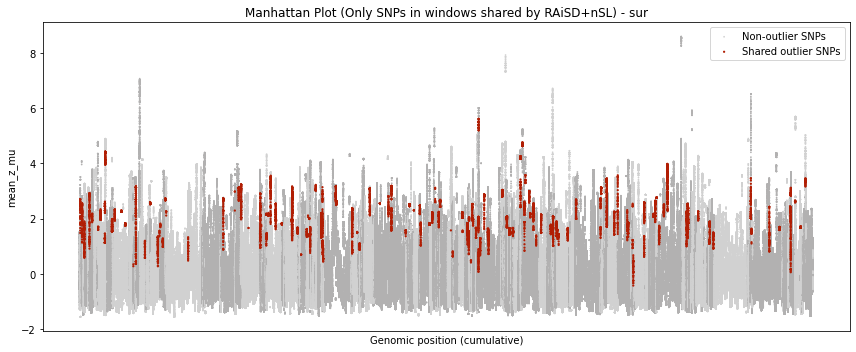

In [318]:
# Alternar colores por scaffold, etc.
colors = ['#d1d1d1', '#b2b1b1']  # Gris oscuro y gris claro
df_snps_in_shared_all_genes_mu['color_scaffold'] = df_snps_in_shared_all_genes_mu['chr_order'].cat.codes % 2

def assign_color(row):
    if row['is_outlier_shared']:
        return '#b11e04'  # Rojo si outlier en ambos
    else:
        return colors[row['color_scaffold']]

df_snps_in_shared_all_genes_mu['color'] = df_snps_in_shared_all_genes_mu.apply(assign_color, axis=1)

# Posición acumulada
df_snps_in_shared_all_genes_mu['cum_len'] = df_snps_in_shared_all_genes_mu.groupby('chr')['pos'].transform('max')
df_snps_in_shared_all_genes_mu['offset'] = (
    df_snps_in_shared_all_genes_mu.groupby('chr')['cum_len'].transform('first').cumsum()
    - df_snps_in_shared_all_genes_mu['cum_len']
)
df_snps_in_shared_all_genes_mu['cum_pos'] = (
    df_snps_in_shared_all_genes_mu['pos'] + df_snps_in_shared_all_genes_mu['offset']
)

# Plot
plt.figure(figsize=(12,5))

# Puntos no-outlier
plt.scatter(
    df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['cum_pos'],
    df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['mean_z_mu'],
    c=df_snps_in_shared_all_genes_mu[~df_snps_in_shared_all_genes_mu['is_outlier_shared']]['color'],
    s=3, edgecolor='none', label='Non-outlier SNPs',
    zorder=1
)

# Puntos outlier (compartidos)
plt.scatter(
    df_snps_in_shared_all_genes_mu[df_snps_in_shared_all_genes_mu['is_outlier_shared']]['cum_pos'],
    df_snps_in_shared_all_genes_mu[df_snps_in_shared_all_genes_mu['is_outlier_shared']]['mean_z_mu'],
    c='#b11e04',  # rojo
    s=5, edgecolor='none', label='Shared outlier SNPs',
    zorder=2
)

plt.xticks([], [])
plt.xlabel("Genomic position (cumulative)")
plt.ylabel("mean_z_mu")
plt.title(f"Manhattan Plot (Only SNPs in windows shared by RAiSD+nSL) - {species_name}")

plt.tight_layout()
plt.legend()

# Guardar como PDF y PNG
output_pdf = f"{species_name}_manhattan_plot.pdf"
output_png = f"{species_name}_manhattan_plot.png"

plt.savefig(output_pdf, dpi=600, bbox_inches='tight')
plt.savefig(output_png, dpi=600, bbox_inches='tight')

plt.show()